In [6]:
import re
import numpy as np
import pandas as pd
import os
import PIL
import random
import shutil
import matplotlib.pyplot as plt
import PIL
import sys
import cv2
from tqdm import tqdm
from PIL import Image, ImageMath

from skimage.transform import rescale, resize, downscale_local_mean
from img_processing_256 import rename, random_flip_img_train
%matplotlib inline

In [161]:
def crop_img2(img):
    slice_size=512
    tile_size=256
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # make sure the image is big enough to use
    if (img_h < slice_size) or (img_w < slice_size):
        print("Error - image is wrong size!", img.shape)
        return np.array([0])
    
    # pick a random place to start the crop so that the crop will be the right size
    start_row = np.random.randint(low=0, high=(img_h - slice_size))
    start_col = np.random.randint(low=0, high=(img_w - slice_size))
    
    end_row = start_row + slice_size
    end_col = start_col + slice_size
    
    # crop the image and randomly rotate it
    cropped_img = random_flip_img_train(img[start_row:end_row, start_col:end_col])
    cropped_img = cropped_img.astype('float32')
    
    # make sure the image is the right size
    if cropped_img.shape[0] == cropped_img.shape[1]:
        # resize it and return it
        cropped_img = cv2.resize(cropped_img, dsize=(tile_size, tile_size), interpolation=cv2.INTER_CUBIC) 
        return cropped_img.reshape((tile_size, tile_size, 1))
    
    # else repeat until the image is the right size
    else:
        return crop_img(img)

In [8]:
def remove_margins(image_arr, margin=20):
	"""
	function to trim plxels off all sides of an image
	"""
	h, w = image_arr.shape
	new_image = image_arr[margin:h-margin,margin:w-margin]
	return new_image

In [114]:
def mask_img2(mask_path, full_image_arr, slice_size=512):

	mask = PIL.Image.open(mask_path)
	print(mask.size)
#	if half:
#		print("half")
#		h, w = mask.size
#		new_size = ( h // 2, w // 2)
#		mask.thumbnail(new_size, PIL.Image.ANTIALIAS)
#	print(mask.size)
    
	mask_arr = np.array(mask)
	mask_arr = mask_arr[:,:]
    
#	plt.imshow(mask_arr, cmap='gray')
    
#	if np.sum(np.sum(full_image_arr >= 225)) > 20000:
#		#plt.imshow(full_image_arr, cmap='gray')
#		full_image_arr = remove_margins(full_image_arr)
#		mask_arr = remove_margins(mask_arr)
        
		#plt.imshow(full_image_arr, cmap='gray')
        
#		if output:
#			print("Trimming borders", mask_path)
			
	# The maks size must be same as the full image size
#	if mask_arr.shape != full_image_arr.shape:
		# see if the ratios are the same
#		mask_ratio = mask_arr.shape[0] / mask_arr.shape[1]
#		image_ratio = full_image_arr.shape[0] / full_image_arr.shape[1]
		
#		if abs(mask_ratio - image_ratio) <=  1e-03:
#			if output:
#				print("Mishaped mask, resizing mask", mask_path)
			
			# reshape the mask to match the image
			#mask_arr = imresize(mask_arr, full_image_arr.shape)
#			mask_arr = np.array(Image.fromarray(mask_arr).resize(full_image_arr.shape))
#		else:
#			if output:
#				print("Mask shape:", mask_arr.shape)
#				print("Image shape:", full_image_arr.shape)
#			print("Mask shape doesn't match image!", mask_path)
#			return 0, 0, False, full_image_arr, 0
	
	# find the borders
	mask_mask = mask_arr == 255

	# check whether each row or column have a white pixel
	cols = np.sum(mask_mask, axis=0)
	rows = np.sum(mask_mask, axis=1)

	# check corners
	first_col = np.argmax(cols > 0)
	last_col = mask_arr.shape[1] - np.argmax(np.flip(cols, axis=0) > 0)
	center_col = int((first_col + last_col) / 2)

	first_row = np.argmax(rows > 0)
	last_row = mask_arr.shape[0] - np.argmax(np.flip(rows, axis=0) > 0)
	center_row = int((first_row + last_row) / 2)
	
	col_size = last_col - first_col
	row_size = last_row - first_row
	
	mask_size = [row_size, col_size]
#	print(mask_size)
	# When a mask size is bigger than a slice
	too_big = False
	
	if (last_col - first_col > slice_size + 30) or (last_row - first_row > slice_size + 30):
		too_big = True
#	print("center_row:", center_row)
#	print("center_col:", center_col)
	return center_row, center_col, too_big, mask_size

In [1]:
def create_patches(roi_size, mask_dir, img_dir, Lbls, size=256, debug=True):
    patch_list = []
    Lbl_list = []
    FN_list = []
    
    full_size = 512
    masks = os.listdir(mask_dir)
    counter = 0
    if debug is None:
        progress(counter, len(masks), 'WORKING')
    for mask in tqdm(masks):
        counter += 1
        if debug is None:
            progress(counter, len(masks), mask)
        base_img_file = mask[:-6] + ".png"
        full_img = PIL.Image.open(img_dir+"/"+base_img_file)
#        try:
#            full_img = PIL.Image.open(img_dir + "/" + base_img_file + '.png')
#        except:
#            try:
#                full_img = PIL.Image.open(img_dir + "/" + base_img_file + '000000.png')
#            except:
#                try:
#                    full_img = PIL.Image.open(img_dir + "/" + base_img_file + '000001.png')
#                except:
#                    print("Error FileNotFound:", base_img_file)
#                    continue
        compare = base_img_file[14:]
        #print(compare)
        try:
            Lbl = Lbls.loc[compare]['Class']
        except:
            print("Error LabelNotFound", base_img_file)
            continue
            
        full_img_arr = np.array(full_img)[:,:]
        ctr_row, ctr_col, too_big, mask_size = mask_img2(mask_dir + "/" + mask,full_img_arr)
        img_h, img_w = full_img_arr.shape
        try:
            mask_H = mask_size[0]
            mask_W = mask_size[1]
            roi_size = np.max([mask_H, mask_W])
            if debug:
                print("Mask", mask, " Height:", mask_H, "Width:", mask_W)
        except:
            print("Mask Size Error:", mask_size, "for", mask)
        # Record roi size for DDSM image crop
        roi_sizes.append(roi_size)
        if (ctr_row == 0) and (ctr_col == 0):
            print("Error, skipping", mask)
            continue
        """
        Extract the ROI depending on it's size
        If the ROI is smaller than a slice extract it with some padding
        """
        
#        if roi_size < full_size:

        if(mask_H > mask_W):
            mask_W = mask_H
        else:
            mask_H = mask_W
        
        adj_mask_H = mask_H*1.15
        adj_mask_W = mask_W*1.15
        
        
        start_row = np.max([ctr_row - (adj_mask_H // 2), 0])
        end_row = start_row + adj_mask_H
        if end_row > img_h:
            end_row = img_h
            start_row = img_h - adj_mask_H
            
        start_col = np.max([ctr_col - (adj_mask_W // 2), 0])
        end_col = start_col + adj_mask_W
        if end_col > img_w:
            end_col = img_w
            start_col = img_w - adj_mask_W
        
        end_row = int(end_row)
        end_col = int(end_col)
        start_row = int(start_row)
        start_col = int(start_col)
        roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
        
        print(roi_img.shape)    
        
        roi_img = roi_img.astype('float32')
        
        roi_img = cv2.resize(roi_img, dsize=(400, 400), interpolation=cv2.INTER_CUBIC)
        
        #print(roi_img.shape[0])
        #print(roi_img.shape[1])
        
        
        #print(roi_img)
        patch_1 = crop_img2(roi_img)
        patch_2 = crop_img2(roi_img)
        patch_3 = crop_img2(roi_img)
        
        patch_list.append(roi_img)
        Lbl_list.append(Lbl)
        FN_list.append(base_img_file) 
            
#        if (patch_1.shape[0] == size) and (patch_1.shape[1] == size):
#            patch_list.append(patch_1)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
                
#        if (patch_2.shape[0] == size) and (patch_2.shape[1] == size):
#            patch_list.append(patch_2)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
        
#        if (patch_3.shape[0] == size) and (patch_2.shape[1] == size):
#            patch_list.append(patch_3)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
                
    return np.array(patch_list), np.array(Lbl_list), np.array(FN_list), roi_sizes

In [184]:
#Calc_test
test_labels = pd.read_pickle("label old ver/test_label.pkl")
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/test_png/Calc"
img_dir = "D:/mammography/full/test_png/Calc"

roi_sizes = []

test_calc_patch, test_calc_Lbl, test_calc_FN, test_calc_roi_size = \
    create_patches(roi_sizes, mask_dir, img_dir, Lbls=test_labels, debug=True)


  2%|█▊                                                                                | 7/326 [00:00<00:28, 11.02it/s]

Error LabelNotFound Calc-Test_P_00038_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00038_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00038_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00038_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00038_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00038_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00041_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00041_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00077_LEFT_CC.png


  5%|███▉                                                                             | 16/326 [00:00<00:18, 17.19it/s]

Error LabelNotFound Calc-Test_P_00077_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00077_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00077_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00077_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00077_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00100_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00100_RIGHT_MLO.png


 10%|███████▋                                                                         | 31/326 [00:00<00:10, 28.04it/s]

Error LabelNotFound Calc-Test_P_00127_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00127_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00132_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00140_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00140_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00140_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00140_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00140_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00140_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00140_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00140_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00141_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00141_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00150_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00163_LEFT_CC.png
Error LabelNotFound

 11%|█████████▏                                                                       | 37/326 [00:00<00:09, 30.44it/s]

 Calc-Test_P_00163_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00164_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00180_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00180_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00195_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00195_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00202_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00202_RIGHT_MLO.png
Error LabelNotFound

 14%|███████████▋                                                                     | 47/326 [00:01<00:07, 37.03it/s]

 Calc-Test_P_00214_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00214_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00214_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00214_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00214_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00223_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00244_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00246_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00257_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00257_RIGHT_MLO.png


 17%|██████████████▏                                                                  | 57/326 [00:01<00:06, 41.50it/s]

Error LabelNotFound Calc-Test_P_00299_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00299_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00299_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00315_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00325_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00331_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00331_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00344_LEFT_CC.png
Error LabelNotFound

 21%|████████████████▋                                                                | 67/326 [00:01<00:05, 43.53it/s]

 Calc-Test_P_00344_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00352_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00352_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00353_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00353_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00353_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00353_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00368_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00368_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00372_RIGHT_CC.png


 26%|████████████████████▊                                                            | 84/326 [00:01<00:04, 56.40it/s]

Error LabelNotFound Calc-Test_P_00372_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00390_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00390_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00397_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00402_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00402_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00403_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00403_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00460_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00460_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00466_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00485_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00485_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00485_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00485_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00485_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00485_LEFT_MLO.png


 28%|██████████████████████▌                                                          | 91/326 [00:01<00:04, 55.97it/s]

Error LabelNotFound Calc-Test_P_00495_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00495_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00495_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00495_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00497_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00497_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00537_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00562_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00562_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00562_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00562_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00562_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00562_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00570_LEFT_MLO.png
Error LabelNotFound

 33%|██████████████████████████▌                                                     | 108/326 [00:02<00:03, 60.33it/s]

 Calc-Test_P_00579_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00589_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00589_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00608_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00608_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00620_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00643_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00643_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00646_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00646_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00649_LEFT_CC.png
Error LabelNotFound

 38%|██████████████████████████████▋                                                 | 125/326 [00:02<00:03, 63.70it/s]

 Calc-Test_P_00649_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00663_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00663_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00678_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00679_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00679_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00681_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00681_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00686_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00723_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00723_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00723_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00753_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00753_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00774_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00774_RIGHT_MLO.png


 41%|████████████████████████████████▋                                               | 133/326 [00:02<00:02, 66.40it/s]

Error LabelNotFound Calc-Test_P_00789_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00790_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00790_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00795_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00795_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00811_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00827_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00827_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00843_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00843_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00857_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00857_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00876_LEFT_CC.png


 46%|████████████████████████████████████▊                                           | 150/326 [00:02<00:02, 68.12it/s]

Error LabelNotFound Calc-Test_P_00876_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00879_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00879_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00905_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00905_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00906_LEFT_CC.png
Error LabelNotFound Calc-Test_P_00906_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00906_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_00919_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00919_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_00974_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_00974_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01004_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01004_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01004_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01004_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01006_LEFT_CC.png
Error LabelNotFound

 50%|████████████████████████████████████████                                        | 163/326 [00:02<00:02, 76.09it/s]

 Calc-Test_P_01006_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01022_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01022_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01030_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01030_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01030_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01030_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01042_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01042_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01050_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01058_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01058_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01067_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01067_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01092_LEFT_CC.png
Error LabelNotFound

 56%|████████████████████████████████████████████▍                                   | 181/326 [00:03<00:01, 79.20it/s]

 Calc-Test_P_01092_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01132_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01148_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01152_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01152_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01154_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01154_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01157_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01157_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01179_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01211_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01211_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01211_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01211_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01211_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01211_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01217_RIGHT_CC.png
Error LabelNotFound

 61%|████████████████████████████████████████████████▊                               | 199/326 [00:03<00:01, 80.13it/s]

 Calc-Test_P_01217_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01224_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01224_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01237_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01237_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01253_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01253_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01272_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01272_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01272_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01272_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01303_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01303_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01308_LEFT_MLO.png
Error LabelNotFound

 64%|███████████████████████████████████████████████████▌                            | 210/326 [00:03<00:01, 82.74it/s]

 Calc-Test_P_01318_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01320_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01352_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01352_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01353_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01353_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01390_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01390_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01390_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01390_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01399_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01399_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01407_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01407_LEFT_MLO.png
Error LabelNotFound

 70%|███████████████████████████████████████████████████████▉                        | 228/326 [00:03<00:01, 77.11it/s]

 Calc-Test_P_01407_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01407_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01414_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01414_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01415_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01419_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01419_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01425_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01425_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01460_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01460_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01460_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01460_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01460_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01460_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01465_LEFT_MLO.png


 72%|█████████████████████████████████████████████████████████▉                      | 236/326 [00:03<00:01, 65.06it/s]

Error LabelNotFound Calc-Test_P_01471_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01471_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01476_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01476_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01483_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01483_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01490_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01490_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01502_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01502_LEFT_MLO.png


 78%|██████████████████████████████████████████████████████████████▌                 | 255/326 [00:04<00:01, 68.30it/s]

Error LabelNotFound Calc-Test_P_01523_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01534_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01534_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01535_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01535_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01536_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01536_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01538_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01538_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01547_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01547_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01562_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01562_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01602_RIGHT_CC.png
Error LabelNotFound

 81%|████████████████████████████████████████████████████████████████▌               | 263/326 [00:04<00:00, 64.04it/s]

 Calc-Test_P_01621_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01621_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01635_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01635_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01643_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01643_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01643_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01643_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01670_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01670_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01670_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01670_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01711_RIGHT_CC.png
Error LabelNotFound

 86%|████████████████████████████████████████████████████████████████████▍           | 279/326 [00:04<00:00, 67.52it/s]

 Calc-Test_P_01711_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01713_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01728_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01743_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01743_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01752_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01752_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01773_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01773_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01803_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01803_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01820_LEFT_MLO.png
Error LabelNotFound

 90%|████████████████████████████████████████████████████████████████████████▍       | 295/326 [00:04<00:00, 71.80it/s]

 Calc-Test_P_01834_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01842_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01845_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01845_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01845_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01845_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_01861_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01861_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01867_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01867_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01867_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01867_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01868_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01868_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01872_LEFT_CC.png
Error LabelNotFound

 93%|██████████████████████████████████████████████████████████████████████████▎     | 303/326 [00:04<00:00, 64.22it/s]

 Calc-Test_P_01872_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01882_LEFT_CC.png
Error LabelNotFound Calc-Test_P_01882_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_01883_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_01883_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_02102_LEFT_CC.png
Error LabelNotFound Calc-Test_P_02102_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_02139_LEFT_CC.png
Error LabelNotFound Calc-Test_P_02139_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_02153_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_02153_RIGHT_MLO.png
Error LabelNotFound

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 320/326 [00:05<00:00, 71.67it/s]

 Calc-Test_P_02159_LEFT_CC.png
Error LabelNotFound Calc-Test_P_02159_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_02176_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_02176_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_02198_LEFT_CC.png
Error LabelNotFound Calc-Test_P_02198_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_02275_LEFT_CC.png
Error LabelNotFound Calc-Test_P_02275_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_02418_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_02418_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_02420_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_02420_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_02432_LEFT_CC.png
Error LabelNotFound Calc-Test_P_02432_LEFT_MLO.png
Error LabelNotFound Calc-Test_P_02464_RIGHT_CC.png
Error LabelNotFound

100%|████████████████████████████████████████████████████████████████████████████████| 326/326 [00:05<00:00, 63.98it/s]

 Calc-Test_P_02464_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_02498_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_02498_RIGHT_MLO.png
Error LabelNotFound Calc-Test_P_02501_RIGHT_CC.png
Error LabelNotFound Calc-Test_P_02501_RIGHT_MLO.png


In [21]:
print("Test calc patches shape:", test_calc_patch.shape)
print("Test calc Labels:", len(test_calc_Lbl))
print("Test calc File Name:", len(test_calc_FN))

Test calc patches shape: (972, 256, 256, 1)
Test calc Labels: 972
Test calc File Name: 972


C:\Users\dahyun\anaconda3\envs\mammo\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  if __name__ == '__main__':


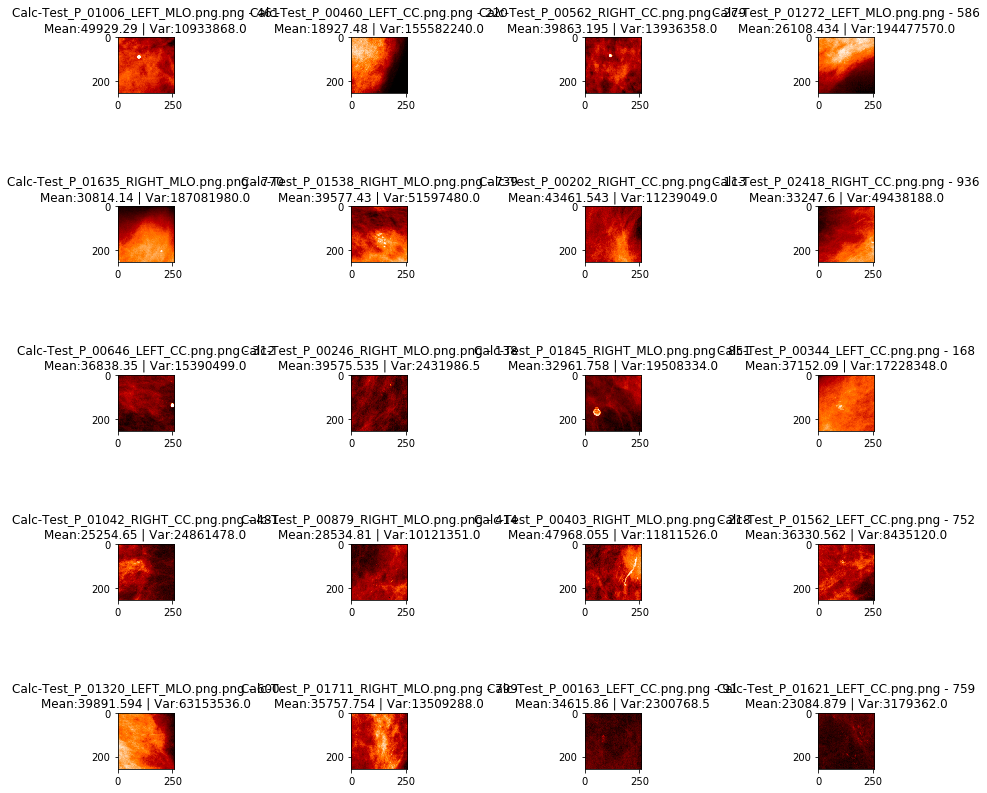

In [39]:
# random images 
N = 20
idx = random.sample(range(len(test_calc_patch)), k=N)
plt.figure(figsize=(12,12))
for i, j in enumerate(idx):
    plt.subplot(5,4,i+1)
    plt.imshow(test_calc_patch[j].reshape(256, 256), cmap='gist_heat')
    plt.title(test_calc_FN[j] + " - " + str(j)+ "\n" + "Mean:" + str(round(np.mean(test_calc_patch[j]),3)) + " | Var:" + str(round(np.var(test_calc_patch[j]),3)))
    plt.tight_layout()
plt.show()

In [23]:
print("ROI Mean Size:", np.round(np.mean(test_calc_roi_size),2))
print("ROI Min Size:", np.min(test_calc_roi_size))
print("ROI Max Size:", np.max(test_calc_roi_size))
print("ROI Size Std:", np.round(np.std(test_calc_roi_size),2))

ROI Mean Size: 458.78
ROI Min Size: 41
ROI Max Size: 2249
ROI Size Std: 406.58


In [40]:
np.save(os.path.join("npy", "test_calc_patch.npy"), test_calc_patch)
np.save(os.path.join("npy", "test_calc_Lbl.npy"), np.array(test_calc_Lbl))
np.save(os.path.join("npy", "test_calc_FN.npy"), test_calc_FN)
np.save(os.path.join("npy", "test_calc_roi_size.npy"), np.array(test_calc_roi_size))

In [30]:
#Mass_test
test_labels = pd.read_pickle("label old ver/test_label.pkl")
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/test_png/Mass"
img_dir = "D:/mammography/full/test_png/Mass"

roi_sizes = []

test_mass_patch, test_mass_Lbl, test_mass_FN, test_mass_roi_size = \
    create_patches(roi_sizes, mask_dir, img_dir, Lbls=test_labels, debug=True)


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 3875.40it/s]

016_LEFT_CC.png
Error LabelNotFound Mass-Test_P_00016_LEFT_CC.png
016_LEFT_MLO.png
Error LabelNotFound Mass-Test_P_00016_LEFT_MLO.png
017_LEFT_CC.png
Error LabelNotFound Mass-Test_P_00017_LEFT_CC.png
017_LEFT_MLO.png
Error LabelNotFound Mass-Test_P_00017_LEFT_MLO.png
032_RIGHT_CC.png
Error LabelNotFound Mass-Test_P_00032_RIGHT_CC.png
032_RIGHT_MLO.png
Error LabelNotFound Mass-Test_P_00032_RIGHT_MLO.png
037_RIGHT_CC.png
Error LabelNotFound Mass-Test_P_00037_RIGHT_CC.png
037_RIGHT_MLO.png
Error LabelNotFound Mass-Test_P_00037_RIGHT_MLO.png
056_LEFT_MLO.png
Error LabelNotFound Mass-Test_P_00056_LEFT_MLO.png
066_LEFT_CC.png
Error LabelNotFound Mass-Test_P_00066_LEFT_CC.png
066_LEFT_MLO.png
Error LabelNotFound Mass-Test_P_00066_LEFT_MLO.png
099_LEFT_MLO.png
Error LabelNotFound Mass-Test_P_00099_LEFT_MLO.png
114_LEFT_MLO.png
Error LabelNotFound Mass-Test_P_00114_LEFT_MLO.png
116_RIGHT_CC.png
Error LabelNotFound Mass-Test_P_00116_RIGHT_CC.png
116_RIGHT_CC.png
Error LabelNotFound Mass-Test_P_0

C:\Users\dahyun\anaconda3\envs\mammo\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  if __name__ == '__main__':


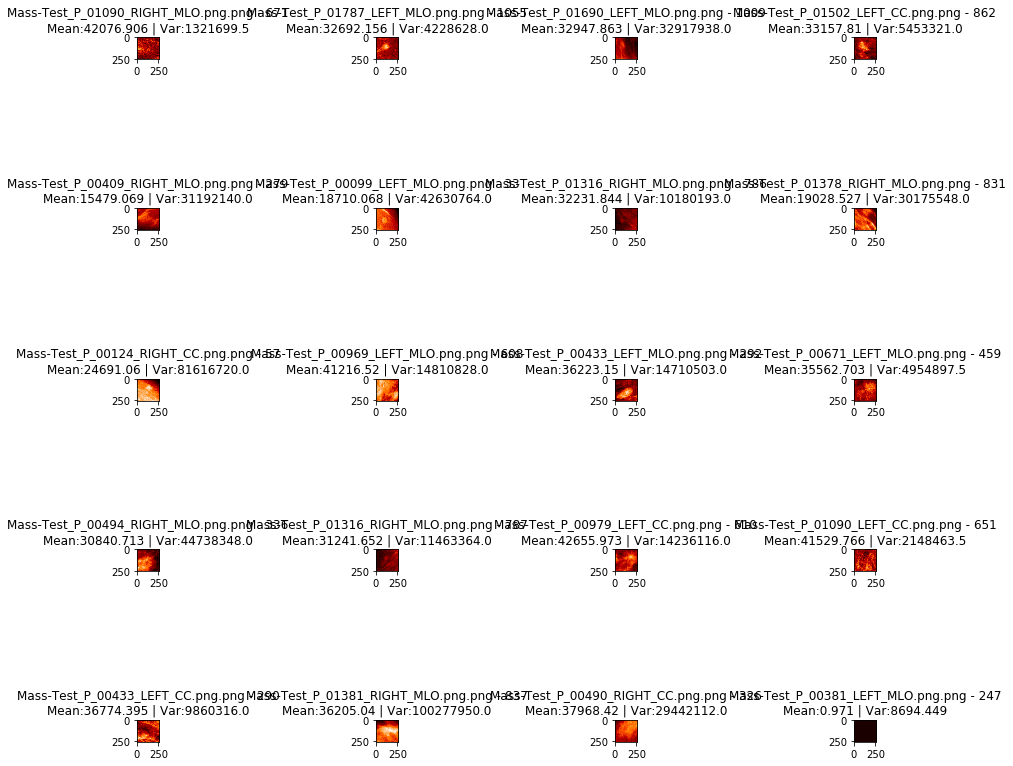

In [38]:
# random images 
N = 20
idx = random.sample(range(len(test_mass_patch)), k=N)
plt.figure(figsize=(12,12))
for i, j in enumerate(idx):
    plt.subplot(5,4,i+1)
    plt.imshow(test_mass_patch[j].reshape(256, 256), cmap='gist_heat')
    plt.title(test_mass_FN[j] + " - " + str(j)+ "\n" + "Mean:" + str(round(np.mean(test_mass_patch[j]),3)) + " | Var:" + str(round(np.var(test_mass_patch[j]),3)))
    plt.tight_layout()
plt.show()

C:\Users\dahyun\anaconda3\envs\mammo\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  if __name__ == '__main__':


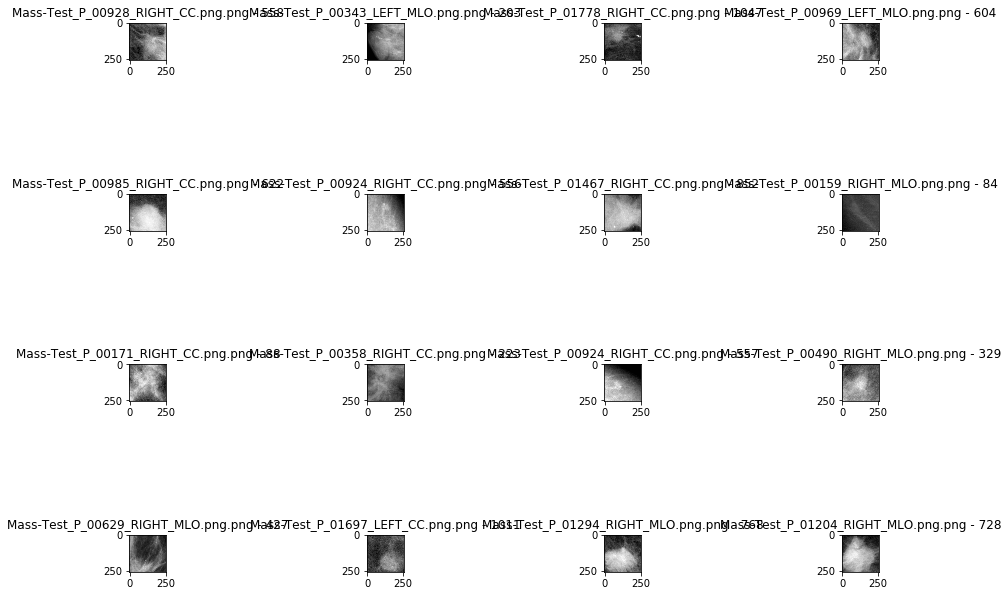

In [37]:
# random images
N = 16
idx = random.sample(range(len(test_mass_patch)), k=N)
plt.figure(figsize=(12,12))
for i, j in enumerate(idx):
    plt.subplot(5,4,i+1)
    plt.imshow(test_mass_patch[j].reshape(256, 256), cmap='gray')
    plt.title(test_mass_FN[j] + " - " + str(j)) #+ "\n" + "Mean:" + str(round(np.mean(test_mass_patch[j]),3)) + " | Var:" + str(round(np.var(test_mass_patch[j]),3)))
    plt.tight_layout()
plt.show()

In [29]:
print("ROI Mean Size:", np.round(np.mean(test_mass_roi_size),2))
print("ROI Min Size:", np.min(test_mass_roi_size))
print("ROI Max Size:", np.max(test_mass_roi_size))
print("ROI Size Std:", np.round(np.std(test_mass_roi_size),2))

ROI Mean Size: 347.74
ROI Min Size: 116
ROI Max Size: 948
ROI Size Std: 124.3


In [41]:
np.save(os.path.join("npy", "test_mass_patch.npy"), test_mass_patch)
np.save(os.path.join("npy", "test_mass_Lbl.npy"), np.array(test_mass_Lbl))
np.save(os.path.join("npy", "test_mass_FN.npy"), test_mass_FN)
np.save(os.path.join("npy", "test_mass_roi_size.npy"), np.array(test_mass_roi_size))

In [213]:
#Calc_training
train_labels = pd.read_pickle("label old ver/train_label.pkl")
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/train_png/Calc_temp"
img_dir = "D:/mammography/full/train_png/Calc_temp"

roi_sizes = []

train_calc_patch, train_calc_Lbl, train_calc_FN, train_calc_roi_size = \
    create_patches(roi_sizes, mask_dir, img_dir, Lbls=train_labels, debug=True)

  5%|███▊                                                                               | 1/22 [00:00<00:07,  2.81it/s]

(2761, 5056)
Mask Calc-Training_P_00005_RIGHT_CC_1.png  Height: 549 Width: 637
(732, 732)


  9%|███████▌                                                                           | 2/22 [00:00<00:07,  2.69it/s]

(2836, 5386)
Mask Calc-Training_P_00005_RIGHT_MLO_1.png  Height: 509 Width: 641
(737, 737)


 14%|███████████▎                                                                       | 3/22 [00:01<00:07,  2.58it/s]

(2986, 5356)
Mask Calc-Training_P_00007_LEFT_CC_1.png  Height: 641 Width: 537
(737, 737)


 18%|███████████████                                                                    | 4/22 [00:01<00:07,  2.43it/s]

(3166, 5491)
Mask Calc-Training_P_00007_LEFT_MLO_1.png  Height: 649 Width: 721
(829, 829)


 23%|██████████████████▊                                                                | 5/22 [00:02<00:06,  2.46it/s]

(3064, 4568)
Mask Calc-Training_P_00008_LEFT_CC_1.png  Height: 121 Width: 137
(157, 157)


 27%|██████████████████████▋                                                            | 6/22 [00:02<00:06,  2.51it/s]

(3064, 4568)
Mask Calc-Training_P_00008_LEFT_CC_2.png  Height: 129 Width: 137
(157, 157)


 32%|██████████████████████████▍                                                        | 7/22 [00:02<00:05,  2.55it/s]

(3064, 4568)
Mask Calc-Training_P_00008_LEFT_CC_3.png  Height: 73 Width: 105
(120, 120)


 36%|██████████████████████████████▏                                                    | 8/22 [00:03<00:05,  2.57it/s]

(3056, 4528)
Mask Calc-Training_P_00008_LEFT_MLO_1.png  Height: 89 Width: 97
(111, 111)


 41%|█████████████████████████████████▉                                                 | 9/22 [00:03<00:05,  2.59it/s]

(3056, 4528)
Mask Calc-Training_P_00008_LEFT_MLO_2.png  Height: 105 Width: 89
(120, 120)


 45%|█████████████████████████████████████▎                                            | 10/22 [00:03<00:04,  2.61it/s]

(3056, 4528)
Mask Calc-Training_P_00008_LEFT_MLO_3.png  Height: 81 Width: 105
(120, 120)


 50%|█████████████████████████████████████████                                         | 11/22 [00:04<00:04,  2.61it/s]

(3032, 4536)
Mask Calc-Training_P_00008_RIGHT_CC_1.png  Height: 233 Width: 209
(267, 267)


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:04<00:03,  2.63it/s]

(3032, 4536)
Mask Calc-Training_P_00008_RIGHT_CC_2.png  Height: 105 Width: 129
(148, 148)


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:05<00:03,  2.64it/s]

(3032, 4536)
Mask Calc-Training_P_00008_RIGHT_CC_3.png  Height: 113 Width: 97
(129, 129)


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:05<00:03,  2.65it/s]

(3032, 4536)
Mask Calc-Training_P_00008_RIGHT_CC_4.png  Height: 73 Width: 89
(102, 102)


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:05<00:02,  2.63it/s]

(3032, 4536)
Mask Calc-Training_P_00008_RIGHT_CC_5.png  Height: 89 Width: 121
(139, 139)


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:06<00:02,  2.59it/s]

(3048, 4576)
Mask Calc-Training_P_00008_RIGHT_MLO_1.png  Height: 241 Width: 113
(277, 277)


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:06<00:01,  2.59it/s]

(3048, 4576)
Mask Calc-Training_P_00008_RIGHT_MLO_2.png  Height: 65 Width: 57
(74, 74)


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:07<00:01,  2.59it/s]

(3048, 4576)
Mask Calc-Training_P_00008_RIGHT_MLO_3.png  Height: 73 Width: 81
(93, 93)


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:07<00:01,  2.59it/s]

(3048, 4576)
Mask Calc-Training_P_00008_RIGHT_MLO_4.png  Height: 97 Width: 97
(111, 111)


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:07<00:00,  2.58it/s]

(3048, 4576)
Mask Calc-Training_P_00008_RIGHT_MLO_5.png  Height: 233 Width: 129
(267, 267)


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:08<00:00,  2.58it/s]

(3136, 4608)
Mask Calc-Training_P_00010_LEFT_CC_1.png  Height: 89 Width: 89
(102, 102)


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:08<00:00,  2.57it/s]

(3120, 4592)
Mask Calc-Training_P_00010_LEFT_MLO_1.png  Height: 89 Width: 98
(112, 112)


In [214]:
print("Train calc patches shape:", train_calc_patch.shape)
print("Train calc Labels:", len(train_calc_Lbl))
print("Train calc File Name:", len(train_calc_FN))

Train calc patches shape: (22, 400, 400)
Train calc Labels: 22
Train calc File Name: 22


In [215]:
train_calc_FN

array(['Calc-Training_P_00005_RIGHT_CC.png',
       'Calc-Training_P_00005_RIGHT_MLO.png',
       'Calc-Training_P_00007_LEFT_CC.png',
       'Calc-Training_P_00007_LEFT_MLO.png',
       'Calc-Training_P_00008_LEFT_CC.png',
       'Calc-Training_P_00008_LEFT_CC.png',
       'Calc-Training_P_00008_LEFT_CC.png',
       'Calc-Training_P_00008_LEFT_MLO.png',
       'Calc-Training_P_00008_LEFT_MLO.png',
       'Calc-Training_P_00008_LEFT_MLO.png',
       'Calc-Training_P_00008_RIGHT_CC.png',
       'Calc-Training_P_00008_RIGHT_CC.png',
       'Calc-Training_P_00008_RIGHT_CC.png',
       'Calc-Training_P_00008_RIGHT_CC.png',
       'Calc-Training_P_00008_RIGHT_CC.png',
       'Calc-Training_P_00008_RIGHT_MLO.png',
       'Calc-Training_P_00008_RIGHT_MLO.png',
       'Calc-Training_P_00008_RIGHT_MLO.png',
       'Calc-Training_P_00008_RIGHT_MLO.png',
       'Calc-Training_P_00008_RIGHT_MLO.png',
       'Calc-Training_P_00010_LEFT_CC.png',
       'Calc-Training_P_00010_LEFT_MLO.png'], dtype='<

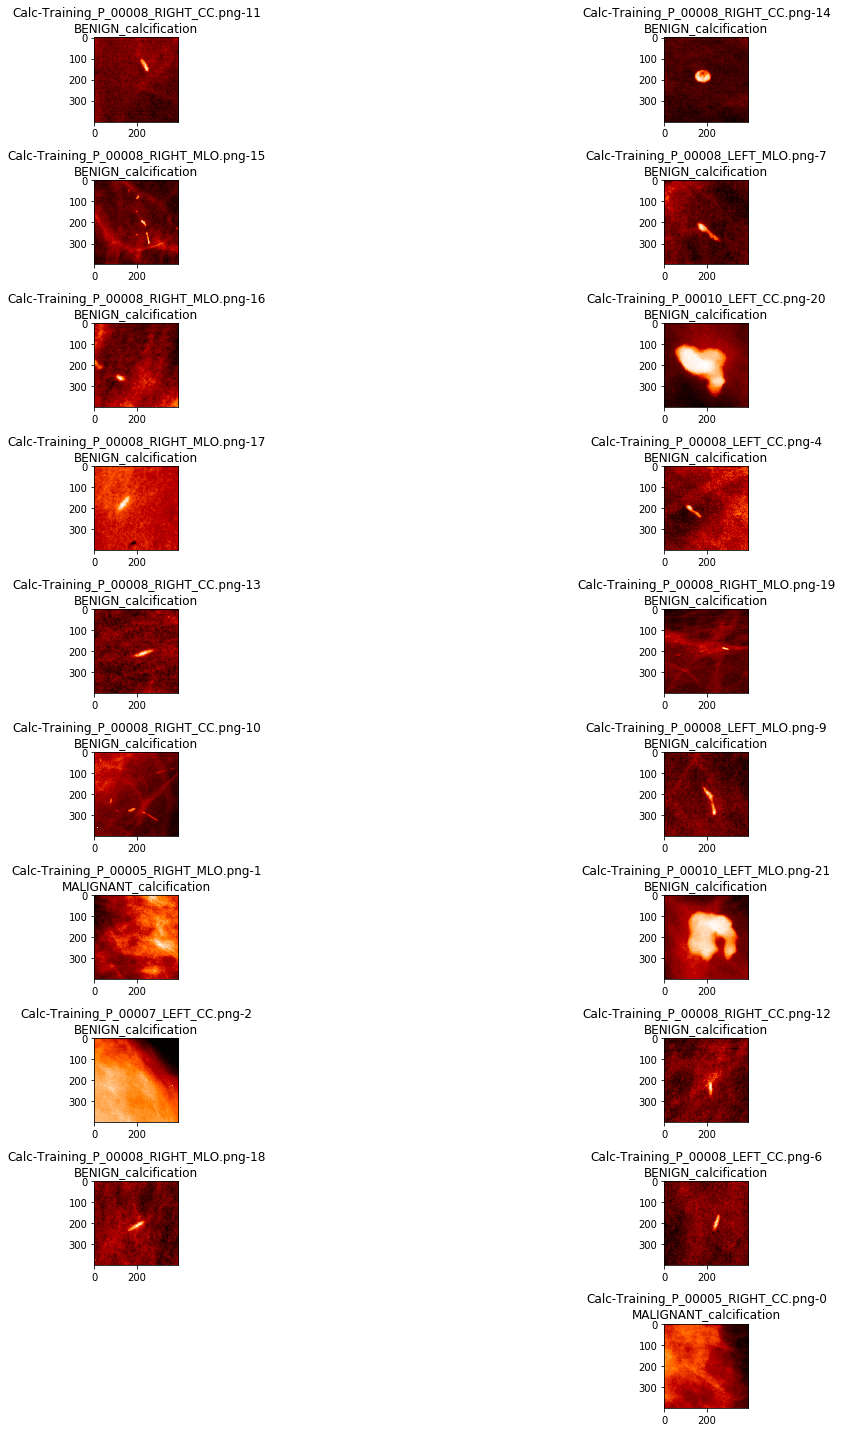

In [220]:
# random images 
N = 20
idx = random.sample(range(len(train_calc_patch)), k=N)
plt.figure(figsize=(20,20))
for i, j in enumerate(idx):
    plt.subplot(10,2,i+1)
    plt.imshow(train_calc_patch[j].reshape(400, 400), cmap='gist_heat')
    #plt.title(train_calc_FN[j] + " - " + str(j)+ "\n" + "Mean:" + str(round(np.mean(train_calc_patch[j]),3)) + " | Var:" + str(round(np.var(train_calc_patch[j]),3)))
    plt.title(train_calc_FN[j] + "-" + str(j) + "\n" + train_calc_Lbl[j])
    plt.tight_layout()
plt.show()

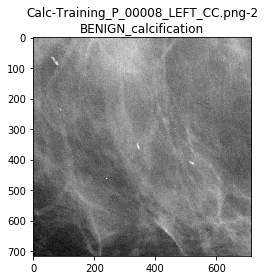

In [175]:
plt.imshow(train_calc_patch[2], cmap='gray')
plt.title(train_calc_FN[2] + "-" + str(2) + "\n" + train_calc_Lbl[j])
plt.tight_layout()

In [158]:
print("ROI Mean Size:", np.round(np.mean(train_calc_roi_size),2))
print("ROI Min Size:", np.min(train_calc_roi_size))
print("ROI Max Size:", np.max(train_calc_roi_size))
print("ROI Size Std:", np.round(np.std(train_calc_roi_size),2))

ROI Mean Size: 223.41
ROI Min Size: 65
ROI Max Size: 721
ROI Size Std: 211.67


In [53]:
np.save(os.path.join("npy", "train_calc_patch.npy"), train_calc_patch)
np.save(os.path.join("npy", "train_calc_Lbl.npy"), np.array(train_calc_Lbl))
np.save(os.path.join("npy", "train_calc_FN.npy"), train_calc_FN)
np.save(os.path.join("npy", "train_calc_roi_size.npy"), np.array(train_calc_roi_size))

In [54]:
#Mass_training
train_labels = pd.read_pickle("label old ver/train_label.pkl")
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/train_png/Mass"
img_dir = "D:/mammography/full/train_png/Mass"

roi_sizes = []

train_mass_patch, train_mass_Lbl, train_mass_FN, train_mass_roi_size = \
    create_patches(roi_sizes, mask_dir, img_dir, Lbls=train_labels, debug=True)


  0%|                                                                                         | 0/1318 [00:00<?, ?it/s]

P_00001_LEFT_CC.png


  0%|                                                                                 | 1/1318 [00:01<23:22,  1.07s/it]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00001_LEFT_CC_1.png
Mask Mass-Training_P_00001_LEFT_CC_1.png  Height: 475 Width: 391
ROI small Mass-Training_P_00001_LEFT_CC_1.png
P_00001_LEFT_MLO.png


  0%|                                                                                 | 2/1318 [00:01<19:32,  1.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00001_LEFT_MLO_1.png
Mask Mass-Training_P_00001_LEFT_MLO_1.png  Height: 252 Width: 216
ROI small Mass-Training_P_00001_LEFT_MLO_1.png
P_00004_LEFT_CC.png


  0%|▏                                                                                | 3/1318 [00:02<17:08,  1.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00004_LEFT_CC_1.png
Mask Mass-Training_P_00004_LEFT_CC_1.png  Height: 426 Width: 383
ROI small Mass-Training_P_00004_LEFT_CC_1.png
P_00004_LEFT_MLO.png


  0%|▏                                                                                | 4/1318 [00:02<15:56,  1.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00004_LEFT_MLO_1.png
Mask Mass-Training_P_00004_LEFT_MLO_1.png  Height: 387 Width: 382
ROI small Mass-Training_P_00004_LEFT_MLO_1.png
P_00004_RIGHT_MLO.png


  0%|▎                                                                                | 5/1318 [00:03<14:41,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00004_RIGHT_MLO_1.png
Mask Mass-Training_P_00004_RIGHT_MLO_1.png  Height: 359 Width: 425
ROI small Mass-Training_P_00004_RIGHT_MLO_1.png
P_00009_RIGHT_CC.png


  0%|▎                                                                                | 6/1318 [00:03<12:36,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00009_RIGHT_CC_1.png
Mask Mass-Training_P_00009_RIGHT_CC_1.png  Height: 181 Width: 200
ROI small Mass-Training_P_00009_RIGHT_CC_1.png
P_00009_RIGHT_MLO.png


  1%|▍                                                                                | 7/1318 [00:03<11:36,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00009_RIGHT_MLO_1.png
Mask Mass-Training_P_00009_RIGHT_MLO_1.png  Height: 231 Width: 180
ROI small Mass-Training_P_00009_RIGHT_MLO_1.png
P_00015_LEFT_MLO.png


  1%|▍                                                                                | 8/1318 [00:04<12:42,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00015_LEFT_MLO_1.png
Mask Mass-Training_P_00015_LEFT_MLO_1.png  Height: 235 Width: 244
ROI small Mass-Training_P_00015_LEFT_MLO_1.png
P_00018_RIGHT_CC.png


  1%|▌                                                                                | 9/1318 [00:05<11:39,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00018_RIGHT_CC_1.png
Mask Mass-Training_P_00018_RIGHT_CC_1.png  Height: 266 Width: 304
ROI small Mass-Training_P_00018_RIGHT_CC_1.png
P_00018_RIGHT_MLO.png


  1%|▌                                                                               | 10/1318 [00:05<10:42,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00018_RIGHT_MLO_1.png
Mask Mass-Training_P_00018_RIGHT_MLO_1.png  Height: 254 Width: 250
ROI small Mass-Training_P_00018_RIGHT_MLO_1.png
P_00021_LEFT_CC.png


  1%|▋                                                                               | 11/1318 [00:05<10:21,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00021_LEFT_CC_1.png
Mask Mass-Training_P_00021_LEFT_CC_1.png  Height: 241 Width: 258
ROI small Mass-Training_P_00021_LEFT_CC_1.png
P_00021_LEFT_MLO.png


  1%|▋                                                                               | 12/1318 [00:06<10:02,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00021_LEFT_MLO_1.png
Mask Mass-Training_P_00021_LEFT_MLO_1.png  Height: 215 Width: 237
ROI small Mass-Training_P_00021_LEFT_MLO_1.png
P_00021_RIGHT_CC.png


  1%|▊                                                                               | 13/1318 [00:06<09:59,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00021_RIGHT_CC_1.png
Mask Mass-Training_P_00021_RIGHT_CC_1.png  Height: 145 Width: 154
ROI small Mass-Training_P_00021_RIGHT_CC_1.png
P_00021_RIGHT_MLO.png


  1%|▊                                                                               | 14/1318 [00:07<09:32,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00021_RIGHT_MLO_1.png
Mask Mass-Training_P_00021_RIGHT_MLO_1.png  Height: 289 Width: 236
ROI small Mass-Training_P_00021_RIGHT_MLO_1.png
P_00023_RIGHT_CC.png


  1%|▉                                                                               | 15/1318 [00:07<10:12,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00023_RIGHT_CC_1.png
Mask Mass-Training_P_00023_RIGHT_CC_1.png  Height: 225 Width: 222
ROI small Mass-Training_P_00023_RIGHT_CC_1.png
P_00023_RIGHT_MLO.png


  1%|▉                                                                               | 16/1318 [00:08<11:19,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00023_RIGHT_MLO_1.png
Mask Mass-Training_P_00023_RIGHT_MLO_1.png  Height: 206 Width: 227
ROI small Mass-Training_P_00023_RIGHT_MLO_1.png
P_00026_LEFT_CC.png


  1%|█                                                                               | 17/1318 [00:09<12:58,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00026_LEFT_CC_1.png
Mask Mass-Training_P_00026_LEFT_CC_1.png  Height: 231 Width: 209
ROI small Mass-Training_P_00026_LEFT_CC_1.png
P_00026_LEFT_MLO.png


  1%|█                                                                               | 18/1318 [00:09<13:53,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00026_LEFT_MLO_1.png
Mask Mass-Training_P_00026_LEFT_MLO_1.png  Height: 202 Width: 235
ROI small Mass-Training_P_00026_LEFT_MLO_1.png
P_00027_RIGHT_CC.png


  1%|█▏                                                                              | 19/1318 [00:10<14:48,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00027_RIGHT_CC_1.png
Mask Mass-Training_P_00027_RIGHT_CC_1.png  Height: 329 Width: 286
ROI small Mass-Training_P_00027_RIGHT_CC_1.png
P_00027_RIGHT_MLO.png


  2%|█▏                                                                              | 20/1318 [00:11<14:43,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00027_RIGHT_MLO_1.png
Mask Mass-Training_P_00027_RIGHT_MLO_1.png  Height: 371 Width: 409
ROI small Mass-Training_P_00027_RIGHT_MLO_1.png
P_00034_RIGHT_CC.png


  2%|█▎                                                                              | 21/1318 [00:12<14:55,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00034_RIGHT_CC_1.png
Mask Mass-Training_P_00034_RIGHT_CC_1.png  Height: 395 Width: 434
ROI small Mass-Training_P_00034_RIGHT_CC_1.png
P_00034_RIGHT_MLO.png


  2%|█▎                                                                              | 22/1318 [00:12<15:15,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00034_RIGHT_MLO_1.png
Mask Mass-Training_P_00034_RIGHT_MLO_1.png  Height: 398 Width: 352
ROI small Mass-Training_P_00034_RIGHT_MLO_1.png
P_00039_RIGHT_CC.png


  2%|█▍                                                                              | 23/1318 [00:13<13:59,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00039_RIGHT_CC_1.png
Mask Mass-Training_P_00039_RIGHT_CC_1.png  Height: 507 Width: 424
ROI small Mass-Training_P_00039_RIGHT_CC_1.png
P_00039_RIGHT_MLO.png


  2%|█▍                                                                              | 24/1318 [00:13<12:55,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00039_RIGHT_MLO_1.png
Mask Mass-Training_P_00039_RIGHT_MLO_1.png  Height: 435 Width: 436
ROI small Mass-Training_P_00039_RIGHT_MLO_1.png
P_00041_LEFT_CC.png


  2%|█▌                                                                              | 25/1318 [00:14<13:18,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00041_LEFT_CC_1.png
Mask Mass-Training_P_00041_LEFT_CC_1.png  Height: 135 Width: 179
ROI small Mass-Training_P_00041_LEFT_CC_1.png
P_00041_LEFT_MLO.png


  2%|█▌                                                                              | 26/1318 [00:15<13:43,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00041_LEFT_MLO_1.png
Mask Mass-Training_P_00041_LEFT_MLO_1.png  Height: 163 Width: 172
ROI small Mass-Training_P_00041_LEFT_MLO_1.png
P_00044_RIGHT_CC.png


  2%|█▋                                                                              | 27/1318 [00:15<12:22,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_CC_1.png
Mask Mass-Training_P_00044_RIGHT_CC_1.png  Height: 223 Width: 207
ROI small Mass-Training_P_00044_RIGHT_CC_1.png
P_00044_RIGHT_CC.png


  2%|█▋                                                                              | 28/1318 [00:15<11:06,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_CC_2.png
Mask Mass-Training_P_00044_RIGHT_CC_2.png  Height: 274 Width: 357
ROI small Mass-Training_P_00044_RIGHT_CC_2.png
P_00044_RIGHT_CC.png


  2%|█▊                                                                              | 29/1318 [00:16<10:13,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_CC_3.png
Mask Mass-Training_P_00044_RIGHT_CC_3.png  Height: 128 Width: 120
ROI small Mass-Training_P_00044_RIGHT_CC_3.png
P_00044_RIGHT_CC.png


  2%|█▊                                                                              | 30/1318 [00:16<09:34,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_CC_4.png
Mask Mass-Training_P_00044_RIGHT_CC_4.png  Height: 418 Width: 435
ROI small Mass-Training_P_00044_RIGHT_CC_4.png
P_00044_RIGHT_MLO.png


  2%|█▉                                                                              | 31/1318 [00:17<09:47,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_MLO_1.png
Mask Mass-Training_P_00044_RIGHT_MLO_1.png  Height: 480 Width: 534
ROI Big Mass-Training_P_00044_RIGHT_MLO_1.png
P_00044_RIGHT_MLO.png


  2%|█▉                                                                              | 32/1318 [00:17<09:28,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_MLO_2.png
Mask Mass-Training_P_00044_RIGHT_MLO_2.png  Height: 613 Width: 406
ROI Big Mass-Training_P_00044_RIGHT_MLO_2.png
P_00045_LEFT_CC.png


  3%|██                                                                              | 33/1318 [00:18<10:12,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00045_LEFT_CC_1.png
Mask Mass-Training_P_00045_LEFT_CC_1.png  Height: 296 Width: 330
ROI small Mass-Training_P_00045_LEFT_CC_1.png
P_00045_LEFT_MLO.png


  3%|██                                                                              | 34/1318 [00:18<11:22,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00045_LEFT_MLO_1.png
Mask Mass-Training_P_00045_LEFT_MLO_1.png  Height: 240 Width: 242
ROI small Mass-Training_P_00045_LEFT_MLO_1.png
P_00046_RIGHT_MLO.png


  3%|██                                                                              | 35/1318 [00:19<10:31,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00046_RIGHT_MLO_1.png
Mask Mass-Training_P_00046_RIGHT_MLO_1.png  Height: 332 Width: 403
ROI small Mass-Training_P_00046_RIGHT_MLO_1.png
P_00051_LEFT_CC.png


  3%|██▏                                                                             | 36/1318 [00:19<09:53,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00051_LEFT_CC_1.png
Mask Mass-Training_P_00051_LEFT_CC_1.png  Height: 723 Width: 554
ROI Big Mass-Training_P_00051_LEFT_CC_1.png
P_00051_LEFT_MLO.png


  3%|██▏                                                                             | 37/1318 [00:20<09:20,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00051_LEFT_MLO_1.png
Mask Mass-Training_P_00051_LEFT_MLO_1.png  Height: 772 Width: 510
ROI Big Mass-Training_P_00051_LEFT_MLO_1.png
P_00054_RIGHT_MLO.png


  3%|██▎                                                                             | 38/1318 [00:20<09:27,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00054_RIGHT_MLO_1.png
Mask Mass-Training_P_00054_RIGHT_MLO_1.png  Height: 246 Width: 229
ROI small Mass-Training_P_00054_RIGHT_MLO_1.png
P_00055_LEFT_CC.png


  3%|██▎                                                                             | 39/1318 [00:20<09:46,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00055_LEFT_CC_1.png
Mask Mass-Training_P_00055_LEFT_CC_1.png  Height: 433 Width: 398
ROI small Mass-Training_P_00055_LEFT_CC_1.png
P_00057_RIGHT_CC.png


  3%|██▍                                                                             | 40/1318 [00:21<09:46,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00057_RIGHT_CC_1.png
Mask Mass-Training_P_00057_RIGHT_CC_1.png  Height: 271 Width: 279
ROI small Mass-Training_P_00057_RIGHT_CC_1.png
P_00057_RIGHT_MLO.png


  3%|██▍                                                                             | 41/1318 [00:21<09:39,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00057_RIGHT_MLO_1.png
Mask Mass-Training_P_00057_RIGHT_MLO_1.png  Height: 228 Width: 290
ROI small Mass-Training_P_00057_RIGHT_MLO_1.png
P_00058_RIGHT_CC.png


  3%|██▌                                                                             | 42/1318 [00:22<11:25,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00058_RIGHT_CC_1.png
Mask Mass-Training_P_00058_RIGHT_CC_1.png  Height: 422 Width: 368
ROI small Mass-Training_P_00058_RIGHT_CC_1.png
P_00059_LEFT_CC.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00059_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00059_LEFT_CC_1.png


  3%|██▌                                                                             | 43/1318 [00:23<13:42,  1.55it/s]

Mask Mass-Training_P_00059_LEFT_CC_1.png  Height: 163 Width: 412
ROI small Mass-Training_P_00059_LEFT_CC_1.png
P_00059_LEFT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00059_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00059_LEFT_MLO_1.png


  3%|██▋                                                                             | 44/1318 [00:24<15:01,  1.41it/s]

Mask Mass-Training_P_00059_LEFT_MLO_1.png  Height: 146 Width: 473
ROI small Mass-Training_P_00059_LEFT_MLO_1.png
P_00061_RIGHT_CC.png


  3%|██▋                                                                             | 45/1318 [00:25<15:09,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00061_RIGHT_CC_1.png
Mask Mass-Training_P_00061_RIGHT_CC_1.png  Height: 212 Width: 194
ROI small Mass-Training_P_00061_RIGHT_CC_1.png
P_00061_RIGHT_MLO.png


  3%|██▊                                                                             | 46/1318 [00:25<15:18,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00061_RIGHT_MLO_1.png
Mask Mass-Training_P_00061_RIGHT_MLO_1.png  Height: 270 Width: 265
ROI small Mass-Training_P_00061_RIGHT_MLO_1.png
P_00064_RIGHT_MLO.png


  4%|██▊                                                                             | 47/1318 [00:26<13:34,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00064_RIGHT_MLO_1.png
Mask Mass-Training_P_00064_RIGHT_MLO_1.png  Height: 480 Width: 542
ROI Big Mass-Training_P_00064_RIGHT_MLO_1.png
P_00065_LEFT_CC.png


  4%|██▉                                                                             | 48/1318 [00:26<13:07,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00065_LEFT_CC_1.png
Mask Mass-Training_P_00065_LEFT_CC_1.png  Height: 332 Width: 370
ROI small Mass-Training_P_00065_LEFT_CC_1.png
P_00065_LEFT_MLO.png


  4%|██▉                                                                             | 49/1318 [00:27<12:32,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00065_LEFT_MLO_1.png
Mask Mass-Training_P_00065_LEFT_MLO_1.png  Height: 386 Width: 365
ROI small Mass-Training_P_00065_LEFT_MLO_1.png
P_00068_RIGHT_CC.png


  4%|███                                                                             | 50/1318 [00:27<12:12,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00068_RIGHT_CC_1.png
Mask Mass-Training_P_00068_RIGHT_CC_1.png  Height: 504 Width: 348
ROI small Mass-Training_P_00068_RIGHT_CC_1.png
P_00068_RIGHT_MLO.png


  4%|███                                                                             | 51/1318 [00:28<11:53,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00068_RIGHT_MLO_1.png
Mask Mass-Training_P_00068_RIGHT_MLO_1.png  Height: 298 Width: 395
ROI small Mass-Training_P_00068_RIGHT_MLO_1.png
P_00074_LEFT_MLO.png


  4%|███▏                                                                            | 52/1318 [00:29<12:56,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00074_LEFT_MLO_1.png
Mask Mass-Training_P_00074_LEFT_MLO_1.png  Height: 304 Width: 360
ROI small Mass-Training_P_00074_LEFT_MLO_1.png
P_00074_RIGHT_CC.png


  4%|███▏                                                                            | 53/1318 [00:29<13:39,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00074_RIGHT_CC_1.png
Mask Mass-Training_P_00074_RIGHT_CC_1.png  Height: 182 Width: 200
ROI small Mass-Training_P_00074_RIGHT_CC_1.png
P_00074_RIGHT_MLO.png


  4%|███▎                                                                            | 54/1318 [00:30<14:06,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00074_RIGHT_MLO_1.png
Mask Mass-Training_P_00074_RIGHT_MLO_1.png  Height: 173 Width: 190
ROI small Mass-Training_P_00074_RIGHT_MLO_1.png
P_00076_LEFT_CC.png


  4%|███▎                                                                            | 55/1318 [00:31<14:58,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00076_LEFT_CC_1.png
Mask Mass-Training_P_00076_LEFT_CC_1.png  Height: 197 Width: 194
ROI small Mass-Training_P_00076_LEFT_CC_1.png
P_00076_LEFT_MLO.png


  4%|███▍                                                                            | 56/1318 [00:32<15:02,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00076_LEFT_MLO_1.png
Mask Mass-Training_P_00076_LEFT_MLO_1.png  Height: 204 Width: 212
ROI small Mass-Training_P_00076_LEFT_MLO_1.png
P_00079_RIGHT_CC.png


  4%|███▍                                                                            | 57/1318 [00:32<13:42,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00079_RIGHT_CC_1.png
Mask Mass-Training_P_00079_RIGHT_CC_1.png  Height: 581 Width: 593
ROI Big Mass-Training_P_00079_RIGHT_CC_1.png
P_00079_RIGHT_MLO.png


  4%|███▌                                                                            | 58/1318 [00:33<13:02,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00079_RIGHT_MLO_1.png
Mask Mass-Training_P_00079_RIGHT_MLO_1.png  Height: 445 Width: 484
ROI small Mass-Training_P_00079_RIGHT_MLO_1.png
P_00080_RIGHT_CC.png


  4%|███▌                                                                            | 59/1318 [00:33<12:24,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00080_RIGHT_CC_1.png
Mask Mass-Training_P_00080_RIGHT_CC_1.png  Height: 353 Width: 330
ROI small Mass-Training_P_00080_RIGHT_CC_1.png
P_00080_RIGHT_MLO.png


  5%|███▋                                                                            | 60/1318 [00:34<11:58,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00080_RIGHT_MLO_1.png
Mask Mass-Training_P_00080_RIGHT_MLO_1.png  Height: 400 Width: 353
ROI small Mass-Training_P_00080_RIGHT_MLO_1.png
P_00081_RIGHT_CC.png


  5%|███▋                                                                            | 61/1318 [00:34<11:18,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00081_RIGHT_CC_1.png
Mask Mass-Training_P_00081_RIGHT_CC_1.png  Height: 358 Width: 346
ROI small Mass-Training_P_00081_RIGHT_CC_1.png
P_00081_RIGHT_MLO.png


  5%|███▊                                                                            | 62/1318 [00:35<10:27,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00081_RIGHT_MLO_1.png
Mask Mass-Training_P_00081_RIGHT_MLO_1.png  Height: 333 Width: 325
ROI small Mass-Training_P_00081_RIGHT_MLO_1.png
P_00086_RIGHT_CC.png


  5%|███▊                                                                            | 63/1318 [00:35<10:17,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00086_RIGHT_CC_1.png
Mask Mass-Training_P_00086_RIGHT_CC_1.png  Height: 206 Width: 231
ROI small Mass-Training_P_00086_RIGHT_CC_1.png
P_00086_RIGHT_MLO.png


  5%|███▉                                                                            | 64/1318 [00:36<09:47,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00086_RIGHT_MLO_1.png
Mask Mass-Training_P_00086_RIGHT_MLO_1.png  Height: 218 Width: 216
ROI small Mass-Training_P_00086_RIGHT_MLO_1.png
P_00090_LEFT_CC.png


  5%|███▉                                                                            | 65/1318 [00:36<09:22,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00090_LEFT_CC_1.png
Mask Mass-Training_P_00090_LEFT_CC_1.png  Height: 307 Width: 378
ROI small Mass-Training_P_00090_LEFT_CC_1.png
P_00090_LEFT_MLO.png


  5%|████                                                                            | 66/1318 [00:36<09:20,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00090_LEFT_MLO_1.png
Mask Mass-Training_P_00090_LEFT_MLO_1.png  Height: 305 Width: 270
ROI small Mass-Training_P_00090_LEFT_MLO_1.png
P_00092_LEFT_CC.png


  5%|████                                                                            | 67/1318 [00:37<08:57,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_LEFT_CC_1.png
Mask Mass-Training_P_00092_LEFT_CC_1.png  Height: 360 Width: 344
ROI small Mass-Training_P_00092_LEFT_CC_1.png
P_00092_LEFT_MLO.png


  5%|████▏                                                                           | 68/1318 [00:37<08:24,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_LEFT_MLO_1.png
Mask Mass-Training_P_00092_LEFT_MLO_1.png  Height: 339 Width: 299
ROI small Mass-Training_P_00092_LEFT_MLO_1.png
P_00092_LEFT_MLO.png


  5%|████▏                                                                           | 69/1318 [00:37<07:50,  2.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_LEFT_MLO_2.png
Mask Mass-Training_P_00092_LEFT_MLO_2.png  Height: 353 Width: 364
ROI small Mass-Training_P_00092_LEFT_MLO_2.png
P_00092_RIGHT_CC.png


  5%|████▏                                                                           | 70/1318 [00:38<08:00,  2.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_RIGHT_CC_1.png
Mask Mass-Training_P_00092_RIGHT_CC_1.png  Height: 119 Width: 55
ROI small Mass-Training_P_00092_RIGHT_CC_1.png
P_00092_RIGHT_MLO.png


  5%|████▎                                                                           | 71/1318 [00:38<07:47,  2.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_RIGHT_MLO_1.png
Mask Mass-Training_P_00092_RIGHT_MLO_1.png  Height: 192 Width: 166
ROI small Mass-Training_P_00092_RIGHT_MLO_1.png
P_00092_RIGHT_MLO.png


  5%|████▎                                                                           | 72/1318 [00:39<07:29,  2.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_RIGHT_MLO_2.png
Mask Mass-Training_P_00092_RIGHT_MLO_2.png  Height: 205 Width: 211
ROI small Mass-Training_P_00092_RIGHT_MLO_2.png
P_00094_RIGHT_CC.png


  6%|████▍                                                                           | 73/1318 [00:39<08:11,  2.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00094_RIGHT_CC_1.png
Mask Mass-Training_P_00094_RIGHT_CC_1.png  Height: 299 Width: 256
ROI small Mass-Training_P_00094_RIGHT_CC_1.png
P_00094_RIGHT_MLO.png


  6%|████▍                                                                           | 74/1318 [00:39<08:50,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00094_RIGHT_MLO_1.png
Mask Mass-Training_P_00094_RIGHT_MLO_1.png  Height: 275 Width: 278
ROI small Mass-Training_P_00094_RIGHT_MLO_1.png
P_00095_LEFT_CC.png


  6%|████▌                                                                           | 75/1318 [00:40<10:55,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00095_LEFT_CC_1.png
Mask Mass-Training_P_00095_LEFT_CC_1.png  Height: 264 Width: 267
ROI small Mass-Training_P_00095_LEFT_CC_1.png
P_00095_LEFT_MLO.png


  6%|████▌                                                                           | 76/1318 [00:41<12:36,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00095_LEFT_MLO_1.png
Mask Mass-Training_P_00095_LEFT_MLO_1.png  Height: 240 Width: 263
ROI small Mass-Training_P_00095_LEFT_MLO_1.png
P_00096_RIGHT_CC.png


  6%|████▋                                                                           | 77/1318 [00:41<11:14,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00096_RIGHT_CC_1.png
Mask Mass-Training_P_00096_RIGHT_CC_1.png  Height: 319 Width: 414
ROI small Mass-Training_P_00096_RIGHT_CC_1.png
P_00096_RIGHT_MLO.png


  6%|████▋                                                                           | 78/1318 [00:42<11:56,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00096_RIGHT_MLO_1.png
Mask Mass-Training_P_00096_RIGHT_MLO_1.png  Height: 341 Width: 317
ROI small Mass-Training_P_00096_RIGHT_MLO_1.png
P_00106_LEFT_CC.png


  6%|████▊                                                                           | 79/1318 [00:43<12:55,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_CC_1.png
Mask Mass-Training_P_00106_LEFT_CC_1.png  Height: 108 Width: 96
ROI small Mass-Training_P_00106_LEFT_CC_1.png
P_00106_LEFT_CC.png


  6%|████▊                                                                           | 80/1318 [00:43<13:02,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_CC_2.png
Mask Mass-Training_P_00106_LEFT_CC_2.png  Height: 97 Width: 67
ROI small Mass-Training_P_00106_LEFT_CC_2.png
P_00106_LEFT_CC.png


  6%|████▉                                                                           | 81/1318 [00:44<13:10,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_CC_3.png
Mask Mass-Training_P_00106_LEFT_CC_3.png  Height: 155 Width: 139
ROI small Mass-Training_P_00106_LEFT_CC_3.png
P_00106_LEFT_MLO.png


  6%|████▉                                                                           | 82/1318 [00:45<13:36,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_MLO_1.png
Mask Mass-Training_P_00106_LEFT_MLO_1.png  Height: 169 Width: 143
ROI small Mass-Training_P_00106_LEFT_MLO_1.png
P_00106_LEFT_MLO.png


  6%|█████                                                                           | 83/1318 [00:46<13:42,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_MLO_2.png
Mask Mass-Training_P_00106_LEFT_MLO_2.png  Height: 160 Width: 111
ROI small Mass-Training_P_00106_LEFT_MLO_2.png
P_00106_LEFT_MLO.png


  6%|█████                                                                           | 84/1318 [00:46<13:39,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_MLO_3.png
Mask Mass-Training_P_00106_LEFT_MLO_3.png  Height: 154 Width: 170
ROI small Mass-Training_P_00106_LEFT_MLO_3.png
P_00106_LEFT_MLO.png


  6%|█████▏                                                                          | 85/1318 [00:47<13:36,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_MLO_4.png
Mask Mass-Training_P_00106_LEFT_MLO_4.png  Height: 142 Width: 138
ROI small Mass-Training_P_00106_LEFT_MLO_4.png
P_00106_LEFT_MLO.png


  7%|█████▏                                                                          | 86/1318 [00:48<13:35,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_MLO_5.png
Mask Mass-Training_P_00106_LEFT_MLO_5.png  Height: 164 Width: 197
ROI small Mass-Training_P_00106_LEFT_MLO_5.png
P_00106_RIGHT_CC.png


  7%|█████▎                                                                          | 87/1318 [00:48<13:50,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_CC_2.png
Mask Mass-Training_P_00106_RIGHT_CC_2.png  Height: 89 Width: 132
ROI small Mass-Training_P_00106_RIGHT_CC_2.png
P_00106_RIGHT_CC.png


  7%|█████▎                                                                          | 88/1318 [00:49<13:38,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_CC_3.png
Mask Mass-Training_P_00106_RIGHT_CC_3.png  Height: 118 Width: 135
ROI small Mass-Training_P_00106_RIGHT_CC_3.png
P_00106_RIGHT_CC.png


  7%|█████▍                                                                          | 89/1318 [00:49<13:30,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_CC_4.png
Mask Mass-Training_P_00106_RIGHT_CC_4.png  Height: 104 Width: 124
ROI small Mass-Training_P_00106_RIGHT_CC_4.png
P_00106_RIGHT_MLO.png


  7%|█████▍                                                                          | 90/1318 [00:50<13:45,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_MLO_1.png
Mask Mass-Training_P_00106_RIGHT_MLO_1.png  Height: 86 Width: 84
ROI small Mass-Training_P_00106_RIGHT_MLO_1.png
P_00106_RIGHT_MLO.png


  7%|█████▌                                                                          | 91/1318 [00:51<13:39,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_MLO_2.png
Mask Mass-Training_P_00106_RIGHT_MLO_2.png  Height: 171 Width: 190
ROI small Mass-Training_P_00106_RIGHT_MLO_2.png
P_00106_RIGHT_MLO.png


  7%|█████▌                                                                          | 92/1318 [00:52<13:41,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_MLO_3.png
Mask Mass-Training_P_00106_RIGHT_MLO_3.png  Height: 106 Width: 151
ROI small Mass-Training_P_00106_RIGHT_MLO_3.png
P_00107_RIGHT_MLO.png


  7%|█████▋                                                                          | 93/1318 [00:52<12:28,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00107_RIGHT_MLO_1.png
Mask Mass-Training_P_00107_RIGHT_MLO_1.png  Height: 317 Width: 246
ROI small Mass-Training_P_00107_RIGHT_MLO_1.png
P_00108_LEFT_CC.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00108_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00108_LEFT_CC_1.png


  7%|█████▋                                                                          | 94/1318 [00:53<14:04,  1.45it/s]

Mask Mass-Training_P_00108_LEFT_CC_1.png  Height: 133 Width: 299
ROI small Mass-Training_P_00108_LEFT_CC_1.png
P_00108_LEFT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00108_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00108_LEFT_MLO_1.png


  7%|█████▊                                                                          | 95/1318 [00:54<15:21,  1.33it/s]

Mask Mass-Training_P_00108_LEFT_MLO_1.png  Height: 114 Width: 366
ROI small Mass-Training_P_00108_LEFT_MLO_1.png
P_00109_LEFT_CC.png


  7%|█████▊                                                                          | 96/1318 [00:54<14:42,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00109_LEFT_CC_1.png
Mask Mass-Training_P_00109_LEFT_CC_1.png  Height: 242 Width: 216
ROI small Mass-Training_P_00109_LEFT_CC_1.png
P_00110_LEFT_CC.png


  7%|█████▉                                                                          | 97/1318 [00:55<13:28,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00110_LEFT_CC_1.png
Mask Mass-Training_P_00110_LEFT_CC_1.png  Height: 857 Width: 605
ROI Big Mass-Training_P_00110_LEFT_CC_1.png
P_00110_LEFT_MLO.png


  7%|█████▉                                                                          | 98/1318 [00:56<13:14,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00110_LEFT_MLO_1.png
Mask Mass-Training_P_00110_LEFT_MLO_1.png  Height: 824 Width: 894
ROI Big Mass-Training_P_00110_LEFT_MLO_1.png
P_00110_RIGHT_CC.png


  8%|██████                                                                          | 99/1318 [00:56<13:06,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00110_RIGHT_CC_1.png
Mask Mass-Training_P_00110_RIGHT_CC_1.png  Height: 254 Width: 251
ROI small Mass-Training_P_00110_RIGHT_CC_1.png
P_00117_LEFT_MLO.png


  8%|█████▉                                                                         | 100/1318 [00:57<14:58,  1.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00117_LEFT_MLO_1.png
Mask Mass-Training_P_00117_LEFT_MLO_1.png  Height: 225 Width: 223
ROI small Mass-Training_P_00117_LEFT_MLO_1.png
P_00119_LEFT_CC.png


  8%|██████                                                                         | 101/1318 [00:58<13:57,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00119_LEFT_CC_1.png
Mask Mass-Training_P_00119_LEFT_CC_1.png  Height: 244 Width: 250
ROI small Mass-Training_P_00119_LEFT_CC_1.png
P_00119_LEFT_MLO.png


  8%|██████                                                                         | 102/1318 [00:58<13:25,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00119_LEFT_MLO_1.png
Mask Mass-Training_P_00119_LEFT_MLO_1.png  Height: 138 Width: 133
ROI small Mass-Training_P_00119_LEFT_MLO_1.png
P_00120_LEFT_CC.png


  8%|██████▏                                                                        | 103/1318 [00:59<11:54,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00120_LEFT_CC_1.png
Mask Mass-Training_P_00120_LEFT_CC_1.png  Height: 716 Width: 560
ROI Big Mass-Training_P_00120_LEFT_CC_1.png
P_00120_LEFT_MLO.png


  8%|██████▏                                                                        | 104/1318 [00:59<10:34,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00120_LEFT_MLO_1.png
Mask Mass-Training_P_00120_LEFT_MLO_1.png  Height: 735 Width: 856
ROI Big Mass-Training_P_00120_LEFT_MLO_1.png
P_00122_RIGHT_MLO.png


  8%|██████▎                                                                        | 105/1318 [01:00<10:07,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00122_RIGHT_MLO_1.png
Mask Mass-Training_P_00122_RIGHT_MLO_1.png  Height: 234 Width: 248
ROI small Mass-Training_P_00122_RIGHT_MLO_1.png
P_00128_LEFT_CC.png


  8%|██████▎                                                                        | 106/1318 [01:00<10:59,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00128_LEFT_CC_1.png
Mask Mass-Training_P_00128_LEFT_CC_1.png  Height: 582 Width: 727
ROI Big Mass-Training_P_00128_LEFT_CC_1.png
P_00133_LEFT_CC.png


  8%|██████▍                                                                        | 107/1318 [01:01<09:58,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00133_LEFT_CC_1.png
Mask Mass-Training_P_00133_LEFT_CC_1.png  Height: 348 Width: 305
ROI small Mass-Training_P_00133_LEFT_CC_1.png
P_00133_LEFT_MLO.png


  8%|██████▍                                                                        | 108/1318 [01:01<09:04,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00133_LEFT_MLO_1.png
Mask Mass-Training_P_00133_LEFT_MLO_1.png  Height: 309 Width: 353
ROI small Mass-Training_P_00133_LEFT_MLO_1.png
P_00134_LEFT_CC.png


  8%|██████▌                                                                        | 109/1318 [01:02<10:59,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00134_LEFT_CC_1.png
Mask Mass-Training_P_00134_LEFT_CC_1.png  Height: 260 Width: 262
ROI small Mass-Training_P_00134_LEFT_CC_1.png
P_00134_LEFT_MLO.png


  8%|██████▌                                                                        | 110/1318 [01:03<12:36,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00134_LEFT_MLO_1.png
Mask Mass-Training_P_00134_LEFT_MLO_1.png  Height: 338 Width: 406
ROI small Mass-Training_P_00134_LEFT_MLO_1.png
P_00137_LEFT_CC.png


  8%|██████▋                                                                        | 111/1318 [01:03<11:17,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00137_LEFT_CC_1.png
Mask Mass-Training_P_00137_LEFT_CC_1.png  Height: 206 Width: 260
ROI small Mass-Training_P_00137_LEFT_CC_1.png
P_00137_LEFT_MLO.png


  8%|██████▋                                                                        | 112/1318 [01:03<10:17,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00137_LEFT_MLO_1.png
Mask Mass-Training_P_00137_LEFT_MLO_1.png  Height: 150 Width: 153
ROI small Mass-Training_P_00137_LEFT_MLO_1.png
P_00146_RIGHT_CC.png


  9%|██████▊                                                                        | 113/1318 [01:04<11:16,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00146_RIGHT_CC_1.png
Mask Mass-Training_P_00146_RIGHT_CC_1.png  Height: 628 Width: 399
ROI Big Mass-Training_P_00146_RIGHT_CC_1.png
P_00146_RIGHT_MLO.png


  9%|██████▊                                                                        | 114/1318 [01:05<11:50,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00146_RIGHT_MLO_1.png
Mask Mass-Training_P_00146_RIGHT_MLO_1.png  Height: 419 Width: 488
ROI small Mass-Training_P_00146_RIGHT_MLO_1.png
P_00148_RIGHT_CC.png


  9%|██████▉                                                                        | 115/1318 [01:05<11:08,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00148_RIGHT_CC_1.png
Mask Mass-Training_P_00148_RIGHT_CC_1.png  Height: 252 Width: 255
ROI small Mass-Training_P_00148_RIGHT_CC_1.png
P_00148_RIGHT_MLO.png


  9%|██████▉                                                                        | 116/1318 [01:06<10:12,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00148_RIGHT_MLO_1.png
Mask Mass-Training_P_00148_RIGHT_MLO_1.png  Height: 303 Width: 270
ROI small Mass-Training_P_00148_RIGHT_MLO_1.png
P_00149_LEFT_CC.png


  9%|███████                                                                        | 117/1318 [01:06<09:40,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00149_LEFT_CC_1.png
Mask Mass-Training_P_00149_LEFT_CC_1.png  Height: 329 Width: 350
ROI small Mass-Training_P_00149_LEFT_CC_1.png
P_00149_LEFT_MLO.png


  9%|███████                                                                        | 118/1318 [01:07<10:49,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00149_LEFT_MLO_1.png
Mask Mass-Training_P_00149_LEFT_MLO_1.png  Height: 292 Width: 275
ROI small Mass-Training_P_00149_LEFT_MLO_1.png
P_00160_LEFT_CC.png


  9%|███████▏                                                                       | 119/1318 [01:07<10:40,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00160_LEFT_CC_1.png
Mask Mass-Training_P_00160_LEFT_CC_1.png  Height: 200 Width: 213
ROI small Mass-Training_P_00160_LEFT_CC_1.png
P_00160_LEFT_MLO.png


  9%|███████▏                                                                       | 120/1318 [01:08<10:29,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00160_LEFT_MLO_1.png
Mask Mass-Training_P_00160_LEFT_MLO_1.png  Height: 284 Width: 294
ROI small Mass-Training_P_00160_LEFT_MLO_1.png
P_00160_RIGHT_CC.png


  9%|███████▎                                                                       | 121/1318 [01:08<10:32,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00160_RIGHT_CC_1.png
Mask Mass-Training_P_00160_RIGHT_CC_1.png  Height: 236 Width: 224
ROI small Mass-Training_P_00160_RIGHT_CC_1.png
P_00160_RIGHT_MLO.png


  9%|███████▎                                                                       | 122/1318 [01:09<10:25,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00160_RIGHT_MLO_1.png
Mask Mass-Training_P_00160_RIGHT_MLO_1.png  Height: 236 Width: 246
ROI small Mass-Training_P_00160_RIGHT_MLO_1.png
P_00166_RIGHT_CC.png


  9%|███████▎                                                                       | 123/1318 [01:09<11:28,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00166_RIGHT_CC_1.png
Mask Mass-Training_P_00166_RIGHT_CC_1.png  Height: 251 Width: 215
ROI small Mass-Training_P_00166_RIGHT_CC_1.png
P_00166_RIGHT_MLO.png


  9%|███████▍                                                                       | 124/1318 [01:10<12:12,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00166_RIGHT_MLO_1.png
Mask Mass-Training_P_00166_RIGHT_MLO_1.png  Height: 274 Width: 206
ROI small Mass-Training_P_00166_RIGHT_MLO_1.png
P_00169_RIGHT_MLO.png


  9%|███████▍                                                                       | 125/1318 [01:11<11:24,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00169_RIGHT_MLO_1.png
Mask Mass-Training_P_00169_RIGHT_MLO_1.png  Height: 453 Width: 315
ROI small Mass-Training_P_00169_RIGHT_MLO_1.png
P_00172_LEFT_CC.png


 10%|███████▌                                                                       | 126/1318 [01:11<09:59,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00172_LEFT_CC_1.png
Mask Mass-Training_P_00172_LEFT_CC_1.png  Height: 400 Width: 503
ROI small Mass-Training_P_00172_LEFT_CC_1.png
P_00172_LEFT_MLO.png


 10%|███████▌                                                                       | 127/1318 [01:11<09:57,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00172_LEFT_MLO_1.png
Mask Mass-Training_P_00172_LEFT_MLO_1.png  Height: 453 Width: 523
ROI Big Mass-Training_P_00172_LEFT_MLO_1.png
P_00174_RIGHT_CC.png


 10%|███████▋                                                                       | 128/1318 [01:12<09:13,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00174_RIGHT_CC_1.png
Mask Mass-Training_P_00174_RIGHT_CC_1.png  Height: 341 Width: 228
ROI small Mass-Training_P_00174_RIGHT_CC_1.png
P_00174_RIGHT_MLO.png


 10%|███████▋                                                                       | 129/1318 [01:12<08:34,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00174_RIGHT_MLO_1.png
Mask Mass-Training_P_00174_RIGHT_MLO_1.png  Height: 420 Width: 338
ROI small Mass-Training_P_00174_RIGHT_MLO_1.png
P_00175_RIGHT_CC.png


 10%|███████▊                                                                       | 130/1318 [01:13<08:41,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00175_RIGHT_CC_1.png
Mask Mass-Training_P_00175_RIGHT_CC_1.png  Height: 241 Width: 294
ROI small Mass-Training_P_00175_RIGHT_CC_1.png
P_00175_RIGHT_MLO.png


 10%|███████▊                                                                       | 131/1318 [01:13<08:38,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00175_RIGHT_MLO_1.png
Mask Mass-Training_P_00175_RIGHT_MLO_1.png  Height: 285 Width: 300
ROI small Mass-Training_P_00175_RIGHT_MLO_1.png
P_00187_LEFT_CC.png


 10%|███████▉                                                                       | 132/1318 [01:13<08:36,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00187_LEFT_CC_1.png
Mask Mass-Training_P_00187_LEFT_CC_1.png  Height: 317 Width: 267
ROI small Mass-Training_P_00187_LEFT_CC_1.png
P_00187_LEFT_MLO.png


 10%|███████▉                                                                       | 133/1318 [01:14<08:44,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00187_LEFT_MLO_1.png
Mask Mass-Training_P_00187_LEFT_MLO_1.png  Height: 195 Width: 231
ROI small Mass-Training_P_00187_LEFT_MLO_1.png
P_00190_LEFT_MLO.png


 10%|████████                                                                       | 134/1318 [01:15<11:31,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00190_LEFT_MLO_1.png
Mask Mass-Training_P_00190_LEFT_MLO_1.png  Height: 553 Width: 654
ROI Big Mass-Training_P_00190_LEFT_MLO_1.png
P_00199_LEFT_CC.png


 10%|████████                                                                       | 135/1318 [01:16<12:06,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00199_LEFT_CC_1.png
Mask Mass-Training_P_00199_LEFT_CC_1.png  Height: 381 Width: 407
ROI small Mass-Training_P_00199_LEFT_CC_1.png
P_00199_LEFT_MLO.png


 10%|████████▏                                                                      | 136/1318 [01:16<12:22,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00199_LEFT_MLO_1.png
Mask Mass-Training_P_00199_LEFT_MLO_1.png  Height: 441 Width: 371
ROI small Mass-Training_P_00199_LEFT_MLO_1.png
P_00205_RIGHT_CC.png


 10%|████████▏                                                                      | 137/1318 [01:17<12:49,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00205_RIGHT_CC_1.png
Mask Mass-Training_P_00205_RIGHT_CC_1.png  Height: 280 Width: 192
ROI small Mass-Training_P_00205_RIGHT_CC_1.png
P_00205_RIGHT_MLO.png


 10%|████████▎                                                                      | 138/1318 [01:18<13:30,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00205_RIGHT_MLO_1.png
Mask Mass-Training_P_00205_RIGHT_MLO_1.png  Height: 234 Width: 220
ROI small Mass-Training_P_00205_RIGHT_MLO_1.png
P_00206_RIGHT_MLO.png


 11%|████████▎                                                                      | 139/1318 [01:18<13:04,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00206_RIGHT_MLO_1.png
Mask Mass-Training_P_00206_RIGHT_MLO_1.png  Height: 608 Width: 313
ROI Big Mass-Training_P_00206_RIGHT_MLO_1.png
P_00207_LEFT_CC.png


 11%|████████▍                                                                      | 140/1318 [01:19<11:21,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_CC_1.png
Mask Mass-Training_P_00207_LEFT_CC_1.png  Height: 210 Width: 175
ROI small Mass-Training_P_00207_LEFT_CC_1.png
P_00207_LEFT_CC.png


 11%|████████▍                                                                      | 141/1318 [01:19<09:44,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_CC_2.png
Mask Mass-Training_P_00207_LEFT_CC_2.png  Height: 199 Width: 234
ROI small Mass-Training_P_00207_LEFT_CC_2.png
P_00207_LEFT_CC.png


 11%|████████▌                                                                      | 142/1318 [01:19<08:36,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_CC_3.png
Mask Mass-Training_P_00207_LEFT_CC_3.png  Height: 144 Width: 185
ROI small Mass-Training_P_00207_LEFT_CC_3.png
P_00207_LEFT_MLO.png


 11%|████████▌                                                                      | 143/1318 [01:20<08:09,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_MLO_1.png
Mask Mass-Training_P_00207_LEFT_MLO_1.png  Height: 137 Width: 165
ROI small Mass-Training_P_00207_LEFT_MLO_1.png
P_00207_LEFT_MLO.png


 11%|████████▋                                                                      | 144/1318 [01:20<07:43,  2.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_MLO_2.png
Mask Mass-Training_P_00207_LEFT_MLO_2.png  Height: 177 Width: 190
ROI small Mass-Training_P_00207_LEFT_MLO_2.png
P_00207_LEFT_MLO.png


 11%|████████▋                                                                      | 145/1318 [01:20<07:23,  2.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_MLO_3.png
Mask Mass-Training_P_00207_LEFT_MLO_3.png  Height: 193 Width: 185
ROI small Mass-Training_P_00207_LEFT_MLO_3.png
P_00208_RIGHT_MLO.png


 11%|████████▊                                                                      | 146/1318 [01:21<09:34,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00208_RIGHT_MLO_3.png
Mask Mass-Training_P_00208_RIGHT_MLO_3.png  Height: 276 Width: 323
ROI small Mass-Training_P_00208_RIGHT_MLO_3.png
P_00215_RIGHT_CC.png


 11%|████████▊                                                                      | 147/1318 [01:22<09:16,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00215_RIGHT_CC_1.png
Mask Mass-Training_P_00215_RIGHT_CC_1.png  Height: 215 Width: 176
ROI small Mass-Training_P_00215_RIGHT_CC_1.png
P_00217_LEFT_CC.png


 11%|████████▊                                                                      | 148/1318 [01:22<09:14,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00217_LEFT_CC_1.png
Mask Mass-Training_P_00217_LEFT_CC_1.png  Height: 223 Width: 241
ROI small Mass-Training_P_00217_LEFT_CC_1.png
P_00218_LEFT_CC.png


 11%|████████▉                                                                      | 149/1318 [01:23<09:52,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00218_LEFT_CC_1.png
Mask Mass-Training_P_00218_LEFT_CC_1.png  Height: 155 Width: 212
ROI small Mass-Training_P_00218_LEFT_CC_1.png
P_00218_LEFT_MLO.png


 11%|████████▉                                                                      | 150/1318 [01:23<11:15,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00218_LEFT_MLO_1.png
Mask Mass-Training_P_00218_LEFT_MLO_1.png  Height: 174 Width: 174
ROI small Mass-Training_P_00218_LEFT_MLO_1.png
P_00219_RIGHT_CC.png


 11%|█████████                                                                      | 151/1318 [01:24<10:19,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00219_RIGHT_CC_1.png
Mask Mass-Training_P_00219_RIGHT_CC_1.png  Height: 359 Width: 223
ROI small Mass-Training_P_00219_RIGHT_CC_1.png
P_00221_RIGHT_MLO.png


 12%|█████████                                                                      | 152/1318 [01:24<10:42,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00221_RIGHT_MLO_1.png
Mask Mass-Training_P_00221_RIGHT_MLO_1.png  Height: 156 Width: 200
ROI small Mass-Training_P_00221_RIGHT_MLO_1.png
P_00224_LEFT_CC.png


 12%|█████████▏                                                                     | 153/1318 [01:25<09:36,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00224_LEFT_CC_1.png
Mask Mass-Training_P_00224_LEFT_CC_1.png  Height: 184 Width: 222
ROI small Mass-Training_P_00224_LEFT_CC_1.png
P_00224_LEFT_MLO.png


 12%|█████████▏                                                                     | 154/1318 [01:25<09:17,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00224_LEFT_MLO_1.png
Mask Mass-Training_P_00224_LEFT_MLO_1.png  Height: 235 Width: 202
ROI small Mass-Training_P_00224_LEFT_MLO_1.png
P_00224_RIGHT_CC.png


 12%|█████████▎                                                                     | 155/1318 [01:26<08:45,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00224_RIGHT_CC_1.png
Mask Mass-Training_P_00224_RIGHT_CC_1.png  Height: 425 Width: 403
ROI small Mass-Training_P_00224_RIGHT_CC_1.png
P_00224_RIGHT_MLO.png


 12%|█████████▎                                                                     | 156/1318 [01:26<08:46,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00224_RIGHT_MLO_1.png
Mask Mass-Training_P_00224_RIGHT_MLO_1.png  Height: 559 Width: 447
ROI Big Mass-Training_P_00224_RIGHT_MLO_1.png
P_00225_RIGHT_CC.png


 12%|█████████▍                                                                     | 157/1318 [01:27<10:14,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00225_RIGHT_CC_1.png
Mask Mass-Training_P_00225_RIGHT_CC_1.png  Height: 204 Width: 256
ROI small Mass-Training_P_00225_RIGHT_CC_1.png
P_00225_RIGHT_MLO.png


 12%|█████████▍                                                                     | 158/1318 [01:27<11:27,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00225_RIGHT_MLO_1.png
Mask Mass-Training_P_00225_RIGHT_MLO_1.png  Height: 203 Width: 275
ROI small Mass-Training_P_00225_RIGHT_MLO_1.png
P_00226_LEFT_CC.png


 12%|█████████▌                                                                     | 159/1318 [01:28<12:19,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00226_LEFT_CC_1.png
Mask Mass-Training_P_00226_LEFT_CC_1.png  Height: 514 Width: 516
ROI Big Mass-Training_P_00226_LEFT_CC_1.png
P_00226_LEFT_MLO.png


 12%|█████████▌                                                                     | 160/1318 [01:29<13:01,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00226_LEFT_MLO_1.png
Mask Mass-Training_P_00226_LEFT_MLO_1.png  Height: 491 Width: 425
ROI small Mass-Training_P_00226_LEFT_MLO_1.png
P_00229_LEFT_CC.png


 12%|█████████▋                                                                     | 161/1318 [01:29<11:47,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00229_LEFT_CC_1.png
Mask Mass-Training_P_00229_LEFT_CC_1.png  Height: 358 Width: 197
ROI small Mass-Training_P_00229_LEFT_CC_1.png
P_00229_LEFT_MLO.png


 12%|█████████▋                                                                     | 162/1318 [01:30<10:36,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00229_LEFT_MLO_1.png
Mask Mass-Training_P_00229_LEFT_MLO_1.png  Height: 419 Width: 349
ROI small Mass-Training_P_00229_LEFT_MLO_1.png
P_00231_LEFT_CC.png


 12%|█████████▊                                                                     | 163/1318 [01:30<09:54,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00231_LEFT_CC_1.png
Mask Mass-Training_P_00231_LEFT_CC_1.png  Height: 304 Width: 298
ROI small Mass-Training_P_00231_LEFT_CC_1.png
P_00231_LEFT_MLO.png


 12%|█████████▊                                                                     | 164/1318 [01:31<09:30,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00231_LEFT_MLO_1.png
Mask Mass-Training_P_00231_LEFT_MLO_1.png  Height: 303 Width: 259
ROI small Mass-Training_P_00231_LEFT_MLO_1.png
P_00234_LEFT_CC.png


 13%|█████████▉                                                                     | 165/1318 [01:31<08:44,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00234_LEFT_CC_1.png
Mask Mass-Training_P_00234_LEFT_CC_1.png  Height: 601 Width: 701
ROI Big Mass-Training_P_00234_LEFT_CC_1.png
P_00235_RIGHT_CC.png


 13%|█████████▉                                                                     | 166/1318 [01:32<10:56,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00235_RIGHT_CC_1.png
Mask Mass-Training_P_00235_RIGHT_CC_1.png  Height: 370 Width: 330
ROI small Mass-Training_P_00235_RIGHT_CC_1.png
P_00235_RIGHT_MLO.png


 13%|██████████                                                                     | 167/1318 [01:33<12:19,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00235_RIGHT_MLO_1.png
Mask Mass-Training_P_00235_RIGHT_MLO_1.png  Height: 258 Width: 336
ROI small Mass-Training_P_00235_RIGHT_MLO_1.png
P_00236_RIGHT_MLO.png


 13%|██████████                                                                     | 168/1318 [01:33<10:55,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00236_RIGHT_MLO_1.png
Mask Mass-Training_P_00236_RIGHT_MLO_1.png  Height: 629 Width: 341
ROI Big Mass-Training_P_00236_RIGHT_MLO_1.png
P_00239_RIGHT_CC.png


 13%|██████████▏                                                                    | 169/1318 [01:34<10:03,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00239_RIGHT_CC_1.png
Mask Mass-Training_P_00239_RIGHT_CC_1.png  Height: 270 Width: 254
ROI small Mass-Training_P_00239_RIGHT_CC_1.png
P_00239_RIGHT_MLO.png


 13%|██████████▏                                                                    | 170/1318 [01:34<09:11,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00239_RIGHT_MLO_1.png
Mask Mass-Training_P_00239_RIGHT_MLO_1.png  Height: 252 Width: 223
ROI small Mass-Training_P_00239_RIGHT_MLO_1.png
P_00240_RIGHT_CC.png


 13%|██████████▏                                                                    | 171/1318 [01:34<08:57,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00240_RIGHT_CC_1.png
Mask Mass-Training_P_00240_RIGHT_CC_1.png  Height: 332 Width: 340
ROI small Mass-Training_P_00240_RIGHT_CC_1.png
P_00240_RIGHT_MLO.png


 13%|██████████▎                                                                    | 172/1318 [01:35<08:52,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00240_RIGHT_MLO_1.png
Mask Mass-Training_P_00240_RIGHT_MLO_1.png  Height: 217 Width: 250
ROI small Mass-Training_P_00240_RIGHT_MLO_1.png
P_00241_RIGHT_CC.png


 13%|██████████▎                                                                    | 173/1318 [01:36<10:35,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00241_RIGHT_CC_1.png
Mask Mass-Training_P_00241_RIGHT_CC_1.png  Height: 230 Width: 288
ROI small Mass-Training_P_00241_RIGHT_CC_1.png
P_00241_RIGHT_MLO.png


 13%|██████████▍                                                                    | 174/1318 [01:36<11:54,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00241_RIGHT_MLO_1.png
Mask Mass-Training_P_00241_RIGHT_MLO_1.png  Height: 267 Width: 273
ROI small Mass-Training_P_00241_RIGHT_MLO_1.png
P_00242_RIGHT_CC.png


 13%|██████████▍                                                                    | 175/1318 [01:37<11:03,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00242_RIGHT_CC_1.png
Mask Mass-Training_P_00242_RIGHT_CC_1.png  Height: 303 Width: 325
ROI small Mass-Training_P_00242_RIGHT_CC_1.png
P_00242_RIGHT_MLO.png


 13%|██████████▌                                                                    | 176/1318 [01:37<10:34,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00242_RIGHT_MLO_1.png
Mask Mass-Training_P_00242_RIGHT_MLO_1.png  Height: 258 Width: 304
ROI small Mass-Training_P_00242_RIGHT_MLO_1.png
P_00247_RIGHT_CC.png


 13%|██████████▌                                                                    | 177/1318 [01:38<10:19,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00247_RIGHT_CC_1.png
Mask Mass-Training_P_00247_RIGHT_CC_1.png  Height: 308 Width: 378
ROI small Mass-Training_P_00247_RIGHT_CC_1.png
P_00247_RIGHT_MLO.png


 14%|██████████▋                                                                    | 178/1318 [01:38<09:51,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00247_RIGHT_MLO_1.png
Mask Mass-Training_P_00247_RIGHT_MLO_1.png  Height: 382 Width: 394
ROI small Mass-Training_P_00247_RIGHT_MLO_1.png
P_00248_LEFT_MLO.png


 14%|██████████▋                                                                    | 179/1318 [01:39<12:16,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00248_LEFT_MLO_1.png
Mask Mass-Training_P_00248_LEFT_MLO_1.png  Height: 315 Width: 349
ROI small Mass-Training_P_00248_LEFT_MLO_1.png
P_00254_LEFT_CC.png


 14%|██████████▊                                                                    | 180/1318 [01:40<11:24,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00254_LEFT_CC_1.png
Mask Mass-Training_P_00254_LEFT_CC_1.png  Height: 228 Width: 245
ROI small Mass-Training_P_00254_LEFT_CC_1.png
P_00254_LEFT_MLO.png


 14%|██████████▊                                                                    | 181/1318 [01:40<11:45,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00254_LEFT_MLO_1.png
Mask Mass-Training_P_00254_LEFT_MLO_1.png  Height: 245 Width: 245
ROI small Mass-Training_P_00254_LEFT_MLO_1.png
P_00259_RIGHT_CC.png


 14%|██████████▉                                                                    | 182/1318 [01:41<10:27,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00259_RIGHT_CC_1.png
Mask Mass-Training_P_00259_RIGHT_CC_1.png  Height: 310 Width: 285
ROI small Mass-Training_P_00259_RIGHT_CC_1.png
P_00259_RIGHT_MLO.png


 14%|██████████▉                                                                    | 183/1318 [01:41<09:47,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00259_RIGHT_MLO_1.png
Mask Mass-Training_P_00259_RIGHT_MLO_1.png  Height: 270 Width: 283
ROI small Mass-Training_P_00259_RIGHT_MLO_1.png
P_00264_LEFT_CC.png


 14%|███████████                                                                    | 184/1318 [01:42<09:04,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00264_LEFT_CC_1.png
Mask Mass-Training_P_00264_LEFT_CC_1.png  Height: 233 Width: 265
ROI small Mass-Training_P_00264_LEFT_CC_1.png
P_00264_LEFT_MLO.png


 14%|███████████                                                                    | 185/1318 [01:42<09:31,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00264_LEFT_MLO_1.png
Mask Mass-Training_P_00264_LEFT_MLO_1.png  Height: 361 Width: 308
ROI small Mass-Training_P_00264_LEFT_MLO_1.png
P_00265_RIGHT_CC.png


 14%|███████████▏                                                                   | 186/1318 [01:43<10:07,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00265_RIGHT_CC_1.png
Mask Mass-Training_P_00265_RIGHT_CC_1.png  Height: 472 Width: 502
ROI small Mass-Training_P_00265_RIGHT_CC_1.png
P_00265_RIGHT_MLO.png


 14%|███████████▏                                                                   | 187/1318 [01:44<11:24,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00265_RIGHT_MLO_1.png
Mask Mass-Training_P_00265_RIGHT_MLO_1.png  Height: 646 Width: 659
ROI Big Mass-Training_P_00265_RIGHT_MLO_1.png
P_00273_LEFT_CC.png


 14%|███████████▎                                                                   | 188/1318 [01:44<12:35,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00273_LEFT_CC_1.png
Mask Mass-Training_P_00273_LEFT_CC_1.png  Height: 377 Width: 381
ROI small Mass-Training_P_00273_LEFT_CC_1.png
P_00279_LEFT_CC.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00279_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00279_LEFT_CC_1.png


 14%|███████████▎                                                                   | 189/1318 [01:45<14:14,  1.32it/s]

Mask Mass-Training_P_00279_LEFT_CC_1.png  Height: 220 Width: 530
ROI Big Mass-Training_P_00279_LEFT_CC_1.png
P_00281_LEFT_MLO.png


 14%|███████████▍                                                                   | 190/1318 [01:46<13:28,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00281_LEFT_MLO_1.png
Mask Mass-Training_P_00281_LEFT_MLO_1.png  Height: 330 Width: 381
ROI small Mass-Training_P_00281_LEFT_MLO_1.png
P_00283_RIGHT_CC.png


 14%|███████████▍                                                                   | 191/1318 [01:46<12:21,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00283_RIGHT_CC_1.png
Mask Mass-Training_P_00283_RIGHT_CC_1.png  Height: 532 Width: 387
ROI Big Mass-Training_P_00283_RIGHT_CC_1.png
P_00283_RIGHT_MLO.png


 15%|███████████▌                                                                   | 192/1318 [01:47<11:43,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00283_RIGHT_MLO_1.png
Mask Mass-Training_P_00283_RIGHT_MLO_1.png  Height: 358 Width: 379
ROI small Mass-Training_P_00283_RIGHT_MLO_1.png
P_00287_RIGHT_CC.png


 15%|███████████▌                                                                   | 193/1318 [01:47<10:46,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00287_RIGHT_CC_1.png
Mask Mass-Training_P_00287_RIGHT_CC_1.png  Height: 368 Width: 386
ROI small Mass-Training_P_00287_RIGHT_CC_1.png
P_00287_RIGHT_MLO.png


 15%|███████████▋                                                                   | 194/1318 [01:48<09:59,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00287_RIGHT_MLO_1.png
Mask Mass-Training_P_00287_RIGHT_MLO_1.png  Height: 307 Width: 317
ROI small Mass-Training_P_00287_RIGHT_MLO_1.png
P_00289_LEFT_CC.png


 15%|███████████▋                                                                   | 195/1318 [01:48<09:52,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00289_LEFT_CC_1.png
Mask Mass-Training_P_00289_LEFT_CC_1.png  Height: 231 Width: 152
ROI small Mass-Training_P_00289_LEFT_CC_1.png
P_00289_LEFT_MLO.png


 15%|███████████▋                                                                   | 196/1318 [01:49<09:49,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00289_LEFT_MLO_1.png
Mask Mass-Training_P_00289_LEFT_MLO_1.png  Height: 211 Width: 216
ROI small Mass-Training_P_00289_LEFT_MLO_1.png
P_00294_LEFT_CC.png


 15%|███████████▊                                                                   | 197/1318 [01:49<09:20,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00294_LEFT_CC_1.png
Mask Mass-Training_P_00294_LEFT_CC_1.png  Height: 259 Width: 243
ROI small Mass-Training_P_00294_LEFT_CC_1.png
P_00294_LEFT_MLO.png


 15%|███████████▊                                                                   | 198/1318 [01:50<09:01,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00294_LEFT_MLO_1.png
Mask Mass-Training_P_00294_LEFT_MLO_1.png  Height: 149 Width: 226
ROI small Mass-Training_P_00294_LEFT_MLO_1.png
P_00298_LEFT_CC.png


 15%|███████████▉                                                                   | 199/1318 [01:50<08:51,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00298_LEFT_CC_1.png
Mask Mass-Training_P_00298_LEFT_CC_1.png  Height: 224 Width: 212
ROI small Mass-Training_P_00298_LEFT_CC_1.png
P_00298_LEFT_MLO.png


 15%|███████████▉                                                                   | 200/1318 [01:51<08:58,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00298_LEFT_MLO_1.png
Mask Mass-Training_P_00298_LEFT_MLO_1.png  Height: 292 Width: 302
ROI small Mass-Training_P_00298_LEFT_MLO_1.png
P_00303_LEFT_CC.png


 15%|████████████                                                                   | 201/1318 [01:51<08:43,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00303_LEFT_CC_1.png
Mask Mass-Training_P_00303_LEFT_CC_1.png  Height: 158 Width: 177
ROI small Mass-Training_P_00303_LEFT_CC_1.png
P_00303_LEFT_MLO.png


 15%|████████████                                                                   | 202/1318 [01:52<08:27,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00303_LEFT_MLO_1.png
Mask Mass-Training_P_00303_LEFT_MLO_1.png  Height: 229 Width: 314
ROI small Mass-Training_P_00303_LEFT_MLO_1.png
P_00303_RIGHT_CC.png


 15%|████████████▏                                                                  | 203/1318 [01:52<08:17,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00303_RIGHT_CC_1.png
Mask Mass-Training_P_00303_RIGHT_CC_1.png  Height: 331 Width: 267
ROI small Mass-Training_P_00303_RIGHT_CC_1.png
P_00303_RIGHT_MLO.png


 15%|████████████▏                                                                  | 204/1318 [01:52<07:55,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00303_RIGHT_MLO_1.png
Mask Mass-Training_P_00303_RIGHT_MLO_1.png  Height: 317 Width: 254
ROI small Mass-Training_P_00303_RIGHT_MLO_1.png
P_00304_LEFT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00304_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00304_LEFT_MLO_1.png


 16%|████████████▎                                                                  | 205/1318 [01:53<10:15,  1.81it/s]

Mask Mass-Training_P_00304_LEFT_MLO_1.png  Height: 153 Width: 312
ROI small Mass-Training_P_00304_LEFT_MLO_1.png
P_00309_LEFT_CC.png


 16%|████████████▎                                                                  | 206/1318 [01:54<09:42,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00309_LEFT_CC_1.png
Mask Mass-Training_P_00309_LEFT_CC_1.png  Height: 269 Width: 270
ROI small Mass-Training_P_00309_LEFT_CC_1.png
P_00309_LEFT_CC.png


 16%|████████████▍                                                                  | 207/1318 [01:54<08:54,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00309_LEFT_CC_2.png
Mask Mass-Training_P_00309_LEFT_CC_2.png  Height: 190 Width: 185
ROI small Mass-Training_P_00309_LEFT_CC_2.png
P_00309_LEFT_MLO.png


 16%|████████████▍                                                                  | 208/1318 [01:55<08:29,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00309_LEFT_MLO_1.png
Mask Mass-Training_P_00309_LEFT_MLO_1.png  Height: 284 Width: 231
ROI small Mass-Training_P_00309_LEFT_MLO_1.png
P_00309_LEFT_MLO.png


 16%|████████████▌                                                                  | 209/1318 [01:55<07:58,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00309_LEFT_MLO_2.png
Mask Mass-Training_P_00309_LEFT_MLO_2.png  Height: 208 Width: 234
ROI small Mass-Training_P_00309_LEFT_MLO_2.png
P_00313_RIGHT_CC.png


 16%|████████████▌                                                                  | 210/1318 [01:55<07:25,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00313_RIGHT_CC_1.png
Mask Mass-Training_P_00313_RIGHT_CC_1.png  Height: 248 Width: 275
ROI small Mass-Training_P_00313_RIGHT_CC_1.png
P_00313_RIGHT_MLO.png


 16%|████████████▋                                                                  | 211/1318 [01:56<07:44,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00313_RIGHT_MLO_1.png
Mask Mass-Training_P_00313_RIGHT_MLO_1.png  Height: 241 Width: 230
ROI small Mass-Training_P_00313_RIGHT_MLO_1.png
P_00314_RIGHT_CC.png


 16%|████████████▋                                                                  | 212/1318 [01:56<07:44,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00314_RIGHT_CC_1.png
Mask Mass-Training_P_00314_RIGHT_CC_1.png  Height: 678 Width: 689
ROI Big Mass-Training_P_00314_RIGHT_CC_1.png
P_00314_RIGHT_MLO.png


 16%|████████████▊                                                                  | 213/1318 [01:57<08:00,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00314_RIGHT_MLO_1.png
Mask Mass-Training_P_00314_RIGHT_MLO_1.png  Height: 732 Width: 646
ROI Big Mass-Training_P_00314_RIGHT_MLO_1.png
P_00317_RIGHT_MLO.png


 16%|████████████▊                                                                  | 214/1318 [01:57<08:40,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00317_RIGHT_MLO_1.png
Mask Mass-Training_P_00317_RIGHT_MLO_1.png  Height: 162 Width: 204
ROI small Mass-Training_P_00317_RIGHT_MLO_1.png
P_00319_LEFT_CC.png


 16%|████████████▉                                                                  | 215/1318 [01:58<09:13,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00319_LEFT_CC_1.png
Mask Mass-Training_P_00319_LEFT_CC_1.png  Height: 565 Width: 713
ROI Big Mass-Training_P_00319_LEFT_CC_1.png
P_00319_LEFT_MLO.png


 16%|████████████▉                                                                  | 216/1318 [01:58<10:03,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00319_LEFT_MLO_1.png
Mask Mass-Training_P_00319_LEFT_MLO_1.png  Height: 526 Width: 497
ROI Big Mass-Training_P_00319_LEFT_MLO_1.png
P_00320_LEFT_CC.png


 16%|█████████████                                                                  | 217/1318 [01:59<09:38,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00320_LEFT_CC_1.png
Mask Mass-Training_P_00320_LEFT_CC_1.png  Height: 234 Width: 299
ROI small Mass-Training_P_00320_LEFT_CC_1.png
P_00320_LEFT_MLO.png


 17%|█████████████                                                                  | 218/1318 [01:59<09:14,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00320_LEFT_MLO_1.png
Mask Mass-Training_P_00320_LEFT_MLO_1.png  Height: 337 Width: 322
ROI small Mass-Training_P_00320_LEFT_MLO_1.png
P_00328_LEFT_MLO.png


 17%|█████████████▏                                                                 | 219/1318 [02:00<10:22,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00328_LEFT_MLO_1.png
Mask Mass-Training_P_00328_LEFT_MLO_1.png  Height: 408 Width: 500
ROI small Mass-Training_P_00328_LEFT_MLO_1.png
P_00328_RIGHT_CC.png


 17%|█████████████▏                                                                 | 220/1318 [02:01<11:43,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00328_RIGHT_CC_1.png
Mask Mass-Training_P_00328_RIGHT_CC_1.png  Height: 265 Width: 372
ROI small Mass-Training_P_00328_RIGHT_CC_1.png
P_00328_RIGHT_CC.png


 17%|█████████████▏                                                                 | 221/1318 [02:02<11:54,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00328_RIGHT_CC_2.png
Mask Mass-Training_P_00328_RIGHT_CC_2.png  Height: 254 Width: 237
ROI small Mass-Training_P_00328_RIGHT_CC_2.png
P_00328_RIGHT_MLO.png


 17%|█████████████▎                                                                 | 222/1318 [02:02<12:16,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00328_RIGHT_MLO_1.png
Mask Mass-Training_P_00328_RIGHT_MLO_1.png  Height: 228 Width: 258
ROI small Mass-Training_P_00328_RIGHT_MLO_1.png
P_00328_RIGHT_MLO.png


 17%|█████████████▎                                                                 | 223/1318 [02:03<12:23,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00328_RIGHT_MLO_2.png
Mask Mass-Training_P_00328_RIGHT_MLO_2.png  Height: 229 Width: 194
ROI small Mass-Training_P_00328_RIGHT_MLO_2.png
P_00330_LEFT_CC.png


 17%|█████████████▍                                                                 | 224/1318 [02:03<11:09,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00330_LEFT_CC_1.png
Mask Mass-Training_P_00330_LEFT_CC_1.png  Height: 220 Width: 232
ROI small Mass-Training_P_00330_LEFT_CC_1.png
P_00330_LEFT_MLO.png


 17%|█████████████▍                                                                 | 225/1318 [02:04<10:18,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00330_LEFT_MLO_1.png
Mask Mass-Training_P_00330_LEFT_MLO_1.png  Height: 217 Width: 210
ROI small Mass-Training_P_00330_LEFT_MLO_1.png
P_00332_LEFT_CC.png


 17%|█████████████▌                                                                 | 226/1318 [02:04<09:39,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00332_LEFT_CC_1.png
Mask Mass-Training_P_00332_LEFT_CC_1.png  Height: 187 Width: 168
ROI small Mass-Training_P_00332_LEFT_CC_1.png
P_00332_LEFT_MLO.png


 17%|█████████████▌                                                                 | 227/1318 [02:05<09:05,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00332_LEFT_MLO_1.png
Mask Mass-Training_P_00332_LEFT_MLO_1.png  Height: 252 Width: 211
ROI small Mass-Training_P_00332_LEFT_MLO_1.png
P_00332_RIGHT_CC.png


 17%|█████████████▋                                                                 | 228/1318 [02:05<08:48,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00332_RIGHT_CC_1.png
Mask Mass-Training_P_00332_RIGHT_CC_1.png  Height: 276 Width: 341
ROI small Mass-Training_P_00332_RIGHT_CC_1.png
P_00332_RIGHT_MLO.png


 17%|█████████████▋                                                                 | 229/1318 [02:06<08:34,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00332_RIGHT_MLO_1.png
Mask Mass-Training_P_00332_RIGHT_MLO_1.png  Height: 326 Width: 319
ROI small Mass-Training_P_00332_RIGHT_MLO_1.png
P_00333_RIGHT_CC.png


 17%|█████████████▊                                                                 | 230/1318 [02:06<08:34,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00333_RIGHT_CC_1.png
Mask Mass-Training_P_00333_RIGHT_CC_1.png  Height: 365 Width: 324
ROI small Mass-Training_P_00333_RIGHT_CC_1.png
P_00333_RIGHT_MLO.png


 18%|█████████████▊                                                                 | 231/1318 [02:07<08:18,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00333_RIGHT_MLO_1.png
Mask Mass-Training_P_00333_RIGHT_MLO_1.png  Height: 343 Width: 337
ROI small Mass-Training_P_00333_RIGHT_MLO_1.png
P_00334_LEFT_MLO.png


 18%|█████████████▉                                                                 | 232/1318 [02:07<08:04,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00334_LEFT_MLO_1.png
Mask Mass-Training_P_00334_LEFT_MLO_1.png  Height: 581 Width: 540
ROI Big Mass-Training_P_00334_LEFT_MLO_1.png
P_00335_LEFT_MLO.png


 18%|█████████████▉                                                                 | 233/1318 [02:08<08:49,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00335_LEFT_MLO_1.png
Mask Mass-Training_P_00335_LEFT_MLO_1.png  Height: 627 Width: 500
ROI Big Mass-Training_P_00335_LEFT_MLO_1.png
P_00342_RIGHT_CC.png


 18%|██████████████                                                                 | 234/1318 [02:08<09:35,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00342_RIGHT_CC_1.png
Mask Mass-Training_P_00342_RIGHT_CC_1.png  Height: 146 Width: 119
ROI small Mass-Training_P_00342_RIGHT_CC_1.png
P_00342_RIGHT_MLO.png


 18%|██████████████                                                                 | 235/1318 [02:09<10:14,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00342_RIGHT_MLO_1.png
Mask Mass-Training_P_00342_RIGHT_MLO_1.png  Height: 165 Width: 200
ROI small Mass-Training_P_00342_RIGHT_MLO_1.png
P_00342_RIGHT_MLO.png


 18%|██████████████▏                                                                | 236/1318 [02:09<10:30,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00342_RIGHT_MLO_2.png
Mask Mass-Training_P_00342_RIGHT_MLO_2.png  Height: 166 Width: 198
ROI small Mass-Training_P_00342_RIGHT_MLO_2.png
P_00342_RIGHT_MLO.png


 18%|██████████████▏                                                                | 237/1318 [02:10<10:42,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00342_RIGHT_MLO_3.png
Mask Mass-Training_P_00342_RIGHT_MLO_3.png  Height: 161 Width: 211
ROI small Mass-Training_P_00342_RIGHT_MLO_3.png
P_00348_LEFT_CC.png


 18%|██████████████▎                                                                | 238/1318 [02:11<09:53,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00348_LEFT_CC_1.png
Mask Mass-Training_P_00348_LEFT_CC_1.png  Height: 190 Width: 181
ROI small Mass-Training_P_00348_LEFT_CC_1.png
P_00348_LEFT_MLO.png


 18%|██████████████▎                                                                | 239/1318 [02:11<09:29,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00348_LEFT_MLO_1.png
Mask Mass-Training_P_00348_LEFT_MLO_1.png  Height: 250 Width: 213
ROI small Mass-Training_P_00348_LEFT_MLO_1.png
P_00351_LEFT_CC.png


 18%|██████████████▍                                                                | 240/1318 [02:12<10:00,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00351_LEFT_CC_1.png
Mask Mass-Training_P_00351_LEFT_CC_1.png  Height: 365 Width: 374
ROI small Mass-Training_P_00351_LEFT_CC_1.png
P_00351_LEFT_MLO.png


 18%|██████████████▍                                                                | 241/1318 [02:12<10:34,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00351_LEFT_MLO_1.png
Mask Mass-Training_P_00351_LEFT_MLO_1.png  Height: 376 Width: 417
ROI small Mass-Training_P_00351_LEFT_MLO_1.png
P_00354_LEFT_CC.png


 18%|██████████████▌                                                                | 242/1318 [02:13<10:44,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00354_LEFT_CC_1.png
Mask Mass-Training_P_00354_LEFT_CC_1.png  Height: 323 Width: 442
ROI small Mass-Training_P_00354_LEFT_CC_1.png
P_00354_LEFT_MLO.png


 18%|██████████████▌                                                                | 243/1318 [02:14<12:04,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00354_LEFT_MLO_1.png
Mask Mass-Training_P_00354_LEFT_MLO_1.png  Height: 194 Width: 308
ROI small Mass-Training_P_00354_LEFT_MLO_1.png
P_00356_LEFT_CC.png


 19%|██████████████▋                                                                | 244/1318 [02:14<11:57,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00356_LEFT_CC_1.png
Mask Mass-Training_P_00356_LEFT_CC_1.png  Height: 430 Width: 577
ROI Big Mass-Training_P_00356_LEFT_CC_1.png
P_00361_RIGHT_MLO.png


 19%|██████████████▋                                                                | 245/1318 [02:15<10:25,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00361_RIGHT_MLO_1.png
Mask Mass-Training_P_00361_RIGHT_MLO_1.png  Height: 444 Width: 392
ROI small Mass-Training_P_00361_RIGHT_MLO_1.png
P_00363_LEFT_CC.png


 19%|██████████████▋                                                                | 246/1318 [02:15<09:14,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00363_LEFT_CC_1.png
Mask Mass-Training_P_00363_LEFT_CC_1.png  Height: 388 Width: 447
ROI small Mass-Training_P_00363_LEFT_CC_1.png
P_00363_LEFT_MLO.png


 19%|██████████████▊                                                                | 247/1318 [02:16<08:59,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00363_LEFT_MLO_1.png
Mask Mass-Training_P_00363_LEFT_MLO_1.png  Height: 494 Width: 630
ROI Big Mass-Training_P_00363_LEFT_MLO_1.png
P_00366_RIGHT_CC.png


 19%|██████████████▊                                                                | 248/1318 [02:16<09:44,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00366_RIGHT_CC_1.png
Mask Mass-Training_P_00366_RIGHT_CC_1.png  Height: 224 Width: 238
ROI small Mass-Training_P_00366_RIGHT_CC_1.png
P_00366_RIGHT_MLO.png


 19%|██████████████▉                                                                | 249/1318 [02:17<10:39,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00366_RIGHT_MLO_1.png
Mask Mass-Training_P_00366_RIGHT_MLO_1.png  Height: 194 Width: 239
ROI small Mass-Training_P_00366_RIGHT_MLO_1.png
P_00370_RIGHT_CC.png


 19%|██████████████▉                                                                | 250/1318 [02:17<10:14,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00370_RIGHT_CC_1.png
Mask Mass-Training_P_00370_RIGHT_CC_1.png  Height: 206 Width: 176
ROI small Mass-Training_P_00370_RIGHT_CC_1.png
P_00370_RIGHT_MLO.png


 19%|███████████████                                                                | 251/1318 [02:18<10:17,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00370_RIGHT_MLO_1.png
Mask Mass-Training_P_00370_RIGHT_MLO_1.png  Height: 210 Width: 202
ROI small Mass-Training_P_00370_RIGHT_MLO_1.png
P_00376_RIGHT_CC.png


 19%|███████████████                                                                | 252/1318 [02:19<10:38,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00376_RIGHT_CC_1.png
Mask Mass-Training_P_00376_RIGHT_CC_1.png  Height: 226 Width: 206
ROI small Mass-Training_P_00376_RIGHT_CC_1.png
P_00376_RIGHT_MLO.png


 19%|███████████████▏                                                               | 253/1318 [02:19<10:56,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00376_RIGHT_MLO_1.png
Mask Mass-Training_P_00376_RIGHT_MLO_1.png  Height: 170 Width: 145
ROI small Mass-Training_P_00376_RIGHT_MLO_1.png
P_00376_RIGHT_MLO.png


 19%|███████████████▏                                                               | 254/1318 [02:20<11:06,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00376_RIGHT_MLO_2.png
Mask Mass-Training_P_00376_RIGHT_MLO_2.png  Height: 180 Width: 213
ROI small Mass-Training_P_00376_RIGHT_MLO_2.png
P_00376_RIGHT_MLO.png


 19%|███████████████▎                                                               | 255/1318 [02:21<11:14,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00376_RIGHT_MLO_3.png
Mask Mass-Training_P_00376_RIGHT_MLO_3.png  Height: 203 Width: 208
ROI small Mass-Training_P_00376_RIGHT_MLO_3.png
P_00376_RIGHT_MLO.png


 19%|███████████████▎                                                               | 256/1318 [02:21<11:18,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00376_RIGHT_MLO_4.png
Mask Mass-Training_P_00376_RIGHT_MLO_4.png  Height: 199 Width: 210
ROI small Mass-Training_P_00376_RIGHT_MLO_4.png
P_00383_LEFT_MLO.png


 19%|███████████████▍                                                               | 257/1318 [02:22<12:39,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00383_LEFT_MLO_1.png
Mask Mass-Training_P_00383_LEFT_MLO_1.png  Height: 436 Width: 452
ROI small Mass-Training_P_00383_LEFT_MLO_1.png
P_00384_RIGHT_CC.png


 20%|███████████████▍                                                               | 258/1318 [02:23<11:14,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00384_RIGHT_CC_1.png
Mask shape: (4568, 2624)
Image shape: (5256, 3021)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00384_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00384_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00384_RIGHT_CC_1.png
P_00384_RIGHT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00384_RIGHT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00384_RIGHT_MLO_1.png


 20%|███████████████▌                                                               | 259/1318 [02:24<12:18,  1.43it/s]

Mask Mass-Training_P_00384_RIGHT_MLO_1.png  Height: 218 Width: 590
ROI Big Mass-Training_P_00384_RIGHT_MLO_1.png
P_00385_RIGHT_CC.png


 20%|███████████████▌                                                               | 260/1318 [02:24<10:59,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00385_RIGHT_CC_1.png
Mask Mass-Training_P_00385_RIGHT_CC_1.png  Height: 213 Width: 236
ROI small Mass-Training_P_00385_RIGHT_CC_1.png
P_00385_RIGHT_MLO.png


 20%|███████████████▋                                                               | 261/1318 [02:24<10:17,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00385_RIGHT_MLO_1.png
Mask Mass-Training_P_00385_RIGHT_MLO_1.png  Height: 269 Width: 290
ROI small Mass-Training_P_00385_RIGHT_MLO_1.png
P_00386_LEFT_CC.png


 20%|███████████████▋                                                               | 262/1318 [02:25<09:05,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00386_LEFT_CC_1.png
Mask Mass-Training_P_00386_LEFT_CC_1.png  Height: 241 Width: 182
ROI small Mass-Training_P_00386_LEFT_CC_1.png
P_00386_LEFT_MLO.png


 20%|███████████████▊                                                               | 263/1318 [02:25<08:53,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00386_LEFT_MLO_1.png
Mask Mass-Training_P_00386_LEFT_MLO_1.png  Height: 245 Width: 212
ROI small Mass-Training_P_00386_LEFT_MLO_1.png
P_00389_LEFT_MLO.png


 20%|███████████████▊                                                               | 264/1318 [02:26<09:19,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00389_LEFT_MLO_1.png
Mask Mass-Training_P_00389_LEFT_MLO_1.png  Height: 376 Width: 369
ROI small Mass-Training_P_00389_LEFT_MLO_1.png
P_00396_LEFT_CC.png


 20%|███████████████▉                                                               | 265/1318 [02:27<10:17,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00396_LEFT_CC_1.png
Mask Mass-Training_P_00396_LEFT_CC_1.png  Height: 194 Width: 228
ROI small Mass-Training_P_00396_LEFT_CC_1.png
P_00396_LEFT_MLO.png


 20%|███████████████▉                                                               | 266/1318 [02:27<11:27,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00396_LEFT_MLO_1.png
Mask Mass-Training_P_00396_LEFT_MLO_1.png  Height: 223 Width: 235
ROI small Mass-Training_P_00396_LEFT_MLO_1.png
P_00399_RIGHT_CC.png


 20%|████████████████                                                               | 267/1318 [02:28<11:39,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00399_RIGHT_CC_1.png
Mask Mass-Training_P_00399_RIGHT_CC_1.png  Height: 327 Width: 276
ROI small Mass-Training_P_00399_RIGHT_CC_1.png
P_00399_RIGHT_MLO.png


 20%|████████████████                                                               | 268/1318 [02:29<11:52,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00399_RIGHT_MLO_1.png
Mask Mass-Training_P_00399_RIGHT_MLO_1.png  Height: 356 Width: 294
ROI small Mass-Training_P_00399_RIGHT_MLO_1.png
P_00401_LEFT_CC.png


 20%|████████████████                                                               | 269/1318 [02:29<11:48,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00401_LEFT_CC_1.png
Mask Mass-Training_P_00401_LEFT_CC_1.png  Height: 150 Width: 174
ROI small Mass-Training_P_00401_LEFT_CC_1.png
P_00401_LEFT_MLO.png


 20%|████████████████▏                                                              | 270/1318 [02:30<12:04,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00401_LEFT_MLO_1.png
Mask Mass-Training_P_00401_LEFT_MLO_1.png  Height: 159 Width: 176
ROI small Mass-Training_P_00401_LEFT_MLO_1.png
P_00406_RIGHT_CC.png


 21%|████████████████▏                                                              | 271/1318 [02:31<12:14,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00406_RIGHT_CC_1.png
Mask Mass-Training_P_00406_RIGHT_CC_1.png  Height: 468 Width: 458
ROI small Mass-Training_P_00406_RIGHT_CC_1.png
P_00406_RIGHT_MLO.png


 21%|████████████████▎                                                              | 272/1318 [02:32<12:53,  1.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00406_RIGHT_MLO_1.png
Mask Mass-Training_P_00406_RIGHT_MLO_1.png  Height: 445 Width: 473
ROI small Mass-Training_P_00406_RIGHT_MLO_1.png
P_00408_RIGHT_CC.png


 21%|████████████████▎                                                              | 273/1318 [02:32<11:04,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00408_RIGHT_CC_1.png
Mask Mass-Training_P_00408_RIGHT_CC_1.png  Height: 543 Width: 560
ROI Big Mass-Training_P_00408_RIGHT_CC_1.png
P_00408_RIGHT_MLO.png


 21%|████████████████▍                                                              | 274/1318 [02:33<09:43,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00408_RIGHT_MLO_1.png
Mask Mass-Training_P_00408_RIGHT_MLO_1.png  Height: 523 Width: 453
ROI Big Mass-Training_P_00408_RIGHT_MLO_1.png
P_00411_RIGHT_CC.png


 21%|████████████████▍                                                              | 275/1318 [02:33<09:59,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00411_RIGHT_CC_1.png
Mask Mass-Training_P_00411_RIGHT_CC_1.png  Height: 370 Width: 324
ROI small Mass-Training_P_00411_RIGHT_CC_1.png
P_00411_RIGHT_MLO.png


 21%|████████████████▌                                                              | 276/1318 [02:34<10:33,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00411_RIGHT_MLO_1.png
Mask Mass-Training_P_00411_RIGHT_MLO_1.png  Height: 240 Width: 306
ROI small Mass-Training_P_00411_RIGHT_MLO_1.png
P_00412_RIGHT_CC.png


 21%|████████████████▌                                                              | 277/1318 [02:34<09:40,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00412_RIGHT_CC_1.png
Mask Mass-Training_P_00412_RIGHT_CC_1.png  Height: 421 Width: 574
ROI Big Mass-Training_P_00412_RIGHT_CC_1.png
P_00412_RIGHT_MLO.png


 21%|████████████████▋                                                              | 278/1318 [02:35<09:19,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00412_RIGHT_MLO_1.png
Mask Mass-Training_P_00412_RIGHT_MLO_1.png  Height: 339 Width: 364
ROI small Mass-Training_P_00412_RIGHT_MLO_1.png
P_00413_LEFT_CC.png


 21%|████████████████▋                                                              | 279/1318 [02:35<08:48,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00413_LEFT_CC_1.png
Mask Mass-Training_P_00413_LEFT_CC_1.png  Height: 632 Width: 680
ROI Big Mass-Training_P_00413_LEFT_CC_1.png
P_00413_LEFT_MLO.png


 21%|████████████████▊                                                              | 280/1318 [02:36<08:44,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00413_LEFT_MLO_1.png
Mask Mass-Training_P_00413_LEFT_MLO_1.png  Height: 570 Width: 520
ROI Big Mass-Training_P_00413_LEFT_MLO_1.png
P_00414_LEFT_CC.png


 21%|████████████████▊                                                              | 281/1318 [02:37<11:00,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00414_LEFT_CC_1.png
Mask Mass-Training_P_00414_LEFT_CC_1.png  Height: 315 Width: 288
ROI small Mass-Training_P_00414_LEFT_CC_1.png
P_00414_LEFT_MLO.png


 21%|████████████████▉                                                              | 282/1318 [02:38<12:37,  1.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00414_LEFT_MLO_1.png
Mask Mass-Training_P_00414_LEFT_MLO_1.png  Height: 214 Width: 217
ROI small Mass-Training_P_00414_LEFT_MLO_1.png
P_00415_RIGHT_CC.png


 21%|████████████████▉                                                              | 283/1318 [02:38<12:49,  1.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00415_RIGHT_CC_1.png
Mask Mass-Training_P_00415_RIGHT_CC_1.png  Height: 182 Width: 210
ROI small Mass-Training_P_00415_RIGHT_CC_1.png
P_00415_RIGHT_MLO.png


 22%|█████████████████                                                              | 284/1318 [02:39<13:01,  1.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00415_RIGHT_MLO_1.png
Mask Mass-Training_P_00415_RIGHT_MLO_1.png  Height: 207 Width: 222
ROI small Mass-Training_P_00415_RIGHT_MLO_1.png
P_00417_RIGHT_CC.png


 22%|█████████████████                                                              | 285/1318 [02:40<11:09,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00417_RIGHT_CC_1.png
Mask Mass-Training_P_00417_RIGHT_CC_1.png  Height: 261 Width: 187
ROI small Mass-Training_P_00417_RIGHT_CC_1.png
P_00417_RIGHT_MLO.png


 22%|█████████████████▏                                                             | 286/1318 [02:40<09:43,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00417_RIGHT_MLO_1.png
Mask Mass-Training_P_00417_RIGHT_MLO_1.png  Height: 301 Width: 288
ROI small Mass-Training_P_00417_RIGHT_MLO_1.png
P_00419_LEFT_CC.png


 22%|█████████████████▏                                                             | 287/1318 [02:40<08:52,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_LEFT_CC_1.png
Mask Mass-Training_P_00419_LEFT_CC_1.png  Height: 243 Width: 191
ROI small Mass-Training_P_00419_LEFT_CC_1.png
P_00419_LEFT_CC.png


 22%|█████████████████▎                                                             | 288/1318 [02:41<07:59,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_LEFT_CC_2.png
Mask Mass-Training_P_00419_LEFT_CC_2.png  Height: 320 Width: 292
ROI small Mass-Training_P_00419_LEFT_CC_2.png
P_00419_LEFT_MLO.png


 22%|█████████████████▎                                                             | 289/1318 [02:41<07:49,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_LEFT_MLO_1.png
Mask Mass-Training_P_00419_LEFT_MLO_1.png  Height: 358 Width: 372
ROI small Mass-Training_P_00419_LEFT_MLO_1.png
P_00419_LEFT_MLO.png


 22%|█████████████████▍                                                             | 290/1318 [02:41<07:19,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_LEFT_MLO_2.png
Mask Mass-Training_P_00419_LEFT_MLO_2.png  Height: 173 Width: 246
ROI small Mass-Training_P_00419_LEFT_MLO_2.png
P_00419_RIGHT_CC.png


 22%|█████████████████▍                                                             | 291/1318 [02:42<07:24,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_RIGHT_CC_1.png
Mask Mass-Training_P_00419_RIGHT_CC_1.png  Height: 228 Width: 240
ROI small Mass-Training_P_00419_RIGHT_CC_1.png
P_00419_RIGHT_MLO.png


 22%|█████████████████▌                                                             | 292/1318 [02:42<07:33,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_RIGHT_MLO_1.png
Mask Mass-Training_P_00419_RIGHT_MLO_1.png  Height: 246 Width: 244
ROI small Mass-Training_P_00419_RIGHT_MLO_1.png
P_00420_RIGHT_CC.png


 22%|█████████████████▌                                                             | 293/1318 [02:43<07:52,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00420_RIGHT_CC_1.png
Mask Mass-Training_P_00420_RIGHT_CC_1.png  Height: 167 Width: 209
ROI small Mass-Training_P_00420_RIGHT_CC_1.png
P_00420_RIGHT_CC.png


 22%|█████████████████▌                                                             | 294/1318 [02:43<07:48,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00420_RIGHT_CC_2.png
Mask Mass-Training_P_00420_RIGHT_CC_2.png  Height: 180 Width: 155
ROI small Mass-Training_P_00420_RIGHT_CC_2.png
P_00420_RIGHT_MLO.png


 22%|█████████████████▋                                                             | 295/1318 [02:44<08:23,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00420_RIGHT_MLO_1.png
Mask Mass-Training_P_00420_RIGHT_MLO_1.png  Height: 164 Width: 181
ROI small Mass-Training_P_00420_RIGHT_MLO_1.png
P_00420_RIGHT_MLO.png


 22%|█████████████████▋                                                             | 296/1318 [02:44<08:18,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00420_RIGHT_MLO_2.png
Mask Mass-Training_P_00420_RIGHT_MLO_2.png  Height: 146 Width: 230
ROI small Mass-Training_P_00420_RIGHT_MLO_2.png
P_00421_LEFT_CC.png


 23%|█████████████████▊                                                             | 297/1318 [02:45<08:01,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00421_LEFT_CC_1.png
Mask Mass-Training_P_00421_LEFT_CC_1.png  Height: 208 Width: 194
ROI small Mass-Training_P_00421_LEFT_CC_1.png
P_00421_LEFT_MLO.png


 23%|█████████████████▊                                                             | 298/1318 [02:45<07:52,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00421_LEFT_MLO_1.png
Mask Mass-Training_P_00421_LEFT_MLO_1.png  Height: 160 Width: 171
ROI small Mass-Training_P_00421_LEFT_MLO_1.png
P_00423_RIGHT_CC.png


 23%|█████████████████▉                                                             | 299/1318 [02:46<06:51,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00423_RIGHT_CC_1.png
Mask shape: (4333, 1814)
Image shape: (4986, 2091)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00423_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00423_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00423_RIGHT_CC_1.png
P_00426_RIGHT_CC.png


 23%|█████████████████▉                                                             | 300/1318 [02:46<06:54,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00426_RIGHT_CC_1.png
Mask Mass-Training_P_00426_RIGHT_CC_1.png  Height: 259 Width: 298
ROI small Mass-Training_P_00426_RIGHT_CC_1.png
P_00426_RIGHT_MLO.png


 23%|██████████████████                                                             | 301/1318 [02:46<07:01,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00426_RIGHT_MLO_1.png
Mask Mass-Training_P_00426_RIGHT_MLO_1.png  Height: 188 Width: 230
ROI small Mass-Training_P_00426_RIGHT_MLO_1.png
P_00427_RIGHT_MLO.png


 23%|██████████████████                                                             | 302/1318 [02:47<07:21,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00427_RIGHT_MLO_1.png
Mask Mass-Training_P_00427_RIGHT_MLO_1.png  Height: 174 Width: 197
ROI small Mass-Training_P_00427_RIGHT_MLO_1.png
P_00428_LEFT_CC.png


 23%|██████████████████▏                                                            | 303/1318 [02:47<07:23,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00428_LEFT_CC_1.png
Mask Mass-Training_P_00428_LEFT_CC_1.png  Height: 163 Width: 188
ROI small Mass-Training_P_00428_LEFT_CC_1.png
P_00430_LEFT_CC.png


 23%|██████████████████▏                                                            | 304/1318 [02:48<08:16,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00430_LEFT_CC_1.png
Mask Mass-Training_P_00430_LEFT_CC_1.png  Height: 226 Width: 313
ROI small Mass-Training_P_00430_LEFT_CC_1.png
P_00430_LEFT_MLO.png


 23%|██████████████████▎                                                            | 305/1318 [02:49<08:59,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00430_LEFT_MLO_1.png
Mask Mass-Training_P_00430_LEFT_MLO_1.png  Height: 226 Width: 256
ROI small Mass-Training_P_00430_LEFT_MLO_1.png
P_00431_RIGHT_CC.png


 23%|██████████████████▎                                                            | 306/1318 [02:49<08:34,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00431_RIGHT_CC_1.png
Mask Mass-Training_P_00431_RIGHT_CC_1.png  Height: 434 Width: 403
ROI small Mass-Training_P_00431_RIGHT_CC_1.png
P_00431_RIGHT_MLO.png


 23%|██████████████████▍                                                            | 307/1318 [02:49<08:04,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00431_RIGHT_MLO_2.png
Mask Mass-Training_P_00431_RIGHT_MLO_2.png  Height: 451 Width: 619
ROI Big Mass-Training_P_00431_RIGHT_MLO_2.png
P_00432_LEFT_CC.png


 23%|██████████████████▍                                                            | 308/1318 [02:50<09:01,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00432_LEFT_CC_1.png
Mask Mass-Training_P_00432_LEFT_CC_1.png  Height: 206 Width: 173
ROI small Mass-Training_P_00432_LEFT_CC_1.png
P_00432_LEFT_CC.png


 23%|██████████████████▌                                                            | 309/1318 [02:51<09:32,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00432_LEFT_CC_2.png
Mask Mass-Training_P_00432_LEFT_CC_2.png  Height: 238 Width: 212
ROI small Mass-Training_P_00432_LEFT_CC_2.png
P_00432_LEFT_MLO.png


 24%|██████████████████▌                                                            | 310/1318 [02:51<10:05,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00432_LEFT_MLO_1.png
Mask Mass-Training_P_00432_LEFT_MLO_1.png  Height: 167 Width: 181
ROI small Mass-Training_P_00432_LEFT_MLO_1.png
P_00432_LEFT_MLO.png


 24%|██████████████████▋                                                            | 311/1318 [02:52<10:18,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00432_LEFT_MLO_2.png
Mask Mass-Training_P_00432_LEFT_MLO_2.png  Height: 237 Width: 233
ROI small Mass-Training_P_00432_LEFT_MLO_2.png
P_00435_RIGHT_MLO.png


 24%|██████████████████▋                                                            | 312/1318 [02:53<09:32,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00435_RIGHT_MLO_1.png
Mask Mass-Training_P_00435_RIGHT_MLO_1.png  Height: 173 Width: 214
ROI small Mass-Training_P_00435_RIGHT_MLO_1.png
P_00436_LEFT_CC.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00436_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00436_LEFT_CC_1.png


 24%|██████████████████▊                                                            | 313/1318 [02:53<09:58,  1.68it/s]

Mask Mass-Training_P_00436_LEFT_CC_1.png  Height: 148 Width: 430
ROI small Mass-Training_P_00436_LEFT_CC_1.png
P_00436_LEFT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00436_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00436_LEFT_MLO_1.png


 24%|██████████████████▊                                                            | 314/1318 [02:54<11:26,  1.46it/s]

Mask Mass-Training_P_00436_LEFT_MLO_1.png  Height: 175 Width: 436
ROI small Mass-Training_P_00436_LEFT_MLO_1.png
P_00437_LEFT_CC.png


 24%|██████████████████▉                                                            | 315/1318 [02:55<10:26,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00437_LEFT_CC_1.png
Mask Mass-Training_P_00437_LEFT_CC_1.png  Height: 385 Width: 403
ROI small Mass-Training_P_00437_LEFT_CC_1.png
P_00437_LEFT_MLO.png


 24%|██████████████████▉                                                            | 316/1318 [02:55<09:52,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00437_LEFT_MLO_1.png
Mask Mass-Training_P_00437_LEFT_MLO_1.png  Height: 420 Width: 365
ROI small Mass-Training_P_00437_LEFT_MLO_1.png
P_00439_RIGHT_CC.png


 24%|███████████████████                                                            | 317/1318 [02:56<09:11,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00439_RIGHT_CC_1.png
Mask Mass-Training_P_00439_RIGHT_CC_1.png  Height: 494 Width: 377
ROI small Mass-Training_P_00439_RIGHT_CC_1.png
P_00439_RIGHT_MLO.png


 24%|███████████████████                                                            | 318/1318 [02:56<08:33,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00439_RIGHT_MLO_1.png
Mask Mass-Training_P_00439_RIGHT_MLO_1.png  Height: 374 Width: 386
ROI small Mass-Training_P_00439_RIGHT_MLO_1.png
P_00440_RIGHT_MLO.png


 24%|███████████████████                                                            | 319/1318 [02:56<08:10,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00440_RIGHT_MLO_1.png
Mask Mass-Training_P_00440_RIGHT_MLO_1.png  Height: 242 Width: 275
ROI small Mass-Training_P_00440_RIGHT_MLO_1.png
P_00441_RIGHT_MLO.png


 24%|███████████████████▏                                                           | 320/1318 [02:57<08:56,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00441_RIGHT_MLO_1.png
Mask Mass-Training_P_00441_RIGHT_MLO_1.png  Height: 495 Width: 431
ROI small Mass-Training_P_00441_RIGHT_MLO_1.png
P_00442_RIGHT_CC.png


 24%|███████████████████▏                                                           | 321/1318 [02:58<10:14,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00442_RIGHT_CC_1.png
Mask Mass-Training_P_00442_RIGHT_CC_1.png  Height: 503 Width: 500
ROI small Mass-Training_P_00442_RIGHT_CC_1.png
P_00442_RIGHT_MLO.png


 24%|███████████████████▎                                                           | 322/1318 [02:59<10:36,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00442_RIGHT_MLO_1.png
Mask Mass-Training_P_00442_RIGHT_MLO_1.png  Height: 443 Width: 509
ROI small Mass-Training_P_00442_RIGHT_MLO_1.png
P_00444_LEFT_CC.png


 25%|███████████████████▎                                                           | 323/1318 [02:59<10:15,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00444_LEFT_CC_1.png
Mask Mass-Training_P_00444_LEFT_CC_1.png  Height: 204 Width: 198
ROI small Mass-Training_P_00444_LEFT_CC_1.png
P_00444_LEFT_MLO.png


 25%|███████████████████▍                                                           | 324/1318 [03:00<09:42,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00444_LEFT_MLO_1.png
Mask Mass-Training_P_00444_LEFT_MLO_1.png  Height: 199 Width: 224
ROI small Mass-Training_P_00444_LEFT_MLO_1.png
P_00450_LEFT_CC.png


 25%|███████████████████▍                                                           | 325/1318 [03:00<09:08,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00450_LEFT_CC_1.png
Mask Mass-Training_P_00450_LEFT_CC_1.png  Height: 518 Width: 430
ROI Big Mass-Training_P_00450_LEFT_CC_1.png
P_00450_LEFT_MLO.png


 25%|███████████████████▌                                                           | 326/1318 [03:01<09:06,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00450_LEFT_MLO_1.png
Mask Mass-Training_P_00450_LEFT_MLO_1.png  Height: 584 Width: 503
ROI Big Mass-Training_P_00450_LEFT_MLO_1.png
P_00451_LEFT_CC.png


 25%|███████████████████▌                                                           | 327/1318 [03:01<09:49,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00451_LEFT_CC_1.png
Mask Mass-Training_P_00451_LEFT_CC_1.png  Height: 293 Width: 274
ROI small Mass-Training_P_00451_LEFT_CC_1.png
P_00451_LEFT_MLO.png


 25%|███████████████████▋                                                           | 328/1318 [03:02<10:39,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00451_LEFT_MLO_1.png
Mask Mass-Training_P_00451_LEFT_MLO_1.png  Height: 301 Width: 290
ROI small Mass-Training_P_00451_LEFT_MLO_1.png
P_00453_LEFT_CC.png


 25%|███████████████████▋                                                           | 329/1318 [03:02<09:10,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00453_LEFT_CC_1.png
Mask shape: (4620, 2206)
Image shape: (5316, 2541)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00453_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00453_LEFT_CC_1.png
Error, skipping Mass-Training_P_00453_LEFT_CC_1.png
P_00453_LEFT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00453_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00453_LEFT_MLO_1.png


 25%|███████████████████▊                                                           | 330/1318 [03:03<10:09,  1.62it/s]

Mask Mass-Training_P_00453_LEFT_MLO_1.png  Height: 130 Width: 443
ROI small Mass-Training_P_00453_LEFT_MLO_1.png
P_00454_RIGHT_CC.png


 25%|███████████████████▊                                                           | 331/1318 [03:04<09:12,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00454_RIGHT_CC_1.png
Mask Mass-Training_P_00454_RIGHT_CC_1.png  Height: 290 Width: 299
ROI small Mass-Training_P_00454_RIGHT_CC_1.png
P_00454_RIGHT_MLO.png


 25%|███████████████████▉                                                           | 332/1318 [03:04<08:41,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00454_RIGHT_MLO_1.png
Mask Mass-Training_P_00454_RIGHT_MLO_1.png  Height: 302 Width: 306
ROI small Mass-Training_P_00454_RIGHT_MLO_1.png
P_00462_LEFT_CC.png


 25%|███████████████████▉                                                           | 333/1318 [03:05<09:10,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00462_LEFT_CC_1.png
Mask Mass-Training_P_00462_LEFT_CC_1.png  Height: 539 Width: 608
ROI Big Mass-Training_P_00462_LEFT_CC_1.png
P_00462_LEFT_MLO.png


 25%|████████████████████                                                           | 334/1318 [03:05<09:25,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00462_LEFT_MLO_1.png
Mask Mass-Training_P_00462_LEFT_MLO_1.png  Height: 672 Width: 637
ROI Big Mass-Training_P_00462_LEFT_MLO_1.png
P_00465_LEFT_CC.png


 25%|████████████████████                                                           | 335/1318 [03:06<10:01,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00465_LEFT_CC_1.png
Mask Mass-Training_P_00465_LEFT_CC_1.png  Height: 265 Width: 369
ROI small Mass-Training_P_00465_LEFT_CC_1.png
P_00465_LEFT_MLO.png


 25%|████████████████████▏                                                          | 336/1318 [03:07<09:59,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00465_LEFT_MLO_1.png
Mask Mass-Training_P_00465_LEFT_MLO_1.png  Height: 285 Width: 255
ROI small Mass-Training_P_00465_LEFT_MLO_1.png
P_00468_LEFT_CC.png


 26%|████████████████████▏                                                          | 337/1318 [03:07<10:58,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00468_LEFT_CC_1.png
Mask Mass-Training_P_00468_LEFT_CC_1.png  Height: 295 Width: 193
ROI small Mass-Training_P_00468_LEFT_CC_1.png
P_00468_LEFT_MLO.png


 26%|████████████████████▎                                                          | 338/1318 [03:08<11:49,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00468_LEFT_MLO_1.png
Mask Mass-Training_P_00468_LEFT_MLO_1.png  Height: 364 Width: 236
ROI small Mass-Training_P_00468_LEFT_MLO_1.png
P_00471_RIGHT_CC.png


 26%|████████████████████▎                                                          | 339/1318 [03:09<11:00,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00471_RIGHT_CC_1.png
Mask Mass-Training_P_00471_RIGHT_CC_1.png  Height: 314 Width: 271
ROI small Mass-Training_P_00471_RIGHT_CC_1.png
P_00471_RIGHT_MLO.png


 26%|████████████████████▍                                                          | 340/1318 [03:09<09:53,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00471_RIGHT_MLO_1.png
Mask Mass-Training_P_00471_RIGHT_MLO_1.png  Height: 257 Width: 295
ROI small Mass-Training_P_00471_RIGHT_MLO_1.png
P_00475_LEFT_MLO.png


 26%|████████████████████▍                                                          | 341/1318 [03:10<09:05,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00475_LEFT_MLO_1.png
Mask Mass-Training_P_00475_LEFT_MLO_1.png  Height: 231 Width: 245
ROI small Mass-Training_P_00475_LEFT_MLO_1.png
P_00475_RIGHT_MLO.png


 26%|████████████████████▍                                                          | 342/1318 [03:10<08:15,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00475_RIGHT_MLO_1.png
Mask Mass-Training_P_00475_RIGHT_MLO_1.png  Height: 204 Width: 184
ROI small Mass-Training_P_00475_RIGHT_MLO_1.png
P_00484_RIGHT_CC.png


 26%|████████████████████▌                                                          | 343/1318 [03:11<08:28,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00484_RIGHT_CC_1.png
Mask Mass-Training_P_00484_RIGHT_CC_1.png  Height: 470 Width: 478
ROI small Mass-Training_P_00484_RIGHT_CC_1.png
P_00487_RIGHT_CC.png


 26%|████████████████████▌                                                          | 344/1318 [03:11<08:14,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00487_RIGHT_CC_1.png
Mask Mass-Training_P_00487_RIGHT_CC_1.png  Height: 181 Width: 242
ROI small Mass-Training_P_00487_RIGHT_CC_1.png
P_00487_RIGHT_MLO.png


 26%|████████████████████▋                                                          | 345/1318 [03:12<07:59,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00487_RIGHT_MLO_1.png
Mask Mass-Training_P_00487_RIGHT_MLO_1.png  Height: 233 Width: 228
ROI small Mass-Training_P_00487_RIGHT_MLO_1.png
P_00488_LEFT_CC.png


 26%|████████████████████▋                                                          | 346/1318 [03:12<07:04,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00488_LEFT_CC_1.png
Mask Mass-Training_P_00488_LEFT_CC_1.png  Height: 143 Width: 177
ROI small Mass-Training_P_00488_LEFT_CC_1.png
P_00488_LEFT_MLO.png


 26%|████████████████████▊                                                          | 347/1318 [03:12<06:45,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00488_LEFT_MLO_1.png
Mask Mass-Training_P_00488_LEFT_MLO_1.png  Height: 215 Width: 332
ROI small Mass-Training_P_00488_LEFT_MLO_1.png
P_00492_RIGHT_MLO.png


 26%|████████████████████▊                                                          | 348/1318 [03:13<08:25,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00492_RIGHT_MLO_1.png
Mask Mass-Training_P_00492_RIGHT_MLO_1.png  Height: 387 Width: 479
ROI small Mass-Training_P_00492_RIGHT_MLO_1.png
P_00495_RIGHT_CC.png


 26%|████████████████████▉                                                          | 349/1318 [03:13<07:55,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00495_RIGHT_CC_1.png
Mask Mass-Training_P_00495_RIGHT_CC_1.png  Height: 360 Width: 452
ROI small Mass-Training_P_00495_RIGHT_CC_1.png
P_00495_RIGHT_MLO.png


 27%|████████████████████▉                                                          | 350/1318 [03:14<07:53,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00495_RIGHT_MLO_2.png
Mask Mass-Training_P_00495_RIGHT_MLO_2.png  Height: 515 Width: 529
ROI Big Mass-Training_P_00495_RIGHT_MLO_2.png
P_00496_LEFT_CC.png


 27%|█████████████████████                                                          | 351/1318 [03:15<08:19,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00496_LEFT_CC_1.png
Mask Mass-Training_P_00496_LEFT_CC_1.png  Height: 139 Width: 134
ROI small Mass-Training_P_00496_LEFT_CC_1.png
P_00496_LEFT_MLO.png


 27%|█████████████████████                                                          | 352/1318 [03:15<08:28,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00496_LEFT_MLO_1.png
Mask Mass-Training_P_00496_LEFT_MLO_1.png  Height: 278 Width: 266
ROI small Mass-Training_P_00496_LEFT_MLO_1.png
P_00499_RIGHT_CC.png


 27%|█████████████████████▏                                                         | 353/1318 [03:16<09:02,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00499_RIGHT_CC_1.png
Mask Mass-Training_P_00499_RIGHT_CC_1.png  Height: 258 Width: 314
ROI small Mass-Training_P_00499_RIGHT_CC_1.png
P_00499_RIGHT_MLO.png


 27%|█████████████████████▏                                                         | 354/1318 [03:16<09:38,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00499_RIGHT_MLO_1.png
Mask Mass-Training_P_00499_RIGHT_MLO_1.png  Height: 230 Width: 282
ROI small Mass-Training_P_00499_RIGHT_MLO_1.png
P_00504_RIGHT_MLO.png


 27%|█████████████████████▎                                                         | 355/1318 [03:17<10:26,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00504_RIGHT_MLO_1.png
Mask Mass-Training_P_00504_RIGHT_MLO_1.png  Height: 231 Width: 292
ROI small Mass-Training_P_00504_RIGHT_MLO_1.png
P_00506_LEFT_MLO.png


 27%|█████████████████████▎                                                         | 356/1318 [03:18<10:26,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00506_LEFT_MLO_1.png
Mask Mass-Training_P_00506_LEFT_MLO_1.png  Height: 214 Width: 194
ROI small Mass-Training_P_00506_LEFT_MLO_1.png
P_00509_RIGHT_CC.png


 27%|█████████████████████▍                                                         | 357/1318 [03:18<10:04,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00509_RIGHT_CC_1.png
Mask Mass-Training_P_00509_RIGHT_CC_1.png  Height: 324 Width: 364
ROI small Mass-Training_P_00509_RIGHT_CC_1.png
P_00509_RIGHT_MLO.png


 27%|█████████████████████▍                                                         | 358/1318 [03:19<10:11,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00509_RIGHT_MLO_1.png
Mask Mass-Training_P_00509_RIGHT_MLO_1.png  Height: 302 Width: 336
ROI small Mass-Training_P_00509_RIGHT_MLO_1.png
P_00512_RIGHT_CC.png


 27%|█████████████████████▌                                                         | 359/1318 [03:20<09:20,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00512_RIGHT_CC_1.png
Mask Mass-Training_P_00512_RIGHT_CC_1.png  Height: 146 Width: 117
ROI small Mass-Training_P_00512_RIGHT_CC_1.png
P_00512_RIGHT_MLO.png


 27%|█████████████████████▌                                                         | 360/1318 [03:20<09:22,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00512_RIGHT_MLO_1.png
Mask Mass-Training_P_00512_RIGHT_MLO_1.png  Height: 299 Width: 301
ROI small Mass-Training_P_00512_RIGHT_MLO_1.png
P_00515_LEFT_CC.png


 27%|█████████████████████▋                                                         | 361/1318 [03:21<08:36,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00515_LEFT_CC_2.png
Mask Mass-Training_P_00515_LEFT_CC_2.png  Height: 264 Width: 246
ROI small Mass-Training_P_00515_LEFT_CC_2.png
P_00515_LEFT_MLO.png


 27%|█████████████████████▋                                                         | 362/1318 [03:21<08:04,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00515_LEFT_MLO_2.png
Mask Mass-Training_P_00515_LEFT_MLO_2.png  Height: 288 Width: 294
ROI small Mass-Training_P_00515_LEFT_MLO_2.png
P_00515_RIGHT_CC.png


 28%|█████████████████████▊                                                         | 363/1318 [03:21<07:42,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00515_RIGHT_CC_1.png
Mask Mass-Training_P_00515_RIGHT_CC_1.png  Height: 489 Width: 488
ROI small Mass-Training_P_00515_RIGHT_CC_1.png
P_00517_LEFT_CC.png


 28%|█████████████████████▊                                                         | 364/1318 [03:22<07:45,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00517_LEFT_CC_1.png
Mask Mass-Training_P_00517_LEFT_CC_1.png  Height: 706 Width: 456
ROI Big Mass-Training_P_00517_LEFT_CC_1.png
P_00517_LEFT_MLO.png


 28%|█████████████████████▉                                                         | 365/1318 [03:22<07:45,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00517_LEFT_MLO_1.png
Mask Mass-Training_P_00517_LEFT_MLO_1.png  Height: 608 Width: 555
ROI Big Mass-Training_P_00517_LEFT_MLO_1.png
P_00518_LEFT_CC.png


 28%|█████████████████████▉                                                         | 366/1318 [03:23<07:28,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00518_LEFT_CC_1.png
Mask Mass-Training_P_00518_LEFT_CC_1.png  Height: 223 Width: 237
ROI small Mass-Training_P_00518_LEFT_CC_1.png
P_00518_LEFT_MLO.png


 28%|█████████████████████▉                                                         | 367/1318 [03:23<07:42,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00518_LEFT_MLO_1.png
Mask Mass-Training_P_00518_LEFT_MLO_1.png  Height: 221 Width: 246
ROI small Mass-Training_P_00518_LEFT_MLO_1.png
P_00519_RIGHT_CC.png


 28%|██████████████████████                                                         | 368/1318 [03:24<07:24,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00519_RIGHT_CC_1.png
Mask Mass-Training_P_00519_RIGHT_CC_1.png  Height: 273 Width: 267
ROI small Mass-Training_P_00519_RIGHT_CC_1.png
P_00519_RIGHT_MLO.png


 28%|██████████████████████                                                         | 369/1318 [03:24<07:07,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00519_RIGHT_MLO_1.png
Mask Mass-Training_P_00519_RIGHT_MLO_1.png  Height: 245 Width: 260
ROI small Mass-Training_P_00519_RIGHT_MLO_1.png
P_00522_RIGHT_MLO.png


 28%|██████████████████████▏                                                        | 370/1318 [03:25<07:02,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00522_RIGHT_MLO_1.png
Mask Mass-Training_P_00522_RIGHT_MLO_1.png  Height: 278 Width: 282
ROI small Mass-Training_P_00522_RIGHT_MLO_1.png
P_00526_RIGHT_CC.png


 28%|██████████████████████▏                                                        | 371/1318 [03:25<08:05,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00526_RIGHT_CC_1.png
Mask Mass-Training_P_00526_RIGHT_CC_1.png  Height: 234 Width: 329
ROI small Mass-Training_P_00526_RIGHT_CC_1.png
P_00526_RIGHT_MLO.png


 28%|██████████████████████▎                                                        | 372/1318 [03:26<08:42,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00526_RIGHT_MLO_1.png
Mask Mass-Training_P_00526_RIGHT_MLO_1.png  Height: 269 Width: 291
ROI small Mass-Training_P_00526_RIGHT_MLO_1.png
P_00528_LEFT_MLO.png


 28%|██████████████████████▎                                                        | 373/1318 [03:27<09:17,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00528_LEFT_MLO_1.png
Mask Mass-Training_P_00528_LEFT_MLO_1.png  Height: 249 Width: 241
ROI small Mass-Training_P_00528_LEFT_MLO_1.png
P_00528_LEFT_MLO.png


 28%|██████████████████████▍                                                        | 374/1318 [03:27<09:19,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00528_LEFT_MLO_2.png
Mask Mass-Training_P_00528_LEFT_MLO_2.png  Height: 250 Width: 278
ROI small Mass-Training_P_00528_LEFT_MLO_2.png
P_00528_RIGHT_CC.png


 28%|██████████████████████▍                                                        | 375/1318 [03:28<09:50,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00528_RIGHT_CC_1.png
Mask Mass-Training_P_00528_RIGHT_CC_1.png  Height: 392 Width: 422
ROI small Mass-Training_P_00528_RIGHT_CC_1.png
P_00528_RIGHT_MLO.png


 29%|██████████████████████▌                                                        | 376/1318 [03:29<09:49,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00528_RIGHT_MLO_1.png
Mask Mass-Training_P_00528_RIGHT_MLO_1.png  Height: 349 Width: 366
ROI small Mass-Training_P_00528_RIGHT_MLO_1.png
P_00532_LEFT_CC.png


 29%|██████████████████████▌                                                        | 377/1318 [03:29<09:50,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00532_LEFT_CC_1.png
Mask Mass-Training_P_00532_LEFT_CC_1.png  Height: 355 Width: 311
ROI small Mass-Training_P_00532_LEFT_CC_1.png
P_00534_LEFT_CC.png


 29%|██████████████████████▋                                                        | 378/1318 [03:30<08:28,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00534_LEFT_CC_1.png
Mask Mass-Training_P_00534_LEFT_CC_1.png  Height: 246 Width: 242
ROI small Mass-Training_P_00534_LEFT_CC_1.png
P_00534_LEFT_MLO.png


 29%|██████████████████████▋                                                        | 379/1318 [03:30<07:59,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00534_LEFT_MLO_1.png
Mask Mass-Training_P_00534_LEFT_MLO_1.png  Height: 244 Width: 329
ROI small Mass-Training_P_00534_LEFT_MLO_1.png
P_00535_LEFT_CC.png


 29%|██████████████████████▊                                                        | 380/1318 [03:31<09:30,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00535_LEFT_CC_1.png
Mask Mass-Training_P_00535_LEFT_CC_1.png  Height: 229 Width: 208
ROI small Mass-Training_P_00535_LEFT_CC_1.png
P_00539_RIGHT_CC.png


 29%|██████████████████████▊                                                        | 381/1318 [03:32<10:03,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00539_RIGHT_CC_1.png
Mask Mass-Training_P_00539_RIGHT_CC_1.png  Height: 604 Width: 662
ROI Big Mass-Training_P_00539_RIGHT_CC_1.png
P_00539_RIGHT_MLO.png


 29%|██████████████████████▉                                                        | 382/1318 [03:32<10:22,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00539_RIGHT_MLO_1.png
Mask Mass-Training_P_00539_RIGHT_MLO_1.png  Height: 324 Width: 283
ROI small Mass-Training_P_00539_RIGHT_MLO_1.png
P_00540_LEFT_CC.png


 29%|██████████████████████▉                                                        | 383/1318 [03:33<09:18,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00540_LEFT_CC_1.png
Mask Mass-Training_P_00540_LEFT_CC_1.png  Height: 319 Width: 296
ROI small Mass-Training_P_00540_LEFT_CC_1.png
P_00540_LEFT_MLO.png


 29%|███████████████████████                                                        | 384/1318 [03:33<08:26,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00540_LEFT_MLO_1.png
Mask Mass-Training_P_00540_LEFT_MLO_1.png  Height: 277 Width: 251
ROI small Mass-Training_P_00540_LEFT_MLO_1.png
P_00543_RIGHT_CC.png


 29%|███████████████████████                                                        | 385/1318 [03:34<08:33,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00543_RIGHT_CC_1.png
Mask Mass-Training_P_00543_RIGHT_CC_1.png  Height: 318 Width: 341
ROI small Mass-Training_P_00543_RIGHT_CC_1.png
P_00543_RIGHT_MLO.png


 29%|███████████████████████▏                                                       | 386/1318 [03:34<08:30,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00543_RIGHT_MLO_1.png
Mask Mass-Training_P_00543_RIGHT_MLO_1.png  Height: 506 Width: 489
ROI small Mass-Training_P_00543_RIGHT_MLO_1.png
P_00545_LEFT_MLO.png


 29%|███████████████████████▏                                                       | 387/1318 [03:35<08:36,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00545_LEFT_MLO_1.png
Mask Mass-Training_P_00545_LEFT_MLO_1.png  Height: 190 Width: 227
ROI small Mass-Training_P_00545_LEFT_MLO_1.png
P_00549_LEFT_CC.png


 29%|███████████████████████▎                                                       | 388/1318 [03:35<09:08,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00549_LEFT_CC_1.png
Mask Mass-Training_P_00549_LEFT_CC_1.png  Height: 252 Width: 279
ROI small Mass-Training_P_00549_LEFT_CC_1.png
P_00549_LEFT_MLO.png


 30%|███████████████████████▎                                                       | 389/1318 [03:36<08:56,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00549_LEFT_MLO_1.png
Mask Mass-Training_P_00549_LEFT_MLO_1.png  Height: 207 Width: 295
ROI small Mass-Training_P_00549_LEFT_MLO_1.png
P_00550_RIGHT_MLO.png


 30%|███████████████████████▍                                                       | 390/1318 [03:37<08:46,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00550_RIGHT_MLO_1.png
Mask Mass-Training_P_00550_RIGHT_MLO_1.png  Height: 219 Width: 269
ROI small Mass-Training_P_00550_RIGHT_MLO_1.png
P_00553_LEFT_CC.png


 30%|███████████████████████▍                                                       | 391/1318 [03:37<07:59,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00553_LEFT_CC_1.png
Mask Mass-Training_P_00553_LEFT_CC_1.png  Height: 224 Width: 270
ROI small Mass-Training_P_00553_LEFT_CC_1.png
P_00553_LEFT_MLO.png


 30%|███████████████████████▍                                                       | 392/1318 [03:37<07:38,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00553_LEFT_MLO_1.png
Mask Mass-Training_P_00553_LEFT_MLO_1.png  Height: 266 Width: 240
ROI small Mass-Training_P_00553_LEFT_MLO_1.png
P_00554_LEFT_CC.png


 30%|███████████████████████▌                                                       | 393/1318 [03:38<08:02,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00554_LEFT_CC_1.png
Mask Mass-Training_P_00554_LEFT_CC_1.png  Height: 195 Width: 189
ROI small Mass-Training_P_00554_LEFT_CC_1.png
P_00554_LEFT_MLO.png


 30%|███████████████████████▌                                                       | 394/1318 [03:39<08:36,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00554_LEFT_MLO_1.png
Mask Mass-Training_P_00554_LEFT_MLO_1.png  Height: 248 Width: 174
ROI small Mass-Training_P_00554_LEFT_MLO_1.png
P_00559_LEFT_CC.png


 30%|███████████████████████▋                                                       | 395/1318 [03:39<09:43,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00559_LEFT_CC_1.png
Mask Mass-Training_P_00559_LEFT_CC_1.png  Height: 239 Width: 236
ROI small Mass-Training_P_00559_LEFT_CC_1.png
P_00559_LEFT_MLO.png


 30%|███████████████████████▋                                                       | 396/1318 [03:40<09:56,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00559_LEFT_MLO_1.png
Mask Mass-Training_P_00559_LEFT_MLO_1.png  Height: 233 Width: 165
ROI small Mass-Training_P_00559_LEFT_MLO_1.png
P_00560_RIGHT_MLO.png


 30%|███████████████████████▊                                                       | 397/1318 [03:41<10:24,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00560_RIGHT_MLO_1.png
Mask Mass-Training_P_00560_RIGHT_MLO_1.png  Height: 245 Width: 308
ROI small Mass-Training_P_00560_RIGHT_MLO_1.png
P_00564_RIGHT_CC.png


 30%|███████████████████████▊                                                       | 398/1318 [03:41<10:12,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00564_RIGHT_CC_1.png
Mask Mass-Training_P_00564_RIGHT_CC_1.png  Height: 391 Width: 559
ROI Big Mass-Training_P_00564_RIGHT_CC_1.png
P_00566_RIGHT_CC.png


 30%|███████████████████████▉                                                       | 399/1318 [03:42<08:48,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00566_RIGHT_CC_1.png
Mask Mass-Training_P_00566_RIGHT_CC_1.png  Height: 516 Width: 533
ROI Big Mass-Training_P_00566_RIGHT_CC_1.png
P_00566_RIGHT_MLO.png


 30%|███████████████████████▉                                                       | 400/1318 [03:42<08:07,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00566_RIGHT_MLO_1.png
Mask Mass-Training_P_00566_RIGHT_MLO_1.png  Height: 402 Width: 489
ROI small Mass-Training_P_00566_RIGHT_MLO_1.png
P_00568_LEFT_CC.png


 30%|████████████████████████                                                       | 401/1318 [03:43<08:48,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00568_LEFT_CC_1.png
Mask Mass-Training_P_00568_LEFT_CC_1.png  Height: 760 Width: 749
ROI Big Mass-Training_P_00568_LEFT_CC_1.png
P_00568_LEFT_MLO.png


 31%|████████████████████████                                                       | 402/1318 [03:44<09:10,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00568_LEFT_MLO_1.png
Mask Mass-Training_P_00568_LEFT_MLO_1.png  Height: 712 Width: 809
ROI Big Mass-Training_P_00568_LEFT_MLO_1.png
P_00569_RIGHT_CC.png


 31%|████████████████████████▏                                                      | 403/1318 [03:44<09:43,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00569_RIGHT_CC_1.png
Mask Mass-Training_P_00569_RIGHT_CC_1.png  Height: 409 Width: 416
ROI small Mass-Training_P_00569_RIGHT_CC_1.png
P_00569_RIGHT_MLO.png


 31%|████████████████████████▏                                                      | 404/1318 [03:45<10:05,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00569_RIGHT_MLO_1.png
Mask Mass-Training_P_00569_RIGHT_MLO_1.png  Height: 377 Width: 438
ROI small Mass-Training_P_00569_RIGHT_MLO_1.png
P_00572_RIGHT_CC.png


 31%|████████████████████████▎                                                      | 405/1318 [03:45<08:39,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00572_RIGHT_CC_1.png
Mask Mass-Training_P_00572_RIGHT_CC_1.png  Height: 481 Width: 516
ROI Big Mass-Training_P_00572_RIGHT_CC_1.png
P_00572_RIGHT_MLO.png


 31%|████████████████████████▎                                                      | 406/1318 [03:46<07:52,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00572_RIGHT_MLO_1.png
Mask Mass-Training_P_00572_RIGHT_MLO_1.png  Height: 346 Width: 269
ROI small Mass-Training_P_00572_RIGHT_MLO_1.png
P_00573_RIGHT_MLO.png


 31%|████████████████████████▍                                                      | 407/1318 [03:46<07:24,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00573_RIGHT_MLO_1.png
Mask Mass-Training_P_00573_RIGHT_MLO_1.png  Height: 360 Width: 273
ROI small Mass-Training_P_00573_RIGHT_MLO_1.png
P_00573_RIGHT_MLO.png


 31%|████████████████████████▍                                                      | 408/1318 [03:47<06:54,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00573_RIGHT_MLO_2.png
Mask Mass-Training_P_00573_RIGHT_MLO_2.png  Height: 208 Width: 220
ROI small Mass-Training_P_00573_RIGHT_MLO_2.png
P_00575_RIGHT_MLO.png


 31%|████████████████████████▌                                                      | 409/1318 [03:47<06:40,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00575_RIGHT_MLO_1.png
Mask Mass-Training_P_00575_RIGHT_MLO_1.png  Height: 380 Width: 332
ROI small Mass-Training_P_00575_RIGHT_MLO_1.png
P_00577_RIGHT_CC.png


 31%|████████████████████████▌                                                      | 410/1318 [03:47<06:43,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00577_RIGHT_CC_1.png
Mask Mass-Training_P_00577_RIGHT_CC_1.png  Height: 256 Width: 308
ROI small Mass-Training_P_00577_RIGHT_CC_1.png
P_00577_RIGHT_MLO.png


 31%|████████████████████████▋                                                      | 411/1318 [03:48<07:03,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00577_RIGHT_MLO_1.png
Mask Mass-Training_P_00577_RIGHT_MLO_1.png  Height: 264 Width: 286
ROI small Mass-Training_P_00577_RIGHT_MLO_1.png
P_00581_LEFT_MLO.png


 31%|████████████████████████▋                                                      | 412/1318 [03:49<07:47,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00581_LEFT_MLO_1.png
Mask Mass-Training_P_00581_LEFT_MLO_1.png  Height: 343 Width: 264
ROI small Mass-Training_P_00581_LEFT_MLO_1.png
P_00584_LEFT_MLO.png


 31%|████████████████████████▊                                                      | 413/1318 [03:49<07:26,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00584_LEFT_MLO_1.png
Mask Mass-Training_P_00584_LEFT_MLO_1.png  Height: 349 Width: 411
ROI small Mass-Training_P_00584_LEFT_MLO_1.png
P_00586_LEFT_CC.png


 31%|████████████████████████▊                                                      | 414/1318 [03:50<07:14,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00586_LEFT_CC_1.png
Mask Mass-Training_P_00586_LEFT_CC_1.png  Height: 490 Width: 443
ROI small Mass-Training_P_00586_LEFT_CC_1.png
P_00586_LEFT_MLO.png


 31%|████████████████████████▊                                                      | 415/1318 [03:50<06:51,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00586_LEFT_MLO_1.png
Mask Mass-Training_P_00586_LEFT_MLO_1.png  Height: 403 Width: 357
ROI small Mass-Training_P_00586_LEFT_MLO_1.png
P_00586_LEFT_MLO.png


 32%|████████████████████████▉                                                      | 416/1318 [03:50<06:29,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00586_LEFT_MLO_2.png
Mask Mass-Training_P_00586_LEFT_MLO_2.png  Height: 462 Width: 421
ROI small Mass-Training_P_00586_LEFT_MLO_2.png
P_00592_LEFT_CC.png


 32%|████████████████████████▉                                                      | 417/1318 [03:51<07:03,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00592_LEFT_CC_1.png
Mask Mass-Training_P_00592_LEFT_CC_1.png  Height: 206 Width: 202
ROI small Mass-Training_P_00592_LEFT_CC_1.png
P_00592_LEFT_MLO.png


 32%|█████████████████████████                                                      | 418/1318 [03:51<07:22,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00592_LEFT_MLO_1.png
Mask Mass-Training_P_00592_LEFT_MLO_1.png  Height: 345 Width: 362
ROI small Mass-Training_P_00592_LEFT_MLO_1.png
P_00596_LEFT_CC.png


 32%|█████████████████████████                                                      | 419/1318 [03:52<08:22,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00596_LEFT_CC_1.png
Mask Mass-Training_P_00596_LEFT_CC_1.png  Height: 311 Width: 292
ROI small Mass-Training_P_00596_LEFT_CC_1.png
P_00596_LEFT_MLO.png


 32%|█████████████████████████▏                                                     | 420/1318 [03:53<08:56,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00596_LEFT_MLO_1.png
Mask Mass-Training_P_00596_LEFT_MLO_1.png  Height: 327 Width: 372
ROI small Mass-Training_P_00596_LEFT_MLO_1.png
P_00596_RIGHT_CC.png


 32%|█████████████████████████▏                                                     | 421/1318 [03:53<09:24,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00596_RIGHT_CC_1.png
Mask Mass-Training_P_00596_RIGHT_CC_1.png  Height: 262 Width: 111
ROI small Mass-Training_P_00596_RIGHT_CC_1.png
P_00596_RIGHT_MLO.png


 32%|█████████████████████████▎                                                     | 422/1318 [03:54<09:27,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00596_RIGHT_MLO_1.png
Mask Mass-Training_P_00596_RIGHT_MLO_1.png  Height: 257 Width: 305
ROI small Mass-Training_P_00596_RIGHT_MLO_1.png
P_00597_RIGHT_MLO.png


 32%|█████████████████████████▎                                                     | 423/1318 [03:55<08:42,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00597_RIGHT_MLO_1.png
Mask Mass-Training_P_00597_RIGHT_MLO_1.png  Height: 279 Width: 252
ROI small Mass-Training_P_00597_RIGHT_MLO_1.png
P_00604_LEFT_CC.png


 32%|█████████████████████████▍                                                     | 424/1318 [03:55<09:28,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00604_LEFT_CC_1.png
Mask Mass-Training_P_00604_LEFT_CC_1.png  Height: 262 Width: 237
ROI small Mass-Training_P_00604_LEFT_CC_1.png
P_00604_LEFT_MLO.png


 32%|█████████████████████████▍                                                     | 425/1318 [03:56<10:23,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00604_LEFT_MLO_1.png
Mask Mass-Training_P_00604_LEFT_MLO_1.png  Height: 242 Width: 280
ROI small Mass-Training_P_00604_LEFT_MLO_1.png
P_00605_RIGHT_MLO.png


 32%|█████████████████████████▌                                                     | 426/1318 [03:57<10:47,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00605_RIGHT_MLO_1.png
Mask Mass-Training_P_00605_RIGHT_MLO_1.png  Height: 260 Width: 266
ROI small Mass-Training_P_00605_RIGHT_MLO_1.png
P_00607_RIGHT_CC.png


 32%|█████████████████████████▌                                                     | 427/1318 [03:58<10:20,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00607_RIGHT_CC_1.png
Mask Mass-Training_P_00607_RIGHT_CC_1.png  Height: 177 Width: 170
ROI small Mass-Training_P_00607_RIGHT_CC_1.png
P_00607_RIGHT_MLO.png


 32%|█████████████████████████▋                                                     | 428/1318 [03:58<09:57,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00607_RIGHT_MLO_1.png
Mask Mass-Training_P_00607_RIGHT_MLO_1.png  Height: 207 Width: 182
ROI small Mass-Training_P_00607_RIGHT_MLO_1.png
P_00611_RIGHT_CC.png


 33%|█████████████████████████▋                                                     | 429/1318 [03:59<08:55,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00611_RIGHT_CC_1.png
Mask Mass-Training_P_00611_RIGHT_CC_1.png  Height: 345 Width: 304
ROI small Mass-Training_P_00611_RIGHT_CC_1.png
P_00611_RIGHT_MLO.png


 33%|█████████████████████████▊                                                     | 430/1318 [03:59<07:57,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00611_RIGHT_MLO_1.png
Mask Mass-Training_P_00611_RIGHT_MLO_1.png  Height: 275 Width: 236
ROI small Mass-Training_P_00611_RIGHT_MLO_1.png
P_00616_LEFT_MLO.png


 33%|█████████████████████████▊                                                     | 431/1318 [04:00<07:47,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00616_LEFT_MLO_1.png
Mask Mass-Training_P_00616_LEFT_MLO_1.png  Height: 257 Width: 237
ROI small Mass-Training_P_00616_LEFT_MLO_1.png
P_00617_RIGHT_MLO.png


 33%|█████████████████████████▉                                                     | 432/1318 [04:00<07:38,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00617_RIGHT_MLO_1.png
Mask Mass-Training_P_00617_RIGHT_MLO_1.png  Height: 138 Width: 133
ROI small Mass-Training_P_00617_RIGHT_MLO_1.png
P_00622_LEFT_CC.png


 33%|█████████████████████████▉                                                     | 433/1318 [04:01<07:17,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00622_LEFT_CC_1.png
Mask Mass-Training_P_00622_LEFT_CC_1.png  Height: 247 Width: 254
ROI small Mass-Training_P_00622_LEFT_CC_1.png
P_00626_LEFT_CC.png


 33%|██████████████████████████                                                     | 434/1318 [04:01<07:56,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00626_LEFT_CC_1.png
Mask Mass-Training_P_00626_LEFT_CC_1.png  Height: 310 Width: 340
ROI small Mass-Training_P_00626_LEFT_CC_1.png
P_00626_LEFT_MLO.png


 33%|██████████████████████████                                                     | 435/1318 [04:02<08:23,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00626_LEFT_MLO_1.png
Mask Mass-Training_P_00626_LEFT_MLO_1.png  Height: 317 Width: 375
ROI small Mass-Training_P_00626_LEFT_MLO_1.png
P_00630_LEFT_CC.png


 33%|██████████████████████████▏                                                    | 436/1318 [04:02<08:40,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00630_LEFT_CC_1.png
Mask Mass-Training_P_00630_LEFT_CC_1.png  Height: 477 Width: 601
ROI Big Mass-Training_P_00630_LEFT_CC_1.png
P_00630_LEFT_MLO.png


 33%|██████████████████████████▏                                                    | 437/1318 [04:03<09:04,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00630_LEFT_MLO_1.png
Mask Mass-Training_P_00630_LEFT_MLO_1.png  Height: 382 Width: 441
ROI small Mass-Training_P_00630_LEFT_MLO_1.png
P_00634_LEFT_CC.png


 33%|██████████████████████████▎                                                    | 438/1318 [04:04<08:18,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00634_LEFT_CC_1.png
Mask Mass-Training_P_00634_LEFT_CC_1.png  Height: 313 Width: 233
ROI small Mass-Training_P_00634_LEFT_CC_1.png
P_00634_LEFT_CC.png


 33%|██████████████████████████▎                                                    | 439/1318 [04:04<07:25,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00634_LEFT_CC_2.png
Mask Mass-Training_P_00634_LEFT_CC_2.png  Height: 291 Width: 353
ROI small Mass-Training_P_00634_LEFT_CC_2.png
P_00634_LEFT_MLO.png


 33%|██████████████████████████▎                                                    | 440/1318 [04:04<07:16,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00634_LEFT_MLO_1.png
Mask Mass-Training_P_00634_LEFT_MLO_1.png  Height: 317 Width: 302
ROI small Mass-Training_P_00634_LEFT_MLO_1.png
P_00634_LEFT_MLO.png


 33%|██████████████████████████▍                                                    | 441/1318 [04:05<06:43,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00634_LEFT_MLO_2.png
Mask Mass-Training_P_00634_LEFT_MLO_2.png  Height: 279 Width: 298
ROI small Mass-Training_P_00634_LEFT_MLO_2.png
P_00634_RIGHT_MLO.png


 34%|██████████████████████████▍                                                    | 442/1318 [04:05<06:50,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00634_RIGHT_MLO_1.png
Mask Mass-Training_P_00634_RIGHT_MLO_1.png  Height: 452 Width: 290
ROI small Mass-Training_P_00634_RIGHT_MLO_1.png
P_00637_RIGHT_CC.png


 34%|██████████████████████████▌                                                    | 443/1318 [04:06<09:33,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00637_RIGHT_CC_1.png
Mask Mass-Training_P_00637_RIGHT_CC_1.png  Height: 280 Width: 200
ROI small Mass-Training_P_00637_RIGHT_CC_1.png
P_00640_RIGHT_CC.png


 34%|██████████████████████████▌                                                    | 444/1318 [04:07<08:51,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00640_RIGHT_CC_1.png
Mask Mass-Training_P_00640_RIGHT_CC_1.png  Height: 283 Width: 259
ROI small Mass-Training_P_00640_RIGHT_CC_1.png
P_00640_RIGHT_MLO.png


 34%|██████████████████████████▋                                                    | 445/1318 [04:07<08:35,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00640_RIGHT_MLO_1.png
Mask Mass-Training_P_00640_RIGHT_MLO_1.png  Height: 284 Width: 255
ROI small Mass-Training_P_00640_RIGHT_MLO_1.png
P_00644_LEFT_CC.png


 34%|██████████████████████████▋                                                    | 446/1318 [04:08<09:27,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00644_LEFT_CC_1.png
Mask Mass-Training_P_00644_LEFT_CC_1.png  Height: 351 Width: 431
ROI small Mass-Training_P_00644_LEFT_CC_1.png
P_00644_LEFT_MLO.png


 34%|██████████████████████████▊                                                    | 447/1318 [04:09<10:17,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00644_LEFT_MLO_1.png
Mask Mass-Training_P_00644_LEFT_MLO_1.png  Height: 323 Width: 346
ROI small Mass-Training_P_00644_LEFT_MLO_1.png
P_00648_LEFT_CC.png


 34%|██████████████████████████▊                                                    | 448/1318 [04:10<09:49,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00648_LEFT_CC_1.png
Mask Mass-Training_P_00648_LEFT_CC_1.png  Height: 322 Width: 363
ROI small Mass-Training_P_00648_LEFT_CC_1.png
P_00648_LEFT_MLO.png


 34%|██████████████████████████▉                                                    | 449/1318 [04:10<09:43,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00648_LEFT_MLO_1.png
Mask Mass-Training_P_00648_LEFT_MLO_1.png  Height: 369 Width: 362
ROI small Mass-Training_P_00648_LEFT_MLO_1.png
P_00651_RIGHT_MLO.png


 34%|██████████████████████████▉                                                    | 450/1318 [04:11<10:02,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00651_RIGHT_MLO_1.png
Mask Mass-Training_P_00651_RIGHT_MLO_1.png  Height: 484 Width: 419
ROI small Mass-Training_P_00651_RIGHT_MLO_1.png
P_00653_LEFT_CC.png


 34%|███████████████████████████                                                    | 451/1318 [04:11<08:51,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00653_LEFT_CC_1.png
Mask Mass-Training_P_00653_LEFT_CC_1.png  Height: 312 Width: 297
ROI small Mass-Training_P_00653_LEFT_CC_1.png
P_00653_LEFT_MLO.png


 34%|███████████████████████████                                                    | 452/1318 [04:12<08:09,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00653_LEFT_MLO_1.png
Mask Mass-Training_P_00653_LEFT_MLO_1.png  Height: 273 Width: 295
ROI small Mass-Training_P_00653_LEFT_MLO_1.png
P_00659_RIGHT_MLO.png


 34%|███████████████████████████▏                                                   | 453/1318 [04:13<08:50,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00659_RIGHT_MLO_1.png
Mask Mass-Training_P_00659_RIGHT_MLO_1.png  Height: 387 Width: 462
ROI small Mass-Training_P_00659_RIGHT_MLO_1.png
P_00660_LEFT_CC.png


 34%|███████████████████████████▏                                                   | 454/1318 [04:13<09:00,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00660_LEFT_CC_1.png
Mask Mass-Training_P_00660_LEFT_CC_1.png  Height: 289 Width: 314
ROI small Mass-Training_P_00660_LEFT_CC_1.png
P_00660_LEFT_MLO.png


 35%|███████████████████████████▎                                                   | 455/1318 [04:14<09:33,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00660_LEFT_MLO_1.png
Mask Mass-Training_P_00660_LEFT_MLO_1.png  Height: 234 Width: 299
ROI small Mass-Training_P_00660_LEFT_MLO_1.png
P_00661_LEFT_CC.png


 35%|███████████████████████████▎                                                   | 456/1318 [04:15<09:17,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00661_LEFT_CC_1.png
Mask Mass-Training_P_00661_LEFT_CC_1.png  Height: 186 Width: 170
ROI small Mass-Training_P_00661_LEFT_CC_1.png
P_00661_LEFT_MLO.png


 35%|███████████████████████████▍                                                   | 457/1318 [04:15<08:49,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00661_LEFT_MLO_1.png
Mask Mass-Training_P_00661_LEFT_MLO_1.png  Height: 167 Width: 157
ROI small Mass-Training_P_00661_LEFT_MLO_1.png
P_00665_LEFT_MLO.png


 35%|███████████████████████████▍                                                   | 458/1318 [04:16<09:19,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00665_LEFT_MLO_1.png
Mask Mass-Training_P_00665_LEFT_MLO_1.png  Height: 273 Width: 236
ROI small Mass-Training_P_00665_LEFT_MLO_1.png
P_00666_RIGHT_CC.png


 35%|███████████████████████████▌                                                   | 459/1318 [04:17<09:16,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00666_RIGHT_CC_1.png
Mask Mass-Training_P_00666_RIGHT_CC_1.png  Height: 236 Width: 210
ROI small Mass-Training_P_00666_RIGHT_CC_1.png
P_00666_RIGHT_MLO.png


 35%|███████████████████████████▌                                                   | 460/1318 [04:17<09:14,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00666_RIGHT_MLO_1.png
Mask Mass-Training_P_00666_RIGHT_MLO_1.png  Height: 204 Width: 244
ROI small Mass-Training_P_00666_RIGHT_MLO_1.png
P_00670_RIGHT_CC.png


 35%|███████████████████████████▋                                                   | 461/1318 [04:18<08:32,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00670_RIGHT_CC_1.png
Mask Mass-Training_P_00670_RIGHT_CC_1.png  Height: 229 Width: 271
ROI small Mass-Training_P_00670_RIGHT_CC_1.png
P_00670_RIGHT_MLO.png


 35%|███████████████████████████▋                                                   | 462/1318 [04:18<07:51,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00670_RIGHT_MLO_1.png
Mask Mass-Training_P_00670_RIGHT_MLO_1.png  Height: 248 Width: 208
ROI small Mass-Training_P_00670_RIGHT_MLO_1.png
P_00673_RIGHT_MLO.png


 35%|███████████████████████████▊                                                   | 463/1318 [04:19<08:21,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00673_RIGHT_MLO_1.png
Mask Mass-Training_P_00673_RIGHT_MLO_1.png  Height: 241 Width: 249
ROI small Mass-Training_P_00673_RIGHT_MLO_1.png
P_00673_RIGHT_MLO.png


 35%|███████████████████████████▊                                                   | 464/1318 [04:19<08:36,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00673_RIGHT_MLO_3.png
Mask Mass-Training_P_00673_RIGHT_MLO_3.png  Height: 178 Width: 190
ROI small Mass-Training_P_00673_RIGHT_MLO_3.png
P_00673_RIGHT_MLO.png


 35%|███████████████████████████▊                                                   | 465/1318 [04:20<08:45,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00673_RIGHT_MLO_4.png
Mask Mass-Training_P_00673_RIGHT_MLO_4.png  Height: 200 Width: 190
ROI small Mass-Training_P_00673_RIGHT_MLO_4.png
P_00675_LEFT_CC.png


 35%|███████████████████████████▉                                                   | 466/1318 [04:20<07:42,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00675_LEFT_CC_1.png
Mask Mass-Training_P_00675_LEFT_CC_1.png  Height: 323 Width: 319
ROI small Mass-Training_P_00675_LEFT_CC_1.png
P_00675_LEFT_MLO.png


 35%|███████████████████████████▉                                                   | 467/1318 [04:21<07:24,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00675_LEFT_MLO_1.png
Mask Mass-Training_P_00675_LEFT_MLO_1.png  Height: 351 Width: 260
ROI small Mass-Training_P_00675_LEFT_MLO_1.png
P_00678_LEFT_CC.png


 36%|████████████████████████████                                                   | 468/1318 [04:22<08:06,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00678_LEFT_CC_2.png
Mask Mass-Training_P_00678_LEFT_CC_2.png  Height: 378 Width: 432
ROI small Mass-Training_P_00678_LEFT_CC_2.png
P_00678_LEFT_MLO.png


 36%|████████████████████████████                                                   | 469/1318 [04:22<09:11,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00678_LEFT_MLO_2.png
Mask Mass-Training_P_00678_LEFT_MLO_2.png  Height: 400 Width: 632
ROI Big Mass-Training_P_00678_LEFT_MLO_2.png
P_00687_LEFT_CC.png


 36%|████████████████████████████▏                                                  | 470/1318 [04:23<08:03,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00687_LEFT_CC_1.png
Mask shape: (4568, 2193)
Image shape: (5256, 2526)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00687_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00687_LEFT_CC_1.png
Error, skipping Mass-Training_P_00687_LEFT_CC_1.png
P_00687_LEFT_MLO.png


 36%|████████████████████████████▏                                                  | 471/1318 [04:23<07:32,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00687_LEFT_MLO_1.png
Mask shape: (4646, 2428)
Image shape: (5346, 2796)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00687_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00687_LEFT_MLO_1.png
Error, skipping Mass-Training_P_00687_LEFT_MLO_1.png
P_00690_LEFT_MLO.png


 36%|████████████████████████████▎                                                  | 472/1318 [04:24<07:49,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00690_LEFT_MLO_1.png
Mask Mass-Training_P_00690_LEFT_MLO_1.png  Height: 396 Width: 402
ROI small Mass-Training_P_00690_LEFT_MLO_1.png
P_00692_LEFT_MLO.png


 36%|████████████████████████████▎                                                  | 473/1318 [04:24<07:25,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00692_LEFT_MLO_1.png
Mask Mass-Training_P_00692_LEFT_MLO_1.png  Height: 281 Width: 322
ROI small Mass-Training_P_00692_LEFT_MLO_1.png
P_00694_RIGHT_CC.png


 36%|████████████████████████████▍                                                  | 474/1318 [04:25<06:45,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00694_RIGHT_CC_1.png
Mask shape: (4320, 2219)
Image shape: (4971, 2556)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00694_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00694_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00694_RIGHT_CC_1.png
P_00694_RIGHT_MLO.png


 36%|████████████████████████████▍                                                  | 475/1318 [04:25<06:23,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00694_RIGHT_MLO_1.png
Mask shape: (4411, 2023)
Image shape: (5076, 2331)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00694_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00694_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_00694_RIGHT_MLO_1.png
P_00695_RIGHT_CC.png


 36%|████████████████████████████▌                                                  | 476/1318 [04:26<07:35,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00695_RIGHT_CC_1.png
Mask Mass-Training_P_00695_RIGHT_CC_1.png  Height: 1224 Width: 1110
ROI Big Mass-Training_P_00695_RIGHT_CC_1.png
P_00695_RIGHT_MLO.png


 36%|████████████████████████████▌                                                  | 477/1318 [04:27<08:47,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00695_RIGHT_MLO_1.png
Mask Mass-Training_P_00695_RIGHT_MLO_1.png  Height: 1329 Width: 1365
ROI Big Mass-Training_P_00695_RIGHT_MLO_1.png
P_00698_RIGHT_CC.png


 36%|████████████████████████████▋                                                  | 478/1318 [04:27<08:25,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00698_RIGHT_CC_1.png
Mask Mass-Training_P_00698_RIGHT_CC_1.png  Height: 492 Width: 472
ROI small Mass-Training_P_00698_RIGHT_CC_1.png
P_00698_RIGHT_MLO.png


 36%|████████████████████████████▋                                                  | 479/1318 [04:28<08:29,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00698_RIGHT_MLO_1.png
Mask Mass-Training_P_00698_RIGHT_MLO_1.png  Height: 630 Width: 551
ROI Big Mass-Training_P_00698_RIGHT_MLO_1.png
P_00700_RIGHT_CC.png


 36%|████████████████████████████▊                                                  | 480/1318 [04:29<09:13,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00700_RIGHT_CC_1.png
Mask Mass-Training_P_00700_RIGHT_CC_1.png  Height: 384 Width: 356
ROI small Mass-Training_P_00700_RIGHT_CC_1.png
P_00700_RIGHT_MLO.png


 36%|████████████████████████████▊                                                  | 481/1318 [04:29<09:56,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00700_RIGHT_MLO_1.png
Mask Mass-Training_P_00700_RIGHT_MLO_1.png  Height: 345 Width: 268
ROI small Mass-Training_P_00700_RIGHT_MLO_1.png
P_00702_RIGHT_CC.png


 37%|████████████████████████████▉                                                  | 482/1318 [04:30<09:39,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00702_RIGHT_CC_1.png
Mask Mass-Training_P_00702_RIGHT_CC_1.png  Height: 254 Width: 230
ROI small Mass-Training_P_00702_RIGHT_CC_1.png
P_00702_RIGHT_MLO.png


 37%|████████████████████████████▉                                                  | 483/1318 [04:31<09:57,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00702_RIGHT_MLO_1.png
Mask Mass-Training_P_00702_RIGHT_MLO_1.png  Height: 210 Width: 232
ROI small Mass-Training_P_00702_RIGHT_MLO_1.png
P_00703_LEFT_CC.png


 37%|█████████████████████████████                                                  | 484/1318 [04:31<09:10,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00703_LEFT_CC_1.png
Mask shape: (4503, 2676)
Image shape: (5181, 3081)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00703_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00703_LEFT_CC_1.png
Error, skipping Mass-Training_P_00703_LEFT_CC_1.png
P_00703_LEFT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00703_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00703_LEFT_MLO_1.png


 37%|█████████████████████████████                                                  | 485/1318 [04:32<10:18,  1.35it/s]

Mask Mass-Training_P_00703_LEFT_MLO_1.png  Height: 186 Width: 429
ROI small Mass-Training_P_00703_LEFT_MLO_1.png
P_00706_RIGHT_CC.png


 37%|█████████████████████████████▏                                                 | 486/1318 [04:33<09:15,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00706_RIGHT_CC_1.png
Mask Mass-Training_P_00706_RIGHT_CC_1.png  Height: 642 Width: 584
ROI Big Mass-Training_P_00706_RIGHT_CC_1.png
P_00706_RIGHT_MLO.png


 37%|█████████████████████████████▏                                                 | 487/1318 [04:33<08:18,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00706_RIGHT_MLO_1.png
Mask Mass-Training_P_00706_RIGHT_MLO_1.png  Height: 592 Width: 558
ROI Big Mass-Training_P_00706_RIGHT_MLO_1.png
P_00708_RIGHT_CC.png


 37%|█████████████████████████████▎                                                 | 488/1318 [04:34<07:41,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00708_RIGHT_CC_1.png
Mask Mass-Training_P_00708_RIGHT_CC_1.png  Height: 251 Width: 127
ROI small Mass-Training_P_00708_RIGHT_CC_1.png
P_00708_RIGHT_MLO.png


 37%|█████████████████████████████▎                                                 | 489/1318 [04:34<07:19,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00708_RIGHT_MLO_1.png
Mask Mass-Training_P_00708_RIGHT_MLO_1.png  Height: 213 Width: 192
ROI small Mass-Training_P_00708_RIGHT_MLO_1.png
P_00710_LEFT_CC.png


 37%|█████████████████████████████▎                                                 | 490/1318 [04:35<06:57,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00710_LEFT_CC_1.png
Mask Mass-Training_P_00710_LEFT_CC_1.png  Height: 236 Width: 255
ROI small Mass-Training_P_00710_LEFT_CC_1.png
P_00710_LEFT_CC.png


 37%|█████████████████████████████▍                                                 | 491/1318 [04:35<06:34,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00710_LEFT_CC_2.png
Mask Mass-Training_P_00710_LEFT_CC_2.png  Height: 429 Width: 289
ROI small Mass-Training_P_00710_LEFT_CC_2.png
P_00710_LEFT_MLO.png


 37%|█████████████████████████████▍                                                 | 492/1318 [04:36<06:49,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00710_LEFT_MLO_1.png
Mask Mass-Training_P_00710_LEFT_MLO_1.png  Height: 323 Width: 317
ROI small Mass-Training_P_00710_LEFT_MLO_1.png
P_00710_RIGHT_CC.png


 37%|█████████████████████████████▌                                                 | 493/1318 [04:36<06:42,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00710_RIGHT_CC_1.png
Mask Mass-Training_P_00710_RIGHT_CC_1.png  Height: 148 Width: 243
ROI small Mass-Training_P_00710_RIGHT_CC_1.png
P_00710_RIGHT_MLO.png


 37%|█████████████████████████████▌                                                 | 494/1318 [04:37<06:58,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00710_RIGHT_MLO_1.png
Mask Mass-Training_P_00710_RIGHT_MLO_1.png  Height: 184 Width: 242
ROI small Mass-Training_P_00710_RIGHT_MLO_1.png
P_00711_LEFT_CC.png


 38%|█████████████████████████████▋                                                 | 495/1318 [04:37<07:38,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00711_LEFT_CC_1.png
Mask Mass-Training_P_00711_LEFT_CC_1.png  Height: 305 Width: 270
ROI small Mass-Training_P_00711_LEFT_CC_1.png
P_00711_LEFT_MLO.png


 38%|█████████████████████████████▋                                                 | 496/1318 [04:38<08:28,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00711_LEFT_MLO_1.png
Mask Mass-Training_P_00711_LEFT_MLO_1.png  Height: 283 Width: 345
ROI small Mass-Training_P_00711_LEFT_MLO_1.png
P_00711_RIGHT_CC.png


 38%|█████████████████████████████▊                                                 | 497/1318 [04:39<08:41,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00711_RIGHT_CC_1.png
Mask Mass-Training_P_00711_RIGHT_CC_1.png  Height: 181 Width: 186
ROI small Mass-Training_P_00711_RIGHT_CC_1.png
P_00711_RIGHT_MLO.png


 38%|█████████████████████████████▊                                                 | 498/1318 [04:39<08:59,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00711_RIGHT_MLO_1.png
Mask Mass-Training_P_00711_RIGHT_MLO_1.png  Height: 144 Width: 210
ROI small Mass-Training_P_00711_RIGHT_MLO_1.png
P_00715_RIGHT_CC.png


 38%|█████████████████████████████▉                                                 | 499/1318 [04:40<08:13,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00715_RIGHT_CC_1.png
Mask shape: (4620, 2441)
Image shape: (5316, 2811)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00715_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00715_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00715_RIGHT_CC_1.png
P_00715_RIGHT_MLO.png


 38%|█████████████████████████████▉                                                 | 500/1318 [04:40<07:54,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00715_RIGHT_MLO_1.png
Mask shape: (4542, 2363)
Image shape: (5226, 2721)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00715_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00715_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_00715_RIGHT_MLO_1.png
P_00716_LEFT_MLO.png


 38%|██████████████████████████████                                                 | 501/1318 [04:41<07:33,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00716_LEFT_MLO_1.png
Mask Mass-Training_P_00716_LEFT_MLO_1.png  Height: 167 Width: 266
ROI small Mass-Training_P_00716_LEFT_MLO_1.png
P_00717_RIGHT_CC.png


 38%|██████████████████████████████                                                 | 502/1318 [04:42<08:47,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00717_RIGHT_CC_1.png
Mask Mass-Training_P_00717_RIGHT_CC_1.png  Height: 239 Width: 243
ROI small Mass-Training_P_00717_RIGHT_CC_1.png
P_00717_RIGHT_MLO.png


 38%|██████████████████████████████▏                                                | 503/1318 [04:43<09:06,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00717_RIGHT_MLO_1.png
Mask Mass-Training_P_00717_RIGHT_MLO_1.png  Height: 242 Width: 298
ROI small Mass-Training_P_00717_RIGHT_MLO_1.png
P_00719_LEFT_CC.png


 38%|██████████████████████████████▏                                                | 504/1318 [04:43<07:52,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00719_LEFT_CC_1.png
Mask Mass-Training_P_00719_LEFT_CC_1.png  Height: 502 Width: 466
ROI small Mass-Training_P_00719_LEFT_CC_1.png
P_00719_LEFT_MLO.png


 38%|██████████████████████████████▎                                                | 505/1318 [04:43<07:20,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00719_LEFT_MLO_1.png
Mask Mass-Training_P_00719_LEFT_MLO_1.png  Height: 494 Width: 347
ROI small Mass-Training_P_00719_LEFT_MLO_1.png
P_00720_RIGHT_MLO.png


 38%|██████████████████████████████▎                                                | 506/1318 [04:44<08:37,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00720_RIGHT_MLO_1.png
Mask Mass-Training_P_00720_RIGHT_MLO_1.png  Height: 212 Width: 137
ROI small Mass-Training_P_00720_RIGHT_MLO_1.png
P_00723_LEFT_MLO.png


 38%|██████████████████████████████▍                                                | 507/1318 [04:45<08:51,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00723_LEFT_MLO_1.png
Mask Mass-Training_P_00723_LEFT_MLO_1.png  Height: 289 Width: 188
ROI small Mass-Training_P_00723_LEFT_MLO_1.png
P_00726_RIGHT_CC.png


 39%|██████████████████████████████▍                                                | 508/1318 [04:45<08:06,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00726_RIGHT_CC_1.png
Mask Mass-Training_P_00726_RIGHT_CC_1.png  Height: 239 Width: 227
ROI small Mass-Training_P_00726_RIGHT_CC_1.png
P_00726_RIGHT_MLO.png


 39%|██████████████████████████████▌                                                | 509/1318 [04:46<07:28,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00726_RIGHT_MLO_1.png
Mask Mass-Training_P_00726_RIGHT_MLO_1.png  Height: 327 Width: 285
ROI small Mass-Training_P_00726_RIGHT_MLO_1.png
P_00728_RIGHT_CC.png


 39%|██████████████████████████████▌                                                | 510/1318 [04:46<07:04,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00728_RIGHT_CC_1.png
Mask Mass-Training_P_00728_RIGHT_CC_1.png  Height: 345 Width: 446
ROI small Mass-Training_P_00728_RIGHT_CC_1.png
P_00728_RIGHT_MLO.png


 39%|██████████████████████████████▋                                                | 511/1318 [04:47<07:00,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00728_RIGHT_MLO_1.png
Mask Mass-Training_P_00728_RIGHT_MLO_1.png  Height: 297 Width: 369
ROI small Mass-Training_P_00728_RIGHT_MLO_1.png
P_00730_RIGHT_CC.png


 39%|██████████████████████████████▋                                                | 512/1318 [04:47<06:56,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00730_RIGHT_CC_1.png
Mask Mass-Training_P_00730_RIGHT_CC_1.png  Height: 136 Width: 60
ROI small Mass-Training_P_00730_RIGHT_CC_1.png
P_00731_RIGHT_CC.png


 39%|██████████████████████████████▋                                                | 513/1318 [04:48<07:31,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00731_RIGHT_CC_1.png
Mask Mass-Training_P_00731_RIGHT_CC_1.png  Height: 372 Width: 331
ROI small Mass-Training_P_00731_RIGHT_CC_1.png
P_00731_RIGHT_MLO.png


 39%|██████████████████████████████▊                                                | 514/1318 [04:49<08:03,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00731_RIGHT_MLO_1.png
Mask Mass-Training_P_00731_RIGHT_MLO_1.png  Height: 355 Width: 355
ROI small Mass-Training_P_00731_RIGHT_MLO_1.png
P_00732_LEFT_CC.png


 39%|██████████████████████████████▊                                                | 515/1318 [04:49<07:30,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00732_LEFT_CC_1.png
Mask Mass-Training_P_00732_LEFT_CC_1.png  Height: 599 Width: 777
ROI Big Mass-Training_P_00732_LEFT_CC_1.png
P_00732_LEFT_MLO.png


 39%|██████████████████████████████▉                                                | 516/1318 [04:50<07:26,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00732_LEFT_MLO_1.png
Mask Mass-Training_P_00732_LEFT_MLO_1.png  Height: 641 Width: 646
ROI Big Mass-Training_P_00732_LEFT_MLO_1.png
P_00733_RIGHT_CC.png


 39%|██████████████████████████████▉                                                | 517/1318 [04:50<07:35,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00733_RIGHT_CC_1.png
Mask Mass-Training_P_00733_RIGHT_CC_1.png  Height: 397 Width: 330
ROI small Mass-Training_P_00733_RIGHT_CC_1.png
P_00733_RIGHT_MLO.png


 39%|███████████████████████████████                                                | 518/1318 [04:51<07:47,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00733_RIGHT_MLO_1.png
Mask Mass-Training_P_00733_RIGHT_MLO_1.png  Height: 257 Width: 283
ROI small Mass-Training_P_00733_RIGHT_MLO_1.png
P_00734_RIGHT_MLO.png


 39%|███████████████████████████████                                                | 519/1318 [04:51<07:08,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00734_RIGHT_MLO_1.png
Mask Mass-Training_P_00734_RIGHT_MLO_1.png  Height: 325 Width: 169
ROI small Mass-Training_P_00734_RIGHT_MLO_1.png
P_00737_LEFT_CC.png


 39%|███████████████████████████████▏                                               | 520/1318 [04:52<08:33,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00737_LEFT_CC_1.png
Mask Mass-Training_P_00737_LEFT_CC_1.png  Height: 730 Width: 337
ROI Big Mass-Training_P_00737_LEFT_CC_1.png
P_00737_LEFT_MLO.png


 40%|███████████████████████████████▏                                               | 521/1318 [04:53<08:43,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00737_LEFT_MLO_1.png
Mask Mass-Training_P_00737_LEFT_MLO_1.png  Height: 797 Width: 785
ROI Big Mass-Training_P_00737_LEFT_MLO_1.png
P_00739_LEFT_CC.png


 40%|███████████████████████████████▎                                               | 522/1318 [04:53<08:05,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00739_LEFT_CC_1.png
Mask Mass-Training_P_00739_LEFT_CC_1.png  Height: 204 Width: 207
ROI small Mass-Training_P_00739_LEFT_CC_1.png
P_00739_LEFT_MLO.png


 40%|███████████████████████████████▎                                               | 523/1318 [04:54<07:37,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00739_LEFT_MLO_1.png
Mask Mass-Training_P_00739_LEFT_MLO_1.png  Height: 195 Width: 231
ROI small Mass-Training_P_00739_LEFT_MLO_1.png
P_00742_LEFT_CC.png


 40%|███████████████████████████████▍                                               | 524/1318 [04:55<07:44,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00742_LEFT_CC_1.png
Mask Mass-Training_P_00742_LEFT_CC_1.png  Height: 238 Width: 219
ROI small Mass-Training_P_00742_LEFT_CC_1.png
P_00742_LEFT_MLO.png


 40%|███████████████████████████████▍                                               | 525/1318 [04:55<07:57,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00742_LEFT_MLO_1.png
Mask Mass-Training_P_00742_LEFT_MLO_1.png  Height: 210 Width: 196
ROI small Mass-Training_P_00742_LEFT_MLO_1.png
P_00746_LEFT_CC.png


 40%|███████████████████████████████▌                                               | 526/1318 [04:56<07:28,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00746_LEFT_CC_1.png
Mask Mass-Training_P_00746_LEFT_CC_1.png  Height: 344 Width: 269
ROI small Mass-Training_P_00746_LEFT_CC_1.png
P_00746_LEFT_MLO.png


 40%|███████████████████████████████▌                                               | 527/1318 [04:56<07:13,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00746_LEFT_MLO_1.png
Mask Mass-Training_P_00746_LEFT_MLO_1.png  Height: 315 Width: 289
ROI small Mass-Training_P_00746_LEFT_MLO_1.png
P_00747_LEFT_CC.png


 40%|███████████████████████████████▋                                               | 528/1318 [04:57<06:53,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00747_LEFT_CC_1.png
Mask Mass-Training_P_00747_LEFT_CC_1.png  Height: 247 Width: 269
ROI small Mass-Training_P_00747_LEFT_CC_1.png
P_00747_LEFT_MLO.png


 40%|███████████████████████████████▋                                               | 529/1318 [04:57<06:43,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00747_LEFT_MLO_1.png
Mask Mass-Training_P_00747_LEFT_MLO_1.png  Height: 325 Width: 294
ROI small Mass-Training_P_00747_LEFT_MLO_1.png
P_00753_RIGHT_CC.png


 40%|███████████████████████████████▊                                               | 530/1318 [04:58<06:33,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00753_RIGHT_CC_1.png
Mask Mass-Training_P_00753_RIGHT_CC_1.png  Height: 333 Width: 316
ROI small Mass-Training_P_00753_RIGHT_CC_1.png
P_00753_RIGHT_MLO.png


 40%|███████████████████████████████▊                                               | 531/1318 [04:58<06:30,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00753_RIGHT_MLO_1.png
Mask Mass-Training_P_00753_RIGHT_MLO_1.png  Height: 330 Width: 320
ROI small Mass-Training_P_00753_RIGHT_MLO_1.png
P_00754_LEFT_CC.png


 40%|███████████████████████████████▉                                               | 532/1318 [04:59<06:28,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00754_LEFT_CC_1.png
Mask Mass-Training_P_00754_LEFT_CC_1.png  Height: 182 Width: 214
ROI small Mass-Training_P_00754_LEFT_CC_1.png
P_00754_LEFT_MLO.png


 40%|███████████████████████████████▉                                               | 533/1318 [04:59<06:42,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00754_LEFT_MLO_1.png
Mask Mass-Training_P_00754_LEFT_MLO_1.png  Height: 250 Width: 189
ROI small Mass-Training_P_00754_LEFT_MLO_1.png
P_00764_RIGHT_CC.png


 41%|████████████████████████████████                                               | 534/1318 [05:00<07:44,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00764_RIGHT_CC_1.png
Mask Mass-Training_P_00764_RIGHT_CC_1.png  Height: 317 Width: 397
ROI small Mass-Training_P_00764_RIGHT_CC_1.png
P_00764_RIGHT_MLO.png


 41%|████████████████████████████████                                               | 535/1318 [05:01<08:26,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00764_RIGHT_MLO_1.png
Mask Mass-Training_P_00764_RIGHT_MLO_1.png  Height: 255 Width: 239
ROI small Mass-Training_P_00764_RIGHT_MLO_1.png
P_00765_RIGHT_CC.png


 41%|████████████████████████████████▏                                              | 536/1318 [05:01<07:21,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00765_RIGHT_CC_1.png
Mask shape: (4594, 2010)
Image shape: (5286, 2316)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00765_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00765_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00765_RIGHT_CC_1.png
P_00765_RIGHT_MLO.png


 41%|████████████████████████████████▏                                              | 537/1318 [05:01<06:46,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00765_RIGHT_MLO_1.png
Mask shape: (4646, 2271)
Image shape: (5346, 2616)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00765_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00765_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_00765_RIGHT_MLO_1.png
P_00770_RIGHT_CC.png


 41%|████████████████████████████████▏                                              | 538/1318 [05:02<07:36,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00770_RIGHT_CC_1.png
Mask Mass-Training_P_00770_RIGHT_CC_1.png  Height: 159 Width: 234
ROI small Mass-Training_P_00770_RIGHT_CC_1.png
P_00775_LEFT_CC.png


 41%|████████████████████████████████▎                                              | 539/1318 [05:03<07:09,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00775_LEFT_CC_1.png
Mask Mass-Training_P_00775_LEFT_CC_1.png  Height: 591 Width: 606
ROI Big Mass-Training_P_00775_LEFT_CC_1.png
P_00775_LEFT_MLO.png


 41%|████████████████████████████████▎                                              | 540/1318 [05:03<07:02,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00775_LEFT_MLO_1.png
Mask Mass-Training_P_00775_LEFT_MLO_1.png  Height: 644 Width: 778
ROI Big Mass-Training_P_00775_LEFT_MLO_1.png
P_00776_RIGHT_CC.png


 41%|████████████████████████████████▍                                              | 541/1318 [05:04<07:55,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00776_RIGHT_CC_1.png
Mask Mass-Training_P_00776_RIGHT_CC_1.png  Height: 277 Width: 250
ROI small Mass-Training_P_00776_RIGHT_CC_1.png
P_00776_RIGHT_MLO.png


 41%|████████████████████████████████▍                                              | 542/1318 [05:05<08:15,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00776_RIGHT_MLO_1.png
Mask Mass-Training_P_00776_RIGHT_MLO_1.png  Height: 221 Width: 207
ROI small Mass-Training_P_00776_RIGHT_MLO_1.png
P_00778_RIGHT_CC.png


 41%|████████████████████████████████▌                                              | 543/1318 [05:05<07:31,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00778_RIGHT_CC_1.png
Mask Mass-Training_P_00778_RIGHT_CC_1.png  Height: 432 Width: 133
ROI small Mass-Training_P_00778_RIGHT_CC_1.png
P_00778_RIGHT_CC.png


 41%|████████████████████████████████▌                                              | 544/1318 [05:06<06:47,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00778_RIGHT_CC_2.png
Mask Mass-Training_P_00778_RIGHT_CC_2.png  Height: 321 Width: 133
ROI small Mass-Training_P_00778_RIGHT_CC_2.png
P_00778_RIGHT_MLO.png


 41%|████████████████████████████████▋                                              | 545/1318 [05:06<06:59,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00778_RIGHT_MLO_1.png
Mask Mass-Training_P_00778_RIGHT_MLO_1.png  Height: 336 Width: 215
ROI small Mass-Training_P_00778_RIGHT_MLO_1.png
P_00778_RIGHT_MLO.png


 41%|████████████████████████████████▋                                              | 546/1318 [05:06<06:26,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00778_RIGHT_MLO_2.png
Mask Mass-Training_P_00778_RIGHT_MLO_2.png  Height: 131 Width: 87
ROI small Mass-Training_P_00778_RIGHT_MLO_2.png
P_00779_LEFT_CC.png


 42%|████████████████████████████████▊                                              | 547/1318 [05:07<06:58,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00779_LEFT_CC_1.png
Mask Mass-Training_P_00779_LEFT_CC_1.png  Height: 503 Width: 429
ROI small Mass-Training_P_00779_LEFT_CC_1.png
P_00779_LEFT_MLO.png


 42%|████████████████████████████████▊                                              | 548/1318 [05:08<07:31,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00779_LEFT_MLO_1.png
Mask Mass-Training_P_00779_LEFT_MLO_1.png  Height: 549 Width: 428
ROI Big Mass-Training_P_00779_LEFT_MLO_1.png
P_00781_RIGHT_CC.png


 42%|████████████████████████████████▉                                              | 549/1318 [05:08<07:21,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00781_RIGHT_CC_1.png
Mask Mass-Training_P_00781_RIGHT_CC_1.png  Height: 536 Width: 484
ROI Big Mass-Training_P_00781_RIGHT_CC_1.png
P_00781_RIGHT_MLO.png


 42%|████████████████████████████████▉                                              | 550/1318 [05:09<06:47,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00781_RIGHT_MLO_1.png
Mask Mass-Training_P_00781_RIGHT_MLO_1.png  Height: 422 Width: 588
ROI Big Mass-Training_P_00781_RIGHT_MLO_1.png
P_00782_RIGHT_CC.png


 42%|█████████████████████████████████                                              | 551/1318 [05:09<07:08,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00782_RIGHT_CC_1.png
Mask Mass-Training_P_00782_RIGHT_CC_1.png  Height: 429 Width: 516
ROI Big Mass-Training_P_00782_RIGHT_CC_1.png
P_00794_LEFT_CC.png


 42%|█████████████████████████████████                                              | 552/1318 [05:10<07:20,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00794_LEFT_CC_1.png
Mask Mass-Training_P_00794_LEFT_CC_1.png  Height: 394 Width: 393
ROI small Mass-Training_P_00794_LEFT_CC_1.png
P_00794_LEFT_MLO.png


 42%|█████████████████████████████████▏                                             | 553/1318 [05:11<07:36,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00794_LEFT_MLO_1.png
Mask Mass-Training_P_00794_LEFT_MLO_1.png  Height: 357 Width: 378
ROI small Mass-Training_P_00794_LEFT_MLO_1.png
P_00797_LEFT_CC.png


 42%|█████████████████████████████████▏                                             | 554/1318 [05:11<06:51,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_LEFT_CC_1.png
Mask Mass-Training_P_00797_LEFT_CC_1.png  Height: 226 Width: 248
ROI small Mass-Training_P_00797_LEFT_CC_1.png
P_00797_LEFT_CC.png


 42%|█████████████████████████████████▎                                             | 555/1318 [05:11<06:08,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_LEFT_CC_2.png
Mask Mass-Training_P_00797_LEFT_CC_2.png  Height: 388 Width: 458
ROI small Mass-Training_P_00797_LEFT_CC_2.png
P_00797_LEFT_MLO.png


 42%|█████████████████████████████████▎                                             | 556/1318 [05:12<05:55,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_LEFT_MLO_1.png
Mask Mass-Training_P_00797_LEFT_MLO_1.png  Height: 313 Width: 239
ROI small Mass-Training_P_00797_LEFT_MLO_1.png
P_00797_LEFT_MLO.png


 42%|█████████████████████████████████▍                                             | 557/1318 [05:12<05:29,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_LEFT_MLO_2.png
Mask Mass-Training_P_00797_LEFT_MLO_2.png  Height: 493 Width: 453
ROI small Mass-Training_P_00797_LEFT_MLO_2.png
P_00797_RIGHT_CC.png


 42%|█████████████████████████████████▍                                             | 558/1318 [05:13<05:59,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_RIGHT_CC_1.png
Mask Mass-Training_P_00797_RIGHT_CC_1.png  Height: 298 Width: 312
ROI small Mass-Training_P_00797_RIGHT_CC_1.png
P_00797_RIGHT_MLO.png


 42%|█████████████████████████████████▌                                             | 559/1318 [05:13<05:44,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_RIGHT_MLO_1.png
Mask Mass-Training_P_00797_RIGHT_MLO_1.png  Height: 329 Width: 342
ROI small Mass-Training_P_00797_RIGHT_MLO_1.png
P_00798_RIGHT_CC.png


 42%|█████████████████████████████████▌                                             | 560/1318 [05:14<05:39,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00798_RIGHT_CC_1.png
Mask Mass-Training_P_00798_RIGHT_CC_1.png  Height: 587 Width: 654
ROI Big Mass-Training_P_00798_RIGHT_CC_1.png
P_00798_RIGHT_MLO.png


 43%|█████████████████████████████████▋                                             | 561/1318 [05:14<05:42,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00798_RIGHT_MLO_1.png
Mask Mass-Training_P_00798_RIGHT_MLO_1.png  Height: 514 Width: 625
ROI Big Mass-Training_P_00798_RIGHT_MLO_1.png
P_00801_LEFT_CC.png


 43%|█████████████████████████████████▋                                             | 562/1318 [05:15<06:45,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00801_LEFT_CC_1.png
Mask Mass-Training_P_00801_LEFT_CC_1.png  Height: 320 Width: 299
ROI small Mass-Training_P_00801_LEFT_CC_1.png
P_00801_LEFT_MLO.png


 43%|█████████████████████████████████▋                                             | 563/1318 [05:16<07:20,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00801_LEFT_MLO_1.png
Mask Mass-Training_P_00801_LEFT_MLO_1.png  Height: 258 Width: 258
ROI small Mass-Training_P_00801_LEFT_MLO_1.png
P_00802_LEFT_CC.png


 43%|█████████████████████████████████▊                                             | 564/1318 [05:16<06:53,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00802_LEFT_CC_1.png
Mask Mass-Training_P_00802_LEFT_CC_1.png  Height: 1059 Width: 943
ROI Big Mass-Training_P_00802_LEFT_CC_1.png
P_00802_LEFT_MLO.png


 43%|█████████████████████████████████▊                                             | 565/1318 [05:17<06:46,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00802_LEFT_MLO_1.png
Mask Mass-Training_P_00802_LEFT_MLO_1.png  Height: 520 Width: 810
ROI Big Mass-Training_P_00802_LEFT_MLO_1.png
P_00802_LEFT_MLO.png


 43%|█████████████████████████████████▉                                             | 566/1318 [05:17<06:15,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00802_LEFT_MLO_2.png
Mask Mass-Training_P_00802_LEFT_MLO_2.png  Height: 456 Width: 717
ROI Big Mass-Training_P_00802_LEFT_MLO_2.png
P_00802_LEFT_MLO.png


 43%|█████████████████████████████████▉                                             | 567/1318 [05:17<05:55,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00802_LEFT_MLO_3.png
Mask Mass-Training_P_00802_LEFT_MLO_3.png  Height: 458 Width: 712
ROI Big Mass-Training_P_00802_LEFT_MLO_3.png
P_00803_LEFT_CC.png


 43%|██████████████████████████████████                                             | 568/1318 [05:18<06:22,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00803_LEFT_CC_1.png
Mask Mass-Training_P_00803_LEFT_CC_1.png  Height: 254 Width: 299
ROI small Mass-Training_P_00803_LEFT_CC_1.png
P_00810_RIGHT_MLO.png


 43%|██████████████████████████████████                                             | 569/1318 [05:19<07:08,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00810_RIGHT_MLO_1.png
Mask Mass-Training_P_00810_RIGHT_MLO_1.png  Height: 162 Width: 168
ROI small Mass-Training_P_00810_RIGHT_MLO_1.png
P_00814_LEFT_CC.png


 43%|██████████████████████████████████▏                                            | 570/1318 [05:19<06:36,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00814_LEFT_CC_1.png
Mask Mass-Training_P_00814_LEFT_CC_1.png  Height: 512 Width: 298
ROI Big Mass-Training_P_00814_LEFT_CC_1.png
P_00814_LEFT_MLO.png


 43%|██████████████████████████████████▏                                            | 571/1318 [05:20<06:21,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00814_LEFT_MLO_1.png
Mask Mass-Training_P_00814_LEFT_MLO_1.png  Height: 402 Width: 409
ROI small Mass-Training_P_00814_LEFT_MLO_1.png
P_00815_LEFT_CC.png


 43%|██████████████████████████████████▎                                            | 572/1318 [05:20<07:12,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00815_LEFT_CC_1.png
Mask Mass-Training_P_00815_LEFT_CC_1.png  Height: 392 Width: 404
ROI small Mass-Training_P_00815_LEFT_CC_1.png
P_00815_LEFT_MLO.png


 43%|██████████████████████████████████▎                                            | 573/1318 [05:21<07:16,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00815_LEFT_MLO_1.png
Mask Mass-Training_P_00815_LEFT_MLO_1.png  Height: 458 Width: 674
ROI Big Mass-Training_P_00815_LEFT_MLO_1.png
P_00816_RIGHT_CC.png


 44%|██████████████████████████████████▍                                            | 574/1318 [05:21<06:40,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00816_RIGHT_CC_1.png
Mask Mass-Training_P_00816_RIGHT_CC_1.png  Height: 242 Width: 308
ROI small Mass-Training_P_00816_RIGHT_CC_1.png
P_00816_RIGHT_MLO.png


 44%|██████████████████████████████████▍                                            | 575/1318 [05:22<06:01,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00816_RIGHT_MLO_1.png
Mask Mass-Training_P_00816_RIGHT_MLO_1.png  Height: 304 Width: 230
ROI small Mass-Training_P_00816_RIGHT_MLO_1.png
P_00818_RIGHT_CC.png


 44%|██████████████████████████████████▌                                            | 576/1318 [05:22<06:00,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00818_RIGHT_CC_1.png
Mask Mass-Training_P_00818_RIGHT_CC_1.png  Height: 285 Width: 268
ROI small Mass-Training_P_00818_RIGHT_CC_1.png
P_00818_RIGHT_MLO.png


 44%|██████████████████████████████████▌                                            | 577/1318 [05:23<05:35,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00818_RIGHT_MLO_1.png
Mask Mass-Training_P_00818_RIGHT_MLO_1.png  Height: 305 Width: 250
ROI small Mass-Training_P_00818_RIGHT_MLO_1.png
P_00823_RIGHT_CC.png


 44%|██████████████████████████████████▋                                            | 578/1318 [05:23<05:06,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00823_RIGHT_CC_1.png
Mask Mass-Training_P_00823_RIGHT_CC_1.png  Height: 199 Width: 255
ROI small Mass-Training_P_00823_RIGHT_CC_1.png
P_00823_RIGHT_MLO.png


 44%|██████████████████████████████████▋                                            | 579/1318 [05:23<04:58,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00823_RIGHT_MLO_1.png
Mask Mass-Training_P_00823_RIGHT_MLO_1.png  Height: 174 Width: 187
ROI small Mass-Training_P_00823_RIGHT_MLO_1.png
P_00826_LEFT_CC.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00826_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00826_LEFT_CC_1.png


 44%|██████████████████████████████████▊                                            | 580/1318 [05:24<06:24,  1.92it/s]

Mask Mass-Training_P_00826_LEFT_CC_1.png  Height: 177 Width: 447
ROI small Mass-Training_P_00826_LEFT_CC_1.png
P_00826_LEFT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00826_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00826_LEFT_MLO_1.png


 44%|██████████████████████████████████▊                                            | 581/1318 [05:25<07:35,  1.62it/s]

Mask Mass-Training_P_00826_LEFT_MLO_1.png  Height: 192 Width: 451
ROI small Mass-Training_P_00826_LEFT_MLO_1.png
P_00828_LEFT_CC.png


 44%|██████████████████████████████████▉                                            | 582/1318 [05:25<07:20,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00828_LEFT_CC_1.png
Mask Mass-Training_P_00828_LEFT_CC_1.png  Height: 406 Width: 398
ROI small Mass-Training_P_00828_LEFT_CC_1.png
P_00829_LEFT_CC.png


 44%|██████████████████████████████████▉                                            | 583/1318 [05:26<07:57,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00829_LEFT_CC_1.png
Mask Mass-Training_P_00829_LEFT_CC_1.png  Height: 281 Width: 293
ROI small Mass-Training_P_00829_LEFT_CC_1.png
P_00829_LEFT_MLO.png


 44%|███████████████████████████████████                                            | 584/1318 [05:27<08:48,  1.39it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00829_LEFT_MLO_1.png
Mask Mass-Training_P_00829_LEFT_MLO_1.png  Height: 242 Width: 397
ROI small Mass-Training_P_00829_LEFT_MLO_1.png
P_00831_RIGHT_MLO.png


 44%|███████████████████████████████████                                            | 585/1318 [05:28<08:06,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00831_RIGHT_MLO_1.png
Mask Mass-Training_P_00831_RIGHT_MLO_1.png  Height: 588 Width: 611
ROI Big Mass-Training_P_00831_RIGHT_MLO_1.png
P_00836_LEFT_CC.png


 44%|███████████████████████████████████                                            | 586/1318 [05:28<07:12,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00836_LEFT_CC_1.png
Mask Mass-Training_P_00836_LEFT_CC_1.png  Height: 260 Width: 299
ROI small Mass-Training_P_00836_LEFT_CC_1.png
P_00836_LEFT_MLO.png


 45%|███████████████████████████████████▏                                           | 587/1318 [05:29<06:51,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00836_LEFT_MLO_1.png
Mask Mass-Training_P_00836_LEFT_MLO_1.png  Height: 286 Width: 308
ROI small Mass-Training_P_00836_LEFT_MLO_1.png
P_00841_RIGHT_CC.png


 45%|███████████████████████████████████▏                                           | 588/1318 [05:29<07:17,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00841_RIGHT_CC_1.png
Mask Mass-Training_P_00841_RIGHT_CC_1.png  Height: 290 Width: 342
ROI small Mass-Training_P_00841_RIGHT_CC_1.png
P_00841_RIGHT_MLO.png


 45%|███████████████████████████████████▎                                           | 589/1318 [05:30<07:41,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00841_RIGHT_MLO_1.png
Mask Mass-Training_P_00841_RIGHT_MLO_1.png  Height: 342 Width: 461
ROI small Mass-Training_P_00841_RIGHT_MLO_1.png
P_00844_RIGHT_CC.png


 45%|███████████████████████████████████▎                                           | 590/1318 [05:30<07:00,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00844_RIGHT_CC_1.png
Mask Mass-Training_P_00844_RIGHT_CC_1.png  Height: 199 Width: 224
ROI small Mass-Training_P_00844_RIGHT_CC_1.png
P_00844_RIGHT_MLO.png


 45%|███████████████████████████████████▍                                           | 591/1318 [05:31<06:49,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00844_RIGHT_MLO_1.png
Mask Mass-Training_P_00844_RIGHT_MLO_1.png  Height: 203 Width: 280
ROI small Mass-Training_P_00844_RIGHT_MLO_1.png
P_00845_RIGHT_CC.png


 45%|███████████████████████████████████▍                                           | 592/1318 [05:31<06:52,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00845_RIGHT_CC_1.png
Mask Mass-Training_P_00845_RIGHT_CC_1.png  Height: 162 Width: 172
ROI small Mass-Training_P_00845_RIGHT_CC_1.png
P_00847_LEFT_MLO.png


 45%|███████████████████████████████████▌                                           | 593/1318 [05:32<07:05,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00847_LEFT_MLO_1.png
Mask Mass-Training_P_00847_LEFT_MLO_1.png  Height: 272 Width: 271
ROI small Mass-Training_P_00847_LEFT_MLO_1.png
P_00848_LEFT_CC.png


 45%|███████████████████████████████████▌                                           | 594/1318 [05:33<06:24,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00848_LEFT_CC_1.png
Mask Mass-Training_P_00848_LEFT_CC_1.png  Height: 351 Width: 269
ROI small Mass-Training_P_00848_LEFT_CC_1.png
P_00848_LEFT_MLO.png


 45%|███████████████████████████████████▋                                           | 595/1318 [05:33<06:10,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00848_LEFT_MLO_1.png
Mask Mass-Training_P_00848_LEFT_MLO_1.png  Height: 161 Width: 232
ROI small Mass-Training_P_00848_LEFT_MLO_1.png
P_00849_LEFT_CC.png


 45%|███████████████████████████████████▋                                           | 596/1318 [05:34<07:03,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00849_LEFT_CC_1.png
Mask Mass-Training_P_00849_LEFT_CC_1.png  Height: 449 Width: 376
ROI small Mass-Training_P_00849_LEFT_CC_1.png
P_00849_LEFT_MLO.png


 45%|███████████████████████████████████▊                                           | 597/1318 [05:34<07:14,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00849_LEFT_MLO_1.png
Mask Mass-Training_P_00849_LEFT_MLO_1.png  Height: 418 Width: 430
ROI small Mass-Training_P_00849_LEFT_MLO_1.png
P_00851_LEFT_CC.png


 45%|███████████████████████████████████▊                                           | 598/1318 [05:35<07:52,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00851_LEFT_CC_1.png
Mask Mass-Training_P_00851_LEFT_CC_1.png  Height: 248 Width: 274
ROI small Mass-Training_P_00851_LEFT_CC_1.png
P_00851_LEFT_MLO.png


 45%|███████████████████████████████████▉                                           | 599/1318 [05:36<08:40,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00851_LEFT_MLO_1.png
Mask Mass-Training_P_00851_LEFT_MLO_1.png  Height: 227 Width: 268
ROI small Mass-Training_P_00851_LEFT_MLO_1.png
P_00853_RIGHT_CC.png


 46%|███████████████████████████████████▉                                           | 600/1318 [05:37<08:10,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00853_RIGHT_CC_1.png
Mask Mass-Training_P_00853_RIGHT_CC_1.png  Height: 191 Width: 217
ROI small Mass-Training_P_00853_RIGHT_CC_1.png
P_00859_LEFT_CC.png


 46%|████████████████████████████████████                                           | 601/1318 [05:37<07:22,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00859_LEFT_CC_1.png
Mask shape: (4594, 2571)
Image shape: (5286, 2961)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00859_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00859_LEFT_CC_1.png
Error, skipping Mass-Training_P_00859_LEFT_CC_1.png
P_00859_LEFT_MLO.png


 46%|████████████████████████████████████                                           | 602/1318 [05:38<07:06,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00859_LEFT_MLO_1.png
Mask shape: (4646, 2767)
Image shape: (5346, 3186)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00859_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00859_LEFT_MLO_1.png
Error, skipping Mass-Training_P_00859_LEFT_MLO_1.png
P_00863_RIGHT_CC.png


 46%|████████████████████████████████████▏                                          | 603/1318 [05:38<06:41,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00863_RIGHT_CC_1.png
Mask Mass-Training_P_00863_RIGHT_CC_1.png  Height: 495 Width: 480
ROI small Mass-Training_P_00863_RIGHT_CC_1.png
P_00863_RIGHT_MLO.png


 46%|████████████████████████████████████▏                                          | 604/1318 [05:39<06:24,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00863_RIGHT_MLO_1.png
Mask Mass-Training_P_00863_RIGHT_MLO_1.png  Height: 388 Width: 421
ROI small Mass-Training_P_00863_RIGHT_MLO_1.png
P_00865_RIGHT_MLO.png


 46%|████████████████████████████████████▎                                          | 605/1318 [05:39<06:06,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00865_RIGHT_MLO_1.png
Mask Mass-Training_P_00865_RIGHT_MLO_1.png  Height: 298 Width: 305
ROI small Mass-Training_P_00865_RIGHT_MLO_1.png
P_00865_RIGHT_MLO.png


 46%|████████████████████████████████████▎                                          | 606/1318 [05:39<05:35,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00865_RIGHT_MLO_2.png
Mask Mass-Training_P_00865_RIGHT_MLO_2.png  Height: 372 Width: 366
ROI small Mass-Training_P_00865_RIGHT_MLO_2.png
P_00869_LEFT_CC.png


 46%|████████████████████████████████████▍                                          | 607/1318 [05:40<05:34,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00869_LEFT_CC_1.png
Mask Mass-Training_P_00869_LEFT_CC_1.png  Height: 223 Width: 251
ROI small Mass-Training_P_00869_LEFT_CC_1.png
P_00869_LEFT_MLO.png


 46%|████████████████████████████████████▍                                          | 608/1318 [05:40<05:27,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00869_LEFT_MLO_1.png
Mask Mass-Training_P_00869_LEFT_MLO_1.png  Height: 252 Width: 259
ROI small Mass-Training_P_00869_LEFT_MLO_1.png
P_00870_LEFT_CC.png


 46%|████████████████████████████████████▌                                          | 609/1318 [05:41<05:11,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00870_LEFT_CC_1.png
Mask Mass-Training_P_00870_LEFT_CC_1.png  Height: 361 Width: 380
ROI small Mass-Training_P_00870_LEFT_CC_1.png
P_00870_LEFT_MLO.png


 46%|████████████████████████████████████▌                                          | 610/1318 [05:41<05:02,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00870_LEFT_MLO_1.png
Mask Mass-Training_P_00870_LEFT_MLO_1.png  Height: 276 Width: 296
ROI small Mass-Training_P_00870_LEFT_MLO_1.png
P_00871_LEFT_CC.png


 46%|████████████████████████████████████▌                                          | 611/1318 [05:42<05:11,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00871_LEFT_CC_1.png
Mask Mass-Training_P_00871_LEFT_CC_1.png  Height: 514 Width: 521
ROI Big Mass-Training_P_00871_LEFT_CC_1.png
P_00871_LEFT_MLO.png


 46%|████████████████████████████████████▋                                          | 612/1318 [05:42<05:21,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00871_LEFT_MLO_1.png
Mask Mass-Training_P_00871_LEFT_MLO_1.png  Height: 543 Width: 591
ROI Big Mass-Training_P_00871_LEFT_MLO_1.png
P_00881_LEFT_CC.png


 47%|████████████████████████████████████▋                                          | 613/1318 [05:43<06:32,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00881_LEFT_CC_1.png
Mask Mass-Training_P_00881_LEFT_CC_1.png  Height: 153 Width: 150
ROI small Mass-Training_P_00881_LEFT_CC_1.png
P_00881_LEFT_MLO.png


 47%|████████████████████████████████████▊                                          | 614/1318 [05:44<06:54,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00881_LEFT_MLO_1.png
Mask Mass-Training_P_00881_LEFT_MLO_1.png  Height: 185 Width: 197
ROI small Mass-Training_P_00881_LEFT_MLO_1.png
P_00884_LEFT_MLO.png


 47%|████████████████████████████████████▊                                          | 615/1318 [05:44<06:39,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00884_LEFT_MLO_1.png
Mask Mass-Training_P_00884_LEFT_MLO_1.png  Height: 259 Width: 350
ROI small Mass-Training_P_00884_LEFT_MLO_1.png
P_00886_LEFT_CC.png


 47%|████████████████████████████████████▉                                          | 616/1318 [05:45<06:17,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00886_LEFT_CC_1.png
Mask Mass-Training_P_00886_LEFT_CC_1.png  Height: 312 Width: 291
ROI small Mass-Training_P_00886_LEFT_CC_1.png
P_00886_LEFT_MLO.png


 47%|████████████████████████████████████▉                                          | 617/1318 [05:45<05:54,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00886_LEFT_MLO_1.png
Mask Mass-Training_P_00886_LEFT_MLO_1.png  Height: 270 Width: 317
ROI small Mass-Training_P_00886_LEFT_MLO_1.png
P_00889_LEFT_CC.png


 47%|█████████████████████████████████████                                          | 618/1318 [05:45<05:36,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00889_LEFT_CC_1.png
Mask Mass-Training_P_00889_LEFT_CC_1.png  Height: 288 Width: 250
ROI small Mass-Training_P_00889_LEFT_CC_1.png
P_00889_LEFT_MLO.png


 47%|█████████████████████████████████████                                          | 619/1318 [05:46<05:15,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00889_LEFT_MLO_1.png
Mask Mass-Training_P_00889_LEFT_MLO_1.png  Height: 325 Width: 312
ROI small Mass-Training_P_00889_LEFT_MLO_1.png
P_00891_RIGHT_CC.png


 47%|█████████████████████████████████████▏                                         | 620/1318 [05:46<05:09,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00891_RIGHT_CC_1.png
Mask Mass-Training_P_00891_RIGHT_CC_1.png  Height: 378 Width: 369
ROI small Mass-Training_P_00891_RIGHT_CC_1.png
P_00891_RIGHT_MLO.png


 47%|█████████████████████████████████████▏                                         | 621/1318 [05:47<05:21,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00891_RIGHT_MLO_1.png
Mask Mass-Training_P_00891_RIGHT_MLO_1.png  Height: 294 Width: 325
ROI small Mass-Training_P_00891_RIGHT_MLO_1.png
P_00892_LEFT_CC.png


 47%|█████████████████████████████████████▎                                         | 622/1318 [05:47<05:31,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00892_LEFT_CC_1.png
Mask Mass-Training_P_00892_LEFT_CC_1.png  Height: 385 Width: 263
ROI small Mass-Training_P_00892_LEFT_CC_1.png
P_00892_LEFT_MLO.png


 47%|█████████████████████████████████████▎                                         | 623/1318 [05:48<05:48,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00892_LEFT_MLO_1.png
Mask Mass-Training_P_00892_LEFT_MLO_1.png  Height: 375 Width: 403
ROI small Mass-Training_P_00892_LEFT_MLO_1.png
P_00894_RIGHT_MLO.png


 47%|█████████████████████████████████████▍                                         | 624/1318 [05:48<06:24,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00894_RIGHT_MLO_1.png
Mask Mass-Training_P_00894_RIGHT_MLO_1.png  Height: 238 Width: 315
ROI small Mass-Training_P_00894_RIGHT_MLO_1.png
P_00896_LEFT_CC.png


 47%|█████████████████████████████████████▍                                         | 625/1318 [05:49<07:29,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00896_LEFT_CC_1.png
Mask Mass-Training_P_00896_LEFT_CC_1.png  Height: 254 Width: 287
ROI small Mass-Training_P_00896_LEFT_CC_1.png
P_00898_LEFT_CC.png


 47%|█████████████████████████████████████▌                                         | 626/1318 [05:50<07:01,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00898_LEFT_CC_1.png
Mask Mass-Training_P_00898_LEFT_CC_1.png  Height: 248 Width: 271
ROI small Mass-Training_P_00898_LEFT_CC_1.png
P_00900_LEFT_MLO.png


 48%|█████████████████████████████████████▌                                         | 627/1318 [05:50<06:36,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00900_LEFT_MLO_1.png
Mask Mass-Training_P_00900_LEFT_MLO_1.png  Height: 312 Width: 329
ROI small Mass-Training_P_00900_LEFT_MLO_1.png
P_00901_RIGHT_CC.png


 48%|█████████████████████████████████████▋                                         | 628/1318 [05:51<06:05,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00901_RIGHT_CC_1.png
Mask Mass-Training_P_00901_RIGHT_CC_1.png  Height: 400 Width: 425
ROI small Mass-Training_P_00901_RIGHT_CC_1.png
P_00901_RIGHT_MLO.png


 48%|█████████████████████████████████████▋                                         | 629/1318 [05:51<06:00,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00901_RIGHT_MLO_1.png
Mask Mass-Training_P_00901_RIGHT_MLO_1.png  Height: 344 Width: 387
ROI small Mass-Training_P_00901_RIGHT_MLO_1.png
P_00902_LEFT_CC.png


 48%|█████████████████████████████████████▊                                         | 630/1318 [05:52<07:01,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00902_LEFT_CC_1.png
Mask Mass-Training_P_00902_LEFT_CC_1.png  Height: 428 Width: 415
ROI small Mass-Training_P_00902_LEFT_CC_1.png
P_00902_LEFT_MLO.png


 48%|█████████████████████████████████████▊                                         | 631/1318 [05:53<07:24,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00902_LEFT_MLO_1.png
Mask Mass-Training_P_00902_LEFT_MLO_1.png  Height: 415 Width: 413
ROI small Mass-Training_P_00902_LEFT_MLO_1.png
P_00903_LEFT_MLO.png


 48%|█████████████████████████████████████▉                                         | 632/1318 [05:54<08:04,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00903_LEFT_MLO_1.png
Mask Mass-Training_P_00903_LEFT_MLO_1.png  Height: 485 Width: 737
ROI Big Mass-Training_P_00903_LEFT_MLO_1.png
P_00906_LEFT_CC.png


 48%|█████████████████████████████████████▉                                         | 633/1318 [05:54<08:05,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00906_LEFT_CC_1.png
Mask Mass-Training_P_00906_LEFT_CC_1.png  Height: 383 Width: 509
ROI small Mass-Training_P_00906_LEFT_CC_1.png
P_00906_LEFT_MLO.png


 48%|██████████████████████████████████████                                         | 634/1318 [05:55<08:21,  1.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00906_LEFT_MLO_1.png
Mask Mass-Training_P_00906_LEFT_MLO_1.png  Height: 295 Width: 323
ROI small Mass-Training_P_00906_LEFT_MLO_1.png
P_00911_LEFT_CC.png


 48%|██████████████████████████████████████                                         | 635/1318 [05:56<07:04,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00911_LEFT_CC_1.png
Mask Mass-Training_P_00911_LEFT_CC_1.png  Height: 359 Width: 354
ROI small Mass-Training_P_00911_LEFT_CC_1.png
P_00913_LEFT_CC.png


 48%|██████████████████████████████████████                                         | 636/1318 [05:56<06:39,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00913_LEFT_CC_1.png
Mask Mass-Training_P_00913_LEFT_CC_1.png  Height: 303 Width: 329
ROI small Mass-Training_P_00913_LEFT_CC_1.png
P_00913_LEFT_MLO.png


 48%|██████████████████████████████████████▏                                        | 637/1318 [05:57<06:25,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00913_LEFT_MLO_1.png
Mask Mass-Training_P_00913_LEFT_MLO_1.png  Height: 369 Width: 364
ROI small Mass-Training_P_00913_LEFT_MLO_1.png
P_00914_LEFT_CC.png


 48%|██████████████████████████████████████▏                                        | 638/1318 [05:57<06:50,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_CC_1.png
Mask Mass-Training_P_00914_LEFT_CC_1.png  Height: 191 Width: 266
ROI small Mass-Training_P_00914_LEFT_CC_1.png
P_00914_LEFT_CC.png


 48%|██████████████████████████████████████▎                                        | 639/1318 [05:58<07:04,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_CC_2.png
Mask Mass-Training_P_00914_LEFT_CC_2.png  Height: 279 Width: 275
ROI small Mass-Training_P_00914_LEFT_CC_2.png
P_00914_LEFT_CC.png


 49%|██████████████████████████████████████▎                                        | 640/1318 [05:59<07:16,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_CC_3.png
Mask Mass-Training_P_00914_LEFT_CC_3.png  Height: 258 Width: 286
ROI small Mass-Training_P_00914_LEFT_CC_3.png
P_00914_LEFT_MLO.png


 49%|██████████████████████████████████████▍                                        | 641/1318 [05:59<07:27,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_MLO_1.png
Mask Mass-Training_P_00914_LEFT_MLO_1.png  Height: 245 Width: 225
ROI small Mass-Training_P_00914_LEFT_MLO_1.png
P_00914_LEFT_MLO.png


 49%|██████████████████████████████████████▍                                        | 642/1318 [06:00<07:33,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_MLO_2.png
Mask Mass-Training_P_00914_LEFT_MLO_2.png  Height: 255 Width: 242
ROI small Mass-Training_P_00914_LEFT_MLO_2.png
P_00914_LEFT_MLO.png


 49%|██████████████████████████████████████▌                                        | 643/1318 [06:01<07:36,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_MLO_3.png
Mask Mass-Training_P_00914_LEFT_MLO_3.png  Height: 273 Width: 268
ROI small Mass-Training_P_00914_LEFT_MLO_3.png
P_00915_RIGHT_CC.png


 49%|██████████████████████████████████████▌                                        | 644/1318 [06:01<06:42,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00915_RIGHT_CC_1.png
Mask shape: (4529, 2258)
Image shape: (5211, 2601)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00915_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00915_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00915_RIGHT_CC_1.png
P_00915_RIGHT_MLO.png


 49%|██████████████████████████████████████▋                                        | 645/1318 [06:02<06:03,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00915_RIGHT_MLO_1.png
Mask shape: (4646, 2402)
Image shape: (5346, 2766)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00915_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00915_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_00915_RIGHT_MLO_1.png
P_00917_RIGHT_MLO.png


 49%|██████████████████████████████████████▋                                        | 646/1318 [06:02<05:42,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00917_RIGHT_MLO_1.png
Mask Mass-Training_P_00917_RIGHT_MLO_1.png  Height: 312 Width: 206
ROI small Mass-Training_P_00917_RIGHT_MLO_1.png
P_00920_RIGHT_CC.png


 49%|██████████████████████████████████████▊                                        | 647/1318 [06:03<06:15,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00920_RIGHT_CC_1.png
Mask Mass-Training_P_00920_RIGHT_CC_1.png  Height: 298 Width: 425
ROI small Mass-Training_P_00920_RIGHT_CC_1.png
P_00920_RIGHT_MLO.png


 49%|██████████████████████████████████████▊                                        | 648/1318 [06:03<06:41,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00920_RIGHT_MLO_1.png
Mask Mass-Training_P_00920_RIGHT_MLO_1.png  Height: 285 Width: 304
ROI small Mass-Training_P_00920_RIGHT_MLO_1.png
P_00921_RIGHT_CC.png


 49%|██████████████████████████████████████▉                                        | 649/1318 [06:04<06:37,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00921_RIGHT_CC_1.png
Mask Mass-Training_P_00921_RIGHT_CC_1.png  Height: 359 Width: 400
ROI small Mass-Training_P_00921_RIGHT_CC_1.png
P_00927_LEFT_CC.png


 49%|██████████████████████████████████████▉                                        | 650/1318 [06:04<06:29,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00927_LEFT_CC_1.png
Mask Mass-Training_P_00927_LEFT_CC_1.png  Height: 325 Width: 284
ROI small Mass-Training_P_00927_LEFT_CC_1.png
P_00927_LEFT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00927_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00927_LEFT_MLO_1.png


 49%|███████████████████████████████████████                                        | 651/1318 [06:05<07:25,  1.50it/s]

Mask Mass-Training_P_00927_LEFT_MLO_1.png  Height: 205 Width: 509
ROI small Mass-Training_P_00927_LEFT_MLO_1.png
P_00929_LEFT_CC.png


 49%|███████████████████████████████████████                                        | 652/1318 [06:06<06:38,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00929_LEFT_CC_1.png
Mask Mass-Training_P_00929_LEFT_CC_1.png  Height: 443 Width: 409
ROI small Mass-Training_P_00929_LEFT_CC_1.png
P_00929_LEFT_MLO.png


 50%|███████████████████████████████████████▏                                       | 653/1318 [06:06<06:07,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00929_LEFT_MLO_1.png
Mask Mass-Training_P_00929_LEFT_MLO_1.png  Height: 372 Width: 369
ROI small Mass-Training_P_00929_LEFT_MLO_1.png
P_00931_LEFT_CC.png


 50%|███████████████████████████████████████▏                                       | 654/1318 [06:07<05:22,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00931_LEFT_CC_1.png
Mask Mass-Training_P_00931_LEFT_CC_1.png  Height: 238 Width: 220
ROI small Mass-Training_P_00931_LEFT_CC_1.png
P_00931_LEFT_MLO.png


 50%|███████████████████████████████████████▎                                       | 655/1318 [06:07<05:10,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00931_LEFT_MLO_1.png
Mask Mass-Training_P_00931_LEFT_MLO_1.png  Height: 244 Width: 208
ROI small Mass-Training_P_00931_LEFT_MLO_1.png
P_00935_LEFT_CC.png


 50%|███████████████████████████████████████▎                                       | 656/1318 [06:08<05:38,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00935_LEFT_CC_1.png
Mask Mass-Training_P_00935_LEFT_CC_1.png  Height: 310 Width: 353
ROI small Mass-Training_P_00935_LEFT_CC_1.png
P_00935_LEFT_MLO.png


 50%|███████████████████████████████████████▍                                       | 657/1318 [06:08<05:54,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00935_LEFT_MLO_1.png
Mask Mass-Training_P_00935_LEFT_MLO_1.png  Height: 366 Width: 320
ROI small Mass-Training_P_00935_LEFT_MLO_1.png
P_00939_RIGHT_CC.png


 50%|███████████████████████████████████████▍                                       | 658/1318 [06:09<05:22,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00939_RIGHT_CC_1.png
Mask Mass-Training_P_00939_RIGHT_CC_1.png  Height: 231 Width: 185
ROI small Mass-Training_P_00939_RIGHT_CC_1.png
P_00939_RIGHT_MLO.png


 50%|███████████████████████████████████████▌                                       | 659/1318 [06:09<05:23,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00939_RIGHT_MLO_1.png
Mask Mass-Training_P_00939_RIGHT_MLO_1.png  Height: 177 Width: 187
ROI small Mass-Training_P_00939_RIGHT_MLO_1.png
P_00941_LEFT_MLO.png


 50%|███████████████████████████████████████▌                                       | 660/1318 [06:10<06:31,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00941_LEFT_MLO_1.png
Mask Mass-Training_P_00941_LEFT_MLO_1.png  Height: 217 Width: 255
ROI small Mass-Training_P_00941_LEFT_MLO_1.png
P_00949_LEFT_CC.png


 50%|███████████████████████████████████████▌                                       | 661/1318 [06:10<05:38,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00949_LEFT_CC_1.png
Mask shape: (4372, 1971)
Image shape: (5031, 2271)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00949_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00949_LEFT_CC_1.png
Error, skipping Mass-Training_P_00949_LEFT_CC_1.png
P_00949_LEFT_MLO.png


 50%|███████████████████████████████████████▋                                       | 662/1318 [06:11<05:05,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00949_LEFT_MLO_1.png
Mask shape: (4646, 2154)
Image shape: (5346, 2481)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00949_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00949_LEFT_MLO_1.png
Error, skipping Mass-Training_P_00949_LEFT_MLO_1.png
P_00950_LEFT_CC.png


 50%|███████████████████████████████████████▋                                       | 663/1318 [06:11<04:56,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00950_LEFT_CC_1.png
Mask Mass-Training_P_00950_LEFT_CC_1.png  Height: 375 Width: 269
ROI small Mass-Training_P_00950_LEFT_CC_1.png
P_00952_RIGHT_CC.png


 50%|███████████████████████████████████████▊                                       | 664/1318 [06:11<04:56,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00952_RIGHT_CC_1.png
Mask Mass-Training_P_00952_RIGHT_CC_1.png  Height: 513 Width: 421
ROI Big Mass-Training_P_00952_RIGHT_CC_1.png
P_00952_RIGHT_MLO.png


 50%|███████████████████████████████████████▊                                       | 665/1318 [06:12<05:12,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00952_RIGHT_MLO_1.png
Mask Mass-Training_P_00952_RIGHT_MLO_1.png  Height: 409 Width: 368
ROI small Mass-Training_P_00952_RIGHT_MLO_1.png
P_00958_LEFT_CC.png


 51%|███████████████████████████████████████▉                                       | 666/1318 [06:12<04:56,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00958_LEFT_CC_2.png
Mask Mass-Training_P_00958_LEFT_CC_2.png  Height: 372 Width: 374
ROI small Mass-Training_P_00958_LEFT_CC_2.png
P_00958_LEFT_MLO.png


 51%|███████████████████████████████████████▉                                       | 667/1318 [06:13<05:09,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00958_LEFT_MLO_2.png
Mask Mass-Training_P_00958_LEFT_MLO_2.png  Height: 549 Width: 721
ROI Big Mass-Training_P_00958_LEFT_MLO_2.png
P_00959_RIGHT_MLO.png


 51%|████████████████████████████████████████                                       | 668/1318 [06:13<04:52,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00959_RIGHT_MLO_1.png
Mask Mass-Training_P_00959_RIGHT_MLO_1.png  Height: 322 Width: 288
ROI small Mass-Training_P_00959_RIGHT_MLO_1.png
P_00961_LEFT_MLO.png


 51%|████████████████████████████████████████                                       | 669/1318 [06:14<05:28,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00961_LEFT_MLO_1.png
Mask Mass-Training_P_00961_LEFT_MLO_1.png  Height: 370 Width: 350
ROI small Mass-Training_P_00961_LEFT_MLO_1.png
P_00963_LEFT_CC.png


 51%|████████████████████████████████████████▏                                      | 670/1318 [06:15<05:58,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00963_LEFT_CC_1.png
Mask Mass-Training_P_00963_LEFT_CC_1.png  Height: 420 Width: 401
ROI small Mass-Training_P_00963_LEFT_CC_1.png
P_00963_LEFT_MLO.png


 51%|████████████████████████████████████████▏                                      | 671/1318 [06:15<06:35,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00963_LEFT_MLO_1.png
Mask Mass-Training_P_00963_LEFT_MLO_1.png  Height: 445 Width: 362
ROI small Mass-Training_P_00963_LEFT_MLO_1.png
P_00968_LEFT_CC.png


 51%|████████████████████████████████████████▎                                      | 672/1318 [06:16<05:46,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00968_LEFT_CC_1.png
Mask Mass-Training_P_00968_LEFT_CC_1.png  Height: 338 Width: 427
ROI small Mass-Training_P_00968_LEFT_CC_1.png
P_00968_LEFT_MLO.png


 51%|████████████████████████████████████████▎                                      | 673/1318 [06:16<05:22,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00968_LEFT_MLO_1.png
Mask Mass-Training_P_00968_LEFT_MLO_1.png  Height: 338 Width: 341
ROI small Mass-Training_P_00968_LEFT_MLO_1.png
P_00970_LEFT_MLO.png


 51%|████████████████████████████████████████▍                                      | 674/1318 [06:17<05:25,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00970_LEFT_MLO_1.png
Mask Mass-Training_P_00970_LEFT_MLO_1.png  Height: 171 Width: 182
ROI small Mass-Training_P_00970_LEFT_MLO_1.png
P_00972_LEFT_CC.png


 51%|████████████████████████████████████████▍                                      | 675/1318 [06:17<05:19,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00972_LEFT_CC_1.png
Mask Mass-Training_P_00972_LEFT_CC_1.png  Height: 148 Width: 146
ROI small Mass-Training_P_00972_LEFT_CC_1.png
P_00972_LEFT_MLO.png


 51%|████████████████████████████████████████▌                                      | 676/1318 [06:18<05:29,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00972_LEFT_MLO_1.png
Mask Mass-Training_P_00972_LEFT_MLO_1.png  Height: 184 Width: 193
ROI small Mass-Training_P_00972_LEFT_MLO_1.png
P_00976_LEFT_CC.png


 51%|████████████████████████████████████████▌                                      | 677/1318 [06:18<05:11,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00976_LEFT_CC_1.png
Mask Mass-Training_P_00976_LEFT_CC_1.png  Height: 302 Width: 305
ROI small Mass-Training_P_00976_LEFT_CC_1.png
P_00976_LEFT_MLO.png


 51%|████████████████████████████████████████▋                                      | 678/1318 [06:19<05:09,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00976_LEFT_MLO_1.png
Mask Mass-Training_P_00976_LEFT_MLO_1.png  Height: 255 Width: 299
ROI small Mass-Training_P_00976_LEFT_MLO_1.png
P_00978_RIGHT_CC.png


 52%|████████████████████████████████████████▋                                      | 679/1318 [06:19<05:53,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00978_RIGHT_CC_1.png
Mask Mass-Training_P_00978_RIGHT_CC_1.png  Height: 367 Width: 585
ROI Big Mass-Training_P_00978_RIGHT_CC_1.png
P_00978_RIGHT_MLO.png


 52%|████████████████████████████████████████▊                                      | 680/1318 [06:20<06:44,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00978_RIGHT_MLO_1.png
Mask Mass-Training_P_00978_RIGHT_MLO_1.png  Height: 561 Width: 665
ROI Big Mass-Training_P_00978_RIGHT_MLO_1.png
P_00982_RIGHT_CC.png


 52%|████████████████████████████████████████▊                                      | 681/1318 [06:21<06:46,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00982_RIGHT_CC_1.png
Mask Mass-Training_P_00982_RIGHT_CC_1.png  Height: 216 Width: 263
ROI small Mass-Training_P_00982_RIGHT_CC_1.png
P_00982_RIGHT_MLO.png


 52%|████████████████████████████████████████▉                                      | 682/1318 [06:21<06:52,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00982_RIGHT_MLO_1.png
Mask Mass-Training_P_00982_RIGHT_MLO_1.png  Height: 272 Width: 295
ROI small Mass-Training_P_00982_RIGHT_MLO_1.png
P_00984_RIGHT_CC.png


 52%|████████████████████████████████████████▉                                      | 683/1318 [06:22<06:15,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00984_RIGHT_CC_1.png
Mask Mass-Training_P_00984_RIGHT_CC_1.png  Height: 495 Width: 608
ROI Big Mass-Training_P_00984_RIGHT_CC_1.png
P_00984_RIGHT_MLO.png


 52%|████████████████████████████████████████▉                                      | 684/1318 [06:22<05:39,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00984_RIGHT_MLO_1.png
Mask Mass-Training_P_00984_RIGHT_MLO_1.png  Height: 390 Width: 569
ROI Big Mass-Training_P_00984_RIGHT_MLO_1.png
P_00988_LEFT_CC.png


 52%|█████████████████████████████████████████                                      | 685/1318 [06:23<05:47,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00988_LEFT_CC_1.png
Mask Mass-Training_P_00988_LEFT_CC_1.png  Height: 301 Width: 306
ROI small Mass-Training_P_00988_LEFT_CC_1.png
P_00988_LEFT_MLO.png


 52%|█████████████████████████████████████████                                      | 686/1318 [06:24<06:20,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00988_LEFT_MLO_1.png
Mask Mass-Training_P_00988_LEFT_MLO_1.png  Height: 260 Width: 338
ROI small Mass-Training_P_00988_LEFT_MLO_1.png
P_00990_RIGHT_CC.png


 52%|█████████████████████████████████████████▏                                     | 687/1318 [06:24<06:38,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00990_RIGHT_CC_1.png
Mask Mass-Training_P_00990_RIGHT_CC_1.png  Height: 1042 Width: 1046
ROI Big Mass-Training_P_00990_RIGHT_CC_1.png
P_00990_RIGHT_MLO.png


 52%|█████████████████████████████████████████▏                                     | 688/1318 [06:25<07:07,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00990_RIGHT_MLO_1.png
Mask Mass-Training_P_00990_RIGHT_MLO_1.png  Height: 809 Width: 597
ROI Big Mass-Training_P_00990_RIGHT_MLO_1.png
P_00994_RIGHT_MLO.png


 52%|█████████████████████████████████████████▎                                     | 689/1318 [06:25<06:12,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00994_RIGHT_MLO_1.png
Mask Mass-Training_P_00994_RIGHT_MLO_1.png  Height: 338 Width: 256
ROI small Mass-Training_P_00994_RIGHT_MLO_1.png
P_00995_LEFT_CC.png


 52%|█████████████████████████████████████████▎                                     | 690/1318 [06:26<06:33,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00995_LEFT_CC_1.png
Mask Mass-Training_P_00995_LEFT_CC_1.png  Height: 398 Width: 422
ROI small Mass-Training_P_00995_LEFT_CC_1.png
P_00995_LEFT_MLO.png


 52%|█████████████████████████████████████████▍                                     | 691/1318 [06:27<06:45,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00995_LEFT_MLO_1.png
Mask Mass-Training_P_00995_LEFT_MLO_1.png  Height: 366 Width: 334
ROI small Mass-Training_P_00995_LEFT_MLO_1.png
P_00996_RIGHT_CC.png


 53%|█████████████████████████████████████████▍                                     | 692/1318 [06:27<06:06,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00996_RIGHT_CC_1.png
Mask Mass-Training_P_00996_RIGHT_CC_1.png  Height: 291 Width: 416
ROI small Mass-Training_P_00996_RIGHT_CC_1.png
P_00997_LEFT_CC.png


 53%|█████████████████████████████████████████▌                                     | 693/1318 [06:28<05:17,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00997_LEFT_CC_1.png
Mask Mass-Training_P_00997_LEFT_CC_1.png  Height: 445 Width: 212
ROI small Mass-Training_P_00997_LEFT_CC_1.png
P_00997_LEFT_MLO.png


 53%|█████████████████████████████████████████▌                                     | 694/1318 [06:28<04:48,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00997_LEFT_MLO_1.png
Mask Mass-Training_P_00997_LEFT_MLO_1.png  Height: 662 Width: 498
ROI Big Mass-Training_P_00997_LEFT_MLO_1.png
P_00999_LEFT_CC.png


 53%|█████████████████████████████████████████▋                                     | 695/1318 [06:29<05:25,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00999_LEFT_CC_1.png
Mask Mass-Training_P_00999_LEFT_CC_1.png  Height: 228 Width: 212
ROI small Mass-Training_P_00999_LEFT_CC_1.png
P_00999_LEFT_MLO.png


 53%|█████████████████████████████████████████▋                                     | 696/1318 [06:29<06:03,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00999_LEFT_MLO_1.png
Mask Mass-Training_P_00999_LEFT_MLO_1.png  Height: 298 Width: 357
ROI small Mass-Training_P_00999_LEFT_MLO_1.png
P_01000_RIGHT_CC.png


 53%|█████████████████████████████████████████▊                                     | 697/1318 [06:30<05:33,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01000_RIGHT_CC_1.png
Mask Mass-Training_P_01000_RIGHT_CC_1.png  Height: 773 Width: 760
ROI Big Mass-Training_P_01000_RIGHT_CC_1.png
P_01000_RIGHT_MLO.png


 53%|█████████████████████████████████████████▊                                     | 698/1318 [06:30<05:21,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01000_RIGHT_MLO_1.png
Mask Mass-Training_P_01000_RIGHT_MLO_1.png  Height: 692 Width: 819
ROI Big Mass-Training_P_01000_RIGHT_MLO_1.png
P_01008_RIGHT_CC.png


 53%|█████████████████████████████████████████▉                                     | 699/1318 [06:31<05:12,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01008_RIGHT_CC_1.png
Mask Mass-Training_P_01008_RIGHT_CC_1.png  Height: 375 Width: 372
ROI small Mass-Training_P_01008_RIGHT_CC_1.png
P_01008_RIGHT_MLO.png


 53%|█████████████████████████████████████████▉                                     | 700/1318 [06:31<05:02,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01008_RIGHT_MLO_1.png
Mask Mass-Training_P_01008_RIGHT_MLO_1.png  Height: 469 Width: 505
ROI small Mass-Training_P_01008_RIGHT_MLO_1.png
P_01009_RIGHT_CC.png


 53%|██████████████████████████████████████████                                     | 701/1318 [06:32<05:24,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01009_RIGHT_CC_1.png
Mask Mass-Training_P_01009_RIGHT_CC_1.png  Height: 279 Width: 279
ROI small Mass-Training_P_01009_RIGHT_CC_1.png
P_01009_RIGHT_MLO.png


 53%|██████████████████████████████████████████                                     | 702/1318 [06:32<05:36,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01009_RIGHT_MLO_1.png
Mask Mass-Training_P_01009_RIGHT_MLO_1.png  Height: 278 Width: 276
ROI small Mass-Training_P_01009_RIGHT_MLO_1.png
P_01018_RIGHT_MLO.png


 53%|██████████████████████████████████████████▏                                    | 703/1318 [06:33<05:15,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01018_RIGHT_MLO_1.png
Mask Mass-Training_P_01018_RIGHT_MLO_1.png  Height: 207 Width: 154
ROI small Mass-Training_P_01018_RIGHT_MLO_1.png
P_01031_LEFT_CC.png


 53%|██████████████████████████████████████████▏                                    | 704/1318 [06:34<05:46,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01031_LEFT_CC_1.png
Mask Mass-Training_P_01031_LEFT_CC_1.png  Height: 636 Width: 570
ROI Big Mass-Training_P_01031_LEFT_CC_1.png
P_01032_RIGHT_CC.png


 53%|██████████████████████████████████████████▎                                    | 705/1318 [06:34<05:20,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01032_RIGHT_CC_1.png
Mask Mass-Training_P_01032_RIGHT_CC_1.png  Height: 364 Width: 473
ROI small Mass-Training_P_01032_RIGHT_CC_1.png
P_01034_RIGHT_CC.png


 54%|██████████████████████████████████████████▎                                    | 706/1318 [06:35<05:57,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01034_RIGHT_CC_1.png
Mask Mass-Training_P_01034_RIGHT_CC_1.png  Height: 288 Width: 210
ROI small Mass-Training_P_01034_RIGHT_CC_1.png
P_01034_RIGHT_MLO.png


 54%|██████████████████████████████████████████▍                                    | 707/1318 [06:35<06:24,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01034_RIGHT_MLO_1.png
Mask Mass-Training_P_01034_RIGHT_MLO_1.png  Height: 133 Width: 175
ROI small Mass-Training_P_01034_RIGHT_MLO_1.png
P_01035_RIGHT_CC.png


 54%|██████████████████████████████████████████▍                                    | 708/1318 [06:36<05:43,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01035_RIGHT_CC_1.png
Mask Mass-Training_P_01035_RIGHT_CC_1.png  Height: 320 Width: 287
ROI small Mass-Training_P_01035_RIGHT_CC_1.png
P_01035_RIGHT_MLO.png


 54%|██████████████████████████████████████████▍                                    | 709/1318 [06:36<05:08,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01035_RIGHT_MLO_1.png
Mask Mass-Training_P_01035_RIGHT_MLO_1.png  Height: 335 Width: 336
ROI small Mass-Training_P_01035_RIGHT_MLO_1.png
P_01036_RIGHT_MLO.png


 54%|██████████████████████████████████████████▌                                    | 710/1318 [06:37<05:12,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01036_RIGHT_MLO_1.png
Mask Mass-Training_P_01036_RIGHT_MLO_1.png  Height: 568 Width: 672
ROI Big Mass-Training_P_01036_RIGHT_MLO_1.png
P_01039_LEFT_CC.png


 54%|██████████████████████████████████████████▌                                    | 711/1318 [06:37<05:38,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_LEFT_CC_1.png
Mask Mass-Training_P_01039_LEFT_CC_1.png  Height: 307 Width: 295
ROI small Mass-Training_P_01039_LEFT_CC_1.png
P_01039_RIGHT_CC.png


 54%|██████████████████████████████████████████▋                                    | 712/1318 [06:38<06:03,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_CC_1.png
Mask Mass-Training_P_01039_RIGHT_CC_1.png  Height: 211 Width: 209
ROI small Mass-Training_P_01039_RIGHT_CC_1.png
P_01039_RIGHT_CC.png


 54%|██████████████████████████████████████████▋                                    | 713/1318 [06:39<06:18,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_CC_2.png
Mask Mass-Training_P_01039_RIGHT_CC_2.png  Height: 212 Width: 303
ROI small Mass-Training_P_01039_RIGHT_CC_2.png
P_01039_RIGHT_CC.png


 54%|██████████████████████████████████████████▊                                    | 714/1318 [06:39<06:27,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_CC_3.png
Mask Mass-Training_P_01039_RIGHT_CC_3.png  Height: 243 Width: 312
ROI small Mass-Training_P_01039_RIGHT_CC_3.png
P_01039_RIGHT_CC.png


 54%|██████████████████████████████████████████▊                                    | 715/1318 [06:40<06:32,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_CC_4.png
Mask Mass-Training_P_01039_RIGHT_CC_4.png  Height: 223 Width: 280
ROI small Mass-Training_P_01039_RIGHT_CC_4.png
P_01039_RIGHT_CC.png


 54%|██████████████████████████████████████████▉                                    | 716/1318 [06:41<06:34,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_CC_6.png
Mask Mass-Training_P_01039_RIGHT_CC_6.png  Height: 252 Width: 247
ROI small Mass-Training_P_01039_RIGHT_CC_6.png
P_01039_RIGHT_MLO.png


 54%|██████████████████████████████████████████▉                                    | 717/1318 [06:42<06:46,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_1.png
Mask Mass-Training_P_01039_RIGHT_MLO_1.png  Height: 272 Width: 309
ROI small Mass-Training_P_01039_RIGHT_MLO_1.png
P_01039_RIGHT_MLO.png


 54%|███████████████████████████████████████████                                    | 718/1318 [06:42<06:49,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_2.png
Mask Mass-Training_P_01039_RIGHT_MLO_2.png  Height: 345 Width: 307
ROI small Mass-Training_P_01039_RIGHT_MLO_2.png
P_01039_RIGHT_MLO.png


 55%|███████████████████████████████████████████                                    | 719/1318 [06:43<06:51,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_3.png
Mask Mass-Training_P_01039_RIGHT_MLO_3.png  Height: 146 Width: 135
ROI small Mass-Training_P_01039_RIGHT_MLO_3.png
P_01039_RIGHT_MLO.png


 55%|███████████████████████████████████████████▏                                   | 720/1318 [06:44<06:53,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_4.png
Mask Mass-Training_P_01039_RIGHT_MLO_4.png  Height: 244 Width: 260
ROI small Mass-Training_P_01039_RIGHT_MLO_4.png
P_01039_RIGHT_MLO.png


 55%|███████████████████████████████████████████▏                                   | 721/1318 [06:44<06:56,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_5.png
Mask Mass-Training_P_01039_RIGHT_MLO_5.png  Height: 298 Width: 270
ROI small Mass-Training_P_01039_RIGHT_MLO_5.png
P_01039_RIGHT_MLO.png


 55%|███████████████████████████████████████████▎                                   | 722/1318 [06:45<06:56,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_6.png
Mask Mass-Training_P_01039_RIGHT_MLO_6.png  Height: 251 Width: 405
ROI small Mass-Training_P_01039_RIGHT_MLO_6.png
P_01047_LEFT_CC.png


 55%|███████████████████████████████████████████▎                                   | 723/1318 [06:45<06:10,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01047_LEFT_CC_1.png
Mask Mass-Training_P_01047_LEFT_CC_1.png  Height: 217 Width: 233
ROI small Mass-Training_P_01047_LEFT_CC_1.png
P_01047_LEFT_MLO.png


 55%|███████████████████████████████████████████▍                                   | 724/1318 [06:46<05:41,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01047_LEFT_MLO_1.png
Mask Mass-Training_P_01047_LEFT_MLO_1.png  Height: 128 Width: 127
ROI small Mass-Training_P_01047_LEFT_MLO_1.png
P_01048_RIGHT_CC.png


 55%|███████████████████████████████████████████▍                                   | 725/1318 [06:46<05:08,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01048_RIGHT_CC_1.png
Mask shape: (4568, 2193)
Image shape: (5256, 2526)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01048_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01048_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01048_RIGHT_CC_1.png
P_01048_RIGHT_MLO.png


 55%|███████████████████████████████████████████▌                                   | 726/1318 [06:47<04:45,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01048_RIGHT_MLO_1.png
Mask shape: (4542, 2363)
Image shape: (5226, 2721)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01048_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01048_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01048_RIGHT_MLO_1.png
P_01051_RIGHT_CC.png


 55%|███████████████████████████████████████████▌                                   | 727/1318 [06:47<04:38,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01051_RIGHT_CC_1.png
Mask Mass-Training_P_01051_RIGHT_CC_1.png  Height: 295 Width: 175
ROI small Mass-Training_P_01051_RIGHT_CC_1.png
P_01051_RIGHT_MLO.png


 55%|███████████████████████████████████████████▋                                   | 728/1318 [06:48<04:39,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01051_RIGHT_MLO_1.png
Mask Mass-Training_P_01051_RIGHT_MLO_1.png  Height: 319 Width: 307
ROI small Mass-Training_P_01051_RIGHT_MLO_1.png
P_01052_LEFT_CC.png


 55%|███████████████████████████████████████████▋                                   | 729/1318 [06:48<04:20,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01052_LEFT_CC_1.png
Mask Mass-Training_P_01052_LEFT_CC_1.png  Height: 342 Width: 173
ROI small Mass-Training_P_01052_LEFT_CC_1.png
P_01052_LEFT_MLO.png


 55%|███████████████████████████████████████████▊                                   | 730/1318 [06:48<04:11,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01052_LEFT_MLO_1.png
Mask Mass-Training_P_01052_LEFT_MLO_1.png  Height: 524 Width: 479
ROI Big Mass-Training_P_01052_LEFT_MLO_1.png
P_01054_RIGHT_MLO.png


 55%|███████████████████████████████████████████▊                                   | 731/1318 [06:49<04:09,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01054_RIGHT_MLO_1.png
Mask Mass-Training_P_01054_RIGHT_MLO_1.png  Height: 173 Width: 192
ROI small Mass-Training_P_01054_RIGHT_MLO_1.png
P_01057_RIGHT_CC.png


 56%|███████████████████████████████████████████▉                                   | 732/1318 [06:49<04:31,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01057_RIGHT_CC_1.png
Mask Mass-Training_P_01057_RIGHT_CC_1.png  Height: 387 Width: 340
ROI small Mass-Training_P_01057_RIGHT_CC_1.png
P_01057_RIGHT_MLO.png


 56%|███████████████████████████████████████████▉                                   | 733/1318 [06:50<04:46,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01057_RIGHT_MLO_1.png
Mask Mass-Training_P_01057_RIGHT_MLO_1.png  Height: 300 Width: 326
ROI small Mass-Training_P_01057_RIGHT_MLO_1.png
P_01062_RIGHT_CC.png


 56%|███████████████████████████████████████████▉                                   | 734/1318 [06:50<04:38,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01062_RIGHT_CC_1.png
Mask Mass-Training_P_01062_RIGHT_CC_1.png  Height: 237 Width: 287
ROI small Mass-Training_P_01062_RIGHT_CC_1.png
P_01062_RIGHT_MLO.png


 56%|████████████████████████████████████████████                                   | 735/1318 [06:51<04:33,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01062_RIGHT_MLO_1.png
Mask Mass-Training_P_01062_RIGHT_MLO_1.png  Height: 277 Width: 250
ROI small Mass-Training_P_01062_RIGHT_MLO_1.png
P_01070_LEFT_CC.png


 56%|████████████████████████████████████████████                                   | 736/1318 [06:51<04:16,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01070_LEFT_CC_1.png
Mask Mass-Training_P_01070_LEFT_CC_1.png  Height: 264 Width: 242
ROI small Mass-Training_P_01070_LEFT_CC_1.png
P_01070_LEFT_MLO.png


 56%|████████████████████████████████████████████▏                                  | 737/1318 [06:52<04:19,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01070_LEFT_MLO_1.png
Mask Mass-Training_P_01070_LEFT_MLO_1.png  Height: 143 Width: 251
ROI small Mass-Training_P_01070_LEFT_MLO_1.png
P_01071_LEFT_CC.png


 56%|████████████████████████████████████████████▏                                  | 738/1318 [06:52<04:48,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01071_LEFT_CC_1.png
Mask Mass-Training_P_01071_LEFT_CC_1.png  Height: 256 Width: 232
ROI small Mass-Training_P_01071_LEFT_CC_1.png
P_01071_LEFT_MLO.png


 56%|████████████████████████████████████████████▎                                  | 739/1318 [06:53<05:13,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01071_LEFT_MLO_1.png
Mask Mass-Training_P_01071_LEFT_MLO_1.png  Height: 290 Width: 247
ROI small Mass-Training_P_01071_LEFT_MLO_1.png
P_01076_RIGHT_CC.png


 56%|████████████████████████████████████████████▎                                  | 740/1318 [06:54<05:31,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01076_RIGHT_CC_1.png
Mask Mass-Training_P_01076_RIGHT_CC_1.png  Height: 399 Width: 381
ROI small Mass-Training_P_01076_RIGHT_CC_1.png
P_01076_RIGHT_MLO.png


 56%|████████████████████████████████████████████▍                                  | 741/1318 [06:54<05:51,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01076_RIGHT_MLO_1.png
Mask Mass-Training_P_01076_RIGHT_MLO_1.png  Height: 455 Width: 363
ROI small Mass-Training_P_01076_RIGHT_MLO_1.png
P_01077_LEFT_CC.png


 56%|████████████████████████████████████████████▍                                  | 742/1318 [06:55<05:48,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01077_LEFT_CC_1.png
Mask Mass-Training_P_01077_LEFT_CC_1.png  Height: 311 Width: 310
ROI small Mass-Training_P_01077_LEFT_CC_1.png
P_01079_RIGHT_CC.png


 56%|████████████████████████████████████████████▌                                  | 743/1318 [06:55<05:29,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01079_RIGHT_CC_1.png
Mask Mass-Training_P_01079_RIGHT_CC_1.png  Height: 237 Width: 259
ROI small Mass-Training_P_01079_RIGHT_CC_1.png
P_01079_RIGHT_MLO.png


 56%|████████████████████████████████████████████▌                                  | 744/1318 [06:56<05:11,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01079_RIGHT_MLO_1.png
Mask Mass-Training_P_01079_RIGHT_MLO_1.png  Height: 291 Width: 222
ROI small Mass-Training_P_01079_RIGHT_MLO_1.png
P_01082_RIGHT_MLO.png


 57%|████████████████████████████████████████████▋                                  | 745/1318 [06:57<05:37,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01082_RIGHT_MLO_1.png
Mask Mass-Training_P_01082_RIGHT_MLO_1.png  Height: 371 Width: 424
ROI small Mass-Training_P_01082_RIGHT_MLO_1.png
P_01083_RIGHT_MLO.png


 57%|████████████████████████████████████████████▋                                  | 746/1318 [06:57<05:05,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01083_RIGHT_MLO_1.png
Mask Mass-Training_P_01083_RIGHT_MLO_1.png  Height: 206 Width: 275
ROI small Mass-Training_P_01083_RIGHT_MLO_1.png
P_01084_LEFT_CC.png


 57%|████████████████████████████████████████████▊                                  | 747/1318 [06:57<04:46,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01084_LEFT_CC_1.png
Mask Mass-Training_P_01084_LEFT_CC_1.png  Height: 423 Width: 374
ROI small Mass-Training_P_01084_LEFT_CC_1.png
P_01084_LEFT_MLO.png


 57%|████████████████████████████████████████████▊                                  | 748/1318 [06:58<04:21,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01084_LEFT_MLO_1.png
Mask Mass-Training_P_01084_LEFT_MLO_1.png  Height: 369 Width: 322
ROI small Mass-Training_P_01084_LEFT_MLO_1.png
P_01086_LEFT_MLO.png


 57%|████████████████████████████████████████████▉                                  | 749/1318 [06:58<04:35,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01086_LEFT_MLO_1.png
Mask Mass-Training_P_01086_LEFT_MLO_1.png  Height: 254 Width: 245
ROI small Mass-Training_P_01086_LEFT_MLO_1.png
P_01088_LEFT_CC.png


 57%|████████████████████████████████████████████▉                                  | 750/1318 [06:59<05:10,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01088_LEFT_CC_1.png
Mask Mass-Training_P_01088_LEFT_CC_1.png  Height: 345 Width: 300
ROI small Mass-Training_P_01088_LEFT_CC_1.png
P_01088_LEFT_MLO.png


 57%|█████████████████████████████████████████████                                  | 751/1318 [07:00<05:42,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01088_LEFT_MLO_1.png
Mask Mass-Training_P_01088_LEFT_MLO_1.png  Height: 299 Width: 346
ROI small Mass-Training_P_01088_LEFT_MLO_1.png
P_01093_LEFT_CC.png


 57%|█████████████████████████████████████████████                                  | 752/1318 [07:00<05:12,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01093_LEFT_CC_1.png
Mask Mass-Training_P_01093_LEFT_CC_1.png  Height: 259 Width: 254
ROI small Mass-Training_P_01093_LEFT_CC_1.png
P_01093_LEFT_MLO.png


 57%|█████████████████████████████████████████████▏                                 | 753/1318 [07:01<05:11,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01093_LEFT_MLO_1.png
Mask Mass-Training_P_01093_LEFT_MLO_1.png  Height: 280 Width: 256
ROI small Mass-Training_P_01093_LEFT_MLO_1.png
P_01097_LEFT_CC.png


 57%|█████████████████████████████████████████████▏                                 | 754/1318 [07:01<04:31,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01097_LEFT_CC_1.png
Mask Mass-Training_P_01097_LEFT_CC_1.png  Height: 299 Width: 259
ROI small Mass-Training_P_01097_LEFT_CC_1.png
P_01097_LEFT_MLO.png


 57%|█████████████████████████████████████████████▎                                 | 755/1318 [07:01<04:16,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01097_LEFT_MLO_1.png
Mask Mass-Training_P_01097_LEFT_MLO_1.png  Height: 243 Width: 257
ROI small Mass-Training_P_01097_LEFT_MLO_1.png
P_01103_RIGHT_CC.png


 57%|█████████████████████████████████████████████▎                                 | 756/1318 [07:02<04:59,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_CC_1.png
Mask Mass-Training_P_01103_RIGHT_CC_1.png  Height: 358 Width: 285
ROI small Mass-Training_P_01103_RIGHT_CC_1.png
P_01103_RIGHT_CC.png


 57%|█████████████████████████████████████████████▎                                 | 757/1318 [07:03<05:14,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_CC_2.png
Mask Mass-Training_P_01103_RIGHT_CC_2.png  Height: 271 Width: 265
ROI small Mass-Training_P_01103_RIGHT_CC_2.png
P_01103_RIGHT_CC.png


 58%|█████████████████████████████████████████████▍                                 | 758/1318 [07:03<05:25,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_CC_3.png
Mask Mass-Training_P_01103_RIGHT_CC_3.png  Height: 315 Width: 336
ROI small Mass-Training_P_01103_RIGHT_CC_3.png
P_01103_RIGHT_MLO.png


 58%|█████████████████████████████████████████████▍                                 | 759/1318 [07:04<05:39,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_MLO_1.png
Mask Mass-Training_P_01103_RIGHT_MLO_1.png  Height: 295 Width: 297
ROI small Mass-Training_P_01103_RIGHT_MLO_1.png
P_01103_RIGHT_MLO.png


 58%|█████████████████████████████████████████████▌                                 | 760/1318 [07:05<05:47,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_MLO_2.png
Mask Mass-Training_P_01103_RIGHT_MLO_2.png  Height: 311 Width: 282
ROI small Mass-Training_P_01103_RIGHT_MLO_2.png
P_01103_RIGHT_MLO.png


 58%|█████████████████████████████████████████████▌                                 | 761/1318 [07:05<05:48,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_MLO_3.png
Mask Mass-Training_P_01103_RIGHT_MLO_3.png  Height: 312 Width: 316
ROI small Mass-Training_P_01103_RIGHT_MLO_3.png
P_01104_LEFT_MLO.png


 58%|█████████████████████████████████████████████▋                                 | 762/1318 [07:06<05:54,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01104_LEFT_MLO_1.png
Mask Mass-Training_P_01104_LEFT_MLO_1.png  Height: 275 Width: 325
ROI small Mass-Training_P_01104_LEFT_MLO_1.png
P_01109_LEFT_MLO.png


 58%|█████████████████████████████████████████████▋                                 | 763/1318 [07:07<05:47,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01109_LEFT_MLO_1.png
Mask Mass-Training_P_01109_LEFT_MLO_1.png  Height: 246 Width: 253
ROI small Mass-Training_P_01109_LEFT_MLO_1.png
P_01112_LEFT_CC.png


 58%|█████████████████████████████████████████████▊                                 | 764/1318 [07:07<05:20,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01112_LEFT_CC_1.png
Mask Mass-Training_P_01112_LEFT_CC_1.png  Height: 336 Width: 336
ROI small Mass-Training_P_01112_LEFT_CC_1.png
P_01112_LEFT_MLO.png


 58%|█████████████████████████████████████████████▊                                 | 765/1318 [07:08<05:02,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01112_LEFT_MLO_1.png
Mask Mass-Training_P_01112_LEFT_MLO_1.png  Height: 245 Width: 261
ROI small Mass-Training_P_01112_LEFT_MLO_1.png
P_01115_RIGHT_CC.png


 58%|█████████████████████████████████████████████▉                                 | 766/1318 [07:08<04:44,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01115_RIGHT_CC_1.png
Mask shape: (4607, 2506)
Image shape: (5301, 2886)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01115_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01115_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01115_RIGHT_CC_1.png
P_01115_RIGHT_MLO.png


 58%|█████████████████████████████████████████████▉                                 | 767/1318 [07:08<04:27,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01115_RIGHT_MLO_1.png
Mask shape: (4529, 2389)
Image shape: (5211, 2751)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01115_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01115_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01115_RIGHT_MLO_1.png
P_01118_RIGHT_CC.png


 58%|██████████████████████████████████████████████                                 | 768/1318 [07:09<04:22,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01118_RIGHT_CC_1.png
Mask Mass-Training_P_01118_RIGHT_CC_1.png  Height: 249 Width: 244
ROI small Mass-Training_P_01118_RIGHT_CC_1.png
P_01118_RIGHT_MLO.png


 58%|██████████████████████████████████████████████                                 | 769/1318 [07:09<04:20,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01118_RIGHT_MLO_1.png
Mask Mass-Training_P_01118_RIGHT_MLO_1.png  Height: 225 Width: 276
ROI small Mass-Training_P_01118_RIGHT_MLO_1.png
P_01120_LEFT_CC.png


 58%|██████████████████████████████████████████████▏                                | 770/1318 [07:10<04:07,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01120_LEFT_CC_1.png
Mask Mass-Training_P_01120_LEFT_CC_1.png  Height: 365 Width: 449
ROI small Mass-Training_P_01120_LEFT_CC_1.png
P_01120_LEFT_MLO.png


 58%|██████████████████████████████████████████████▏                                | 771/1318 [07:10<04:00,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01120_LEFT_MLO_1.png
Mask Mass-Training_P_01120_LEFT_MLO_1.png  Height: 447 Width: 433
ROI small Mass-Training_P_01120_LEFT_MLO_1.png
P_01123_LEFT_CC.png


 59%|██████████████████████████████████████████████▎                                | 772/1318 [07:11<04:01,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01123_LEFT_CC_1.png
Mask Mass-Training_P_01123_LEFT_CC_1.png  Height: 265 Width: 260
ROI small Mass-Training_P_01123_LEFT_CC_1.png
P_01123_LEFT_MLO.png


 59%|██████████████████████████████████████████████▎                                | 773/1318 [07:11<04:06,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01123_LEFT_MLO_1.png
Mask Mass-Training_P_01123_LEFT_MLO_1.png  Height: 319 Width: 321
ROI small Mass-Training_P_01123_LEFT_MLO_1.png
P_01124_RIGHT_CC.png


 59%|██████████████████████████████████████████████▍                                | 774/1318 [07:11<03:58,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01124_RIGHT_CC_1.png
Mask Mass-Training_P_01124_RIGHT_CC_1.png  Height: 203 Width: 201
ROI small Mass-Training_P_01124_RIGHT_CC_1.png
P_01124_RIGHT_MLO.png


 59%|██████████████████████████████████████████████▍                                | 775/1318 [07:12<03:50,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01124_RIGHT_MLO_1.png
Mask Mass-Training_P_01124_RIGHT_MLO_1.png  Height: 239 Width: 290
ROI small Mass-Training_P_01124_RIGHT_MLO_1.png
P_01130_RIGHT_CC.png


 59%|██████████████████████████████████████████████▌                                | 776/1318 [07:13<04:35,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01130_RIGHT_CC_1.png
Mask Mass-Training_P_01130_RIGHT_CC_1.png  Height: 380 Width: 399
ROI small Mass-Training_P_01130_RIGHT_CC_1.png
P_01130_RIGHT_MLO.png


 59%|██████████████████████████████████████████████▌                                | 777/1318 [07:13<04:49,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01130_RIGHT_MLO_1.png
Mask Mass-Training_P_01130_RIGHT_MLO_1.png  Height: 352 Width: 300
ROI small Mass-Training_P_01130_RIGHT_MLO_1.png
P_01131_LEFT_CC.png


 59%|██████████████████████████████████████████████▋                                | 778/1318 [07:14<04:50,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01131_LEFT_CC_1.png
Mask Mass-Training_P_01131_LEFT_CC_1.png  Height: 380 Width: 430
ROI small Mass-Training_P_01131_LEFT_CC_1.png
P_01131_LEFT_MLO.png


 59%|██████████████████████████████████████████████▋                                | 779/1318 [07:14<04:51,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01131_LEFT_MLO_1.png
Mask Mass-Training_P_01131_LEFT_MLO_1.png  Height: 462 Width: 347
ROI small Mass-Training_P_01131_LEFT_MLO_1.png
P_01133_RIGHT_CC.png


 59%|██████████████████████████████████████████████▊                                | 780/1318 [07:15<04:35,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01133_RIGHT_CC_1.png
Mask Mass-Training_P_01133_RIGHT_CC_1.png  Height: 341 Width: 354
ROI small Mass-Training_P_01133_RIGHT_CC_1.png
P_01134_RIGHT_CC.png


 59%|██████████████████████████████████████████████▊                                | 781/1318 [07:15<04:18,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01134_RIGHT_CC_1.png
Mask Mass-Training_P_01134_RIGHT_CC_1.png  Height: 353 Width: 351
ROI small Mass-Training_P_01134_RIGHT_CC_1.png
P_01134_RIGHT_MLO.png


 59%|██████████████████████████████████████████████▊                                | 782/1318 [07:16<04:09,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01134_RIGHT_MLO_1.png
Mask Mass-Training_P_01134_RIGHT_MLO_1.png  Height: 383 Width: 316
ROI small Mass-Training_P_01134_RIGHT_MLO_1.png
P_01138_RIGHT_CC.png


 59%|██████████████████████████████████████████████▉                                | 783/1318 [07:16<04:31,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01138_RIGHT_CC_1.png
Mask Mass-Training_P_01138_RIGHT_CC_1.png  Height: 825 Width: 630
ROI Big Mass-Training_P_01138_RIGHT_CC_1.png
P_01138_RIGHT_MLO.png


 59%|██████████████████████████████████████████████▉                                | 784/1318 [07:17<04:52,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01138_RIGHT_MLO_1.png
Mask Mass-Training_P_01138_RIGHT_MLO_1.png  Height: 795 Width: 637
ROI Big Mass-Training_P_01138_RIGHT_MLO_1.png
P_01142_RIGHT_CC.png


 60%|███████████████████████████████████████████████                                | 785/1318 [07:17<04:39,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01142_RIGHT_CC_1.png
Mask Mass-Training_P_01142_RIGHT_CC_1.png  Height: 315 Width: 257
ROI small Mass-Training_P_01142_RIGHT_CC_1.png
P_01142_RIGHT_MLO.png


 60%|███████████████████████████████████████████████                                | 786/1318 [07:18<04:22,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01142_RIGHT_MLO_1.png
Mask Mass-Training_P_01142_RIGHT_MLO_1.png  Height: 439 Width: 345
ROI small Mass-Training_P_01142_RIGHT_MLO_1.png
P_01144_LEFT_CC.png


 60%|███████████████████████████████████████████████▏                               | 787/1318 [07:18<04:44,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01144_LEFT_CC_1.png
Mask Mass-Training_P_01144_LEFT_CC_1.png  Height: 349 Width: 334
ROI small Mass-Training_P_01144_LEFT_CC_1.png
P_01144_LEFT_MLO.png


 60%|███████████████████████████████████████████████▏                               | 788/1318 [07:19<05:13,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01144_LEFT_MLO_1.png
Mask Mass-Training_P_01144_LEFT_MLO_1.png  Height: 312 Width: 314
ROI small Mass-Training_P_01144_LEFT_MLO_1.png
P_01146_LEFT_CC.png


 60%|███████████████████████████████████████████████▎                               | 789/1318 [07:19<04:54,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01146_LEFT_CC_1.png
Mask Mass-Training_P_01146_LEFT_CC_1.png  Height: 261 Width: 141
ROI small Mass-Training_P_01146_LEFT_CC_1.png
P_01149_RIGHT_CC.png


 60%|███████████████████████████████████████████████▎                               | 790/1318 [07:20<05:21,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01149_RIGHT_CC_1.png
Mask Mass-Training_P_01149_RIGHT_CC_1.png  Height: 439 Width: 272
ROI small Mass-Training_P_01149_RIGHT_CC_1.png
P_01149_RIGHT_MLO.png


 60%|███████████████████████████████████████████████▍                               | 791/1318 [07:21<05:35,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01149_RIGHT_MLO_1.png
Mask Mass-Training_P_01149_RIGHT_MLO_1.png  Height: 360 Width: 363
ROI small Mass-Training_P_01149_RIGHT_MLO_1.png
P_01150_LEFT_CC.png


 60%|███████████████████████████████████████████████▍                               | 792/1318 [07:21<05:05,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01150_LEFT_CC_1.png
Mask Mass-Training_P_01150_LEFT_CC_1.png  Height: 213 Width: 231
ROI small Mass-Training_P_01150_LEFT_CC_1.png
P_01150_LEFT_MLO.png


 60%|███████████████████████████████████████████████▌                               | 793/1318 [07:22<04:30,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01150_LEFT_MLO_1.png
Mask Mass-Training_P_01150_LEFT_MLO_1.png  Height: 205 Width: 175
ROI small Mass-Training_P_01150_LEFT_MLO_1.png
P_01151_RIGHT_CC.png


 60%|███████████████████████████████████████████████▌                               | 794/1318 [07:22<04:21,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01151_RIGHT_CC_1.png
Mask Mass-Training_P_01151_RIGHT_CC_1.png  Height: 284 Width: 301
ROI small Mass-Training_P_01151_RIGHT_CC_1.png
P_01151_RIGHT_MLO.png


 60%|███████████████████████████████████████████████▋                               | 795/1318 [07:23<04:12,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01151_RIGHT_MLO_1.png
Mask Mass-Training_P_01151_RIGHT_MLO_1.png  Height: 250 Width: 262
ROI small Mass-Training_P_01151_RIGHT_MLO_1.png
P_01152_RIGHT_CC.png


 60%|███████████████████████████████████████████████▋                               | 796/1318 [07:23<04:52,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01152_RIGHT_CC_1.png
Mask Mass-Training_P_01152_RIGHT_CC_1.png  Height: 317 Width: 347
ROI small Mass-Training_P_01152_RIGHT_CC_1.png
P_01152_RIGHT_CC.png


 60%|███████████████████████████████████████████████▊                               | 797/1318 [07:24<05:11,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01152_RIGHT_CC_3.png
Mask Mass-Training_P_01152_RIGHT_CC_3.png  Height: 234 Width: 218
ROI small Mass-Training_P_01152_RIGHT_CC_3.png
P_01152_RIGHT_MLO.png


 61%|███████████████████████████████████████████████▊                               | 798/1318 [07:25<05:29,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01152_RIGHT_MLO_1.png
Mask Mass-Training_P_01152_RIGHT_MLO_1.png  Height: 289 Width: 333
ROI small Mass-Training_P_01152_RIGHT_MLO_1.png
P_01152_RIGHT_MLO.png


 61%|███████████████████████████████████████████████▉                               | 799/1318 [07:25<05:40,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01152_RIGHT_MLO_3.png
Mask Mass-Training_P_01152_RIGHT_MLO_3.png  Height: 212 Width: 272
ROI small Mass-Training_P_01152_RIGHT_MLO_3.png
P_01153_RIGHT_CC.png


 61%|███████████████████████████████████████████████▉                               | 800/1318 [07:26<06:03,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01153_RIGHT_CC_1.png
Mask Mass-Training_P_01153_RIGHT_CC_1.png  Height: 246 Width: 278
ROI small Mass-Training_P_01153_RIGHT_CC_1.png
P_01155_RIGHT_CC.png


 61%|████████████████████████████████████████████████                               | 801/1318 [07:27<05:22,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01155_RIGHT_CC_1.png
Mask Mass-Training_P_01155_RIGHT_CC_1.png  Height: 372 Width: 327
ROI small Mass-Training_P_01155_RIGHT_CC_1.png
P_01155_RIGHT_MLO.png


 61%|████████████████████████████████████████████████                               | 802/1318 [07:27<04:45,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01155_RIGHT_MLO_1.png
Mask Mass-Training_P_01155_RIGHT_MLO_1.png  Height: 305 Width: 259
ROI small Mass-Training_P_01155_RIGHT_MLO_1.png
P_01158_RIGHT_CC.png


 61%|████████████████████████████████████████████████▏                              | 803/1318 [07:28<04:51,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01158_RIGHT_CC_1.png
Mask Mass-Training_P_01158_RIGHT_CC_1.png  Height: 507 Width: 453
ROI small Mass-Training_P_01158_RIGHT_CC_1.png
P_01158_RIGHT_MLO.png


 61%|████████████████████████████████████████████████▏                              | 804/1318 [07:28<05:11,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01158_RIGHT_MLO_1.png
Mask Mass-Training_P_01158_RIGHT_MLO_1.png  Height: 334 Width: 535
ROI Big Mass-Training_P_01158_RIGHT_MLO_1.png
P_01162_LEFT_CC.png


 61%|████████████████████████████████████████████████▎                              | 805/1318 [07:29<05:44,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01162_LEFT_CC_1.png
Mask Mass-Training_P_01162_LEFT_CC_1.png  Height: 338 Width: 299
ROI small Mass-Training_P_01162_LEFT_CC_1.png
P_01162_LEFT_MLO.png


 61%|████████████████████████████████████████████████▎                              | 806/1318 [07:30<05:55,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01162_LEFT_MLO_1.png
Mask Mass-Training_P_01162_LEFT_MLO_1.png  Height: 387 Width: 355
ROI small Mass-Training_P_01162_LEFT_MLO_1.png
P_01163_LEFT_CC.png


 61%|████████████████████████████████████████████████▎                              | 807/1318 [07:30<05:15,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01163_LEFT_CC_1.png
Mask Mass-Training_P_01163_LEFT_CC_1.png  Height: 345 Width: 260
ROI small Mass-Training_P_01163_LEFT_CC_1.png
P_01163_LEFT_MLO.png


 61%|████████████████████████████████████████████████▍                              | 808/1318 [07:31<04:49,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01163_LEFT_MLO_1.png
Mask Mass-Training_P_01163_LEFT_MLO_1.png  Height: 279 Width: 242
ROI small Mass-Training_P_01163_LEFT_MLO_1.png
P_01164_RIGHT_CC.png


 61%|████████████████████████████████████████████████▍                              | 809/1318 [07:31<04:17,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01164_RIGHT_CC_1.png
Mask Mass-Training_P_01164_RIGHT_CC_1.png  Height: 310 Width: 319
ROI small Mass-Training_P_01164_RIGHT_CC_1.png
P_01164_RIGHT_MLO.png


 61%|████████████████████████████████████████████████▌                              | 810/1318 [07:32<04:11,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01164_RIGHT_MLO_1.png
Mask Mass-Training_P_01164_RIGHT_MLO_1.png  Height: 372 Width: 310
ROI small Mass-Training_P_01164_RIGHT_MLO_1.png
P_01165_LEFT_CC.png


 62%|████████████████████████████████████████████████▌                              | 811/1318 [07:32<04:18,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01165_LEFT_CC_1.png
Mask Mass-Training_P_01165_LEFT_CC_1.png  Height: 808 Width: 1010
ROI Big Mass-Training_P_01165_LEFT_CC_1.png
P_01165_LEFT_MLO.png


 62%|████████████████████████████████████████████████▋                              | 812/1318 [07:33<04:24,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01165_LEFT_MLO_1.png
Mask Mass-Training_P_01165_LEFT_MLO_1.png  Height: 711 Width: 778
ROI Big Mass-Training_P_01165_LEFT_MLO_1.png
P_01165_RIGHT_CC.png


 62%|████████████████████████████████████████████████▋                              | 813/1318 [07:33<04:46,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01165_RIGHT_CC_1.png
Mask Mass-Training_P_01165_RIGHT_CC_1.png  Height: 413 Width: 449
ROI small Mass-Training_P_01165_RIGHT_CC_1.png
P_01171_LEFT_CC.png


 62%|████████████████████████████████████████████████▊                              | 814/1318 [07:34<05:00,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01171_LEFT_CC_1.png
Mask Mass-Training_P_01171_LEFT_CC_1.png  Height: 404 Width: 395
ROI small Mass-Training_P_01171_LEFT_CC_1.png
P_01171_LEFT_MLO.png


 62%|████████████████████████████████████████████████▊                              | 815/1318 [07:35<05:27,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01171_LEFT_MLO_1.png
Mask Mass-Training_P_01171_LEFT_MLO_1.png  Height: 260 Width: 303
ROI small Mass-Training_P_01171_LEFT_MLO_1.png
P_01173_RIGHT_CC.png


 62%|████████████████████████████████████████████████▉                              | 816/1318 [07:36<05:20,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01173_RIGHT_CC_1.png
Mask Mass-Training_P_01173_RIGHT_CC_1.png  Height: 401 Width: 505
ROI small Mass-Training_P_01173_RIGHT_CC_1.png
P_01173_RIGHT_MLO.png


 62%|████████████████████████████████████████████████▉                              | 817/1318 [07:36<05:45,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01173_RIGHT_MLO_1.png
Mask Mass-Training_P_01173_RIGHT_MLO_1.png  Height: 421 Width: 356
ROI small Mass-Training_P_01173_RIGHT_MLO_1.png
P_01175_LEFT_MLO.png


 62%|█████████████████████████████████████████████████                              | 818/1318 [07:37<05:11,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01175_LEFT_MLO_1.png
Mask Mass-Training_P_01175_LEFT_MLO_1.png  Height: 334 Width: 252
ROI small Mass-Training_P_01175_LEFT_MLO_1.png
P_01175_RIGHT_CC.png


 62%|█████████████████████████████████████████████████                              | 819/1318 [07:37<04:45,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01175_RIGHT_CC_1.png
Mask Mass-Training_P_01175_RIGHT_CC_1.png  Height: 268 Width: 270
ROI small Mass-Training_P_01175_RIGHT_CC_1.png
P_01175_RIGHT_MLO.png


 62%|█████████████████████████████████████████████████▏                             | 820/1318 [07:38<04:41,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01175_RIGHT_MLO_1.png
Mask Mass-Training_P_01175_RIGHT_MLO_1.png  Height: 207 Width: 317
ROI small Mass-Training_P_01175_RIGHT_MLO_1.png
P_01178_RIGHT_CC.png


 62%|█████████████████████████████████████████████████▏                             | 821/1318 [07:38<04:20,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01178_RIGHT_CC_1.png
Mask Mass-Training_P_01178_RIGHT_CC_1.png  Height: 240 Width: 250
ROI small Mass-Training_P_01178_RIGHT_CC_1.png
P_01178_RIGHT_MLO.png


 62%|█████████████████████████████████████████████████▎                             | 822/1318 [07:39<04:13,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01178_RIGHT_MLO_1.png
Mask Mass-Training_P_01178_RIGHT_MLO_1.png  Height: 263 Width: 328
ROI small Mass-Training_P_01178_RIGHT_MLO_1.png
P_01179_LEFT_CC.png


 62%|█████████████████████████████████████████████████▎                             | 823/1318 [07:39<03:44,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01179_LEFT_CC_1.png
Mask Mass-Training_P_01179_LEFT_CC_1.png  Height: 300 Width: 289
ROI small Mass-Training_P_01179_LEFT_CC_1.png
P_01179_LEFT_MLO.png


 63%|█████████████████████████████████████████████████▍                             | 824/1318 [07:39<03:38,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01179_LEFT_MLO_1.png
Mask Mass-Training_P_01179_LEFT_MLO_1.png  Height: 250 Width: 237
ROI small Mass-Training_P_01179_LEFT_MLO_1.png
P_01181_LEFT_CC.png


 63%|█████████████████████████████████████████████████▍                             | 825/1318 [07:40<03:34,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01181_LEFT_CC_1.png
Mask Mass-Training_P_01181_LEFT_CC_1.png  Height: 322 Width: 326
ROI small Mass-Training_P_01181_LEFT_CC_1.png
P_01181_LEFT_MLO.png


 63%|█████████████████████████████████████████████████▌                             | 826/1318 [07:40<03:36,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01181_LEFT_MLO_1.png
Mask Mass-Training_P_01181_LEFT_MLO_1.png  Height: 269 Width: 393
ROI small Mass-Training_P_01181_LEFT_MLO_1.png
P_01182_LEFT_CC.png


 63%|█████████████████████████████████████████████████▌                             | 827/1318 [07:41<03:38,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01182_LEFT_CC_1.png
Mask shape: (4646, 2702)
Image shape: (5346, 3111)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01182_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01182_LEFT_CC_1.png
Error, skipping Mass-Training_P_01182_LEFT_CC_1.png
P_01182_LEFT_MLO.png


 63%|█████████████████████████████████████████████████▋                             | 828/1318 [07:41<03:47,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01182_LEFT_MLO_1.png
Mask shape: (4646, 2780)
Image shape: (5346, 3201)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01182_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01182_LEFT_MLO_1.png
Error, skipping Mass-Training_P_01182_LEFT_MLO_1.png
P_01185_RIGHT_CC.png


 63%|█████████████████████████████████████████████████▋                             | 829/1318 [07:42<04:17,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01185_RIGHT_CC_1.png
Mask Mass-Training_P_01185_RIGHT_CC_1.png  Height: 283 Width: 217
ROI small Mass-Training_P_01185_RIGHT_CC_1.png
P_01185_RIGHT_MLO.png


 63%|█████████████████████████████████████████████████▋                             | 830/1318 [07:43<04:41,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01185_RIGHT_MLO_1.png
Mask Mass-Training_P_01185_RIGHT_MLO_1.png  Height: 458 Width: 671
ROI Big Mass-Training_P_01185_RIGHT_MLO_1.png
P_01189_LEFT_CC.png


 63%|█████████████████████████████████████████████████▊                             | 831/1318 [07:43<04:49,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01189_LEFT_CC_1.png
Mask Mass-Training_P_01189_LEFT_CC_1.png  Height: 563 Width: 579
ROI Big Mass-Training_P_01189_LEFT_CC_1.png
P_01189_LEFT_MLO.png


 63%|█████████████████████████████████████████████████▊                             | 832/1318 [07:44<05:09,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01189_LEFT_MLO_1.png
Mask Mass-Training_P_01189_LEFT_MLO_1.png  Height: 674 Width: 832
ROI Big Mass-Training_P_01189_LEFT_MLO_1.png
P_01190_LEFT_CC.png


 63%|█████████████████████████████████████████████████▉                             | 833/1318 [07:45<05:30,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01190_LEFT_CC_1.png
Mask Mass-Training_P_01190_LEFT_CC_1.png  Height: 564 Width: 410
ROI Big Mass-Training_P_01190_LEFT_CC_1.png
P_01190_LEFT_MLO.png


 63%|█████████████████████████████████████████████████▉                             | 834/1318 [07:45<05:24,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01190_LEFT_MLO_1.png
Mask Mass-Training_P_01190_LEFT_MLO_1.png  Height: 432 Width: 452
ROI small Mass-Training_P_01190_LEFT_MLO_1.png
P_01194_LEFT_MLO.png


 63%|██████████████████████████████████████████████████                             | 835/1318 [07:46<05:11,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01194_LEFT_MLO_1.png
Mask Mass-Training_P_01194_LEFT_MLO_1.png  Height: 313 Width: 302
ROI small Mass-Training_P_01194_LEFT_MLO_1.png
P_01201_LEFT_CC.png


 63%|██████████████████████████████████████████████████                             | 836/1318 [07:47<04:49,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01201_LEFT_CC_1.png
Mask Mass-Training_P_01201_LEFT_CC_1.png  Height: 384 Width: 402
ROI small Mass-Training_P_01201_LEFT_CC_1.png
P_01201_LEFT_MLO.png


 64%|██████████████████████████████████████████████████▏                            | 837/1318 [07:47<04:22,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01201_LEFT_MLO_1.png
Mask Mass-Training_P_01201_LEFT_MLO_1.png  Height: 357 Width: 766
ROI Big Mass-Training_P_01201_LEFT_MLO_1.png
P_01203_RIGHT_CC.png


 64%|██████████████████████████████████████████████████▏                            | 838/1318 [07:48<04:37,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01203_RIGHT_CC_1.png
Mask Mass-Training_P_01203_RIGHT_CC_1.png  Height: 344 Width: 295
ROI small Mass-Training_P_01203_RIGHT_CC_1.png
P_01203_RIGHT_MLO.png


 64%|██████████████████████████████████████████████████▎                            | 839/1318 [07:48<05:01,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01203_RIGHT_MLO_1.png
Mask Mass-Training_P_01203_RIGHT_MLO_1.png  Height: 323 Width: 295
ROI small Mass-Training_P_01203_RIGHT_MLO_1.png
P_01206_RIGHT_CC.png


 64%|██████████████████████████████████████████████████▎                            | 840/1318 [07:49<04:28,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01206_RIGHT_CC_1.png
Mask Mass-Training_P_01206_RIGHT_CC_1.png  Height: 360 Width: 408
ROI small Mass-Training_P_01206_RIGHT_CC_1.png
P_01206_RIGHT_MLO.png


 64%|██████████████████████████████████████████████████▍                            | 841/1318 [07:49<04:25,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01206_RIGHT_MLO_1.png
Mask Mass-Training_P_01206_RIGHT_MLO_1.png  Height: 380 Width: 331
ROI small Mass-Training_P_01206_RIGHT_MLO_1.png
P_01207_RIGHT_MLO.png


 64%|██████████████████████████████████████████████████▍                            | 842/1318 [07:50<04:12,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01207_RIGHT_MLO_1.png
Mask Mass-Training_P_01207_RIGHT_MLO_1.png  Height: 592 Width: 475
ROI Big Mass-Training_P_01207_RIGHT_MLO_1.png
P_01209_LEFT_CC.png


 64%|██████████████████████████████████████████████████▌                            | 843/1318 [07:50<03:55,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01209_LEFT_CC_1.png
Mask Mass-Training_P_01209_LEFT_CC_1.png  Height: 255 Width: 234
ROI small Mass-Training_P_01209_LEFT_CC_1.png
P_01212_RIGHT_CC.png


 64%|██████████████████████████████████████████████████▌                            | 844/1318 [07:51<04:35,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01212_RIGHT_CC_1.png
Mask Mass-Training_P_01212_RIGHT_CC_1.png  Height: 229 Width: 310
ROI small Mass-Training_P_01212_RIGHT_CC_1.png
P_01212_RIGHT_MLO.png


 64%|██████████████████████████████████████████████████▋                            | 845/1318 [07:52<04:51,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01212_RIGHT_MLO_1.png
Mask Mass-Training_P_01212_RIGHT_MLO_1.png  Height: 305 Width: 257
ROI small Mass-Training_P_01212_RIGHT_MLO_1.png
P_01215_RIGHT_CC.png


 64%|██████████████████████████████████████████████████▋                            | 846/1318 [07:52<05:04,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01215_RIGHT_CC_1.png
Mask Mass-Training_P_01215_RIGHT_CC_1.png  Height: 288 Width: 313
ROI small Mass-Training_P_01215_RIGHT_CC_1.png
P_01215_RIGHT_MLO.png


 64%|██████████████████████████████████████████████████▊                            | 847/1318 [07:53<05:05,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01215_RIGHT_MLO_1.png
Mask Mass-Training_P_01215_RIGHT_MLO_1.png  Height: 261 Width: 282
ROI small Mass-Training_P_01215_RIGHT_MLO_1.png
P_01216_RIGHT_CC.png


 64%|██████████████████████████████████████████████████▊                            | 848/1318 [07:54<05:03,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01216_RIGHT_CC_1.png
Mask Mass-Training_P_01216_RIGHT_CC_1.png  Height: 230 Width: 200
ROI small Mass-Training_P_01216_RIGHT_CC_1.png
P_01216_RIGHT_MLO.png


 64%|██████████████████████████████████████████████████▉                            | 849/1318 [07:54<05:02,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01216_RIGHT_MLO_1.png
Mask Mass-Training_P_01216_RIGHT_MLO_1.png  Height: 175 Width: 223
ROI small Mass-Training_P_01216_RIGHT_MLO_1.png
P_01218_RIGHT_CC.png


 64%|██████████████████████████████████████████████████▉                            | 850/1318 [07:55<04:59,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01218_RIGHT_CC_2.png
Mask Mass-Training_P_01218_RIGHT_CC_2.png  Height: 490 Width: 479
ROI small Mass-Training_P_01218_RIGHT_CC_2.png
P_01218_RIGHT_MLO.png


 65%|███████████████████████████████████████████████████                            | 851/1318 [07:56<05:15,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01218_RIGHT_MLO_2.png
Mask Mass-Training_P_01218_RIGHT_MLO_2.png  Height: 439 Width: 530
ROI Big Mass-Training_P_01218_RIGHT_MLO_2.png
P_01221_LEFT_CC.png


 65%|███████████████████████████████████████████████████                            | 852/1318 [07:56<04:35,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01221_LEFT_CC_1.png
Mask Mass-Training_P_01221_LEFT_CC_1.png  Height: 529 Width: 277
ROI Big Mass-Training_P_01221_LEFT_CC_1.png
P_01221_LEFT_MLO.png


 65%|███████████████████████████████████████████████████▏                           | 853/1318 [07:57<04:09,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01221_LEFT_MLO_1.png
Mask Mass-Training_P_01221_LEFT_MLO_1.png  Height: 941 Width: 916
ROI Big Mass-Training_P_01221_LEFT_MLO_1.png
P_01222_LEFT_MLO.png


 65%|███████████████████████████████████████████████████▏                           | 854/1318 [07:57<03:52,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01222_LEFT_MLO_1.png
Mask Mass-Training_P_01222_LEFT_MLO_1.png  Height: 278 Width: 282
ROI small Mass-Training_P_01222_LEFT_MLO_1.png
P_01225_RIGHT_CC.png


 65%|███████████████████████████████████████████████████▏                           | 855/1318 [07:58<04:25,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01225_RIGHT_CC_1.png
Mask Mass-Training_P_01225_RIGHT_CC_1.png  Height: 557 Width: 502
ROI Big Mass-Training_P_01225_RIGHT_CC_1.png
P_01225_RIGHT_MLO.png


 65%|███████████████████████████████████████████████████▎                           | 856/1318 [07:58<04:43,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01225_RIGHT_MLO_1.png
Mask Mass-Training_P_01225_RIGHT_MLO_1.png  Height: 619 Width: 494
ROI Big Mass-Training_P_01225_RIGHT_MLO_1.png
P_01226_LEFT_MLO.png


 65%|███████████████████████████████████████████████████▎                           | 857/1318 [07:59<04:20,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01226_LEFT_MLO_1.png
Mask Mass-Training_P_01226_LEFT_MLO_1.png  Height: 165 Width: 187
ROI small Mass-Training_P_01226_LEFT_MLO_1.png
P_01230_LEFT_MLO.png


 65%|███████████████████████████████████████████████████▍                           | 858/1318 [08:00<04:34,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01230_LEFT_MLO_1.png
Mask Mass-Training_P_01230_LEFT_MLO_1.png  Height: 231 Width: 218
ROI small Mass-Training_P_01230_LEFT_MLO_1.png
P_01231_LEFT_CC.png


 65%|███████████████████████████████████████████████████▍                           | 859/1318 [08:00<04:15,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01231_LEFT_CC_1.png
Mask Mass-Training_P_01231_LEFT_CC_1.png  Height: 615 Width: 295
ROI Big Mass-Training_P_01231_LEFT_CC_1.png
P_01231_LEFT_MLO.png


 65%|███████████████████████████████████████████████████▌                           | 860/1318 [08:00<03:58,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01231_LEFT_MLO_1.png
Mask Mass-Training_P_01231_LEFT_MLO_1.png  Height: 434 Width: 480
ROI small Mass-Training_P_01231_LEFT_MLO_1.png
P_01232_RIGHT_CC.png


 65%|███████████████████████████████████████████████████▌                           | 861/1318 [08:01<03:48,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01232_RIGHT_CC_1.png
Mask Mass-Training_P_01232_RIGHT_CC_1.png  Height: 346 Width: 396
ROI small Mass-Training_P_01232_RIGHT_CC_1.png
P_01232_RIGHT_MLO.png


 65%|███████████████████████████████████████████████████▋                           | 862/1318 [08:01<03:38,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01232_RIGHT_MLO_1.png
Mask Mass-Training_P_01232_RIGHT_MLO_1.png  Height: 288 Width: 290
ROI small Mass-Training_P_01232_RIGHT_MLO_1.png
P_01233_LEFT_CC.png


 65%|███████████████████████████████████████████████████▋                           | 863/1318 [08:02<03:57,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01233_LEFT_CC_1.png
Mask Mass-Training_P_01233_LEFT_CC_1.png  Height: 290 Width: 249
ROI small Mass-Training_P_01233_LEFT_CC_1.png
P_01233_LEFT_MLO.png


 66%|███████████████████████████████████████████████████▊                           | 864/1318 [08:03<04:18,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01233_LEFT_MLO_1.png
Mask Mass-Training_P_01233_LEFT_MLO_1.png  Height: 285 Width: 365
ROI small Mass-Training_P_01233_LEFT_MLO_1.png
P_01237_RIGHT_MLO.png


 66%|███████████████████████████████████████████████████▊                           | 865/1318 [08:03<04:05,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01237_RIGHT_MLO_1.png
Mask Mass-Training_P_01237_RIGHT_MLO_1.png  Height: 142 Width: 131
ROI small Mass-Training_P_01237_RIGHT_MLO_1.png
P_01238_RIGHT_CC.png


 66%|███████████████████████████████████████████████████▉                           | 866/1318 [08:03<03:45,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01238_RIGHT_CC_1.png
Mask Mass-Training_P_01238_RIGHT_CC_1.png  Height: 307 Width: 329
ROI small Mass-Training_P_01238_RIGHT_CC_1.png
P_01238_RIGHT_MLO.png


 66%|███████████████████████████████████████████████████▉                           | 867/1318 [08:04<03:34,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01238_RIGHT_MLO_1.png
Mask Mass-Training_P_01238_RIGHT_MLO_1.png  Height: 300 Width: 358
ROI small Mass-Training_P_01238_RIGHT_MLO_1.png
P_01239_RIGHT_CC.png


 66%|████████████████████████████████████████████████████                           | 868/1318 [08:04<03:12,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01239_RIGHT_CC_1.png
Mask Mass-Training_P_01239_RIGHT_CC_1.png  Height: 268 Width: 328
ROI small Mass-Training_P_01239_RIGHT_CC_1.png
P_01241_RIGHT_CC.png


 66%|████████████████████████████████████████████████████                           | 869/1318 [08:05<03:09,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01241_RIGHT_CC_1.png
Mask Mass-Training_P_01241_RIGHT_CC_1.png  Height: 211 Width: 222
ROI small Mass-Training_P_01241_RIGHT_CC_1.png
P_01241_RIGHT_MLO.png


 66%|████████████████████████████████████████████████████▏                          | 870/1318 [08:05<03:16,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01241_RIGHT_MLO_1.png
Mask Mass-Training_P_01241_RIGHT_MLO_1.png  Height: 215 Width: 207
ROI small Mass-Training_P_01241_RIGHT_MLO_1.png
P_01243_LEFT_CC.png


 66%|████████████████████████████████████████████████████▏                          | 871/1318 [08:06<03:19,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01243_LEFT_CC_1.png
Mask shape: (4646, 2845)
Image shape: (5346, 3276)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01243_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01243_LEFT_CC_1.png
Error, skipping Mass-Training_P_01243_LEFT_CC_1.png
P_01243_LEFT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01243_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_01243_LEFT_MLO_1.png


 66%|████████████████████████████████████████████████████▎                          | 872/1318 [08:07<04:29,  1.66it/s]

Mask Mass-Training_P_01243_LEFT_MLO_1.png  Height: 229 Width: 565
ROI Big Mass-Training_P_01243_LEFT_MLO_1.png
P_01248_LEFT_CC.png


 66%|████████████████████████████████████████████████████▎                          | 873/1318 [08:07<03:51,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01248_LEFT_CC_1.png
Mask Mass-Training_P_01248_LEFT_CC_1.png  Height: 255 Width: 343
ROI small Mass-Training_P_01248_LEFT_CC_1.png
P_01248_LEFT_MLO.png


 66%|████████████████████████████████████████████████████▍                          | 874/1318 [08:07<03:36,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01248_LEFT_MLO_1.png
Mask Mass-Training_P_01248_LEFT_MLO_1.png  Height: 338 Width: 335
ROI small Mass-Training_P_01248_LEFT_MLO_1.png
P_01250_RIGHT_CC.png


 66%|████████████████████████████████████████████████████▍                          | 875/1318 [08:08<04:03,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01250_RIGHT_CC_1.png
Mask Mass-Training_P_01250_RIGHT_CC_1.png  Height: 515 Width: 532
ROI Big Mass-Training_P_01250_RIGHT_CC_1.png
P_01250_RIGHT_MLO.png


 66%|████████████████████████████████████████████████████▌                          | 876/1318 [08:09<04:33,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01250_RIGHT_MLO_1.png
Mask Mass-Training_P_01250_RIGHT_MLO_1.png  Height: 514 Width: 459
ROI Big Mass-Training_P_01250_RIGHT_MLO_1.png
P_01258_LEFT_CC.png


 67%|████████████████████████████████████████████████████▌                          | 877/1318 [08:10<05:00,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01258_LEFT_CC_1.png
Mask Mass-Training_P_01258_LEFT_CC_1.png  Height: 254 Width: 221
ROI small Mass-Training_P_01258_LEFT_CC_1.png
P_01260_LEFT_MLO.png


 67%|████████████████████████████████████████████████████▋                          | 878/1318 [08:10<04:27,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01260_LEFT_MLO_1.png
Mask Mass-Training_P_01260_LEFT_MLO_1.png  Height: 427 Width: 312
ROI small Mass-Training_P_01260_LEFT_MLO_1.png
P_01261_LEFT_CC.png


 67%|████████████████████████████████████████████████████▋                          | 879/1318 [08:10<04:11,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01261_LEFT_CC_1.png
Mask Mass-Training_P_01261_LEFT_CC_1.png  Height: 329 Width: 301
ROI small Mass-Training_P_01261_LEFT_CC_1.png
P_01261_LEFT_MLO.png


 67%|████████████████████████████████████████████████████▋                          | 880/1318 [08:11<03:50,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01261_LEFT_MLO_1.png
Mask Mass-Training_P_01261_LEFT_MLO_1.png  Height: 330 Width: 322
ROI small Mass-Training_P_01261_LEFT_MLO_1.png
P_01262_RIGHT_CC.png


 67%|████████████████████████████████████████████████████▊                          | 881/1318 [08:12<04:14,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01262_RIGHT_CC_1.png
Mask Mass-Training_P_01262_RIGHT_CC_1.png  Height: 563 Width: 289
ROI Big Mass-Training_P_01262_RIGHT_CC_1.png
P_01262_RIGHT_CC.png


 67%|████████████████████████████████████████████████████▊                          | 882/1318 [08:12<04:23,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01262_RIGHT_CC_2.png
Mask Mass-Training_P_01262_RIGHT_CC_2.png  Height: 589 Width: 361
ROI Big Mass-Training_P_01262_RIGHT_CC_2.png
P_01262_RIGHT_MLO.png


 67%|████████████████████████████████████████████████████▉                          | 883/1318 [08:13<04:42,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01262_RIGHT_MLO_1.png
Mask Mass-Training_P_01262_RIGHT_MLO_1.png  Height: 751 Width: 538
ROI Big Mass-Training_P_01262_RIGHT_MLO_1.png
P_01264_LEFT_MLO.png


 67%|████████████████████████████████████████████████████▉                          | 884/1318 [08:14<04:32,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01264_LEFT_MLO_1.png
Mask Mass-Training_P_01264_LEFT_MLO_1.png  Height: 293 Width: 292
ROI small Mass-Training_P_01264_LEFT_MLO_1.png
P_01265_RIGHT_CC.png


 67%|█████████████████████████████████████████████████████                          | 885/1318 [08:14<04:46,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01265_RIGHT_CC_1.png
Mask Mass-Training_P_01265_RIGHT_CC_1.png  Height: 209 Width: 246
ROI small Mass-Training_P_01265_RIGHT_CC_1.png
P_01265_RIGHT_MLO.png


 67%|█████████████████████████████████████████████████████                          | 886/1318 [08:15<04:44,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01265_RIGHT_MLO_1.png
Mask Mass-Training_P_01265_RIGHT_MLO_1.png  Height: 191 Width: 263
ROI small Mass-Training_P_01265_RIGHT_MLO_1.png
P_01267_RIGHT_MLO.png


 67%|█████████████████████████████████████████████████████▏                         | 887/1318 [08:16<04:25,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01267_RIGHT_MLO_1.png
Mask Mass-Training_P_01267_RIGHT_MLO_1.png  Height: 133 Width: 204
ROI small Mass-Training_P_01267_RIGHT_MLO_1.png
P_01268_RIGHT_CC.png


 67%|█████████████████████████████████████████████████████▏                         | 888/1318 [08:16<04:03,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01268_RIGHT_CC_1.png
Mask Mass-Training_P_01268_RIGHT_CC_1.png  Height: 380 Width: 401
ROI small Mass-Training_P_01268_RIGHT_CC_1.png
P_01268_RIGHT_MLO.png


 67%|█████████████████████████████████████████████████████▎                         | 889/1318 [08:16<03:58,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01268_RIGHT_MLO_1.png
Mask Mass-Training_P_01268_RIGHT_MLO_1.png  Height: 311 Width: 380
ROI small Mass-Training_P_01268_RIGHT_MLO_1.png
P_01270_LEFT_CC.png


 68%|█████████████████████████████████████████████████████▎                         | 890/1318 [08:17<04:10,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01270_LEFT_CC_1.png
Mask Mass-Training_P_01270_LEFT_CC_1.png  Height: 226 Width: 352
ROI small Mass-Training_P_01270_LEFT_CC_1.png
P_01270_LEFT_MLO.png


 68%|█████████████████████████████████████████████████████▍                         | 891/1318 [08:18<04:27,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01270_LEFT_MLO_1.png
Mask Mass-Training_P_01270_LEFT_MLO_1.png  Height: 217 Width: 324
ROI small Mass-Training_P_01270_LEFT_MLO_1.png
P_01270_RIGHT_CC.png


 68%|█████████████████████████████████████████████████████▍                         | 892/1318 [08:19<04:30,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01270_RIGHT_CC_1.png
Mask Mass-Training_P_01270_RIGHT_CC_1.png  Height: 920 Width: 956
ROI Big Mass-Training_P_01270_RIGHT_CC_1.png
P_01270_RIGHT_MLO.png


 68%|█████████████████████████████████████████████████████▌                         | 893/1318 [08:19<04:33,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01270_RIGHT_MLO_1.png
Mask Mass-Training_P_01270_RIGHT_MLO_1.png  Height: 914 Width: 708
ROI Big Mass-Training_P_01270_RIGHT_MLO_1.png
P_01270_RIGHT_MLO.png


 68%|█████████████████████████████████████████████████████▌                         | 894/1318 [08:20<04:34,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01270_RIGHT_MLO_2.png
Mask Mass-Training_P_01270_RIGHT_MLO_2.png  Height: 922 Width: 896
ROI Big Mass-Training_P_01270_RIGHT_MLO_2.png
P_01271_RIGHT_CC.png


 68%|█████████████████████████████████████████████████████▋                         | 895/1318 [08:21<04:44,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01271_RIGHT_CC_1.png
Mask Mass-Training_P_01271_RIGHT_CC_1.png  Height: 511 Width: 394
ROI small Mass-Training_P_01271_RIGHT_CC_1.png
P_01271_RIGHT_MLO.png


 68%|█████████████████████████████████████████████████████▋                         | 896/1318 [08:21<05:06,  1.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01271_RIGHT_MLO_1.png
Mask Mass-Training_P_01271_RIGHT_MLO_1.png  Height: 334 Width: 329
ROI small Mass-Training_P_01271_RIGHT_MLO_1.png
P_01273_RIGHT_CC.png


 68%|█████████████████████████████████████████████████████▊                         | 897/1318 [08:22<05:06,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_CC_1.png
Mask Mass-Training_P_01273_RIGHT_CC_1.png  Height: 315 Width: 328
ROI small Mass-Training_P_01273_RIGHT_CC_1.png
P_01273_RIGHT_CC.png


 68%|█████████████████████████████████████████████████████▊                         | 898/1318 [08:23<04:53,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_CC_2.png
Mask Mass-Training_P_01273_RIGHT_CC_2.png  Height: 212 Width: 224
ROI small Mass-Training_P_01273_RIGHT_CC_2.png
P_01273_RIGHT_CC.png


 68%|█████████████████████████████████████████████████████▉                         | 899/1318 [08:23<04:41,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_CC_3.png
Mask Mass-Training_P_01273_RIGHT_CC_3.png  Height: 232 Width: 190
ROI small Mass-Training_P_01273_RIGHT_CC_3.png
P_01273_RIGHT_MLO.png


 68%|█████████████████████████████████████████████████████▉                         | 900/1318 [08:24<04:57,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_MLO_1.png
Mask Mass-Training_P_01273_RIGHT_MLO_1.png  Height: 209 Width: 235
ROI small Mass-Training_P_01273_RIGHT_MLO_1.png
P_01273_RIGHT_MLO.png


 68%|██████████████████████████████████████████████████████                         | 901/1318 [08:25<04:56,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_MLO_2.png
Mask Mass-Training_P_01273_RIGHT_MLO_2.png  Height: 210 Width: 244
ROI small Mass-Training_P_01273_RIGHT_MLO_2.png
P_01273_RIGHT_MLO.png


 68%|██████████████████████████████████████████████████████                         | 902/1318 [08:26<04:55,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_MLO_3.png
Mask Mass-Training_P_01273_RIGHT_MLO_3.png  Height: 268 Width: 347
ROI small Mass-Training_P_01273_RIGHT_MLO_3.png
P_01274_RIGHT_MLO.png


 69%|██████████████████████████████████████████████████████▏                        | 903/1318 [08:26<04:25,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01274_RIGHT_MLO_1.png
Mask Mass-Training_P_01274_RIGHT_MLO_1.png  Height: 163 Width: 166
ROI small Mass-Training_P_01274_RIGHT_MLO_1.png
P_01279_LEFT_CC.png


 69%|██████████████████████████████████████████████████████▏                        | 904/1318 [08:27<04:08,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01279_LEFT_CC_1.png
Mask Mass-Training_P_01279_LEFT_CC_1.png  Height: 380 Width: 574
ROI Big Mass-Training_P_01279_LEFT_CC_1.png
P_01280_RIGHT_CC.png


 69%|██████████████████████████████████████████████████████▏                        | 905/1318 [08:27<03:54,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01280_RIGHT_CC_1.png
Mask Mass-Training_P_01280_RIGHT_CC_1.png  Height: 157 Width: 242
ROI small Mass-Training_P_01280_RIGHT_CC_1.png
P_01280_RIGHT_MLO.png


 69%|██████████████████████████████████████████████████████▎                        | 906/1318 [08:28<03:52,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01280_RIGHT_MLO_1.png
Mask Mass-Training_P_01280_RIGHT_MLO_1.png  Height: 189 Width: 225
ROI small Mass-Training_P_01280_RIGHT_MLO_1.png
P_01281_RIGHT_MLO.png


 69%|██████████████████████████████████████████████████████▎                        | 907/1318 [08:28<03:52,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01281_RIGHT_MLO_1.png
Mask Mass-Training_P_01281_RIGHT_MLO_1.png  Height: 171 Width: 275
ROI small Mass-Training_P_01281_RIGHT_MLO_1.png
P_01283_RIGHT_MLO.png


 69%|██████████████████████████████████████████████████████▍                        | 908/1318 [08:29<04:17,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01283_RIGHT_MLO_1.png
Mask Mass-Training_P_01283_RIGHT_MLO_1.png  Height: 296 Width: 329
ROI small Mass-Training_P_01283_RIGHT_MLO_1.png
P_01285_RIGHT_CC.png


 69%|██████████████████████████████████████████████████████▍                        | 909/1318 [08:29<03:58,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01285_RIGHT_CC_1.png
Mask Mass-Training_P_01285_RIGHT_CC_1.png  Height: 303 Width: 284
ROI small Mass-Training_P_01285_RIGHT_CC_1.png
P_01285_RIGHT_MLO.png


 69%|██████████████████████████████████████████████████████▌                        | 910/1318 [08:30<03:57,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01285_RIGHT_MLO_1.png
Mask Mass-Training_P_01285_RIGHT_MLO_1.png  Height: 296 Width: 348
ROI small Mass-Training_P_01285_RIGHT_MLO_1.png
P_01290_RIGHT_CC.png


 69%|██████████████████████████████████████████████████████▌                        | 911/1318 [08:31<03:47,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01290_RIGHT_CC_1.png
Mask Mass-Training_P_01290_RIGHT_CC_1.png  Height: 346 Width: 312
ROI small Mass-Training_P_01290_RIGHT_CC_1.png
P_01297_LEFT_CC.png


 69%|██████████████████████████████████████████████████████▋                        | 912/1318 [08:31<03:27,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01297_LEFT_CC_1.png
Mask Mass-Training_P_01297_LEFT_CC_1.png  Height: 381 Width: 387
ROI small Mass-Training_P_01297_LEFT_CC_1.png
P_01297_LEFT_MLO.png


 69%|██████████████████████████████████████████████████████▋                        | 913/1318 [08:31<03:19,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01297_LEFT_MLO_1.png
Mask Mass-Training_P_01297_LEFT_MLO_1.png  Height: 429 Width: 359
ROI small Mass-Training_P_01297_LEFT_MLO_1.png
P_01299_LEFT_MLO.png


 69%|██████████████████████████████████████████████████████▊                        | 914/1318 [08:32<03:48,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01299_LEFT_MLO_1.png
Mask Mass-Training_P_01299_LEFT_MLO_1.png  Height: 427 Width: 358
ROI small Mass-Training_P_01299_LEFT_MLO_1.png
P_01301_RIGHT_CC.png


 69%|██████████████████████████████████████████████████████▊                        | 915/1318 [08:33<03:25,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01301_RIGHT_CC_1.png
Mask Mass-Training_P_01301_RIGHT_CC_1.png  Height: 307 Width: 246
ROI small Mass-Training_P_01301_RIGHT_CC_1.png
P_01301_RIGHT_MLO.png


 69%|██████████████████████████████████████████████████████▉                        | 916/1318 [08:33<03:19,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01301_RIGHT_MLO_1.png
Mask Mass-Training_P_01301_RIGHT_MLO_1.png  Height: 275 Width: 280
ROI small Mass-Training_P_01301_RIGHT_MLO_1.png
P_01302_RIGHT_CC.png


 70%|██████████████████████████████████████████████████████▉                        | 917/1318 [08:33<03:13,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01302_RIGHT_CC_1.png
Mask Mass-Training_P_01302_RIGHT_CC_1.png  Height: 281 Width: 308
ROI small Mass-Training_P_01302_RIGHT_CC_1.png
P_01302_RIGHT_MLO.png


 70%|███████████████████████████████████████████████████████                        | 918/1318 [08:34<03:12,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01302_RIGHT_MLO_1.png
Mask Mass-Training_P_01302_RIGHT_MLO_1.png  Height: 320 Width: 308
ROI small Mass-Training_P_01302_RIGHT_MLO_1.png
P_01304_RIGHT_CC.png


 70%|███████████████████████████████████████████████████████                        | 919/1318 [08:34<03:11,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01304_RIGHT_CC_1.png
Mask Mass-Training_P_01304_RIGHT_CC_1.png  Height: 307 Width: 336
ROI small Mass-Training_P_01304_RIGHT_CC_1.png
P_01304_RIGHT_MLO.png


 70%|███████████████████████████████████████████████████████▏                       | 920/1318 [08:35<03:11,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01304_RIGHT_MLO_1.png
Mask Mass-Training_P_01304_RIGHT_MLO_1.png  Height: 244 Width: 337
ROI small Mass-Training_P_01304_RIGHT_MLO_1.png
P_01305_LEFT_CC.png


 70%|███████████████████████████████████████████████████████▏                       | 921/1318 [08:35<03:03,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01305_LEFT_CC_1.png
Mask Mass-Training_P_01305_LEFT_CC_1.png  Height: 193 Width: 187
ROI small Mass-Training_P_01305_LEFT_CC_1.png
P_01305_LEFT_MLO.png


 70%|███████████████████████████████████████████████████████▎                       | 922/1318 [08:36<02:54,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01305_LEFT_MLO_1.png
Mask Mass-Training_P_01305_LEFT_MLO_1.png  Height: 228 Width: 234
ROI small Mass-Training_P_01305_LEFT_MLO_1.png
P_01312_LEFT_CC.png


 70%|███████████████████████████████████████████████████████▎                       | 923/1318 [08:36<02:50,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01312_LEFT_CC_1.png
Mask Mass-Training_P_01312_LEFT_CC_1.png  Height: 321 Width: 317
ROI small Mass-Training_P_01312_LEFT_CC_1.png
P_01317_RIGHT_MLO.png


 70%|███████████████████████████████████████████████████████▍                       | 924/1318 [08:37<02:54,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01317_RIGHT_MLO_1.png
Mask Mass-Training_P_01317_RIGHT_MLO_1.png  Height: 367 Width: 306
ROI small Mass-Training_P_01317_RIGHT_MLO_1.png
P_01324_LEFT_CC.png


 70%|███████████████████████████████████████████████████████▍                       | 925/1318 [08:37<02:47,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01324_LEFT_CC_1.png
Mask Mass-Training_P_01324_LEFT_CC_1.png  Height: 497 Width: 461
ROI small Mass-Training_P_01324_LEFT_CC_1.png
P_01324_LEFT_MLO.png


 70%|███████████████████████████████████████████████████████▌                       | 926/1318 [08:37<02:55,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01324_LEFT_MLO_1.png
Mask Mass-Training_P_01324_LEFT_MLO_1.png  Height: 569 Width: 567
ROI Big Mass-Training_P_01324_LEFT_MLO_1.png
P_01325_RIGHT_MLO.png


 70%|███████████████████████████████████████████████████████▌                       | 927/1318 [08:38<03:07,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01325_RIGHT_MLO_1.png
Mask Mass-Training_P_01325_RIGHT_MLO_1.png  Height: 308 Width: 368
ROI small Mass-Training_P_01325_RIGHT_MLO_1.png
P_01326_LEFT_CC.png


 70%|███████████████████████████████████████████████████████▌                       | 928/1318 [08:38<02:59,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01326_LEFT_CC_1.png
Mask Mass-Training_P_01326_LEFT_CC_1.png  Height: 517 Width: 430
ROI Big Mass-Training_P_01326_LEFT_CC_1.png
P_01326_LEFT_MLO.png


 70%|███████████████████████████████████████████████████████▋                       | 929/1318 [08:39<02:54,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01326_LEFT_MLO_1.png
Mask Mass-Training_P_01326_LEFT_MLO_1.png  Height: 571 Width: 672
ROI Big Mass-Training_P_01326_LEFT_MLO_1.png
P_01327_LEFT_MLO.png


 71%|███████████████████████████████████████████████████████▋                       | 930/1318 [08:39<03:05,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01327_LEFT_MLO_1.png
Mask Mass-Training_P_01327_LEFT_MLO_1.png  Height: 279 Width: 375
ROI small Mass-Training_P_01327_LEFT_MLO_1.png
P_01328_LEFT_CC.png


 71%|███████████████████████████████████████████████████████▊                       | 931/1318 [08:40<03:06,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01328_LEFT_CC_1.png
Mask Mass-Training_P_01328_LEFT_CC_1.png  Height: 268 Width: 335
ROI small Mass-Training_P_01328_LEFT_CC_1.png
P_01328_LEFT_MLO.png


 71%|███████████████████████████████████████████████████████▊                       | 932/1318 [08:40<03:13,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01328_LEFT_MLO_1.png
Mask Mass-Training_P_01328_LEFT_MLO_1.png  Height: 287 Width: 390
ROI small Mass-Training_P_01328_LEFT_MLO_1.png
P_01330_RIGHT_MLO.png


 71%|███████████████████████████████████████████████████████▉                       | 933/1318 [08:41<03:14,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01330_RIGHT_MLO_1.png
Mask Mass-Training_P_01330_RIGHT_MLO_1.png  Height: 387 Width: 409
ROI small Mass-Training_P_01330_RIGHT_MLO_1.png
P_01332_RIGHT_CC.png


 71%|███████████████████████████████████████████████████████▉                       | 934/1318 [08:42<03:39,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01332_RIGHT_CC_1.png
Mask Mass-Training_P_01332_RIGHT_CC_1.png  Height: 164 Width: 170
ROI small Mass-Training_P_01332_RIGHT_CC_1.png
P_01332_RIGHT_MLO.png


 71%|████████████████████████████████████████████████████████                       | 935/1318 [08:42<03:58,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01332_RIGHT_MLO_1.png
Mask Mass-Training_P_01332_RIGHT_MLO_1.png  Height: 187 Width: 185
ROI small Mass-Training_P_01332_RIGHT_MLO_1.png
P_01340_LEFT_CC.png


 71%|████████████████████████████████████████████████████████                       | 936/1318 [08:43<04:18,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01340_LEFT_CC_1.png
Mask Mass-Training_P_01340_LEFT_CC_1.png  Height: 215 Width: 194
ROI small Mass-Training_P_01340_LEFT_CC_1.png
P_01343_LEFT_CC.png


 71%|████████████████████████████████████████████████████████▏                      | 937/1318 [08:44<03:55,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01343_LEFT_CC_1.png
Mask Mass-Training_P_01343_LEFT_CC_1.png  Height: 450 Width: 404
ROI small Mass-Training_P_01343_LEFT_CC_1.png
P_01343_LEFT_CC.png


 71%|████████████████████████████████████████████████████████▏                      | 938/1318 [08:44<03:33,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01343_LEFT_CC_2.png
Mask Mass-Training_P_01343_LEFT_CC_2.png  Height: 389 Width: 413
ROI small Mass-Training_P_01343_LEFT_CC_2.png
P_01343_LEFT_MLO.png


 71%|████████████████████████████████████████████████████████▎                      | 939/1318 [08:45<03:29,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01343_LEFT_MLO_1.png
Mask Mass-Training_P_01343_LEFT_MLO_1.png  Height: 382 Width: 307
ROI small Mass-Training_P_01343_LEFT_MLO_1.png
P_01343_LEFT_MLO.png


 71%|████████████████████████████████████████████████████████▎                      | 940/1318 [08:45<03:14,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01343_LEFT_MLO_2.png
Mask Mass-Training_P_01343_LEFT_MLO_2.png  Height: 419 Width: 409
ROI small Mass-Training_P_01343_LEFT_MLO_2.png
P_01349_LEFT_MLO.png


 71%|████████████████████████████████████████████████████████▍                      | 941/1318 [08:46<03:09,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01349_LEFT_MLO_1.png
Mask Mass-Training_P_01349_LEFT_MLO_1.png  Height: 257 Width: 242
ROI small Mass-Training_P_01349_LEFT_MLO_1.png
P_01350_RIGHT_CC.png


 71%|████████████████████████████████████████████████████████▍                      | 942/1318 [08:46<03:29,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01350_RIGHT_CC_1.png
Mask Mass-Training_P_01350_RIGHT_CC_1.png  Height: 245 Width: 257
ROI small Mass-Training_P_01350_RIGHT_CC_1.png
P_01350_RIGHT_MLO.png


 72%|████████████████████████████████████████████████████████▌                      | 943/1318 [08:47<03:48,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01350_RIGHT_MLO_1.png
Mask Mass-Training_P_01350_RIGHT_MLO_1.png  Height: 315 Width: 301
ROI small Mass-Training_P_01350_RIGHT_MLO_1.png
P_01354_RIGHT_MLO.png


 72%|████████████████████████████████████████████████████████▌                      | 944/1318 [08:48<03:43,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01354_RIGHT_MLO_1.png
Mask Mass-Training_P_01354_RIGHT_MLO_1.png  Height: 291 Width: 242
ROI small Mass-Training_P_01354_RIGHT_MLO_1.png
P_01355_LEFT_MLO.png


 72%|████████████████████████████████████████████████████████▋                      | 945/1318 [08:48<03:56,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01355_LEFT_MLO_1.png
Mask Mass-Training_P_01355_LEFT_MLO_1.png  Height: 337 Width: 366
ROI small Mass-Training_P_01355_LEFT_MLO_1.png
P_01356_LEFT_CC.png


 72%|████████████████████████████████████████████████████████▋                      | 946/1318 [08:49<04:06,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01356_LEFT_CC_1.png
Mask Mass-Training_P_01356_LEFT_CC_1.png  Height: 635 Width: 635
ROI Big Mass-Training_P_01356_LEFT_CC_1.png
P_01356_LEFT_MLO.png


 72%|████████████████████████████████████████████████████████▊                      | 947/1318 [08:50<04:21,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01356_LEFT_MLO_1.png
Mask Mass-Training_P_01356_LEFT_MLO_1.png  Height: 546 Width: 550
ROI Big Mass-Training_P_01356_LEFT_MLO_1.png
P_01357_LEFT_MLO.png


 72%|████████████████████████████████████████████████████████▊                      | 948/1318 [08:50<03:51,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01357_LEFT_MLO_1.png
Mask Mass-Training_P_01357_LEFT_MLO_1.png  Height: 317 Width: 257
ROI small Mass-Training_P_01357_LEFT_MLO_1.png
P_01360_LEFT_CC.png


 72%|████████████████████████████████████████████████████████▉                      | 949/1318 [08:51<04:11,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01360_LEFT_CC_1.png
Mask Mass-Training_P_01360_LEFT_CC_1.png  Height: 297 Width: 351
ROI small Mass-Training_P_01360_LEFT_CC_1.png
P_01360_LEFT_MLO.png


 72%|████████████████████████████████████████████████████████▉                      | 950/1318 [08:52<04:35,  1.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01360_LEFT_MLO_1.png
Mask Mass-Training_P_01360_LEFT_MLO_1.png  Height: 293 Width: 307
ROI small Mass-Training_P_01360_LEFT_MLO_1.png
P_01362_LEFT_MLO.png


 72%|█████████████████████████████████████████████████████████                      | 951/1318 [08:53<04:29,  1.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01362_LEFT_MLO_1.png
Mask Mass-Training_P_01362_LEFT_MLO_1.png  Height: 327 Width: 318
ROI small Mass-Training_P_01362_LEFT_MLO_1.png
P_01363_RIGHT_CC.png


 72%|█████████████████████████████████████████████████████████                      | 952/1318 [08:53<03:41,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01363_RIGHT_CC_1.png
Mask shape: (4555, 1775)
Image shape: (5241, 2046)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01363_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01363_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01363_RIGHT_CC_1.png
P_01363_RIGHT_MLO.png


 72%|█████████████████████████████████████████████████████████                      | 953/1318 [08:53<03:17,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01363_RIGHT_MLO_1.png
Mask shape: (4620, 1984)
Image shape: (5316, 2286)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01363_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01363_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01363_RIGHT_MLO_1.png
P_01364_LEFT_CC.png


 72%|█████████████████████████████████████████████████████████▏                     | 954/1318 [08:54<03:27,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01364_LEFT_CC_1.png
Mask Mass-Training_P_01364_LEFT_CC_1.png  Height: 588 Width: 717
ROI Big Mass-Training_P_01364_LEFT_CC_1.png
P_01364_LEFT_MLO.png


 72%|█████████████████████████████████████████████████████████▏                     | 955/1318 [08:55<03:34,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01364_LEFT_MLO_1.png
Mask Mass-Training_P_01364_LEFT_MLO_1.png  Height: 493 Width: 537
ROI Big Mass-Training_P_01364_LEFT_MLO_1.png
P_01367_LEFT_MLO.png


 73%|█████████████████████████████████████████████████████████▎                     | 956/1318 [08:55<03:50,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01367_LEFT_MLO_1.png
Mask Mass-Training_P_01367_LEFT_MLO_1.png  Height: 363 Width: 372
ROI small Mass-Training_P_01367_LEFT_MLO_1.png
P_01371_RIGHT_CC.png


 73%|█████████████████████████████████████████████████████████▎                     | 957/1318 [08:56<03:34,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01371_RIGHT_CC_1.png
Mask Mass-Training_P_01371_RIGHT_CC_1.png  Height: 381 Width: 481
ROI small Mass-Training_P_01371_RIGHT_CC_1.png
P_01371_RIGHT_MLO.png


 73%|█████████████████████████████████████████████████████████▍                     | 958/1318 [08:57<03:37,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01371_RIGHT_MLO_1.png
Mask Mass-Training_P_01371_RIGHT_MLO_1.png  Height: 282 Width: 322
ROI small Mass-Training_P_01371_RIGHT_MLO_1.png
P_01373_RIGHT_CC.png


 73%|█████████████████████████████████████████████████████████▍                     | 959/1318 [08:57<03:23,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01373_RIGHT_CC_1.png
Mask Mass-Training_P_01373_RIGHT_CC_1.png  Height: 265 Width: 285
ROI small Mass-Training_P_01373_RIGHT_CC_1.png
P_01373_RIGHT_MLO.png


 73%|█████████████████████████████████████████████████████████▌                     | 960/1318 [08:57<03:14,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01373_RIGHT_MLO_1.png
Mask Mass-Training_P_01373_RIGHT_MLO_1.png  Height: 234 Width: 238
ROI small Mass-Training_P_01373_RIGHT_MLO_1.png
P_01374_RIGHT_CC.png


 73%|█████████████████████████████████████████████████████████▌                     | 961/1318 [08:58<03:21,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01374_RIGHT_CC_1.png
Mask Mass-Training_P_01374_RIGHT_CC_1.png  Height: 422 Width: 362
ROI small Mass-Training_P_01374_RIGHT_CC_1.png
P_01374_RIGHT_MLO.png


 73%|█████████████████████████████████████████████████████████▋                     | 962/1318 [08:59<03:29,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01374_RIGHT_MLO_1.png
Mask Mass-Training_P_01374_RIGHT_MLO_1.png  Height: 307 Width: 373
ROI small Mass-Training_P_01374_RIGHT_MLO_1.png
P_01379_LEFT_CC.png


 73%|█████████████████████████████████████████████████████████▋                     | 963/1318 [08:59<03:09,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01379_LEFT_CC_1.png
Mask Mass-Training_P_01379_LEFT_CC_1.png  Height: 266 Width: 215
ROI small Mass-Training_P_01379_LEFT_CC_1.png
P_01379_LEFT_MLO.png


 73%|█████████████████████████████████████████████████████████▊                     | 964/1318 [09:00<03:03,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01379_LEFT_MLO_1.png
Mask Mass-Training_P_01379_LEFT_MLO_1.png  Height: 355 Width: 271
ROI small Mass-Training_P_01379_LEFT_MLO_1.png
P_01382_LEFT_CC.png


 73%|█████████████████████████████████████████████████████████▊                     | 965/1318 [09:00<02:50,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01382_LEFT_CC_1.png
Mask Mass-Training_P_01382_LEFT_CC_1.png  Height: 271 Width: 253
ROI small Mass-Training_P_01382_LEFT_CC_1.png
P_01382_LEFT_MLO.png


 73%|█████████████████████████████████████████████████████████▉                     | 966/1318 [09:00<02:50,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01382_LEFT_MLO_1.png
Mask Mass-Training_P_01382_LEFT_MLO_1.png  Height: 277 Width: 253
ROI small Mass-Training_P_01382_LEFT_MLO_1.png
P_01383_LEFT_CC.png


 73%|█████████████████████████████████████████████████████████▉                     | 967/1318 [09:01<02:41,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01383_LEFT_CC_1.png
Mask Mass-Training_P_01383_LEFT_CC_1.png  Height: 345 Width: 250
ROI small Mass-Training_P_01383_LEFT_CC_1.png
P_01383_LEFT_MLO.png


 73%|██████████████████████████████████████████████████████████                     | 968/1318 [09:01<02:35,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01383_LEFT_MLO_1.png
Mask Mass-Training_P_01383_LEFT_MLO_1.png  Height: 445 Width: 438
ROI small Mass-Training_P_01383_LEFT_MLO_1.png
P_01386_LEFT_CC.png


 74%|██████████████████████████████████████████████████████████                     | 969/1318 [09:02<02:38,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01386_LEFT_CC_1.png
Mask Mass-Training_P_01386_LEFT_CC_1.png  Height: 437 Width: 434
ROI small Mass-Training_P_01386_LEFT_CC_1.png
P_01388_LEFT_CC.png


 74%|██████████████████████████████████████████████████████████▏                    | 970/1318 [09:02<02:41,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01388_LEFT_CC_1.png
Mask Mass-Training_P_01388_LEFT_CC_1.png  Height: 318 Width: 351
ROI small Mass-Training_P_01388_LEFT_CC_1.png
P_01388_LEFT_MLO.png


 74%|██████████████████████████████████████████████████████████▏                    | 971/1318 [09:03<02:57,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01388_LEFT_MLO_1.png
Mask Mass-Training_P_01388_LEFT_MLO_1.png  Height: 258 Width: 262
ROI small Mass-Training_P_01388_LEFT_MLO_1.png
P_01389_RIGHT_CC.png


 74%|██████████████████████████████████████████████████████████▎                    | 972/1318 [09:03<02:51,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01389_RIGHT_CC_1.png
Mask Mass-Training_P_01389_RIGHT_CC_1.png  Height: 212 Width: 251
ROI small Mass-Training_P_01389_RIGHT_CC_1.png
P_01389_RIGHT_MLO.png


 74%|██████████████████████████████████████████████████████████▎                    | 973/1318 [09:04<02:49,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01389_RIGHT_MLO_1.png
Mask Mass-Training_P_01389_RIGHT_MLO_1.png  Height: 278 Width: 296
ROI small Mass-Training_P_01389_RIGHT_MLO_1.png
P_01391_LEFT_CC.png


 74%|██████████████████████████████████████████████████████████▍                    | 974/1318 [09:04<02:53,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01391_LEFT_CC_1.png
Mask Mass-Training_P_01391_LEFT_CC_1.png  Height: 523 Width: 499
ROI Big Mass-Training_P_01391_LEFT_CC_1.png
P_01394_LEFT_CC.png


 74%|██████████████████████████████████████████████████████████▍                    | 975/1318 [09:05<03:06,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_LEFT_CC_1.png
Mask Mass-Training_P_01394_LEFT_CC_1.png  Height: 408 Width: 456
ROI small Mass-Training_P_01394_LEFT_CC_1.png
P_01394_LEFT_CC.png


 74%|██████████████████████████████████████████████████████████▌                    | 976/1318 [09:06<03:10,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_LEFT_CC_2.png
Mask Mass-Training_P_01394_LEFT_CC_2.png  Height: 377 Width: 466
ROI small Mass-Training_P_01394_LEFT_CC_2.png
P_01394_LEFT_MLO.png


 74%|██████████████████████████████████████████████████████████▌                    | 977/1318 [09:06<03:11,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_LEFT_MLO_1.png
Mask Mass-Training_P_01394_LEFT_MLO_1.png  Height: 398 Width: 368
ROI small Mass-Training_P_01394_LEFT_MLO_1.png
P_01394_LEFT_MLO.png


 74%|██████████████████████████████████████████████████████████▌                    | 978/1318 [09:07<03:09,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_LEFT_MLO_2.png
Mask Mass-Training_P_01394_LEFT_MLO_2.png  Height: 429 Width: 419
ROI small Mass-Training_P_01394_LEFT_MLO_2.png
P_01394_RIGHT_CC.png


 74%|██████████████████████████████████████████████████████████▋                    | 979/1318 [09:07<03:28,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_RIGHT_CC_1.png
Mask Mass-Training_P_01394_RIGHT_CC_1.png  Height: 409 Width: 394
ROI small Mass-Training_P_01394_RIGHT_CC_1.png
P_01394_RIGHT_MLO.png


 74%|██████████████████████████████████████████████████████████▋                    | 980/1318 [09:08<03:30,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_RIGHT_MLO_1.png
Mask Mass-Training_P_01394_RIGHT_MLO_1.png  Height: 437 Width: 507
ROI small Mass-Training_P_01394_RIGHT_MLO_1.png
P_01398_LEFT_CC.png


 74%|██████████████████████████████████████████████████████████▊                    | 981/1318 [09:09<03:17,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01398_LEFT_CC_1.png
Mask Mass-Training_P_01398_LEFT_CC_1.png  Height: 261 Width: 238
ROI small Mass-Training_P_01398_LEFT_CC_1.png
P_01398_LEFT_MLO.png


 75%|██████████████████████████████████████████████████████████▊                    | 982/1318 [09:09<03:04,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01398_LEFT_MLO_1.png
Mask Mass-Training_P_01398_LEFT_MLO_1.png  Height: 320 Width: 344
ROI small Mass-Training_P_01398_LEFT_MLO_1.png
P_01402_RIGHT_MLO.png


 75%|██████████████████████████████████████████████████████████▉                    | 983/1318 [09:10<03:19,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01402_RIGHT_MLO_1.png
Mask Mass-Training_P_01402_RIGHT_MLO_1.png  Height: 261 Width: 263
ROI small Mass-Training_P_01402_RIGHT_MLO_1.png
P_01405_RIGHT_CC.png


 75%|██████████████████████████████████████████████████████████▉                    | 984/1318 [09:10<03:07,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01405_RIGHT_CC_1.png
Mask Mass-Training_P_01405_RIGHT_CC_1.png  Height: 256 Width: 358
ROI small Mass-Training_P_01405_RIGHT_CC_1.png
P_01405_RIGHT_MLO.png


 75%|███████████████████████████████████████████████████████████                    | 985/1318 [09:11<02:56,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01405_RIGHT_MLO_1.png
Mask Mass-Training_P_01405_RIGHT_MLO_1.png  Height: 320 Width: 262
ROI small Mass-Training_P_01405_RIGHT_MLO_1.png
P_01406_LEFT_MLO.png


 75%|███████████████████████████████████████████████████████████                    | 986/1318 [09:11<02:48,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01406_LEFT_MLO_1.png
Mask Mass-Training_P_01406_LEFT_MLO_1.png  Height: 575 Width: 544
ROI Big Mass-Training_P_01406_LEFT_MLO_1.png
P_01411_RIGHT_MLO.png


 75%|███████████████████████████████████████████████████████████▏                   | 987/1318 [09:12<02:39,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01411_RIGHT_MLO_1.png
Mask Mass-Training_P_01411_RIGHT_MLO_1.png  Height: 270 Width: 264
ROI small Mass-Training_P_01411_RIGHT_MLO_1.png
P_01412_LEFT_CC.png


 75%|███████████████████████████████████████████████████████████▏                   | 988/1318 [09:12<03:05,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01412_LEFT_CC_1.png
Mask Mass-Training_P_01412_LEFT_CC_1.png  Height: 199 Width: 276
ROI small Mass-Training_P_01412_LEFT_CC_1.png
P_01412_LEFT_MLO.png


 75%|███████████████████████████████████████████████████████████▎                   | 989/1318 [09:13<03:14,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01412_LEFT_MLO_1.png
Mask Mass-Training_P_01412_LEFT_MLO_1.png  Height: 246 Width: 298
ROI small Mass-Training_P_01412_LEFT_MLO_1.png
P_01413_RIGHT_CC.png


 75%|███████████████████████████████████████████████████████████▎                   | 990/1318 [09:14<03:28,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01413_RIGHT_CC_1.png
Mask Mass-Training_P_01413_RIGHT_CC_1.png  Height: 353 Width: 494
ROI small Mass-Training_P_01413_RIGHT_CC_1.png
P_01413_RIGHT_MLO.png


 75%|███████████████████████████████████████████████████████████▍                   | 991/1318 [09:14<03:39,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01413_RIGHT_MLO_1.png
Mask Mass-Training_P_01413_RIGHT_MLO_1.png  Height: 491 Width: 631
ROI Big Mass-Training_P_01413_RIGHT_MLO_1.png
P_01417_RIGHT_MLO.png


 75%|███████████████████████████████████████████████████████████▍                   | 992/1318 [09:15<03:44,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01417_RIGHT_MLO_1.png
Mask Mass-Training_P_01417_RIGHT_MLO_1.png  Height: 567 Width: 586
ROI Big Mass-Training_P_01417_RIGHT_MLO_1.png
P_01418_RIGHT_CC.png


 75%|███████████████████████████████████████████████████████████▌                   | 993/1318 [09:16<03:17,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01418_RIGHT_CC_1.png
Mask Mass-Training_P_01418_RIGHT_CC_1.png  Height: 300 Width: 314
ROI small Mass-Training_P_01418_RIGHT_CC_1.png
P_01418_RIGHT_MLO.png


 75%|███████████████████████████████████████████████████████████▌                   | 994/1318 [09:16<03:01,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01418_RIGHT_MLO_1.png
Mask Mass-Training_P_01418_RIGHT_MLO_1.png  Height: 476 Width: 490
ROI small Mass-Training_P_01418_RIGHT_MLO_1.png
P_01423_RIGHT_CC.png


 75%|███████████████████████████████████████████████████████████▋                   | 995/1318 [09:17<02:57,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01423_RIGHT_CC_1.png
Mask shape: (4555, 2767)
Image shape: (5241, 3186)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01423_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01423_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01423_RIGHT_CC_1.png
P_01423_RIGHT_MLO.png


 76%|███████████████████████████████████████████████████████████▋                   | 996/1318 [09:17<02:54,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01423_RIGHT_MLO_1.png
Mask shape: (4516, 2845)
Image shape: (5196, 3276)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01423_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01423_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01423_RIGHT_MLO_1.png
P_01426_RIGHT_CC.png


 76%|███████████████████████████████████████████████████████████▊                   | 997/1318 [09:18<02:39,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01426_RIGHT_CC_1.png
Mask Mass-Training_P_01426_RIGHT_CC_1.png  Height: 251 Width: 286
ROI small Mass-Training_P_01426_RIGHT_CC_1.png
P_01426_RIGHT_MLO.png


 76%|███████████████████████████████████████████████████████████▊                   | 998/1318 [09:18<02:42,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01426_RIGHT_MLO_1.png
Mask Mass-Training_P_01426_RIGHT_MLO_1.png  Height: 315 Width: 300
ROI small Mass-Training_P_01426_RIGHT_MLO_1.png
P_01427_LEFT_MLO.png


 76%|███████████████████████████████████████████████████████████▉                   | 999/1318 [09:19<02:52,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01427_LEFT_MLO_1.png
Mask Mass-Training_P_01427_LEFT_MLO_1.png  Height: 415 Width: 471
ROI small Mass-Training_P_01427_LEFT_MLO_1.png
P_01430_RIGHT_MLO.png


 76%|███████████████████████████████████████████████████████████▏                  | 1000/1318 [09:19<02:46,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01430_RIGHT_MLO_1.png
Mask Mass-Training_P_01430_RIGHT_MLO_1.png  Height: 408 Width: 397
ROI small Mass-Training_P_01430_RIGHT_MLO_1.png
P_01431_LEFT_MLO.png


 76%|███████████████████████████████████████████████████████████▏                  | 1001/1318 [09:20<02:44,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01431_LEFT_MLO_1.png
Mask Mass-Training_P_01431_LEFT_MLO_1.png  Height: 180 Width: 133
ROI small Mass-Training_P_01431_LEFT_MLO_1.png
P_01433_LEFT_CC.png


 76%|███████████████████████████████████████████████████████████▎                  | 1002/1318 [09:20<02:42,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01433_LEFT_CC_1.png
Mask Mass-Training_P_01433_LEFT_CC_1.png  Height: 368 Width: 399
ROI small Mass-Training_P_01433_LEFT_CC_1.png
P_01433_LEFT_MLO.png


 76%|███████████████████████████████████████████████████████████▎                  | 1003/1318 [09:21<02:49,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01433_LEFT_MLO_1.png
Mask Mass-Training_P_01433_LEFT_MLO_1.png  Height: 440 Width: 420
ROI small Mass-Training_P_01433_LEFT_MLO_1.png
P_01434_LEFT_CC.png


 76%|███████████████████████████████████████████████████████████▍                  | 1004/1318 [09:21<02:33,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01434_LEFT_CC_1.png
Mask Mass-Training_P_01434_LEFT_CC_1.png  Height: 640 Width: 452
ROI Big Mass-Training_P_01434_LEFT_CC_1.png
P_01434_LEFT_MLO.png


 76%|███████████████████████████████████████████████████████████▍                  | 1005/1318 [09:22<02:29,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01434_LEFT_MLO_1.png
Mask Mass-Training_P_01434_LEFT_MLO_1.png  Height: 577 Width: 482
ROI Big Mass-Training_P_01434_LEFT_MLO_1.png
P_01438_LEFT_MLO.png


 76%|███████████████████████████████████████████████████████████▌                  | 1006/1318 [09:23<03:16,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01438_LEFT_MLO_1.png
Mask Mass-Training_P_01438_LEFT_MLO_1.png  Height: 485 Width: 490
ROI small Mass-Training_P_01438_LEFT_MLO_1.png
P_01439_LEFT_CC.png


 76%|███████████████████████████████████████████████████████████▌                  | 1007/1318 [09:23<03:41,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01439_LEFT_CC_1.png
Mask Mass-Training_P_01439_LEFT_CC_1.png  Height: 262 Width: 263
ROI small Mass-Training_P_01439_LEFT_CC_1.png
P_01439_LEFT_MLO.png


 76%|███████████████████████████████████████████████████████████▋                  | 1008/1318 [09:24<03:52,  1.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01439_LEFT_MLO_1.png
Mask Mass-Training_P_01439_LEFT_MLO_1.png  Height: 214 Width: 226
ROI small Mass-Training_P_01439_LEFT_MLO_1.png
P_01441_RIGHT_CC.png


 77%|███████████████████████████████████████████████████████████▋                  | 1009/1318 [09:25<03:46,  1.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01441_RIGHT_CC_1.png
Mask Mass-Training_P_01441_RIGHT_CC_1.png  Height: 226 Width: 262
ROI small Mass-Training_P_01441_RIGHT_CC_1.png
P_01441_RIGHT_MLO.png


 77%|███████████████████████████████████████████████████████████▊                  | 1010/1318 [09:26<03:49,  1.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01441_RIGHT_MLO_1.png
Mask Mass-Training_P_01441_RIGHT_MLO_1.png  Height: 208 Width: 183
ROI small Mass-Training_P_01441_RIGHT_MLO_1.png
P_01442_RIGHT_CC.png


 77%|███████████████████████████████████████████████████████████▊                  | 1011/1318 [09:27<03:54,  1.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01442_RIGHT_CC_1.png
Mask Mass-Training_P_01442_RIGHT_CC_1.png  Height: 381 Width: 381
ROI small Mass-Training_P_01442_RIGHT_CC_1.png
P_01442_RIGHT_MLO.png


 77%|███████████████████████████████████████████████████████████▉                  | 1012/1318 [09:27<03:54,  1.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01442_RIGHT_MLO_1.png
Mask Mass-Training_P_01442_RIGHT_MLO_1.png  Height: 371 Width: 412
ROI small Mass-Training_P_01442_RIGHT_MLO_1.png
P_01444_RIGHT_MLO.png


 77%|███████████████████████████████████████████████████████████▉                  | 1013/1318 [09:28<03:44,  1.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01444_RIGHT_MLO_1.png
Mask Mass-Training_P_01444_RIGHT_MLO_1.png  Height: 242 Width: 279
ROI small Mass-Training_P_01444_RIGHT_MLO_1.png
P_01445_RIGHT_CC.png


 77%|████████████████████████████████████████████████████████████                  | 1014/1318 [09:29<03:31,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01445_RIGHT_CC_1.png
Mask Mass-Training_P_01445_RIGHT_CC_1.png  Height: 189 Width: 206
ROI small Mass-Training_P_01445_RIGHT_CC_1.png
P_01445_RIGHT_MLO.png


 77%|████████████████████████████████████████████████████████████                  | 1015/1318 [09:29<03:15,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01445_RIGHT_MLO_1.png
Mask Mass-Training_P_01445_RIGHT_MLO_1.png  Height: 219 Width: 239
ROI small Mass-Training_P_01445_RIGHT_MLO_1.png
P_01447_RIGHT_CC.png


 77%|████████████████████████████████████████████████████████████▏                 | 1016/1318 [09:30<03:19,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01447_RIGHT_CC_1.png
Mask Mass-Training_P_01447_RIGHT_CC_1.png  Height: 501 Width: 489
ROI small Mass-Training_P_01447_RIGHT_CC_1.png
P_01447_RIGHT_MLO.png


 77%|████████████████████████████████████████████████████████████▏                 | 1017/1318 [09:31<03:27,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01447_RIGHT_MLO_1.png
Mask Mass-Training_P_01447_RIGHT_MLO_1.png  Height: 535 Width: 472
ROI Big Mass-Training_P_01447_RIGHT_MLO_1.png
P_01452_RIGHT_CC.png


 77%|████████████████████████████████████████████████████████████▏                 | 1018/1318 [09:31<03:04,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01452_RIGHT_CC_1.png
Mask Mass-Training_P_01452_RIGHT_CC_1.png  Height: 166 Width: 170
ROI small Mass-Training_P_01452_RIGHT_CC_1.png
P_01453_LEFT_MLO.png


 77%|████████████████████████████████████████████████████████████▎                 | 1019/1318 [09:32<02:49,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01453_LEFT_MLO_1.png
Mask Mass-Training_P_01453_LEFT_MLO_1.png  Height: 309 Width: 267
ROI small Mass-Training_P_01453_LEFT_MLO_1.png
P_01454_LEFT_MLO.png


 77%|████████████████████████████████████████████████████████████▎                 | 1020/1318 [09:32<03:05,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01454_LEFT_MLO_1.png
Mask Mass-Training_P_01454_LEFT_MLO_1.png  Height: 328 Width: 421
ROI small Mass-Training_P_01454_LEFT_MLO_1.png
P_01461_RIGHT_CC.png


 77%|████████████████████████████████████████████████████████████▍                 | 1021/1318 [09:33<02:53,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01461_RIGHT_CC_1.png
Mask Mass-Training_P_01461_RIGHT_CC_1.png  Height: 324 Width: 380
ROI small Mass-Training_P_01461_RIGHT_CC_1.png
P_01461_RIGHT_MLO.png


 78%|████████████████████████████████████████████████████████████▍                 | 1022/1318 [09:33<02:43,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01461_RIGHT_MLO_1.png
Mask Mass-Training_P_01461_RIGHT_MLO_1.png  Height: 345 Width: 350
ROI small Mass-Training_P_01461_RIGHT_MLO_1.png
P_01473_RIGHT_MLO.png


 78%|████████████████████████████████████████████████████████████▌                 | 1023/1318 [09:34<03:02,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01473_RIGHT_MLO_1.png
Mask Mass-Training_P_01473_RIGHT_MLO_1.png  Height: 306 Width: 308
ROI small Mass-Training_P_01473_RIGHT_MLO_1.png
P_01474_RIGHT_CC.png


 78%|████████████████████████████████████████████████████████████▌                 | 1024/1318 [09:34<02:47,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01474_RIGHT_CC_1.png
Mask Mass-Training_P_01474_RIGHT_CC_1.png  Height: 320 Width: 360
ROI small Mass-Training_P_01474_RIGHT_CC_1.png
P_01474_RIGHT_MLO.png


 78%|████████████████████████████████████████████████████████████▋                 | 1025/1318 [09:35<02:43,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01474_RIGHT_MLO_1.png
Mask Mass-Training_P_01474_RIGHT_MLO_1.png  Height: 486 Width: 505
ROI small Mass-Training_P_01474_RIGHT_MLO_1.png
P_01475_LEFT_CC.png


 78%|████████████████████████████████████████████████████████████▋                 | 1026/1318 [09:36<02:46,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01475_LEFT_CC_1.png
Mask Mass-Training_P_01475_LEFT_CC_1.png  Height: 320 Width: 364
ROI small Mass-Training_P_01475_LEFT_CC_1.png
P_01475_LEFT_MLO.png


 78%|████████████████████████████████████████████████████████████▊                 | 1027/1318 [09:36<02:56,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01475_LEFT_MLO_1.png
Mask Mass-Training_P_01475_LEFT_MLO_1.png  Height: 292 Width: 349
ROI small Mass-Training_P_01475_LEFT_MLO_1.png
P_01481_RIGHT_CC.png


 78%|████████████████████████████████████████████████████████████▊                 | 1028/1318 [09:37<02:56,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01481_RIGHT_CC_1.png
Mask Mass-Training_P_01481_RIGHT_CC_1.png  Height: 319 Width: 292
ROI small Mass-Training_P_01481_RIGHT_CC_1.png
P_01481_RIGHT_MLO.png


 78%|████████████████████████████████████████████████████████████▉                 | 1029/1318 [09:38<03:01,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01481_RIGHT_MLO_1.png
Mask Mass-Training_P_01481_RIGHT_MLO_1.png  Height: 543 Width: 355
ROI Big Mass-Training_P_01481_RIGHT_MLO_1.png
P_01482_RIGHT_CC.png


 78%|████████████████████████████████████████████████████████████▉                 | 1030/1318 [09:38<02:44,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01482_RIGHT_CC_1.png
Mask Mass-Training_P_01482_RIGHT_CC_1.png  Height: 390 Width: 309
ROI small Mass-Training_P_01482_RIGHT_CC_1.png
P_01482_RIGHT_MLO.png


 78%|█████████████████████████████████████████████████████████████                 | 1031/1318 [09:38<02:35,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01482_RIGHT_MLO_1.png
Mask Mass-Training_P_01482_RIGHT_MLO_1.png  Height: 561 Width: 471
ROI Big Mass-Training_P_01482_RIGHT_MLO_1.png
P_01484_RIGHT_MLO.png


 78%|█████████████████████████████████████████████████████████████                 | 1032/1318 [09:39<02:26,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01484_RIGHT_MLO_1.png
Mask Mass-Training_P_01484_RIGHT_MLO_1.png  Height: 297 Width: 313
ROI small Mass-Training_P_01484_RIGHT_MLO_1.png
P_01485_LEFT_CC.png


 78%|█████████████████████████████████████████████████████████████▏                | 1033/1318 [09:39<02:21,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01485_LEFT_CC_1.png
Mask Mass-Training_P_01485_LEFT_CC_1.png  Height: 268 Width: 365
ROI small Mass-Training_P_01485_LEFT_CC_1.png
P_01485_LEFT_MLO.png


 78%|█████████████████████████████████████████████████████████████▏                | 1034/1318 [09:40<02:18,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01485_LEFT_MLO_1.png
Mask Mass-Training_P_01485_LEFT_MLO_1.png  Height: 353 Width: 318
ROI small Mass-Training_P_01485_LEFT_MLO_1.png
P_01486_RIGHT_CC.png


 79%|█████████████████████████████████████████████████████████████▎                | 1035/1318 [09:40<02:15,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01486_RIGHT_CC_1.png
Mask shape: (4464, 2480)
Image shape: (5136, 2856)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01486_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01486_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01486_RIGHT_CC_1.png
P_01486_RIGHT_MLO.png


 79%|█████████████████████████████████████████████████████████████▎                | 1036/1318 [09:41<02:18,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01486_RIGHT_MLO_1.png
Mask shape: (4555, 2754)
Image shape: (5241, 3171)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01486_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01486_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01486_RIGHT_MLO_1.png
P_01491_RIGHT_MLO.png


 79%|█████████████████████████████████████████████████████████████▎                | 1037/1318 [09:41<02:13,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01491_RIGHT_MLO_1.png
Mask Mass-Training_P_01491_RIGHT_MLO_1.png  Height: 448 Width: 345
ROI small Mass-Training_P_01491_RIGHT_MLO_1.png
P_01493_RIGHT_CC.png


 79%|█████████████████████████████████████████████████████████████▍                | 1038/1318 [09:42<02:16,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01493_RIGHT_CC_1.png
Mask Mass-Training_P_01493_RIGHT_CC_1.png  Height: 232 Width: 151
ROI small Mass-Training_P_01493_RIGHT_CC_1.png
P_01494_LEFT_CC.png


 79%|█████████████████████████████████████████████████████████████▍                | 1039/1318 [09:42<02:09,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01494_LEFT_CC_2.png
Mask Mass-Training_P_01494_LEFT_CC_2.png  Height: 545 Width: 542
ROI Big Mass-Training_P_01494_LEFT_CC_2.png
P_01494_LEFT_MLO.png


 79%|█████████████████████████████████████████████████████████████▌                | 1040/1318 [09:43<02:11,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01494_LEFT_MLO_1.png
Mask Mass-Training_P_01494_LEFT_MLO_1.png  Height: 398 Width: 358
ROI small Mass-Training_P_01494_LEFT_MLO_1.png
P_01494_LEFT_MLO.png


 79%|█████████████████████████████████████████████████████████████▌                | 1041/1318 [09:43<02:03,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01494_LEFT_MLO_2.png
Mask Mass-Training_P_01494_LEFT_MLO_2.png  Height: 565 Width: 609
ROI Big Mass-Training_P_01494_LEFT_MLO_2.png
P_01495_RIGHT_MLO.png


 79%|█████████████████████████████████████████████████████████████▋                | 1042/1318 [09:44<02:21,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01495_RIGHT_MLO_1.png
Mask Mass-Training_P_01495_RIGHT_MLO_1.png  Height: 220 Width: 283
ROI small Mass-Training_P_01495_RIGHT_MLO_1.png
P_01498_RIGHT_MLO.png


 79%|█████████████████████████████████████████████████████████████▋                | 1043/1318 [09:44<02:17,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01498_RIGHT_MLO_1.png
Mask Mass-Training_P_01498_RIGHT_MLO_1.png  Height: 419 Width: 284
ROI small Mass-Training_P_01498_RIGHT_MLO_1.png
P_01499_RIGHT_CC.png


 79%|█████████████████████████████████████████████████████████████▊                | 1044/1318 [09:45<02:15,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01499_RIGHT_CC_1.png
Mask Mass-Training_P_01499_RIGHT_CC_1.png  Height: 365 Width: 392
ROI small Mass-Training_P_01499_RIGHT_CC_1.png
P_01499_RIGHT_MLO.png


 79%|█████████████████████████████████████████████████████████████▊                | 1045/1318 [09:45<02:16,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01499_RIGHT_MLO_1.png
Mask Mass-Training_P_01499_RIGHT_MLO_1.png  Height: 417 Width: 364
ROI small Mass-Training_P_01499_RIGHT_MLO_1.png
P_01501_RIGHT_CC.png


 79%|█████████████████████████████████████████████████████████████▉                | 1046/1318 [09:46<02:27,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01501_RIGHT_CC_1.png
Mask Mass-Training_P_01501_RIGHT_CC_1.png  Height: 276 Width: 271
ROI small Mass-Training_P_01501_RIGHT_CC_1.png
P_01501_RIGHT_MLO.png


 79%|█████████████████████████████████████████████████████████████▉                | 1047/1318 [09:47<02:49,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01501_RIGHT_MLO_1.png
Mask Mass-Training_P_01501_RIGHT_MLO_1.png  Height: 268 Width: 312
ROI small Mass-Training_P_01501_RIGHT_MLO_1.png
P_01503_LEFT_CC.png


 80%|██████████████████████████████████████████████████████████████                | 1048/1318 [09:47<02:27,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01503_LEFT_CC_1.png
Mask Mass-Training_P_01503_LEFT_CC_1.png  Height: 267 Width: 204
ROI small Mass-Training_P_01503_LEFT_CC_1.png
P_01503_LEFT_MLO.png


 80%|██████████████████████████████████████████████████████████████                | 1049/1318 [09:48<02:26,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01503_LEFT_MLO_1.png
Mask Mass-Training_P_01503_LEFT_MLO_1.png  Height: 206 Width: 231
ROI small Mass-Training_P_01503_LEFT_MLO_1.png
P_01504_LEFT_CC.png


 80%|██████████████████████████████████████████████████████████████▏               | 1050/1318 [09:48<02:15,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01504_LEFT_CC_1.png
Mask Mass-Training_P_01504_LEFT_CC_1.png  Height: 336 Width: 308
ROI small Mass-Training_P_01504_LEFT_CC_1.png
P_01504_LEFT_MLO.png


 80%|██████████████████████████████████████████████████████████████▏               | 1051/1318 [09:48<02:10,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01504_LEFT_MLO_1.png
Mask Mass-Training_P_01504_LEFT_MLO_1.png  Height: 337 Width: 373
ROI small Mass-Training_P_01504_LEFT_MLO_1.png
P_01506_LEFT_CC.png


 80%|██████████████████████████████████████████████████████████████▎               | 1052/1318 [09:49<02:14,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01506_LEFT_CC_1.png
Mask Mass-Training_P_01506_LEFT_CC_1.png  Height: 218 Width: 337
ROI small Mass-Training_P_01506_LEFT_CC_1.png
P_01506_LEFT_MLO.png


 80%|██████████████████████████████████████████████████████████████▎               | 1053/1318 [09:50<02:24,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01506_LEFT_MLO_1.png
Mask Mass-Training_P_01506_LEFT_MLO_1.png  Height: 220 Width: 226
ROI small Mass-Training_P_01506_LEFT_MLO_1.png
P_01508_LEFT_MLO.png


 80%|██████████████████████████████████████████████████████████████▍               | 1054/1318 [09:51<02:51,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01508_LEFT_MLO_1.png
Mask Mass-Training_P_01508_LEFT_MLO_1.png  Height: 315 Width: 347
ROI small Mass-Training_P_01508_LEFT_MLO_1.png
P_01509_RIGHT_CC.png


 80%|██████████████████████████████████████████████████████████████▍               | 1055/1318 [09:51<02:39,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01509_RIGHT_CC_1.png
Mask Mass-Training_P_01509_RIGHT_CC_1.png  Height: 240 Width: 261
ROI small Mass-Training_P_01509_RIGHT_CC_1.png
P_01509_RIGHT_MLO.png


 80%|██████████████████████████████████████████████████████████████▍               | 1056/1318 [09:52<02:41,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01509_RIGHT_MLO_1.png
Mask Mass-Training_P_01509_RIGHT_MLO_1.png  Height: 308 Width: 236
ROI small Mass-Training_P_01509_RIGHT_MLO_1.png
P_01514_LEFT_CC.png


 80%|██████████████████████████████████████████████████████████████▌               | 1057/1318 [09:52<02:31,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01514_LEFT_CC_1.png
Mask Mass-Training_P_01514_LEFT_CC_1.png  Height: 226 Width: 300
ROI small Mass-Training_P_01514_LEFT_CC_1.png
P_01514_LEFT_MLO.png


 80%|██████████████████████████████████████████████████████████████▌               | 1058/1318 [09:53<02:25,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01514_LEFT_MLO_1.png
Mask Mass-Training_P_01514_LEFT_MLO_1.png  Height: 400 Width: 369
ROI small Mass-Training_P_01514_LEFT_MLO_1.png
P_01516_RIGHT_CC.png


 80%|██████████████████████████████████████████████████████████████▋               | 1059/1318 [09:53<02:22,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01516_RIGHT_CC_1.png
Mask Mass-Training_P_01516_RIGHT_CC_1.png  Height: 432 Width: 522
ROI Big Mass-Training_P_01516_RIGHT_CC_1.png
P_01516_RIGHT_MLO.png


 80%|██████████████████████████████████████████████████████████████▋               | 1060/1318 [09:54<02:21,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01516_RIGHT_MLO_1.png
Mask Mass-Training_P_01516_RIGHT_MLO_1.png  Height: 374 Width: 363
ROI small Mass-Training_P_01516_RIGHT_MLO_1.png
P_01517_LEFT_MLO.png


 81%|██████████████████████████████████████████████████████████████▊               | 1061/1318 [09:54<02:08,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01517_LEFT_MLO_1.png
Mask Mass-Training_P_01517_LEFT_MLO_1.png  Height: 355 Width: 334
ROI small Mass-Training_P_01517_LEFT_MLO_1.png
P_01529_RIGHT_CC.png


 81%|██████████████████████████████████████████████████████████████▊               | 1062/1318 [09:55<02:11,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01529_RIGHT_CC_1.png
Mask Mass-Training_P_01529_RIGHT_CC_1.png  Height: 713 Width: 935
ROI Big Mass-Training_P_01529_RIGHT_CC_1.png
P_01529_RIGHT_MLO.png


 81%|██████████████████████████████████████████████████████████████▉               | 1063/1318 [09:55<02:09,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01529_RIGHT_MLO_1.png
Mask Mass-Training_P_01529_RIGHT_MLO_1.png  Height: 754 Width: 800
ROI Big Mass-Training_P_01529_RIGHT_MLO_1.png
P_01531_RIGHT_MLO.png


 81%|██████████████████████████████████████████████████████████████▉               | 1064/1318 [09:56<02:23,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01531_RIGHT_MLO_1.png
Mask Mass-Training_P_01531_RIGHT_MLO_1.png  Height: 424 Width: 379
ROI small Mass-Training_P_01531_RIGHT_MLO_1.png
P_01532_LEFT_CC.png


 81%|███████████████████████████████████████████████████████████████               | 1065/1318 [09:56<02:29,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01532_LEFT_CC_1.png
Mask Mass-Training_P_01532_LEFT_CC_1.png  Height: 204 Width: 224
ROI small Mass-Training_P_01532_LEFT_CC_1.png
P_01532_LEFT_MLO.png


 81%|███████████████████████████████████████████████████████████████               | 1066/1318 [09:57<02:33,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01532_LEFT_MLO_1.png
Mask Mass-Training_P_01532_LEFT_MLO_1.png  Height: 193 Width: 225
ROI small Mass-Training_P_01532_LEFT_MLO_1.png
P_01540_LEFT_CC.png


 81%|███████████████████████████████████████████████████████████████▏              | 1067/1318 [09:58<02:39,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01540_LEFT_CC_1.png
Mask Mass-Training_P_01540_LEFT_CC_1.png  Height: 374 Width: 400
ROI small Mass-Training_P_01540_LEFT_CC_1.png
P_01540_LEFT_MLO.png


 81%|███████████████████████████████████████████████████████████████▏              | 1068/1318 [09:59<02:49,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01540_LEFT_MLO_1.png
Mask Mass-Training_P_01540_LEFT_MLO_1.png  Height: 467 Width: 463
ROI small Mass-Training_P_01540_LEFT_MLO_1.png
P_01543_RIGHT_CC.png


 81%|███████████████████████████████████████████████████████████████▎              | 1069/1318 [09:59<02:46,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01543_RIGHT_CC_1.png
Mask Mass-Training_P_01543_RIGHT_CC_1.png  Height: 373 Width: 258
ROI small Mass-Training_P_01543_RIGHT_CC_1.png
P_01543_RIGHT_MLO.png


 81%|███████████████████████████████████████████████████████████████▎              | 1070/1318 [10:00<02:46,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01543_RIGHT_MLO_1.png
Mask Mass-Training_P_01543_RIGHT_MLO_1.png  Height: 274 Width: 279
ROI small Mass-Training_P_01543_RIGHT_MLO_1.png
P_01544_RIGHT_CC.png


 81%|███████████████████████████████████████████████████████████████▍              | 1071/1318 [10:01<02:51,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01544_RIGHT_CC_1.png
Mask Mass-Training_P_01544_RIGHT_CC_1.png  Height: 381 Width: 352
ROI small Mass-Training_P_01544_RIGHT_CC_1.png
P_01544_RIGHT_MLO.png


 81%|███████████████████████████████████████████████████████████████▍              | 1072/1318 [10:02<03:09,  1.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01544_RIGHT_MLO_1.png
Mask Mass-Training_P_01544_RIGHT_MLO_1.png  Height: 387 Width: 391
ROI small Mass-Training_P_01544_RIGHT_MLO_1.png
P_01553_RIGHT_MLO.png


 81%|███████████████████████████████████████████████████████████████▌              | 1073/1318 [10:02<03:07,  1.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01553_RIGHT_MLO_1.png
Mask Mass-Training_P_01553_RIGHT_MLO_1.png  Height: 267 Width: 273
ROI small Mass-Training_P_01553_RIGHT_MLO_1.png
P_01556_LEFT_CC.png


 81%|███████████████████████████████████████████████████████████████▌              | 1074/1318 [10:03<02:52,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01556_LEFT_CC_1.png
Mask Mass-Training_P_01556_LEFT_CC_1.png  Height: 563 Width: 569
ROI Big Mass-Training_P_01556_LEFT_CC_1.png
P_01557_RIGHT_CC.png


 82%|███████████████████████████████████████████████████████████████▌              | 1075/1318 [10:03<02:29,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01557_RIGHT_CC_1.png
Mask Mass-Training_P_01557_RIGHT_CC_1.png  Height: 225 Width: 176
ROI small Mass-Training_P_01557_RIGHT_CC_1.png
P_01557_RIGHT_MLO.png


 82%|███████████████████████████████████████████████████████████████▋              | 1076/1318 [10:04<02:21,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01557_RIGHT_MLO_1.png
Mask Mass-Training_P_01557_RIGHT_MLO_1.png  Height: 264 Width: 214
ROI small Mass-Training_P_01557_RIGHT_MLO_1.png
P_01559_RIGHT_MLO.png


 82%|███████████████████████████████████████████████████████████████▋              | 1077/1318 [10:05<02:27,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01559_RIGHT_MLO_1.png
Mask Mass-Training_P_01559_RIGHT_MLO_1.png  Height: 459 Width: 522
ROI Big Mass-Training_P_01559_RIGHT_MLO_1.png
P_01560_RIGHT_CC.png


 82%|███████████████████████████████████████████████████████████████▊              | 1078/1318 [10:06<02:51,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01560_RIGHT_CC_1.png
Mask Mass-Training_P_01560_RIGHT_CC_1.png  Height: 346 Width: 405
ROI small Mass-Training_P_01560_RIGHT_CC_1.png
P_01560_RIGHT_MLO.png


 82%|███████████████████████████████████████████████████████████████▊              | 1079/1318 [10:06<03:09,  1.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01560_RIGHT_MLO_1.png
Mask Mass-Training_P_01560_RIGHT_MLO_1.png  Height: 285 Width: 387
ROI small Mass-Training_P_01560_RIGHT_MLO_1.png
P_01564_RIGHT_CC.png


 82%|███████████████████████████████████████████████████████████████▉              | 1080/1318 [10:07<02:47,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01564_RIGHT_CC_1.png
Mask Mass-Training_P_01564_RIGHT_CC_1.png  Height: 382 Width: 411
ROI small Mass-Training_P_01564_RIGHT_CC_1.png
P_01564_RIGHT_MLO.png


 82%|███████████████████████████████████████████████████████████████▉              | 1081/1318 [10:07<02:32,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01564_RIGHT_MLO_1.png
Mask Mass-Training_P_01564_RIGHT_MLO_1.png  Height: 377 Width: 448
ROI small Mass-Training_P_01564_RIGHT_MLO_1.png
P_01565_RIGHT_CC.png


 82%|████████████████████████████████████████████████████████████████              | 1082/1318 [10:08<02:45,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01565_RIGHT_CC_1.png
Mask Mass-Training_P_01565_RIGHT_CC_1.png  Height: 535 Width: 543
ROI Big Mass-Training_P_01565_RIGHT_CC_1.png
P_01565_RIGHT_MLO.png


 82%|████████████████████████████████████████████████████████████████              | 1083/1318 [10:09<02:46,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01565_RIGHT_MLO_1.png
Mask Mass-Training_P_01565_RIGHT_MLO_1.png  Height: 554 Width: 584
ROI Big Mass-Training_P_01565_RIGHT_MLO_1.png
P_01567_LEFT_MLO.png


 82%|████████████████████████████████████████████████████████████████▏             | 1084/1318 [10:10<02:28,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01567_LEFT_MLO_1.png
Mask Mass-Training_P_01567_LEFT_MLO_1.png  Height: 516 Width: 486
ROI Big Mass-Training_P_01567_LEFT_MLO_1.png
P_01572_RIGHT_CC.png


 82%|████████████████████████████████████████████████████████████████▏             | 1085/1318 [10:10<02:39,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01572_RIGHT_CC_1.png
Mask Mass-Training_P_01572_RIGHT_CC_1.png  Height: 189 Width: 215
ROI small Mass-Training_P_01572_RIGHT_CC_1.png
P_01572_RIGHT_MLO.png


 82%|████████████████████████████████████████████████████████████████▎             | 1086/1318 [10:11<02:39,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01572_RIGHT_MLO_1.png
Mask Mass-Training_P_01572_RIGHT_MLO_1.png  Height: 172 Width: 192
ROI small Mass-Training_P_01572_RIGHT_MLO_1.png
P_01573_RIGHT_CC.png


 82%|████████████████████████████████████████████████████████████████▎             | 1087/1318 [10:11<02:21,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01573_RIGHT_CC_1.png
Mask Mass-Training_P_01573_RIGHT_CC_1.png  Height: 523 Width: 618
ROI Big Mass-Training_P_01573_RIGHT_CC_1.png
P_01573_RIGHT_MLO.png


 83%|████████████████████████████████████████████████████████████████▍             | 1088/1318 [10:12<02:11,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01573_RIGHT_MLO_1.png
Mask Mass-Training_P_01573_RIGHT_MLO_1.png  Height: 367 Width: 454
ROI small Mass-Training_P_01573_RIGHT_MLO_1.png
P_01581_LEFT_CC.png


 83%|████████████████████████████████████████████████████████████████▍             | 1089/1318 [10:13<02:29,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01581_LEFT_CC_1.png
Mask Mass-Training_P_01581_LEFT_CC_1.png  Height: 262 Width: 199
ROI small Mass-Training_P_01581_LEFT_CC_1.png
P_01581_LEFT_MLO.png


 83%|████████████████████████████████████████████████████████████████▌             | 1090/1318 [10:14<02:37,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01581_LEFT_MLO_1.png
Mask Mass-Training_P_01581_LEFT_MLO_1.png  Height: 203 Width: 189
ROI small Mass-Training_P_01581_LEFT_MLO_1.png
P_01583_RIGHT_MLO.png


 83%|████████████████████████████████████████████████████████████████▌             | 1091/1318 [10:14<02:31,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01583_RIGHT_MLO_1.png
Mask Mass-Training_P_01583_RIGHT_MLO_1.png  Height: 181 Width: 164
ROI small Mass-Training_P_01583_RIGHT_MLO_1.png
P_01589_LEFT_CC.png


 83%|████████████████████████████████████████████████████████████████▋             | 1092/1318 [10:15<02:22,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01589_LEFT_CC_1.png
Mask Mass-Training_P_01589_LEFT_CC_1.png  Height: 266 Width: 216
ROI small Mass-Training_P_01589_LEFT_CC_1.png
P_01589_LEFT_MLO.png


 83%|████████████████████████████████████████████████████████████████▋             | 1093/1318 [10:15<02:12,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01589_LEFT_MLO_1.png
Mask Mass-Training_P_01589_LEFT_MLO_1.png  Height: 207 Width: 225
ROI small Mass-Training_P_01589_LEFT_MLO_1.png
P_01591_LEFT_CC.png


 83%|████████████████████████████████████████████████████████████████▋             | 1094/1318 [10:16<02:06,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01591_LEFT_CC_1.png
Mask Mass-Training_P_01591_LEFT_CC_1.png  Height: 306 Width: 310
ROI small Mass-Training_P_01591_LEFT_CC_1.png
P_01591_LEFT_MLO.png


 83%|████████████████████████████████████████████████████████████████▊             | 1095/1318 [10:16<02:03,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01591_LEFT_MLO_1.png
Mask Mass-Training_P_01591_LEFT_MLO_1.png  Height: 297 Width: 295
ROI small Mass-Training_P_01591_LEFT_MLO_1.png
P_01593_LEFT_CC.png


 83%|████████████████████████████████████████████████████████████████▊             | 1096/1318 [10:17<01:51,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01593_LEFT_CC_1.png
Mask Mass-Training_P_01593_LEFT_CC_1.png  Height: 378 Width: 353
ROI small Mass-Training_P_01593_LEFT_CC_1.png
P_01593_LEFT_MLO.png


 83%|████████████████████████████████████████████████████████████████▉             | 1097/1318 [10:17<01:49,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01593_LEFT_MLO_1.png
Mask Mass-Training_P_01593_LEFT_MLO_1.png  Height: 399 Width: 294
ROI small Mass-Training_P_01593_LEFT_MLO_1.png
P_01596_RIGHT_MLO.png


 83%|████████████████████████████████████████████████████████████████▉             | 1098/1318 [10:18<01:49,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01596_RIGHT_MLO_1.png
Mask Mass-Training_P_01596_RIGHT_MLO_1.png  Height: 336 Width: 310
ROI small Mass-Training_P_01596_RIGHT_MLO_1.png
P_01596_RIGHT_MLO.png


 83%|█████████████████████████████████████████████████████████████████             | 1099/1318 [10:18<01:43,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01596_RIGHT_MLO_2.png
Mask Mass-Training_P_01596_RIGHT_MLO_2.png  Height: 451 Width: 404
ROI small Mass-Training_P_01596_RIGHT_MLO_2.png
P_01600_RIGHT_CC.png


 83%|█████████████████████████████████████████████████████████████████             | 1100/1318 [10:18<01:39,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01600_RIGHT_CC_1.png
Mask Mass-Training_P_01600_RIGHT_CC_1.png  Height: 595 Width: 386
ROI Big Mass-Training_P_01600_RIGHT_CC_1.png
P_01600_RIGHT_MLO.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1101/1318 [10:19<01:41,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01600_RIGHT_MLO_1.png
Mask Mass-Training_P_01600_RIGHT_MLO_1.png  Height: 379 Width: 539
ROI Big Mass-Training_P_01600_RIGHT_MLO_1.png
P_01600_RIGHT_MLO.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1102/1318 [10:19<01:37,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01600_RIGHT_MLO_2.png
Mask Mass-Training_P_01600_RIGHT_MLO_2.png  Height: 477 Width: 365
ROI small Mass-Training_P_01600_RIGHT_MLO_2.png
P_01604_LEFT_CC.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1103/1318 [10:20<01:50,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01604_LEFT_CC_1.png
Mask Mass-Training_P_01604_LEFT_CC_1.png  Height: 265 Width: 248
ROI small Mass-Training_P_01604_LEFT_CC_1.png
P_01604_LEFT_MLO.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1104/1318 [10:21<02:04,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01604_LEFT_MLO_1.png
Mask Mass-Training_P_01604_LEFT_MLO_1.png  Height: 382 Width: 305
ROI small Mass-Training_P_01604_LEFT_MLO_1.png
P_01606_RIGHT_MLO.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1105/1318 [10:21<01:54,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01606_RIGHT_MLO_1.png
Mask Mass-Training_P_01606_RIGHT_MLO_1.png  Height: 215 Width: 197
ROI small Mass-Training_P_01606_RIGHT_MLO_1.png
P_01608_RIGHT_CC.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1106/1318 [10:22<02:05,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01608_RIGHT_CC_1.png
Mask Mass-Training_P_01608_RIGHT_CC_1.png  Height: 153 Width: 219
ROI small Mass-Training_P_01608_RIGHT_CC_1.png
P_01608_RIGHT_MLO.png


 84%|█████████████████████████████████████████████████████████████████▌            | 1107/1318 [10:23<02:16,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01608_RIGHT_MLO_1.png
Mask Mass-Training_P_01608_RIGHT_MLO_1.png  Height: 177 Width: 203
ROI small Mass-Training_P_01608_RIGHT_MLO_1.png
P_01611_RIGHT_CC.png


 84%|█████████████████████████████████████████████████████████████████▌            | 1108/1318 [10:23<02:09,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01611_RIGHT_CC_1.png
Mask Mass-Training_P_01611_RIGHT_CC_1.png  Height: 186 Width: 180
ROI small Mass-Training_P_01611_RIGHT_CC_1.png
P_01611_RIGHT_MLO.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1109/1318 [10:24<02:10,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01611_RIGHT_MLO_1.png
Mask Mass-Training_P_01611_RIGHT_MLO_1.png  Height: 195 Width: 186
ROI small Mass-Training_P_01611_RIGHT_MLO_1.png
P_01612_LEFT_CC.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1110/1318 [10:24<01:58,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01612_LEFT_CC_1.png
Mask Mass-Training_P_01612_LEFT_CC_1.png  Height: 466 Width: 422
ROI small Mass-Training_P_01612_LEFT_CC_1.png
P_01612_LEFT_MLO.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1111/1318 [10:25<01:56,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01612_LEFT_MLO_1.png
Mask Mass-Training_P_01612_LEFT_MLO_1.png  Height: 525 Width: 492
ROI Big Mass-Training_P_01612_LEFT_MLO_1.png
P_01613_LEFT_CC.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1112/1318 [10:26<02:08,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01613_LEFT_CC_1.png
Mask Mass-Training_P_01613_LEFT_CC_1.png  Height: 344 Width: 435
ROI small Mass-Training_P_01613_LEFT_CC_1.png
P_01613_LEFT_MLO.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1113/1318 [10:26<02:18,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01613_LEFT_MLO_1.png
Mask Mass-Training_P_01613_LEFT_MLO_1.png  Height: 453 Width: 461
ROI small Mass-Training_P_01613_LEFT_MLO_1.png
P_01619_LEFT_CC.png


 85%|█████████████████████████████████████████████████████████████████▉            | 1114/1318 [10:27<02:06,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01619_LEFT_CC_1.png
Mask Mass-Training_P_01619_LEFT_CC_1.png  Height: 269 Width: 282
ROI small Mass-Training_P_01619_LEFT_CC_1.png
P_01619_LEFT_MLO.png


 85%|█████████████████████████████████████████████████████████████████▉            | 1115/1318 [10:27<02:00,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01619_LEFT_MLO_1.png
Mask Mass-Training_P_01619_LEFT_MLO_1.png  Height: 352 Width: 368
ROI small Mass-Training_P_01619_LEFT_MLO_1.png
P_01620_RIGHT_CC.png


 85%|██████████████████████████████████████████████████████████████████            | 1116/1318 [10:28<01:51,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01620_RIGHT_CC_1.png
Mask Mass-Training_P_01620_RIGHT_CC_1.png  Height: 376 Width: 378
ROI small Mass-Training_P_01620_RIGHT_CC_1.png
P_01620_RIGHT_MLO.png


 85%|██████████████████████████████████████████████████████████████████            | 1117/1318 [10:28<01:44,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01620_RIGHT_MLO_1.png
Mask Mass-Training_P_01620_RIGHT_MLO_1.png  Height: 490 Width: 356
ROI small Mass-Training_P_01620_RIGHT_MLO_1.png
P_01621_RIGHT_CC.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1118/1318 [10:29<01:55,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01621_RIGHT_CC_1.png
Mask Mass-Training_P_01621_RIGHT_CC_1.png  Height: 193 Width: 218
ROI small Mass-Training_P_01621_RIGHT_CC_1.png
P_01621_RIGHT_MLO.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1119/1318 [10:30<02:03,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01621_RIGHT_MLO_1.png
Mask Mass-Training_P_01621_RIGHT_MLO_1.png  Height: 204 Width: 259
ROI small Mass-Training_P_01621_RIGHT_MLO_1.png
P_01630_RIGHT_MLO.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1120/1318 [10:31<02:15,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01630_RIGHT_MLO_1.png
Mask Mass-Training_P_01630_RIGHT_MLO_1.png  Height: 313 Width: 288
ROI small Mass-Training_P_01630_RIGHT_MLO_1.png
P_01632_LEFT_CC.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1121/1318 [10:31<02:11,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_LEFT_CC_1.png
Mask Mass-Training_P_01632_LEFT_CC_1.png  Height: 171 Width: 159
ROI small Mass-Training_P_01632_LEFT_CC_1.png
P_01632_LEFT_CC.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1122/1318 [10:32<01:59,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_LEFT_CC_2.png
Mask Mass-Training_P_01632_LEFT_CC_2.png  Height: 161 Width: 181
ROI small Mass-Training_P_01632_LEFT_CC_2.png
P_01632_LEFT_MLO.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1123/1318 [10:32<01:59,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_LEFT_MLO_1.png
Mask Mass-Training_P_01632_LEFT_MLO_1.png  Height: 153 Width: 168
ROI small Mass-Training_P_01632_LEFT_MLO_1.png
P_01632_LEFT_MLO.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1124/1318 [10:33<01:50,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_LEFT_MLO_2.png
Mask Mass-Training_P_01632_LEFT_MLO_2.png  Height: 162 Width: 219
ROI small Mass-Training_P_01632_LEFT_MLO_2.png
P_01632_RIGHT_CC.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1125/1318 [10:33<01:52,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_RIGHT_CC_1.png
Mask Mass-Training_P_01632_RIGHT_CC_1.png  Height: 339 Width: 385
ROI small Mass-Training_P_01632_RIGHT_CC_1.png
P_01632_RIGHT_MLO.png


 85%|██████████████████████████████████████████████████████████████████▋           | 1126/1318 [10:34<01:47,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_RIGHT_MLO_1.png
Mask Mass-Training_P_01632_RIGHT_MLO_1.png  Height: 379 Width: 397
ROI small Mass-Training_P_01632_RIGHT_MLO_1.png
P_01633_RIGHT_CC.png


 86%|██████████████████████████████████████████████████████████████████▋           | 1127/1318 [10:34<01:41,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01633_RIGHT_CC_1.png
Mask Mass-Training_P_01633_RIGHT_CC_1.png  Height: 241 Width: 270
ROI small Mass-Training_P_01633_RIGHT_CC_1.png
P_01633_RIGHT_MLO.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1128/1318 [10:35<01:38,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01633_RIGHT_MLO_1.png
Mask Mass-Training_P_01633_RIGHT_MLO_1.png  Height: 149 Width: 180
ROI small Mass-Training_P_01633_RIGHT_MLO_1.png
P_01634_LEFT_CC.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1129/1318 [10:35<01:34,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01634_LEFT_CC_1.png
Mask Mass-Training_P_01634_LEFT_CC_1.png  Height: 255 Width: 261
ROI small Mass-Training_P_01634_LEFT_CC_1.png
P_01634_LEFT_MLO.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1130/1318 [10:36<01:30,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01634_LEFT_MLO_1.png
Mask Mass-Training_P_01634_LEFT_MLO_1.png  Height: 235 Width: 251
ROI small Mass-Training_P_01634_LEFT_MLO_1.png
P_01635_LEFT_CC.png


 86%|██████████████████████████████████████████████████████████████████▉           | 1131/1318 [10:36<01:34,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01635_LEFT_CC_1.png
Mask Mass-Training_P_01635_LEFT_CC_1.png  Height: 284 Width: 275
ROI small Mass-Training_P_01635_LEFT_CC_1.png
P_01635_LEFT_MLO.png


 86%|██████████████████████████████████████████████████████████████████▉           | 1132/1318 [10:37<01:38,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01635_LEFT_MLO_1.png
Mask Mass-Training_P_01635_LEFT_MLO_1.png  Height: 290 Width: 273
ROI small Mass-Training_P_01635_LEFT_MLO_1.png
P_01635_RIGHT_CC.png


 86%|███████████████████████████████████████████████████████████████████           | 1133/1318 [10:37<01:39,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01635_RIGHT_CC_1.png
Mask Mass-Training_P_01635_RIGHT_CC_1.png  Height: 342 Width: 185
ROI small Mass-Training_P_01635_RIGHT_CC_1.png
P_01635_RIGHT_MLO.png


 86%|███████████████████████████████████████████████████████████████████           | 1134/1318 [10:38<01:38,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01635_RIGHT_MLO_1.png
Mask Mass-Training_P_01635_RIGHT_MLO_1.png  Height: 239 Width: 317
ROI small Mass-Training_P_01635_RIGHT_MLO_1.png
P_01636_RIGHT_MLO.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1135/1318 [10:39<01:49,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01636_RIGHT_MLO_1.png
Mask Mass-Training_P_01636_RIGHT_MLO_1.png  Height: 302 Width: 356
ROI small Mass-Training_P_01636_RIGHT_MLO_1.png
P_01637_LEFT_MLO.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1136/1318 [10:39<01:49,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01637_LEFT_MLO_1.png
Mask Mass-Training_P_01637_LEFT_MLO_1.png  Height: 308 Width: 269
ROI small Mass-Training_P_01637_LEFT_MLO_1.png
P_01638_RIGHT_CC.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1137/1318 [10:40<01:38,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01638_RIGHT_CC_1.png
Mask Mass-Training_P_01638_RIGHT_CC_1.png  Height: 201 Width: 182
ROI small Mass-Training_P_01638_RIGHT_CC_1.png
P_01638_RIGHT_MLO.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1138/1318 [10:40<01:33,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01638_RIGHT_MLO_1.png
Mask Mass-Training_P_01638_RIGHT_MLO_1.png  Height: 169 Width: 225
ROI small Mass-Training_P_01638_RIGHT_MLO_1.png
P_01641_LEFT_CC.png


 86%|███████████████████████████████████████████████████████████████████▍          | 1139/1318 [10:41<01:50,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01641_LEFT_CC_1.png
Mask Mass-Training_P_01641_LEFT_CC_1.png  Height: 319 Width: 322
ROI small Mass-Training_P_01641_LEFT_CC_1.png
P_01641_LEFT_MLO.png


 86%|███████████████████████████████████████████████████████████████████▍          | 1140/1318 [10:42<02:02,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01641_LEFT_MLO_1.png
Mask Mass-Training_P_01641_LEFT_MLO_1.png  Height: 245 Width: 262
ROI small Mass-Training_P_01641_LEFT_MLO_1.png
P_01642_RIGHT_CC.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1141/1318 [10:42<01:56,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01642_RIGHT_CC_1.png
Mask Mass-Training_P_01642_RIGHT_CC_1.png  Height: 202 Width: 220
ROI small Mass-Training_P_01642_RIGHT_CC_1.png
P_01642_RIGHT_MLO.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1142/1318 [10:43<01:51,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01642_RIGHT_MLO_1.png
Mask Mass-Training_P_01642_RIGHT_MLO_1.png  Height: 205 Width: 198
ROI small Mass-Training_P_01642_RIGHT_MLO_1.png
P_01644_LEFT_CC.png


 87%|███████████████████████████████████████████████████████████████████▋          | 1143/1318 [10:44<01:42,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01644_LEFT_CC_1.png
Mask Mass-Training_P_01644_LEFT_CC_1.png  Height: 175 Width: 146
ROI small Mass-Training_P_01644_LEFT_CC_1.png
P_01644_LEFT_MLO.png


 87%|███████████████████████████████████████████████████████████████████▋          | 1144/1318 [10:44<01:37,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01644_LEFT_MLO_1.png
Mask Mass-Training_P_01644_LEFT_MLO_1.png  Height: 176 Width: 184
ROI small Mass-Training_P_01644_LEFT_MLO_1.png
P_01644_RIGHT_CC.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1145/1318 [10:44<01:29,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01644_RIGHT_CC_1.png
Mask Mass-Training_P_01644_RIGHT_CC_1.png  Height: 282 Width: 326
ROI small Mass-Training_P_01644_RIGHT_CC_1.png
P_01644_RIGHT_MLO.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1146/1318 [10:45<01:27,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01644_RIGHT_MLO_1.png
Mask Mass-Training_P_01644_RIGHT_MLO_1.png  Height: 316 Width: 336
ROI small Mass-Training_P_01644_RIGHT_MLO_1.png
P_01646_LEFT_CC.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1147/1318 [10:46<01:38,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01646_LEFT_CC_1.png
Mask Mass-Training_P_01646_LEFT_CC_1.png  Height: 220 Width: 203
ROI small Mass-Training_P_01646_LEFT_CC_1.png
P_01646_LEFT_MLO.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1148/1318 [10:46<01:44,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01646_LEFT_MLO_1.png
Mask Mass-Training_P_01646_LEFT_MLO_1.png  Height: 210 Width: 192
ROI small Mass-Training_P_01646_LEFT_MLO_1.png
P_01649_LEFT_CC.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1149/1318 [10:47<01:35,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01649_LEFT_CC_1.png
Mask Mass-Training_P_01649_LEFT_CC_1.png  Height: 235 Width: 196
ROI small Mass-Training_P_01649_LEFT_CC_1.png
P_01650_LEFT_CC.png


 87%|████████████████████████████████████████████████████████████████████          | 1150/1318 [10:47<01:27,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01650_LEFT_CC_1.png
Mask Mass-Training_P_01650_LEFT_CC_1.png  Height: 271 Width: 265
ROI small Mass-Training_P_01650_LEFT_CC_1.png
P_01650_LEFT_MLO.png


 87%|████████████████████████████████████████████████████████████████████          | 1151/1318 [10:48<01:22,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01650_LEFT_MLO_1.png
Mask Mass-Training_P_01650_LEFT_MLO_1.png  Height: 312 Width: 179
ROI small Mass-Training_P_01650_LEFT_MLO_1.png
P_01652_RIGHT_CC.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1152/1318 [10:48<01:22,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01652_RIGHT_CC_1.png
Mask Mass-Training_P_01652_RIGHT_CC_1.png  Height: 265 Width: 245
ROI small Mass-Training_P_01652_RIGHT_CC_1.png
P_01652_RIGHT_MLO.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1153/1318 [10:49<01:25,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01652_RIGHT_MLO_1.png
Mask Mass-Training_P_01652_RIGHT_MLO_1.png  Height: 196 Width: 184
ROI small Mass-Training_P_01652_RIGHT_MLO_1.png
P_01653_RIGHT_MLO.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1154/1318 [10:50<01:37,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01653_RIGHT_MLO_1.png
Mask Mass-Training_P_01653_RIGHT_MLO_1.png  Height: 244 Width: 260
ROI small Mass-Training_P_01653_RIGHT_MLO_1.png
P_01654_RIGHT_CC.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1155/1318 [10:50<01:29,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01654_RIGHT_CC_1.png
Mask Mass-Training_P_01654_RIGHT_CC_1.png  Height: 341 Width: 415
ROI small Mass-Training_P_01654_RIGHT_CC_1.png
P_01654_RIGHT_MLO.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1156/1318 [10:50<01:27,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01654_RIGHT_MLO_1.png
Mask Mass-Training_P_01654_RIGHT_MLO_1.png  Height: 245 Width: 210
ROI small Mass-Training_P_01654_RIGHT_MLO_1.png
P_01656_LEFT_CC.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1157/1318 [10:51<01:21,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01656_LEFT_CC_1.png
Mask Mass-Training_P_01656_LEFT_CC_1.png  Height: 322 Width: 264
ROI small Mass-Training_P_01656_LEFT_CC_1.png
P_01656_LEFT_CC.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1158/1318 [10:51<01:13,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01656_LEFT_CC_2.png
Mask Mass-Training_P_01656_LEFT_CC_2.png  Height: 397 Width: 400
ROI small Mass-Training_P_01656_LEFT_CC_2.png
P_01656_LEFT_MLO.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1159/1318 [10:52<01:12,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01656_LEFT_MLO_1.png
Mask Mass-Training_P_01656_LEFT_MLO_1.png  Height: 265 Width: 167
ROI small Mass-Training_P_01656_LEFT_MLO_1.png
P_01656_LEFT_MLO.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1160/1318 [10:52<01:09,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01656_LEFT_MLO_2.png
Mask Mass-Training_P_01656_LEFT_MLO_2.png  Height: 376 Width: 368
ROI small Mass-Training_P_01656_LEFT_MLO_2.png
P_01656_LEFT_MLO.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1161/1318 [10:52<01:06,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01656_LEFT_MLO_3.png
Mask Mass-Training_P_01656_LEFT_MLO_3.png  Height: 400 Width: 434
ROI small Mass-Training_P_01656_LEFT_MLO_3.png
P_01663_RIGHT_CC.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1162/1318 [10:53<01:06,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01663_RIGHT_CC_1.png
Mask Mass-Training_P_01663_RIGHT_CC_1.png  Height: 488 Width: 474
ROI small Mass-Training_P_01663_RIGHT_CC_1.png
P_01663_RIGHT_MLO.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1163/1318 [10:53<01:06,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01663_RIGHT_MLO_1.png
Mask Mass-Training_P_01663_RIGHT_MLO_1.png  Height: 556 Width: 573
ROI Big Mass-Training_P_01663_RIGHT_MLO_1.png
P_01668_LEFT_CC.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1164/1318 [10:54<01:05,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01668_LEFT_CC_1.png
Mask Mass-Training_P_01668_LEFT_CC_1.png  Height: 685 Width: 692
ROI Big Mass-Training_P_01668_LEFT_CC_1.png
P_01668_LEFT_MLO.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1165/1318 [10:54<01:07,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01668_LEFT_MLO_1.png
Mask Mass-Training_P_01668_LEFT_MLO_1.png  Height: 730 Width: 634
ROI Big Mass-Training_P_01668_LEFT_MLO_1.png
P_01669_LEFT_CC.png


 88%|█████████████████████████████████████████████████████████████████████         | 1166/1318 [10:55<01:17,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01669_LEFT_CC_1.png
Mask Mass-Training_P_01669_LEFT_CC_1.png  Height: 465 Width: 560
ROI Big Mass-Training_P_01669_LEFT_CC_1.png
P_01669_LEFT_MLO.png


 89%|█████████████████████████████████████████████████████████████████████         | 1167/1318 [10:56<01:29,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01669_LEFT_MLO_1.png
Mask Mass-Training_P_01669_LEFT_MLO_1.png  Height: 521 Width: 560
ROI Big Mass-Training_P_01669_LEFT_MLO_1.png
P_01671_LEFT_CC.png


 89%|█████████████████████████████████████████████████████████████████████         | 1168/1318 [10:56<01:20,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01671_LEFT_CC_1.png
Mask Mass-Training_P_01671_LEFT_CC_1.png  Height: 534 Width: 484
ROI Big Mass-Training_P_01671_LEFT_CC_1.png
P_01671_LEFT_MLO.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1169/1318 [10:57<01:15,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01671_LEFT_MLO_1.png
Mask Mass-Training_P_01671_LEFT_MLO_1.png  Height: 500 Width: 532
ROI Big Mass-Training_P_01671_LEFT_MLO_1.png
P_01674_LEFT_CC.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1170/1318 [10:57<01:14,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01674_LEFT_CC_1.png
Mask Mass-Training_P_01674_LEFT_CC_1.png  Height: 269 Width: 262
ROI small Mass-Training_P_01674_LEFT_CC_1.png
P_01675_RIGHT_CC.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1171/1318 [10:57<01:07,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01675_RIGHT_CC_1.png
Mask Mass-Training_P_01675_RIGHT_CC_1.png  Height: 305 Width: 268
ROI small Mass-Training_P_01675_RIGHT_CC_1.png
P_01675_RIGHT_MLO.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1172/1318 [10:58<01:04,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01675_RIGHT_MLO_1.png
Mask Mass-Training_P_01675_RIGHT_MLO_1.png  Height: 285 Width: 284
ROI small Mass-Training_P_01675_RIGHT_MLO_1.png
P_01680_LEFT_MLO.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1173/1318 [10:59<01:16,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01680_LEFT_MLO_1.png
Mask Mass-Training_P_01680_LEFT_MLO_1.png  Height: 316 Width: 269
ROI small Mass-Training_P_01680_LEFT_MLO_1.png
P_01682_LEFT_CC.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1174/1318 [10:59<01:10,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01682_LEFT_CC_1.png
Mask Mass-Training_P_01682_LEFT_CC_1.png  Height: 506 Width: 325
ROI small Mass-Training_P_01682_LEFT_CC_1.png
P_01682_LEFT_MLO.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1175/1318 [10:59<01:06,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01682_LEFT_MLO_1.png
Mask Mass-Training_P_01682_LEFT_MLO_1.png  Height: 749 Width: 581
ROI Big Mass-Training_P_01682_LEFT_MLO_1.png
P_01685_RIGHT_CC.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1176/1318 [11:00<01:05,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01685_RIGHT_CC_1.png
Mask Mass-Training_P_01685_RIGHT_CC_1.png  Height: 426 Width: 412
ROI small Mass-Training_P_01685_RIGHT_CC_1.png
P_01685_RIGHT_MLO.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1177/1318 [11:00<01:04,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01685_RIGHT_MLO_1.png
Mask Mass-Training_P_01685_RIGHT_MLO_1.png  Height: 428 Width: 417
ROI small Mass-Training_P_01685_RIGHT_MLO_1.png
P_01686_RIGHT_CC.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1178/1318 [11:01<01:08,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01686_RIGHT_CC_1.png
Mask shape: (4646, 2767)
Image shape: (5346, 3186)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01686_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01686_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01686_RIGHT_CC_1.png
P_01686_RIGHT_MLO.png


 89%|█████████████████████████████████████████████████████████████████████▊        | 1179/1318 [11:01<01:09,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01686_RIGHT_MLO_1.png
Mask shape: (4490, 2519)
Image shape: (5166, 2901)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01686_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01686_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01686_RIGHT_MLO_1.png
P_01687_RIGHT_CC.png


 90%|█████████████████████████████████████████████████████████████████████▊        | 1180/1318 [11:02<01:26,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01687_RIGHT_CC_1.png
Mask Mass-Training_P_01687_RIGHT_CC_1.png  Height: 261 Width: 232
ROI small Mass-Training_P_01687_RIGHT_CC_1.png
P_01687_RIGHT_MLO.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1181/1318 [11:03<01:36,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01687_RIGHT_MLO_1.png
Mask Mass-Training_P_01687_RIGHT_MLO_1.png  Height: 202 Width: 239
ROI small Mass-Training_P_01687_RIGHT_MLO_1.png
P_01689_LEFT_MLO.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1182/1318 [11:04<01:34,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01689_LEFT_MLO_1.png
Mask Mass-Training_P_01689_LEFT_MLO_1.png  Height: 317 Width: 315
ROI small Mass-Training_P_01689_LEFT_MLO_1.png
P_01694_RIGHT_CC.png


 90%|██████████████████████████████████████████████████████████████████████        | 1183/1318 [11:04<01:18,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01694_RIGHT_CC_1.png
Mask Mass-Training_P_01694_RIGHT_CC_1.png  Height: 303 Width: 276
ROI small Mass-Training_P_01694_RIGHT_CC_1.png
P_01694_RIGHT_MLO.png


 90%|██████████████████████████████████████████████████████████████████████        | 1184/1318 [11:05<01:14,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01694_RIGHT_MLO_1.png
Mask Mass-Training_P_01694_RIGHT_MLO_1.png  Height: 172 Width: 153
ROI small Mass-Training_P_01694_RIGHT_MLO_1.png
P_01698_RIGHT_CC.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1185/1318 [11:05<01:18,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01698_RIGHT_CC_1.png
Mask Mass-Training_P_01698_RIGHT_CC_1.png  Height: 186 Width: 193
ROI small Mass-Training_P_01698_RIGHT_CC_1.png
P_01698_RIGHT_MLO.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1186/1318 [11:06<01:22,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01698_RIGHT_MLO_1.png
Mask Mass-Training_P_01698_RIGHT_MLO_1.png  Height: 201 Width: 175
ROI small Mass-Training_P_01698_RIGHT_MLO_1.png
P_01701_LEFT_CC.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1187/1318 [11:07<01:28,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01701_LEFT_CC_1.png
Mask Mass-Training_P_01701_LEFT_CC_1.png  Height: 395 Width: 511
ROI small Mass-Training_P_01701_LEFT_CC_1.png
P_01701_LEFT_MLO.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1188/1318 [11:08<01:29,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01701_LEFT_MLO_1.png
Mask Mass-Training_P_01701_LEFT_MLO_1.png  Height: 560 Width: 611
ROI Big Mass-Training_P_01701_LEFT_MLO_1.png
P_01702_RIGHT_CC.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1189/1318 [11:08<01:34,  1.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01702_RIGHT_CC_1.png
Mask Mass-Training_P_01702_RIGHT_CC_1.png  Height: 234 Width: 362
ROI small Mass-Training_P_01702_RIGHT_CC_1.png
P_01702_RIGHT_MLO.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1190/1318 [11:09<01:38,  1.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01702_RIGHT_MLO_1.png
Mask Mass-Training_P_01702_RIGHT_MLO_1.png  Height: 207 Width: 255
ROI small Mass-Training_P_01702_RIGHT_MLO_1.png
P_01710_LEFT_CC.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1191/1318 [11:10<01:32,  1.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01710_LEFT_CC_1.png
Mask Mass-Training_P_01710_LEFT_CC_1.png  Height: 216 Width: 220
ROI small Mass-Training_P_01710_LEFT_CC_1.png
P_01710_LEFT_MLO.png


 90%|██████████████████████████████████████████████████████████████████████▌       | 1192/1318 [11:11<01:30,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01710_LEFT_MLO_1.png
Mask Mass-Training_P_01710_LEFT_MLO_1.png  Height: 273 Width: 380
ROI small Mass-Training_P_01710_LEFT_MLO_1.png
P_01712_LEFT_CC.png


 91%|██████████████████████████████████████████████████████████████████████▌       | 1193/1318 [11:11<01:26,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01712_LEFT_CC_1.png
Mask Mass-Training_P_01712_LEFT_CC_1.png  Height: 279 Width: 256
ROI small Mass-Training_P_01712_LEFT_CC_1.png
P_01712_LEFT_MLO.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1194/1318 [11:12<01:25,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01712_LEFT_MLO_1.png
Mask Mass-Training_P_01712_LEFT_MLO_1.png  Height: 264 Width: 274
ROI small Mass-Training_P_01712_LEFT_MLO_1.png
P_01712_RIGHT_CC.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1195/1318 [11:13<01:24,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01712_RIGHT_CC_1.png
Mask Mass-Training_P_01712_RIGHT_CC_1.png  Height: 185 Width: 192
ROI small Mass-Training_P_01712_RIGHT_CC_1.png
P_01712_RIGHT_MLO.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1196/1318 [11:13<01:25,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01712_RIGHT_MLO_1.png
Mask Mass-Training_P_01712_RIGHT_MLO_1.png  Height: 213 Width: 228
ROI small Mass-Training_P_01712_RIGHT_MLO_1.png
P_01714_RIGHT_CC.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1197/1318 [11:14<01:11,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01714_RIGHT_CC_1.png
Mask shape: (4033, 1880)
Image shape: (4641, 2166)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01714_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01714_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01714_RIGHT_CC_1.png
P_01714_RIGHT_MLO.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1198/1318 [11:14<01:05,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01714_RIGHT_MLO_1.png
Mask shape: (4594, 2350)
Image shape: (5286, 2706)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01714_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01714_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01714_RIGHT_MLO_1.png
P_01715_RIGHT_CC.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1199/1318 [11:15<01:05,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01715_RIGHT_CC_1.png
Mask Mass-Training_P_01715_RIGHT_CC_1.png  Height: 390 Width: 382
ROI small Mass-Training_P_01715_RIGHT_CC_1.png
P_01715_RIGHT_MLO.png


 91%|███████████████████████████████████████████████████████████████████████       | 1200/1318 [11:15<01:06,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01715_RIGHT_MLO_1.png
Mask Mass-Training_P_01715_RIGHT_MLO_1.png  Height: 297 Width: 391
ROI small Mass-Training_P_01715_RIGHT_MLO_1.png
P_01717_LEFT_CC.png


 91%|███████████████████████████████████████████████████████████████████████       | 1201/1318 [11:16<01:12,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01717_LEFT_CC_1.png
Mask Mass-Training_P_01717_LEFT_CC_1.png  Height: 341 Width: 368
ROI small Mass-Training_P_01717_LEFT_CC_1.png
P_01717_LEFT_MLO.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1202/1318 [11:17<01:14,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01717_LEFT_MLO_1.png
Mask Mass-Training_P_01717_LEFT_MLO_1.png  Height: 366 Width: 323
ROI small Mass-Training_P_01717_LEFT_MLO_1.png
P_01720_RIGHT_CC.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1203/1318 [11:17<01:15,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01720_RIGHT_CC_1.png
Mask Mass-Training_P_01720_RIGHT_CC_1.png  Height: 352 Width: 328
ROI small Mass-Training_P_01720_RIGHT_CC_1.png
P_01720_RIGHT_MLO.png


 91%|███████████████████████████████████████████████████████████████████████▎      | 1204/1318 [11:18<01:16,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01720_RIGHT_MLO_1.png
Mask Mass-Training_P_01720_RIGHT_MLO_1.png  Height: 328 Width: 323
ROI small Mass-Training_P_01720_RIGHT_MLO_1.png
P_01725_RIGHT_CC.png


 91%|███████████████████████████████████████████████████████████████████████▎      | 1205/1318 [11:18<01:08,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01725_RIGHT_CC_1.png
Mask Mass-Training_P_01725_RIGHT_CC_1.png  Height: 505 Width: 455
ROI small Mass-Training_P_01725_RIGHT_CC_1.png
P_01725_RIGHT_MLO.png


 92%|███████████████████████████████████████████████████████████████████████▎      | 1206/1318 [11:19<01:01,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01725_RIGHT_MLO_1.png
Mask Mass-Training_P_01725_RIGHT_MLO_1.png  Height: 460 Width: 498
ROI small Mass-Training_P_01725_RIGHT_MLO_1.png
P_01733_RIGHT_MLO.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1207/1318 [11:19<00:58,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01733_RIGHT_MLO_1.png
Mask Mass-Training_P_01733_RIGHT_MLO_1.png  Height: 178 Width: 171
ROI small Mass-Training_P_01733_RIGHT_MLO_1.png
P_01735_RIGHT_CC.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1208/1318 [11:20<00:52,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01735_RIGHT_CC_1.png
Mask Mass-Training_P_01735_RIGHT_CC_1.png  Height: 257 Width: 97
ROI small Mass-Training_P_01735_RIGHT_CC_1.png
P_01735_RIGHT_MLO.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1209/1318 [11:20<00:53,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01735_RIGHT_MLO_1.png
Mask Mass-Training_P_01735_RIGHT_MLO_1.png  Height: 263 Width: 292
ROI small Mass-Training_P_01735_RIGHT_MLO_1.png
P_01737_RIGHT_CC.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1210/1318 [11:21<00:50,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01737_RIGHT_CC_1.png
Mask Mass-Training_P_01737_RIGHT_CC_1.png  Height: 262 Width: 234
ROI small Mass-Training_P_01737_RIGHT_CC_1.png
P_01737_RIGHT_MLO.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1211/1318 [11:21<00:51,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01737_RIGHT_MLO_1.png
Mask Mass-Training_P_01737_RIGHT_MLO_1.png  Height: 238 Width: 268
ROI small Mass-Training_P_01737_RIGHT_MLO_1.png
P_01739_LEFT_CC.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1212/1318 [11:22<00:59,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01739_LEFT_CC_1.png
Mask Mass-Training_P_01739_LEFT_CC_1.png  Height: 329 Width: 341
ROI small Mass-Training_P_01739_LEFT_CC_1.png
P_01739_LEFT_MLO.png


 92%|███████████████████████████████████████████████████████████████████████▊      | 1213/1318 [11:23<01:02,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01739_LEFT_MLO_1.png
Mask Mass-Training_P_01739_LEFT_MLO_1.png  Height: 309 Width: 321
ROI small Mass-Training_P_01739_LEFT_MLO_1.png
P_01739_RIGHT_CC.png


 92%|███████████████████████████████████████████████████████████████████████▊      | 1214/1318 [11:23<01:06,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01739_RIGHT_CC_1.png
Mask Mass-Training_P_01739_RIGHT_CC_1.png  Height: 221 Width: 289
ROI small Mass-Training_P_01739_RIGHT_CC_1.png
P_01739_RIGHT_MLO.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1215/1318 [11:24<01:09,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01739_RIGHT_MLO_1.png
Mask Mass-Training_P_01739_RIGHT_MLO_1.png  Height: 271 Width: 273
ROI small Mass-Training_P_01739_RIGHT_MLO_1.png
P_01744_LEFT_MLO.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1216/1318 [11:25<01:13,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01744_LEFT_MLO_1.png
Mask Mass-Training_P_01744_LEFT_MLO_1.png  Height: 187 Width: 136
ROI small Mass-Training_P_01744_LEFT_MLO_1.png
P_01745_RIGHT_MLO.png


 92%|████████████████████████████████████████████████████████████████████████      | 1217/1318 [11:25<01:06,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01745_RIGHT_MLO_1.png
Mask Mass-Training_P_01745_RIGHT_MLO_1.png  Height: 360 Width: 346
ROI small Mass-Training_P_01745_RIGHT_MLO_1.png
P_01749_LEFT_CC.png


 92%|████████████████████████████████████████████████████████████████████████      | 1218/1318 [11:26<00:59,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01749_LEFT_CC_1.png
Mask Mass-Training_P_01749_LEFT_CC_1.png  Height: 237 Width: 241
ROI small Mass-Training_P_01749_LEFT_CC_1.png
P_01749_LEFT_MLO.png


 92%|████████████████████████████████████████████████████████████████████████▏     | 1219/1318 [11:26<00:56,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01749_LEFT_MLO_1.png
Mask Mass-Training_P_01749_LEFT_MLO_1.png  Height: 350 Width: 387
ROI small Mass-Training_P_01749_LEFT_MLO_1.png
P_01751_LEFT_CC.png


 93%|████████████████████████████████████████████████████████████████████████▏     | 1220/1318 [11:27<01:00,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01751_LEFT_CC_1.png
Mask Mass-Training_P_01751_LEFT_CC_1.png  Height: 246 Width: 301
ROI small Mass-Training_P_01751_LEFT_CC_1.png
P_01751_LEFT_MLO.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1221/1318 [11:28<01:05,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01751_LEFT_MLO_1.png
Mask Mass-Training_P_01751_LEFT_MLO_1.png  Height: 258 Width: 321
ROI small Mass-Training_P_01751_LEFT_MLO_1.png
P_01753_RIGHT_CC.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1222/1318 [11:28<00:58,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01753_RIGHT_CC_1.png
Mask Mass-Training_P_01753_RIGHT_CC_1.png  Height: 257 Width: 261
ROI small Mass-Training_P_01753_RIGHT_CC_1.png
P_01753_RIGHT_MLO.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1223/1318 [11:29<00:55,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01753_RIGHT_MLO_1.png
Mask Mass-Training_P_01753_RIGHT_MLO_1.png  Height: 303 Width: 349
ROI small Mass-Training_P_01753_RIGHT_MLO_1.png
P_01754_RIGHT_CC.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1224/1318 [11:30<01:00,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01754_RIGHT_CC_1.png
Mask Mass-Training_P_01754_RIGHT_CC_1.png  Height: 214 Width: 245
ROI small Mass-Training_P_01754_RIGHT_CC_1.png
P_01754_RIGHT_MLO.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1225/1318 [11:31<01:07,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01754_RIGHT_MLO_1.png
Mask Mass-Training_P_01754_RIGHT_MLO_1.png  Height: 257 Width: 248
ROI small Mass-Training_P_01754_RIGHT_MLO_1.png
P_01755_RIGHT_CC.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1226/1318 [11:31<01:06,  1.39it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01755_RIGHT_CC_1.png
Mask Mass-Training_P_01755_RIGHT_CC_1.png  Height: 294 Width: 377
ROI small Mass-Training_P_01755_RIGHT_CC_1.png
P_01755_RIGHT_MLO.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1227/1318 [11:32<01:06,  1.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01755_RIGHT_MLO_1.png
Mask Mass-Training_P_01755_RIGHT_MLO_1.png  Height: 384 Width: 358
ROI small Mass-Training_P_01755_RIGHT_MLO_1.png
P_01757_RIGHT_CC.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1228/1318 [11:33<00:59,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01757_RIGHT_CC_1.png
Mask shape: (4503, 2545)
Image shape: (5181, 2931)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01757_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01757_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01757_RIGHT_CC_1.png
P_01757_RIGHT_MLO.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1229/1318 [11:33<00:55,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01757_RIGHT_MLO_1.png
Mask shape: (4555, 2663)
Image shape: (5241, 3066)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01757_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01757_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01757_RIGHT_MLO_1.png
P_01761_LEFT_CC.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1230/1318 [11:34<00:56,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01761_LEFT_CC_1.png
Mask Mass-Training_P_01761_LEFT_CC_1.png  Height: 249 Width: 278
ROI small Mass-Training_P_01761_LEFT_CC_1.png
P_01761_LEFT_MLO.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1231/1318 [11:35<00:59,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01761_LEFT_MLO_1.png
Mask Mass-Training_P_01761_LEFT_MLO_1.png  Height: 241 Width: 264
ROI small Mass-Training_P_01761_LEFT_MLO_1.png
P_01768_LEFT_CC.png


 93%|████████████████████████████████████████████████████████████████████████▉     | 1232/1318 [11:35<00:53,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01768_LEFT_CC_1.png
Mask Mass-Training_P_01768_LEFT_CC_1.png  Height: 258 Width: 294
ROI small Mass-Training_P_01768_LEFT_CC_1.png
P_01768_LEFT_MLO.png


 94%|████████████████████████████████████████████████████████████████████████▉     | 1233/1318 [11:36<00:49,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01768_LEFT_MLO_1.png
Mask Mass-Training_P_01768_LEFT_MLO_1.png  Height: 417 Width: 504
ROI small Mass-Training_P_01768_LEFT_MLO_1.png
P_01775_LEFT_MLO.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1234/1318 [11:36<00:48,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01775_LEFT_MLO_1.png
Mask Mass-Training_P_01775_LEFT_MLO_1.png  Height: 700 Width: 543
ROI Big Mass-Training_P_01775_LEFT_MLO_1.png
P_01776_RIGHT_CC.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1235/1318 [11:37<00:44,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01776_RIGHT_CC_1.png
Mask Mass-Training_P_01776_RIGHT_CC_1.png  Height: 479 Width: 157
ROI small Mass-Training_P_01776_RIGHT_CC_1.png
P_01776_RIGHT_MLO.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1236/1318 [11:37<00:43,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01776_RIGHT_MLO_1.png
Mask Mass-Training_P_01776_RIGHT_MLO_1.png  Height: 441 Width: 303
ROI small Mass-Training_P_01776_RIGHT_MLO_1.png
P_01780_LEFT_CC.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1237/1318 [11:38<00:41,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01780_LEFT_CC_1.png
Mask Mass-Training_P_01780_LEFT_CC_1.png  Height: 533 Width: 205
ROI Big Mass-Training_P_01780_LEFT_CC_1.png
P_01780_LEFT_MLO.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1238/1318 [11:38<00:39,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01780_LEFT_MLO_1.png
Mask Mass-Training_P_01780_LEFT_MLO_1.png  Height: 660 Width: 521
ROI Big Mass-Training_P_01780_LEFT_MLO_1.png
P_01785_RIGHT_CC.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1239/1318 [11:39<00:40,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01785_RIGHT_CC_1.png
Mask Mass-Training_P_01785_RIGHT_CC_1.png  Height: 157 Width: 176
ROI small Mass-Training_P_01785_RIGHT_CC_1.png
P_01785_RIGHT_MLO.png


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1240/1318 [11:39<00:40,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01785_RIGHT_MLO_1.png
Mask Mass-Training_P_01785_RIGHT_MLO_1.png  Height: 211 Width: 297
ROI small Mass-Training_P_01785_RIGHT_MLO_1.png
P_01786_LEFT_CC.png


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1241/1318 [11:40<00:37,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01786_LEFT_CC_1.png
Mask Mass-Training_P_01786_LEFT_CC_1.png  Height: 307 Width: 337
ROI small Mass-Training_P_01786_LEFT_CC_1.png
P_01788_RIGHT_CC.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1242/1318 [11:40<00:42,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01788_RIGHT_CC_1.png
Mask Mass-Training_P_01788_RIGHT_CC_1.png  Height: 357 Width: 360
ROI small Mass-Training_P_01788_RIGHT_CC_1.png
P_01788_RIGHT_MLO.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1243/1318 [11:41<00:46,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01788_RIGHT_MLO_1.png
Mask Mass-Training_P_01788_RIGHT_MLO_1.png  Height: 384 Width: 432
ROI small Mass-Training_P_01788_RIGHT_MLO_1.png
P_01790_LEFT_CC.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1244/1318 [11:42<00:43,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01790_LEFT_CC_1.png
Mask Mass-Training_P_01790_LEFT_CC_1.png  Height: 305 Width: 377
ROI small Mass-Training_P_01790_LEFT_CC_1.png
P_01790_LEFT_MLO.png


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1245/1318 [11:42<00:43,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01790_LEFT_MLO_1.png
Mask Mass-Training_P_01790_LEFT_MLO_1.png  Height: 316 Width: 353
ROI small Mass-Training_P_01790_LEFT_MLO_1.png
P_01798_LEFT_CC.png


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1246/1318 [11:43<00:44,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01798_LEFT_CC_1.png
Mask Mass-Training_P_01798_LEFT_CC_1.png  Height: 287 Width: 334
ROI small Mass-Training_P_01798_LEFT_CC_1.png
P_01798_LEFT_MLO.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1247/1318 [11:44<00:45,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01798_LEFT_MLO_1.png
Mask Mass-Training_P_01798_LEFT_MLO_1.png  Height: 303 Width: 358
ROI small Mass-Training_P_01798_LEFT_MLO_1.png
P_01799_LEFT_CC.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1248/1318 [11:44<00:43,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01799_LEFT_CC_1.png
Mask Mass-Training_P_01799_LEFT_CC_1.png  Height: 324 Width: 338
ROI small Mass-Training_P_01799_LEFT_CC_1.png
P_01799_LEFT_MLO.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1249/1318 [11:45<00:42,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01799_LEFT_MLO_1.png
Mask Mass-Training_P_01799_LEFT_MLO_1.png  Height: 596 Width: 543
ROI Big Mass-Training_P_01799_LEFT_MLO_1.png
P_01801_RIGHT_CC.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1250/1318 [11:45<00:40,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01801_RIGHT_CC_1.png
Mask Mass-Training_P_01801_RIGHT_CC_1.png  Height: 177 Width: 174
ROI small Mass-Training_P_01801_RIGHT_CC_1.png
P_01801_RIGHT_MLO.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1251/1318 [11:46<00:40,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01801_RIGHT_MLO_1.png
Mask Mass-Training_P_01801_RIGHT_MLO_1.png  Height: 179 Width: 198
ROI small Mass-Training_P_01801_RIGHT_MLO_1.png
P_01802_LEFT_MLO.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1252/1318 [11:46<00:39,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01802_LEFT_MLO_1.png
Mask Mass-Training_P_01802_LEFT_MLO_1.png  Height: 205 Width: 150
ROI small Mass-Training_P_01802_LEFT_MLO_1.png
P_01803_RIGHT_CC.png


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1253/1318 [11:47<00:36,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01803_RIGHT_CC_2.png
Mask Mass-Training_P_01803_RIGHT_CC_2.png  Height: 327 Width: 251
ROI small Mass-Training_P_01803_RIGHT_CC_2.png
P_01803_RIGHT_MLO.png


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1254/1318 [11:47<00:32,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01803_RIGHT_MLO_2.png
Mask Mass-Training_P_01803_RIGHT_MLO_2.png  Height: 303 Width: 212
ROI small Mass-Training_P_01803_RIGHT_MLO_2.png
P_01804_LEFT_MLO.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1255/1318 [11:48<00:31,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01804_LEFT_MLO_1.png
Mask Mass-Training_P_01804_LEFT_MLO_1.png  Height: 299 Width: 237
ROI small Mass-Training_P_01804_LEFT_MLO_1.png
P_01805_LEFT_CC.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1256/1318 [11:49<00:36,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01805_LEFT_CC_1.png
Mask Mass-Training_P_01805_LEFT_CC_1.png  Height: 354 Width: 297
ROI small Mass-Training_P_01805_LEFT_CC_1.png
P_01805_LEFT_MLO.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1257/1318 [11:49<00:37,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01805_LEFT_MLO_1.png
Mask Mass-Training_P_01805_LEFT_MLO_1.png  Height: 349 Width: 346
ROI small Mass-Training_P_01805_LEFT_MLO_1.png
P_01805_RIGHT_MLO.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1258/1318 [11:50<00:38,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01805_RIGHT_MLO_1.png
Mask Mass-Training_P_01805_RIGHT_MLO_1.png  Height: 366 Width: 316
ROI small Mass-Training_P_01805_RIGHT_MLO_1.png
P_01814_RIGHT_CC.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1259/1318 [11:50<00:32,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01814_RIGHT_CC_1.png
Mask Mass-Training_P_01814_RIGHT_CC_1.png  Height: 456 Width: 451
ROI small Mass-Training_P_01814_RIGHT_CC_1.png
P_01816_LEFT_CC.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1260/1318 [11:51<00:29,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01816_LEFT_CC_1.png
Mask Mass-Training_P_01816_LEFT_CC_1.png  Height: 433 Width: 414
ROI small Mass-Training_P_01816_LEFT_CC_1.png
P_01816_LEFT_MLO.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1261/1318 [11:51<00:28,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01816_LEFT_MLO_1.png
Mask Mass-Training_P_01816_LEFT_MLO_1.png  Height: 391 Width: 403
ROI small Mass-Training_P_01816_LEFT_MLO_1.png
P_01817_RIGHT_CC.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1262/1318 [11:52<00:29,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01817_RIGHT_CC_1.png
Mask Mass-Training_P_01817_RIGHT_CC_1.png  Height: 277 Width: 229
ROI small Mass-Training_P_01817_RIGHT_CC_1.png
P_01817_RIGHT_MLO.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1263/1318 [11:52<00:27,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01817_RIGHT_MLO_1.png
Mask Mass-Training_P_01817_RIGHT_MLO_1.png  Height: 295 Width: 254
ROI small Mass-Training_P_01817_RIGHT_MLO_1.png
P_01819_RIGHT_CC.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1264/1318 [11:53<00:30,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01819_RIGHT_CC_1.png
Mask Mass-Training_P_01819_RIGHT_CC_1.png  Height: 206 Width: 269
ROI small Mass-Training_P_01819_RIGHT_CC_1.png
P_01821_LEFT_CC.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1265/1318 [11:54<00:32,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01821_LEFT_CC_1.png
Mask Mass-Training_P_01821_LEFT_CC_1.png  Height: 350 Width: 319
ROI small Mass-Training_P_01821_LEFT_CC_1.png
P_01821_LEFT_MLO.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1266/1318 [11:54<00:34,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01821_LEFT_MLO_1.png
Mask Mass-Training_P_01821_LEFT_MLO_1.png  Height: 427 Width: 287
ROI small Mass-Training_P_01821_LEFT_MLO_1.png
P_01822_LEFT_CC.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1267/1318 [11:55<00:30,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01822_LEFT_CC_1.png
Mask Mass-Training_P_01822_LEFT_CC_1.png  Height: 210 Width: 275
ROI small Mass-Training_P_01822_LEFT_CC_1.png
P_01822_LEFT_MLO.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1268/1318 [11:55<00:28,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01822_LEFT_MLO_1.png
Mask Mass-Training_P_01822_LEFT_MLO_1.png  Height: 252 Width: 273
ROI small Mass-Training_P_01822_LEFT_MLO_1.png
P_01824_RIGHT_CC.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1269/1318 [11:56<00:27,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01824_RIGHT_CC_1.png
Mask Mass-Training_P_01824_RIGHT_CC_1.png  Height: 248 Width: 267
ROI small Mass-Training_P_01824_RIGHT_CC_1.png
P_01824_RIGHT_MLO.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1270/1318 [11:57<00:27,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01824_RIGHT_MLO_1.png
Mask Mass-Training_P_01824_RIGHT_MLO_1.png  Height: 281 Width: 260
ROI small Mass-Training_P_01824_RIGHT_MLO_1.png
P_01826_RIGHT_CC.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1271/1318 [11:57<00:30,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01826_RIGHT_CC_1.png
Mask Mass-Training_P_01826_RIGHT_CC_1.png  Height: 261 Width: 281
ROI small Mass-Training_P_01826_RIGHT_CC_1.png
P_01826_RIGHT_MLO.png


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1272/1318 [11:58<00:31,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01826_RIGHT_MLO_1.png
Mask Mass-Training_P_01826_RIGHT_MLO_1.png  Height: 288 Width: 347
ROI small Mass-Training_P_01826_RIGHT_MLO_1.png
P_01829_LEFT_MLO.png


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1273/1318 [11:59<00:29,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01829_LEFT_MLO_1.png
Mask Mass-Training_P_01829_LEFT_MLO_1.png  Height: 303 Width: 363
ROI small Mass-Training_P_01829_LEFT_MLO_1.png
P_01831_RIGHT_CC.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1274/1318 [11:59<00:25,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01831_RIGHT_CC_1.png
Mask shape: (4503, 2102)
Image shape: (5181, 2421)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01831_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01831_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01831_RIGHT_CC_1.png
P_01831_RIGHT_MLO.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1275/1318 [12:00<00:23,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01831_RIGHT_MLO_1.png
Mask shape: (4516, 2323)
Image shape: (5196, 2676)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01831_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01831_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01831_RIGHT_MLO_1.png
P_01832_RIGHT_MLO.png


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1276/1318 [12:00<00:26,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01832_RIGHT_MLO_1.png
Mask Mass-Training_P_01832_RIGHT_MLO_1.png  Height: 330 Width: 350
ROI small Mass-Training_P_01832_RIGHT_MLO_1.png
P_01840_RIGHT_MLO.png


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1277/1318 [12:01<00:23,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01840_RIGHT_MLO_1.png
Mask Mass-Training_P_01840_RIGHT_MLO_1.png  Height: 286 Width: 296
ROI small Mass-Training_P_01840_RIGHT_MLO_1.png
P_01841_RIGHT_CC.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1278/1318 [12:01<00:20,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01841_RIGHT_CC_1.png
Mask Mass-Training_P_01841_RIGHT_CC_1.png  Height: 320 Width: 294
ROI small Mass-Training_P_01841_RIGHT_CC_1.png
P_01841_RIGHT_MLO.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1279/1318 [12:02<00:19,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01841_RIGHT_MLO_1.png
Mask Mass-Training_P_01841_RIGHT_MLO_1.png  Height: 287 Width: 319
ROI small Mass-Training_P_01841_RIGHT_MLO_1.png
P_01844_RIGHT_MLO.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1280/1318 [12:02<00:20,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01844_RIGHT_MLO_1.png
Mask Mass-Training_P_01844_RIGHT_MLO_1.png  Height: 410 Width: 378
ROI small Mass-Training_P_01844_RIGHT_MLO_1.png
P_01848_RIGHT_CC.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1281/1318 [12:03<00:20,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01848_RIGHT_CC_1.png
Mask Mass-Training_P_01848_RIGHT_CC_1.png  Height: 340 Width: 365
ROI small Mass-Training_P_01848_RIGHT_CC_1.png
P_01848_RIGHT_MLO.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1282/1318 [12:04<00:21,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01848_RIGHT_MLO_1.png
Mask Mass-Training_P_01848_RIGHT_MLO_1.png  Height: 366 Width: 277
ROI small Mass-Training_P_01848_RIGHT_MLO_1.png
P_01849_RIGHT_CC.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1283/1318 [12:04<00:23,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01849_RIGHT_CC_1.png
Mask Mass-Training_P_01849_RIGHT_CC_1.png  Height: 178 Width: 199
ROI small Mass-Training_P_01849_RIGHT_CC_1.png
P_01849_RIGHT_MLO.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1284/1318 [12:05<00:22,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01849_RIGHT_MLO_1.png
Mask Mass-Training_P_01849_RIGHT_MLO_1.png  Height: 169 Width: 184
ROI small Mass-Training_P_01849_RIGHT_MLO_1.png
P_01850_RIGHT_CC.png


 97%|████████████████████████████████████████████████████████████████████████████  | 1285/1318 [12:06<00:22,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01850_RIGHT_CC_1.png
Mask Mass-Training_P_01850_RIGHT_CC_1.png  Height: 372 Width: 399
ROI small Mass-Training_P_01850_RIGHT_CC_1.png
P_01850_RIGHT_MLO.png


 98%|████████████████████████████████████████████████████████████████████████████  | 1286/1318 [12:07<00:22,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01850_RIGHT_MLO_1.png
Mask Mass-Training_P_01850_RIGHT_MLO_1.png  Height: 361 Width: 405
ROI small Mass-Training_P_01850_RIGHT_MLO_1.png
P_01853_LEFT_CC.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1287/1318 [12:07<00:21,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01853_LEFT_CC_1.png
Mask Mass-Training_P_01853_LEFT_CC_1.png  Height: 164 Width: 275
ROI small Mass-Training_P_01853_LEFT_CC_1.png
P_01853_LEFT_MLO.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1288/1318 [12:08<00:20,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01853_LEFT_MLO_1.png
Mask Mass-Training_P_01853_LEFT_MLO_1.png  Height: 212 Width: 178
ROI small Mass-Training_P_01853_LEFT_MLO_1.png
P_01860_RIGHT_CC.png


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1289/1318 [12:08<00:16,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01860_RIGHT_CC_1.png
Mask Mass-Training_P_01860_RIGHT_CC_1.png  Height: 285 Width: 277
ROI small Mass-Training_P_01860_RIGHT_CC_1.png
P_01864_LEFT_CC.png


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1290/1318 [12:09<00:16,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01864_LEFT_CC_1.png
Mask Mass-Training_P_01864_LEFT_CC_1.png  Height: 210 Width: 194
ROI small Mass-Training_P_01864_LEFT_CC_1.png
P_01866_RIGHT_CC.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1291/1318 [12:09<00:16,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01866_RIGHT_CC_1.png
Mask Mass-Training_P_01866_RIGHT_CC_1.png  Height: 323 Width: 313
ROI small Mass-Training_P_01866_RIGHT_CC_1.png
P_01866_RIGHT_MLO.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1292/1318 [12:10<00:16,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01866_RIGHT_MLO_1.png
Mask Mass-Training_P_01866_RIGHT_MLO_1.png  Height: 325 Width: 343
ROI small Mass-Training_P_01866_RIGHT_MLO_1.png
P_01876_LEFT_CC.png


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1293/1318 [12:11<00:13,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01876_LEFT_CC_1.png
Mask Mass-Training_P_01876_LEFT_CC_1.png  Height: 356 Width: 386
ROI small Mass-Training_P_01876_LEFT_CC_1.png
P_01876_LEFT_MLO.png


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1294/1318 [12:11<00:12,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01876_LEFT_MLO_1.png
Mask Mass-Training_P_01876_LEFT_MLO_1.png  Height: 345 Width: 340
ROI small Mass-Training_P_01876_LEFT_MLO_1.png
P_01877_LEFT_CC.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1295/1318 [12:12<00:12,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01877_LEFT_CC_1.png
Mask Mass-Training_P_01877_LEFT_CC_1.png  Height: 397 Width: 342
ROI small Mass-Training_P_01877_LEFT_CC_1.png
P_01877_LEFT_MLO.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1296/1318 [12:12<00:12,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01877_LEFT_MLO_1.png
Mask Mass-Training_P_01877_LEFT_MLO_1.png  Height: 392 Width: 392
ROI small Mass-Training_P_01877_LEFT_MLO_1.png
P_01878_RIGHT_CC.png


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1297/1318 [12:13<00:11,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01878_RIGHT_CC_1.png
Mask Mass-Training_P_01878_RIGHT_CC_1.png  Height: 310 Width: 298
ROI small Mass-Training_P_01878_RIGHT_CC_1.png
P_01878_RIGHT_MLO.png


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1298/1318 [12:13<00:10,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01878_RIGHT_MLO_1.png
Mask Mass-Training_P_01878_RIGHT_MLO_1.png  Height: 288 Width: 307
ROI small Mass-Training_P_01878_RIGHT_MLO_1.png
P_01883_LEFT_CC.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1299/1318 [12:14<00:10,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01883_LEFT_CC_1.png
Mask Mass-Training_P_01883_LEFT_CC_1.png  Height: 283 Width: 289
ROI small Mass-Training_P_01883_LEFT_CC_1.png
P_01886_RIGHT_CC.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1300/1318 [12:14<00:09,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01886_RIGHT_CC_1.png
Mask Mass-Training_P_01886_RIGHT_CC_1.png  Height: 362 Width: 437
ROI small Mass-Training_P_01886_RIGHT_CC_1.png
P_01887_LEFT_CC.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1301/1318 [12:15<00:09,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01887_LEFT_CC_1.png
Mask Mass-Training_P_01887_LEFT_CC_1.png  Height: 299 Width: 343
ROI small Mass-Training_P_01887_LEFT_CC_1.png
P_01887_LEFT_MLO.png


 99%|█████████████████████████████████████████████████████████████████████████████ | 1302/1318 [12:16<00:09,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01887_LEFT_MLO_1.png
Mask Mass-Training_P_01887_LEFT_MLO_1.png  Height: 347 Width: 339
ROI small Mass-Training_P_01887_LEFT_MLO_1.png
P_01888_RIGHT_MLO.png


 99%|█████████████████████████████████████████████████████████████████████████████ | 1303/1318 [12:16<00:08,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01888_RIGHT_MLO_1.png
Mask Mass-Training_P_01888_RIGHT_MLO_1.png  Height: 353 Width: 348
ROI small Mass-Training_P_01888_RIGHT_MLO_1.png
P_01889_RIGHT_CC.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1304/1318 [12:17<00:08,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01889_RIGHT_CC_1.png
Mask Mass-Training_P_01889_RIGHT_CC_1.png  Height: 251 Width: 309
ROI small Mass-Training_P_01889_RIGHT_CC_1.png
P_01889_RIGHT_MLO.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1305/1318 [12:18<00:08,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01889_RIGHT_MLO_1.png
Mask Mass-Training_P_01889_RIGHT_MLO_1.png  Height: 269 Width: 299
ROI small Mass-Training_P_01889_RIGHT_MLO_1.png
P_01890_LEFT_MLO.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1306/1318 [12:18<00:07,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01890_LEFT_MLO_1.png
Mask Mass-Training_P_01890_LEFT_MLO_1.png  Height: 227 Width: 279
ROI small Mass-Training_P_01890_LEFT_MLO_1.png
P_01908_LEFT_CC.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1307/1318 [12:19<00:06,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01908_LEFT_CC_1.png
Mask shape: (4333, 2428)
Image shape: (4986, 2796)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01908_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01908_LEFT_CC_1.png
Error, skipping Mass-Training_P_01908_LEFT_CC_1.png
P_01946_RIGHT_CC.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1308/1318 [12:19<00:05,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01946_RIGHT_CC_1.png
Mask Mass-Training_P_01946_RIGHT_CC_1.png  Height: 411 Width: 442
ROI small Mass-Training_P_01946_RIGHT_CC_1.png
P_01946_RIGHT_MLO.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1309/1318 [12:20<00:05,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01946_RIGHT_MLO_1.png
Mask shape: (5508, 2832)
Image shape: (6336, 3261)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01946_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01946_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01946_RIGHT_MLO_1.png
P_01981_RIGHT_CC.png


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1310/1318 [12:20<00:04,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01981_RIGHT_CC_1.png
Mask shape: (5181, 2571)
Image shape: (5961, 2961)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01981_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01981_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01981_RIGHT_CC_1.png
P_01981_RIGHT_MLO.png


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1311/1318 [12:21<00:04,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01981_RIGHT_MLO_1.png
Mask shape: (5429, 2911)
Image shape: (6246, 3351)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01981_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01981_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01981_RIGHT_MLO_1.png
P_01983_LEFT_MLO.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1312/1318 [12:22<00:03,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01983_LEFT_MLO_1.png
Mask shape: (5599, 3237)
Image shape: (6441, 3726)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01983_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01983_LEFT_MLO_1.png
Error, skipping Mass-Training_P_01983_LEFT_MLO_1.png
P_02033_RIGHT_CC.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1313/1318 [12:22<00:02,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02033_RIGHT_CC_1.png
Mask shape: (4242, 2310)
Image shape: (4881, 2661)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_02033_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_02033_RIGHT_CC_1.png
Error, skipping Mass-Training_P_02033_RIGHT_CC_1.png
P_02033_RIGHT_MLO.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1314/1318 [12:23<00:02,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02033_RIGHT_MLO_1.png
Mask shape: (4438, 2350)
Image shape: (5106, 2706)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_02033_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_02033_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_02033_RIGHT_MLO_1.png
P_02079_RIGHT_CC.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02079_RIGHT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_02079_RIGHT_CC_1.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1315/1318 [12:24<00:01,  1.57it/s]

Mask Mass-Training_P_02079_RIGHT_CC_1.png  Height: 233 Width: 609
ROI Big Mass-Training_P_02079_RIGHT_CC_1.png
P_02079_RIGHT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02079_RIGHT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_02079_RIGHT_MLO_1.png


100%|█████████████████████████████████████████████████████████████████████████████▉| 1316/1318 [12:24<00:01,  1.45it/s]

Mask Mass-Training_P_02079_RIGHT_MLO_1.png  Height: 221 Width: 572
ROI Big Mass-Training_P_02079_RIGHT_MLO_1.png
P_02092_LEFT_CC.png


100%|█████████████████████████████████████████████████████████████████████████████▉| 1317/1318 [12:25<00:00,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02092_LEFT_CC_1.png
Mask shape: (4516, 2545)
Image shape: (5196, 2931)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_02092_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_02092_LEFT_CC_1.png
Error, skipping Mass-Training_P_02092_LEFT_CC_1.png
P_02092_LEFT_MLO.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02092_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_02092_LEFT_MLO_1.png


100%|██████████████████████████████████████████████████████████████████████████████| 1318/1318 [12:26<00:00,  1.77it/s]

Mask Mass-Training_P_02092_LEFT_MLO_1.png  Height: 172 Width: 542
ROI Big Mass-Training_P_02092_LEFT_MLO_1.png


C:\Users\dahyun\anaconda3\envs\mammo\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  if __name__ == '__main__':


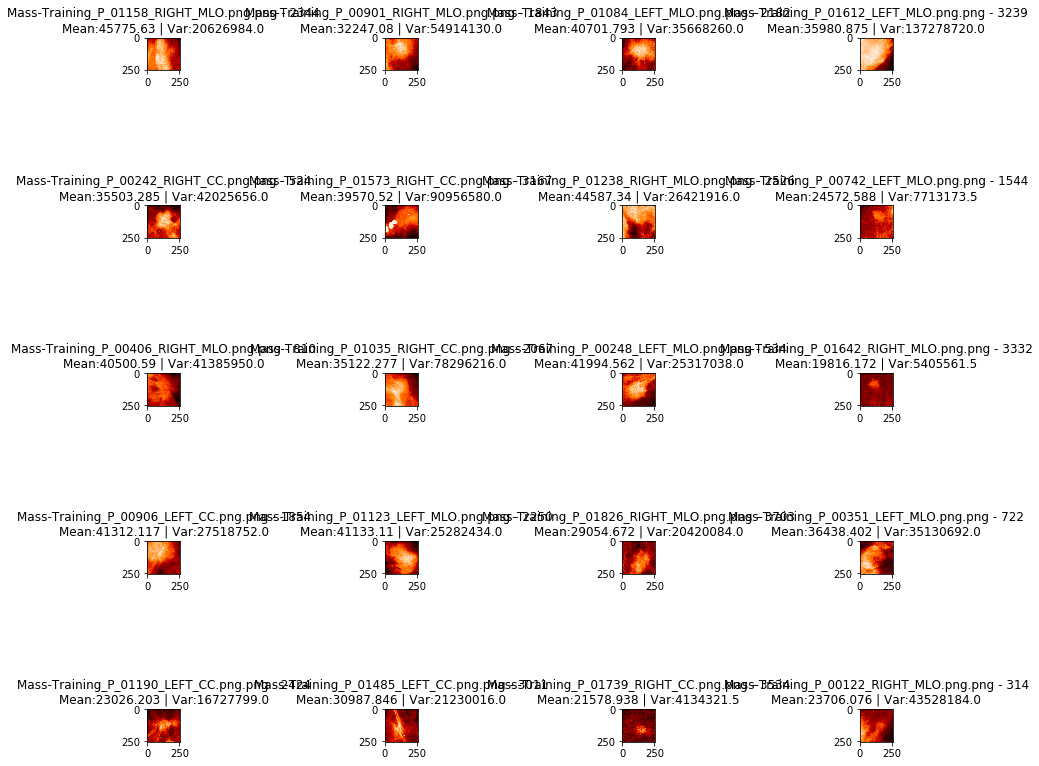

In [55]:
# random images 
N = 20
idx = random.sample(range(len(train_mass_patch)), k=N)
plt.figure(figsize=(12,12))
for i, j in enumerate(idx):
    plt.subplot(5,4,i+1)
    plt.imshow(train_mass_patch[j].reshape(256, 256), cmap='gist_heat')
    plt.title(train_mass_FN[j] + " - " + str(j)+ "\n" + "Mean:" + str(round(np.mean(train_mass_patch[j]),3)) + " | Var:" + str(round(np.var(train_mass_patch[j]),3)))
    plt.tight_layout()
plt.show()

In [1]:
# random images
N = 16
idx = random.sample(range(len(train_mass_patch)), k=N)
plt.figure(figsize=(12,12))
for i, j in enumerate(idx):
    plt.subplot(5,4,i+1)
    plt.imshow(train_mass_patch[j].reshape(256, 256), cmap='gray')
    plt.title(train_mass_FN[j]# + " - " + str(j)) #+ "\n" + "Mean:" + str(round(np.mean(test_mass_patch[j]),3)) + " | Var:" + str(round(np.var(test_mass_patch[j]),3)))
    plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (<ipython-input-1-7f222d2ab9c7>, line 9)

In [57]:
print("ROI Mean Size:", np.round(np.mean(train_mass_roi_size),2))
print("ROI Min Size:", np.min(train_mass_roi_size))
print("ROI Max Size:", np.max(train_mass_roi_size))
print("ROI Size Std:", np.round(np.std(train_mass_roi_size),2))

ROI Mean Size: 355.23
ROI Min Size: 86
ROI Max Size: 1365
ROI Size Std: 147.1


In [58]:
np.save(os.path.join("npy", "train_mass_patch.npy"), train_mass_patch)
np.save(os.path.join("npy", "train_mass_Lbl.npy"), np.array(train_mass_Lbl))
np.save(os.path.join("npy", "train_mass_FN.npy"), train_mass_FN)
np.save(os.path.join("npy", "train_mass_roi_size.npy"), np.array(train_mass_roi_size))

In [59]:
#데이터 합치기
train_patch = np.concatenate([train_mass_patch, train_calc_patch], axis=0)
train_Lbl = np.concatenate([train_mass_Lbl, train_calc_Lbl], axis=0)
train_FN = np.concatenate([train_mass_FN, train_calc_FN], axis=0)

test_patch = np.concatenate([test_mass_patch, test_calc_patch], axis=0)
test_Lbl = np.concatenate([test_mass_Lbl, test_calc_Lbl], axis=0)
test_FN = np.concatenate([test_mass_FN, test_calc_FN], axis=0)

In [60]:
print("Train Patches:", train_patch.shape)
print("Train Lables:", train_Lbl.shape)
print("Train File Names:", train_FN.shape)

print("Test Patches:", test_patch.shape)
print("Test Lables:", test_Lbl.shape)
print("Test File Names:", test_FN.shape)

Train Patches: (8451, 256, 256, 1)
Train Lables: (8451,)
Train File Names: (8451,)
Test Patches: (2082, 256, 256, 1)
Test Lables: (2082,)
Test File Names: (2082,)


In [61]:
np.save(os.path.join("abnormal", "abnormal_train_patch.npy"), train_patch)
np.save(os.path.join("abnormal", "abnormal_train_Lbl.npy"), train_Lbl)
np.save(os.path.join("abnormal", "abnormal_train_FN.npy"), train_FN)

np.save(os.path.join("abnormal", "abnormal_test_patch.npy"), test_patch)
np.save(os.path.join("abnormal", "abnormal_test_Lbl.npy"), test_Lbl)
np.save(os.path.join("abnormal", "abnormal_test_FN.npy"), test_FN)

In [63]:
#np.save(os.path.join("abnormal", "abnormal_all_roi_sizes.npy"), all_roi_sizes)